In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err, calc_rig_iso, calc_beta
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE, ANALYSIS_RANGE_EKIN, DETECTOR_LABEL
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning, make_lin_binning
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
import uproot
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
from tools.studybeta import weighted_avg_and_std
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
col = {'iss': 'black', 'mc':'tab:orange'}

In [3]:
mccolor = 'black'
def get_musigma_gausfit(hist2d_mc_tofTrue, minbin, maxbin, guess0, xrange, FigName=None, plotfile=None, sigmafactor=1.4):
    energy_binvalues = hist2d_mc_tofTrue.binnings[0].bin_centers[minbin:maxbin]
    graph_mean_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_sigma_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin, maxbin)):
   
        lowbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin]
        upbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin + 1]
        hist1d_mc = hist2d_mc_tofTrue.project(ibin) 
        hist1d_mc = hist1d_mc * (1/np.sum(hist1d_mc.values))
    

        xbinrange = hist1d_mc.binnings[0].get_indices(xrange)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue_mc = hist1d_mc.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange[0]:xbinrange[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
   
       
        guess_gaus_mc = guess0
        
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)
        for key in guess_gaus_mc.keys():
            guess_gaus_mc[key] = par_mc[key]
    
        xrange_iter2mc = [guess_gaus_mc['mu'] - sigmafactor * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + sigmafactor * guess_gaus_mc['sigma']]
        xbinrange2mc = hist1d_mc.binnings[0].get_indices(xrange_iter2mc)
    
        xedges_mc2 = hist1d_mc.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
        xvalue_mc2 = hist1d_mc.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalue_mc2 = hist1d_mc.values[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalueserr_mc2 = np.sqrt(hist1d_mc.squared_values[xbinrange2mc[0]:xbinrange2mc[1]])
        yvalueserr_mc2[yvalueserr_mc2==0] = 0.0001
    
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc2, yvalue_mc2, yvalueserr_mc2,normalized_gaussian, guess_gaus_mc)

        graph_mean_mcTofTrueReso.yvalues[ip] = par_mc['mu']
        graph_mean_mcTofTrueReso.yerrs[ip] = parerr_mc['mu']
        graph_sigma_mcTofTrueReso.yvalues[ip] = par_mc['sigma']
        graph_sigma_mcTofTrueReso.yerrs[ip] = parerr_mc['sigma']
                                                                                                                                                            
        fit_y_mc = normalized_gaussian(xvalue_mc2, *par_mc) 
        draw = False
        plotp = [0, 1, 2]
        if ip in plotp:
            figure, ax1 = plt.subplots(1, 1, figsize=(17, 14))
            plot_histogram_1d(ax1, hist1d_mc, style="mc", color='black', label=None, scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False) 
            #ax1.legend()
            ax1.plot(xvalue_mc2, fit_y_mc, '-', linewidth=3, color='blue')
            ax1.text(0.6, 0.98, f"[{lowbinedge:.2f}, {upbinedge:.2f}] GeV/n", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
       
           
        
            ax1.text(0.03, 0.93, f'{FigName}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black', weight='normal')  
            ax1.text(0.03, 0.85, f"$\\mu:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.text(0.03, 0.8, f"$\\sigma:$ {par_mc['sigma']:.4f}$\\pm$ {parerr_mc['sigma']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.set_ylabel('Normalized events')
            ax1.set_xlabel(r'm (GeV)')
            ax1.set_xlim(xrange) 
            #ax1.set_xlim([0.11, 0.175])
            #ax1.set_yscale('log')
            if plotfile is not None:
                savefig_tofile(figure, plotfile, f"hist1d_{FigName}_{ibin}", show=True) 
    return graph_mean_mcTofTrueReso, graph_sigma_mcTofTrueReso 

In [4]:
ANALYSIS_RANGE_EKIN_OVERLAP = {"Tof": [0.4, 1.1], "NaF": [1.1, 4.0], "Agl": [4.0, 12.0]}
ANALYSIS_RANGE_EKIN = {"Tof": [0.4, 1.1], "NaF": [1.2, 4.0], "Agl": [4.2, 12.0]}
slicevalue ={'Tof':[0.45, 1.1], 'NaF':[1.2, 4.0], 'Agl':[4.1, 12.0]}

plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203'
os.makedirs(plotfile, exist_ok=True)

detectors = ['Tof', 'NaF', 'Agl']
def get_hist_meanstd(hist2d):
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[1:-1]
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, 1:-1]
        if sum(ibin_fitdata) != 0:                                                                                                                                                                                
            avg[binx], std[binx] = weighted_avg_and_std(var_ycenter, ibin_fitdata)                                                                                                                                 
    return avg, std     
    

    

In [5]:
detectors = ['Tof', 'NaF', 'Agl']
#read the resolution fit parameters
df_probpars_AglLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/AglLi6_polypar_inversebeta.npz')
df_probpars_NaFLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/NaFLi6_polypar_inversebeta.npz')
df_probpars_TofLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/TofLi6_polypar_inversebeta.npz')
mass_nucleon_gev = 0.9314941 #in GeV 
df_probpars = {'Tof': df_probpars_TofLi6, 'NaF': df_probpars_NaFLi6, 'Agl': df_probpars_AglLi6}
print(df_probpars['Tof']['mean'])


beta = np.linspace(0.7, 0.99999, 500)
deltabeta = {}
fig, ax1 = plt.subplots(1, 1, figsize= (20, 14))
for dec in detectors:
    print(dec, df_probpars[dec]['mean'])
    deltabeta[dec] = np.poly1d(df_probpars[dec]['mean'])(np.log(beta))
    ax1.grid()
    ax1.plot(beta, deltabeta[dec], label = f'{dec}')
    ax1.legend()

x0 = np.log(0.9)
print()

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/AglLi6_polypar_inversebeta.npz'

NameError: name 'df_probpars' is not defined

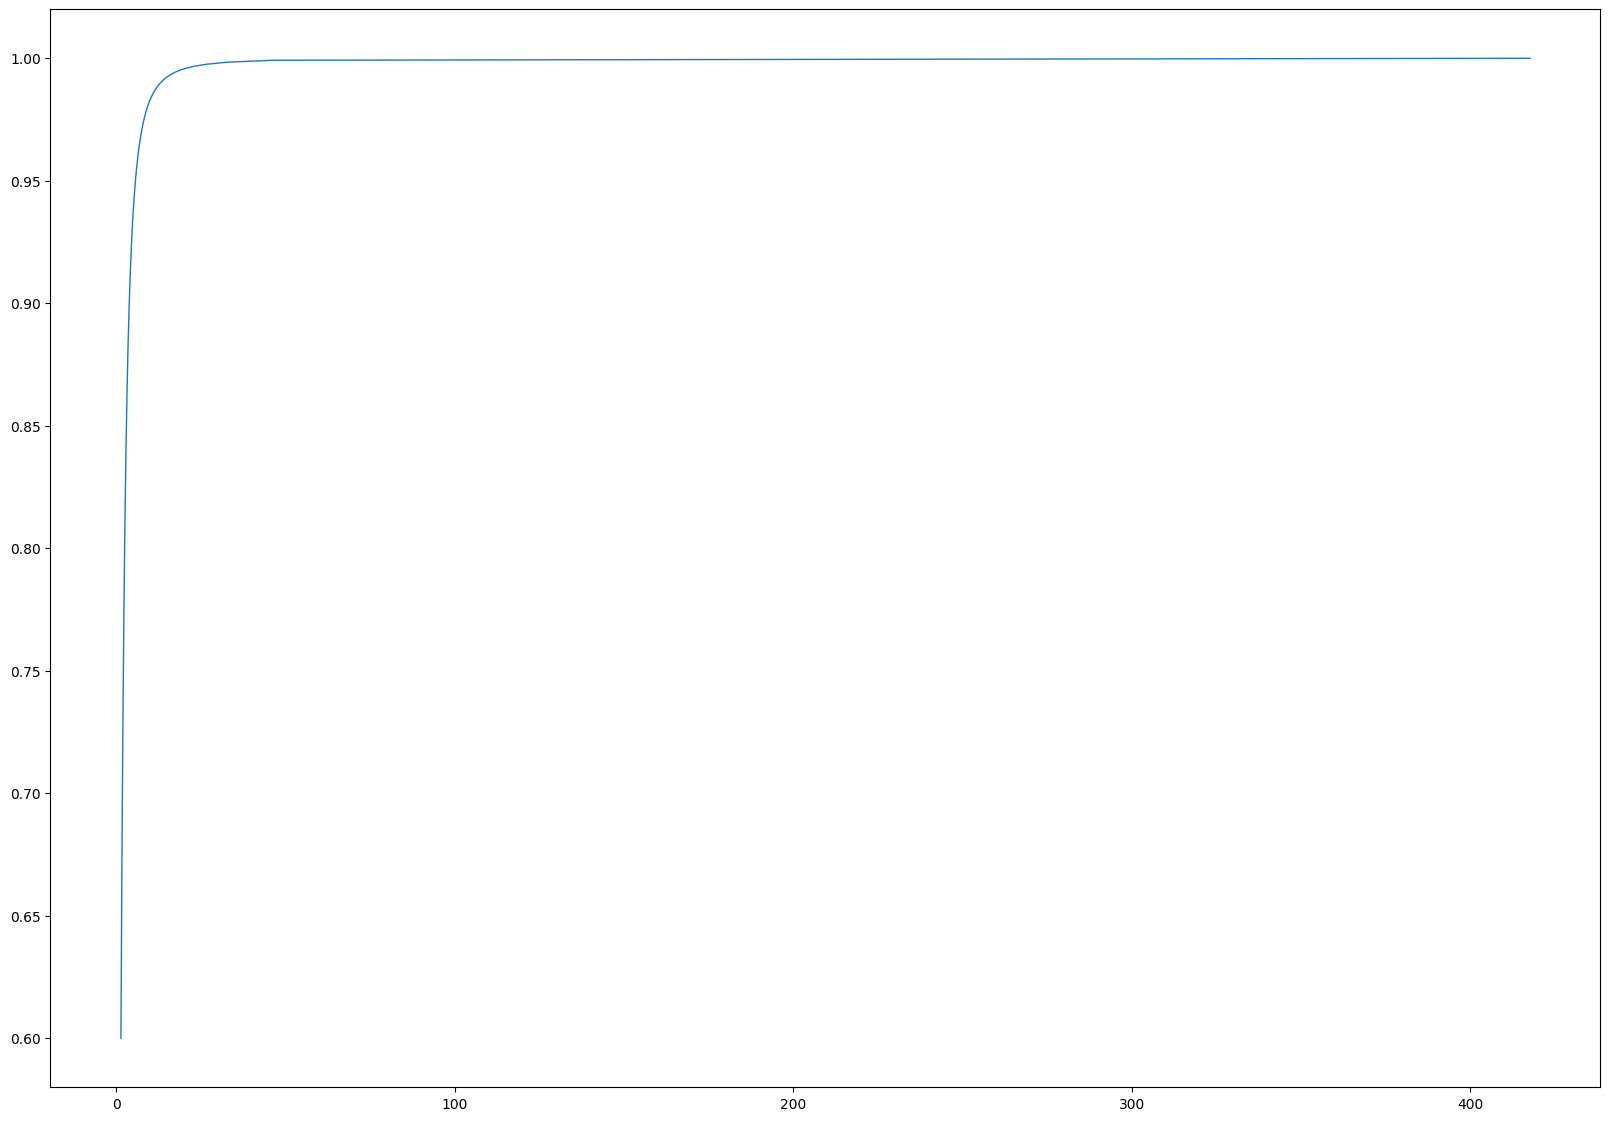

In [5]:

ISO_A = {'Li6': 6, 'Li7': 7}

beta_iso = {}
rig = {}
rig_vsBeta = {}

factor_up = {'Tof': 0.98,  'NaF': 0.998, 'Agl': 0.999}                                                                                                                                                                            
factor_low = {'Tof': 1.02,  'NaF': 1.001, 'Agl': 1.001}   

deltabeta = {} 
rig_gen = np.linspace(1, 50, 500)
beta = np.linspace(0.6, 0.99999, 500)
for iso in ISOTOPES['Li']:
    rig[iso] = calc_rig_iso(beta, iso)
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    rig_vsBeta[iso] = MGraph(beta, rig[iso], np.zeros_like(rig[iso]))
    
RcfRange = {'Tof': [1.2, 5], 'NaF':[3, 20], 'Agl':[5, 30]}
BcfRange ={'Tof': [0.63, 0.9], 'NaF':[0.9, 1.0], 'Agl':[0.953, 1.0]}
for dec in detectors:
    fig, ax1 = plt.subplots(1, 1, figsize= (20, 14))
    for iso in ISOTOPES['Li']:
        ax1.plot(rig[iso], beta,  '-', color=ISOTOPES_COLOR[iso], label=rf'$\mathrm{{\beta(R_{{c}}, ^{ISO_A[iso]}Li , f=1.0)}}$', linewidth=1)
        #ax1.plot(rig[iso] * 1.1, beta,  '-', color='green', label=f'{ISO_LABELS[iso]}', linewidth=1)
        deltabeta[dec] = np.poly1d(df_probpars[dec]['mean'])(np.log(beta))

        ax1.fill_between(rig_gen, beta_iso['Li7'], beta_iso['Li6'], alpha=0.1, color="tab:blue") 
        
        
    ax1.plot(rig['Li6'], beta-deltabeta[dec],  '-', color='red', label=rf'$eng loss$', linewidth=1)
    ax1.plot(rig['Li7'], beta-deltabeta[dec],  '-', color='green', label=rf'$eng loss$', linewidth=1)
    ax1.fill_between(rig['Li6'], beta-deltabeta[dec], (beta-deltabeta[dec]) * factor_up[dec], alpha=0.1, color="grey")     
    SetAx1Axis(ax1, r'$\mathrm{R_{maxcutoff} \ (GV)}$', r'$\mathrm{\beta_{maxcutoff}}$', TEXTSIZE, xlimrange=RcfRange[dec], ylimrange=BcfRange[dec], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
    ax1.plot(rig['Li7'], (beta-deltabeta[dec]) * factor_low[dec],  '--', color='green', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{7}}Li , f={factor_low[dec]})}}$', linewidth=2)
    ax1.plot(rig['Li6'], (beta-deltabeta[dec]) * factor_up[dec],  '--', color='red', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{6}}Li , f={factor_up[dec]})}}$', linewidth=2)
    #ax1.plot(rig_gen * 1.1, beta_iso['Li6'],  '-', color='green', label=r'$\mathrm{1.1 * R_{cutoff}}$', linewidth=3)
    ax1.legend(fontsize=25, loc='upper left')  
    set_plot_style(ax1)
    savefig_tofile(fig, plotfile, f"func_betaVsR_Li{dec}", 1)   

    


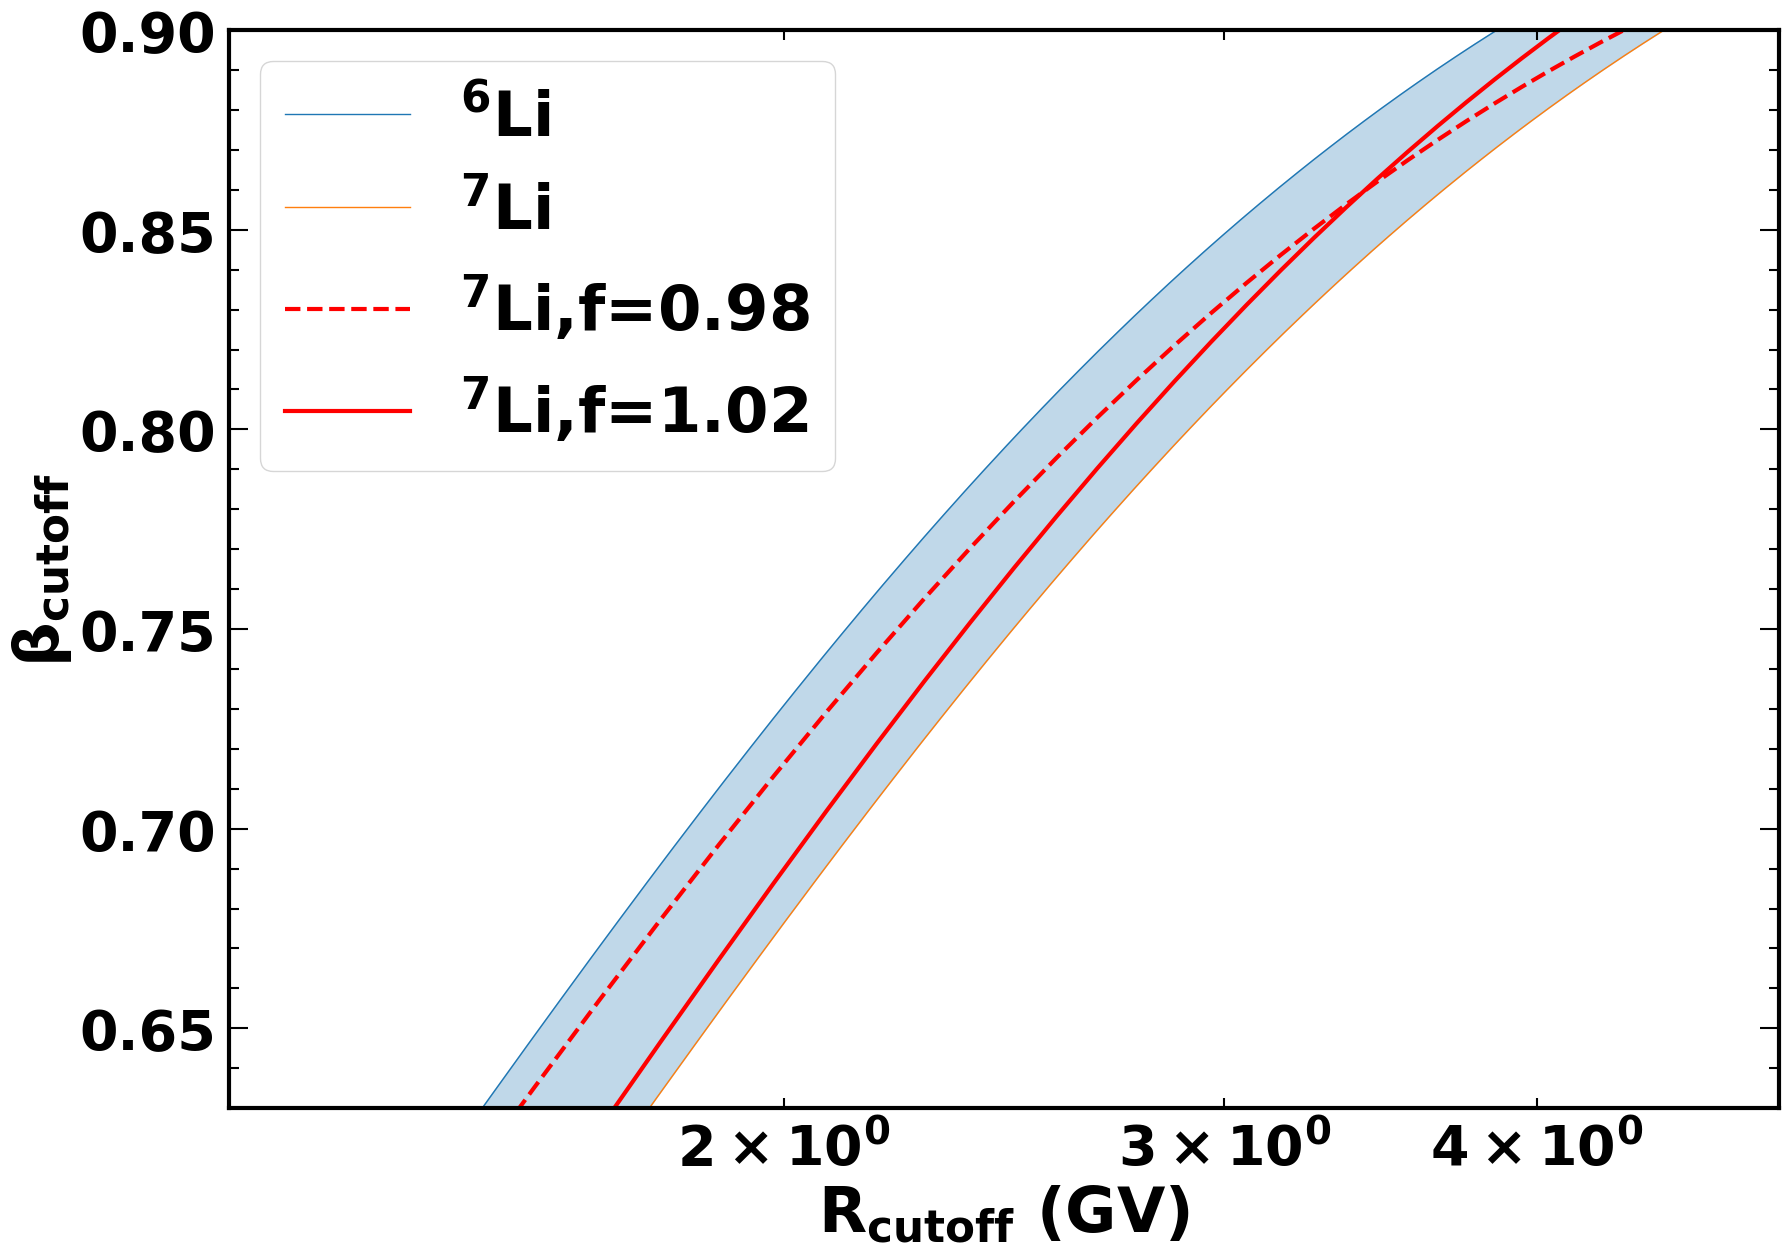

In [7]:
beta = np.linspace(0.6, 0.99999, 500)
rig_gen = np.linspace(1, 50, 500)
beta_iso = {}
rig = {}
rig_vsBeta = {}
for iso in ISOTOPES['Li']:
    rig[iso] = calc_rig_iso(beta, iso)
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    rig_vsBeta[iso] = MGraph(beta, rig[iso], np.zeros_like(rig[iso]))
    
fig, ax1 = plt.subplots(1, 1, figsize= (20, 14))
for iso in ISOTOPES['Li']:
    ax1.plot(rig[iso], beta,  '-', color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}', linewidth=1)
    #ax1.plot(rig[iso] * 1.1, beta,  '-', color='green', label=f'{ISO_LABELS[iso]}', linewidth=1)
    ax1.fill_between(rig_gen, beta_iso['Li7'], beta_iso['Li6'], alpha=0.1, color="tab:blue") 
    ax1.set_xscale('log')
    ax1.set_xlim([1.2, 5])
    ax1.set_ylim([0.63, 0.9])
    set_plot_style(ax1)
   
    ax1.set_xlabel(r'$\mathrm{R_{cutoff} \ (GV)}$')
    ax1.set_ylabel(r'$\mathrm{\beta_{cutoff}}$')
    ax1.grid()

ax1.plot(rig_gen, beta_iso['Li6']*0.98,  '--', color='red', label=f'{ISO_LABELS[iso]},f=0.98', linewidth=3)
ax1.plot(rig_gen, beta_iso['Li7']*1.02,  '-', color='red', label=f'{ISO_LABELS[iso]},f=1.02', linewidth=3)

#ax1.plot(rig_gen * 1.1, calc_beta(rig_gen, ISOTOPES_MASS['Li6'], ISOTOPES_CHARGE['Li6']),  '-', color='green', label=r'$\mathrm{1.1 * R_{cutoff}}$', linewidth=3)
ax1.fill_between(rig_gen, beta_iso['Li7'], beta_iso['Li6'], alpha=0.1, color="tab:blue") 
ax1.legend()    
savefig_tofile(fig, plotfile, f"func_betaVsR_Li", 1)   


/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203


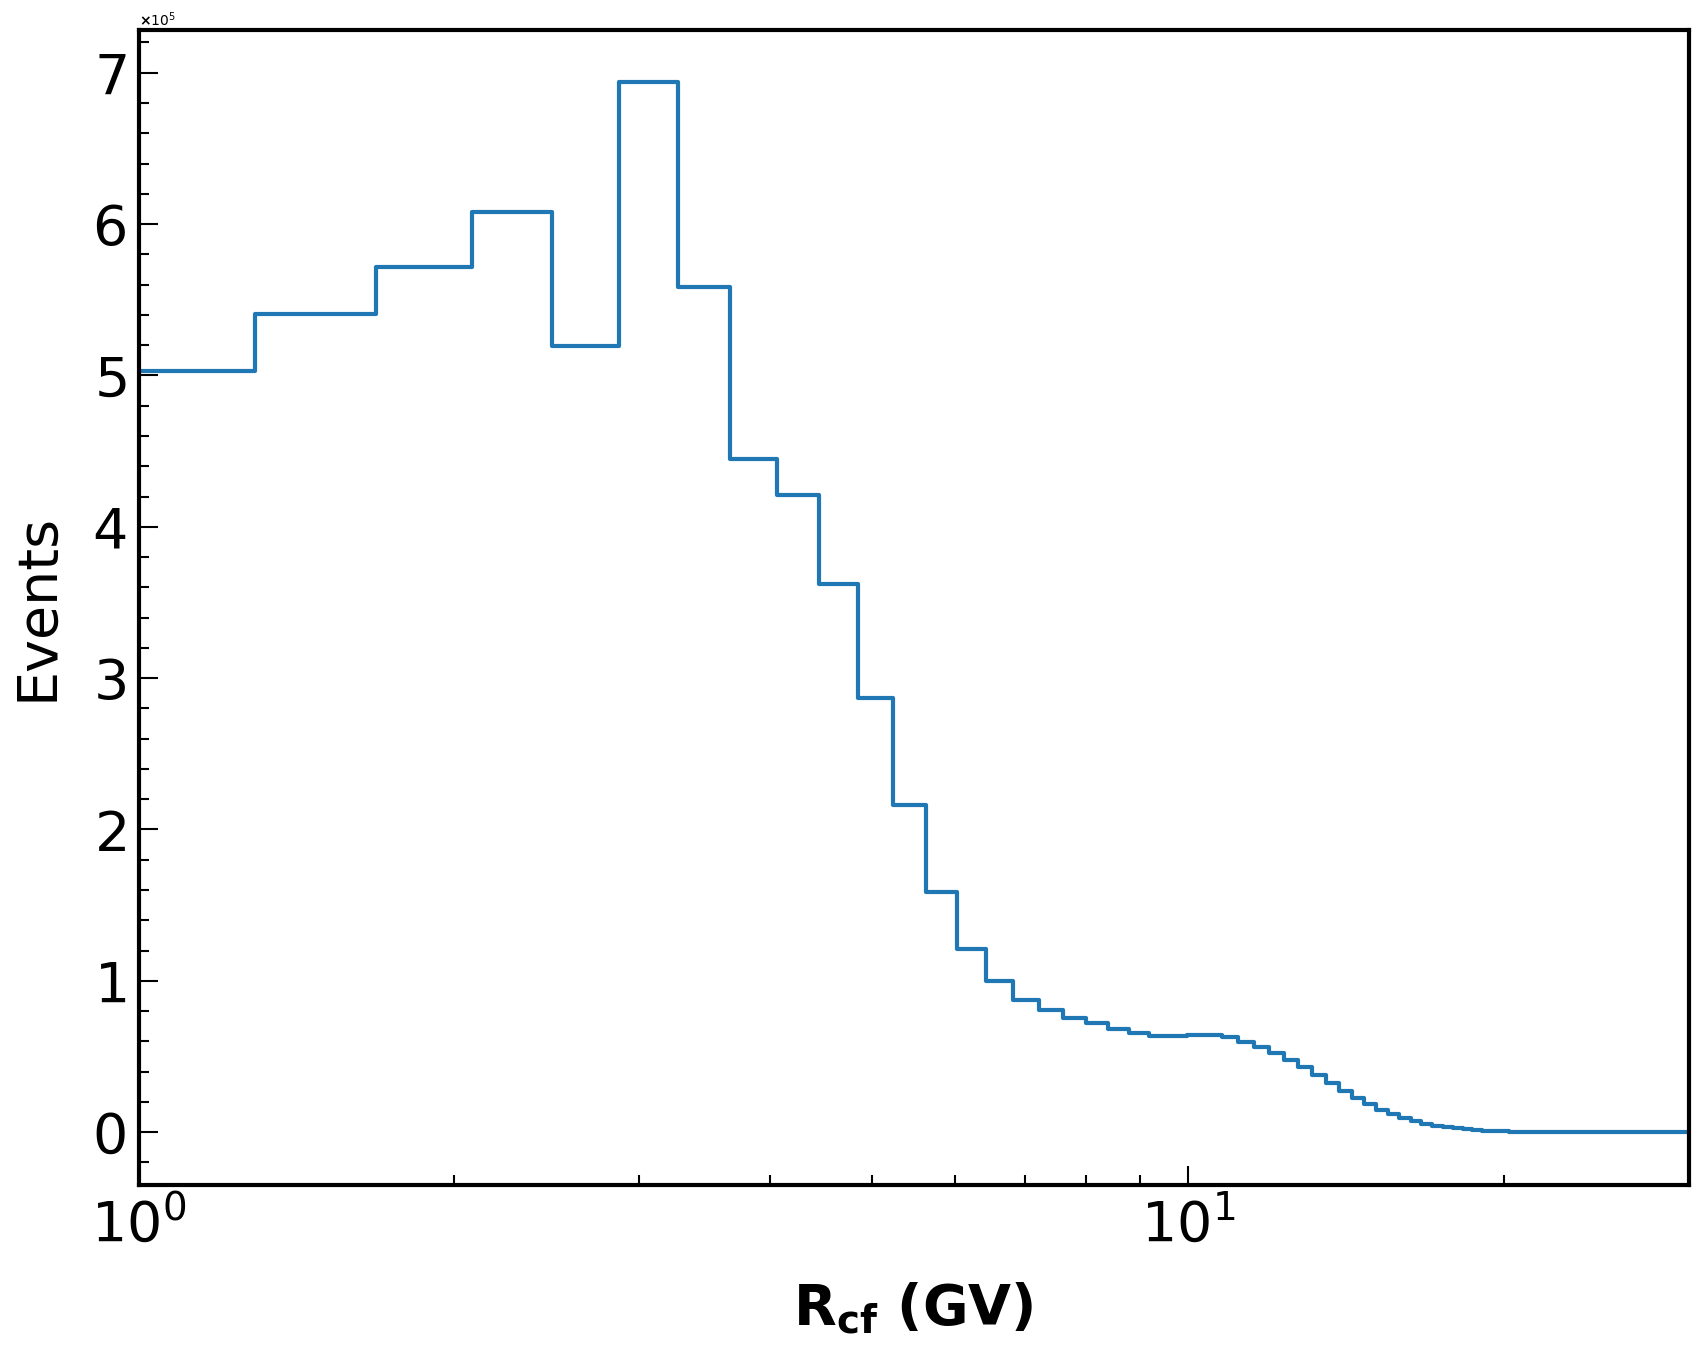

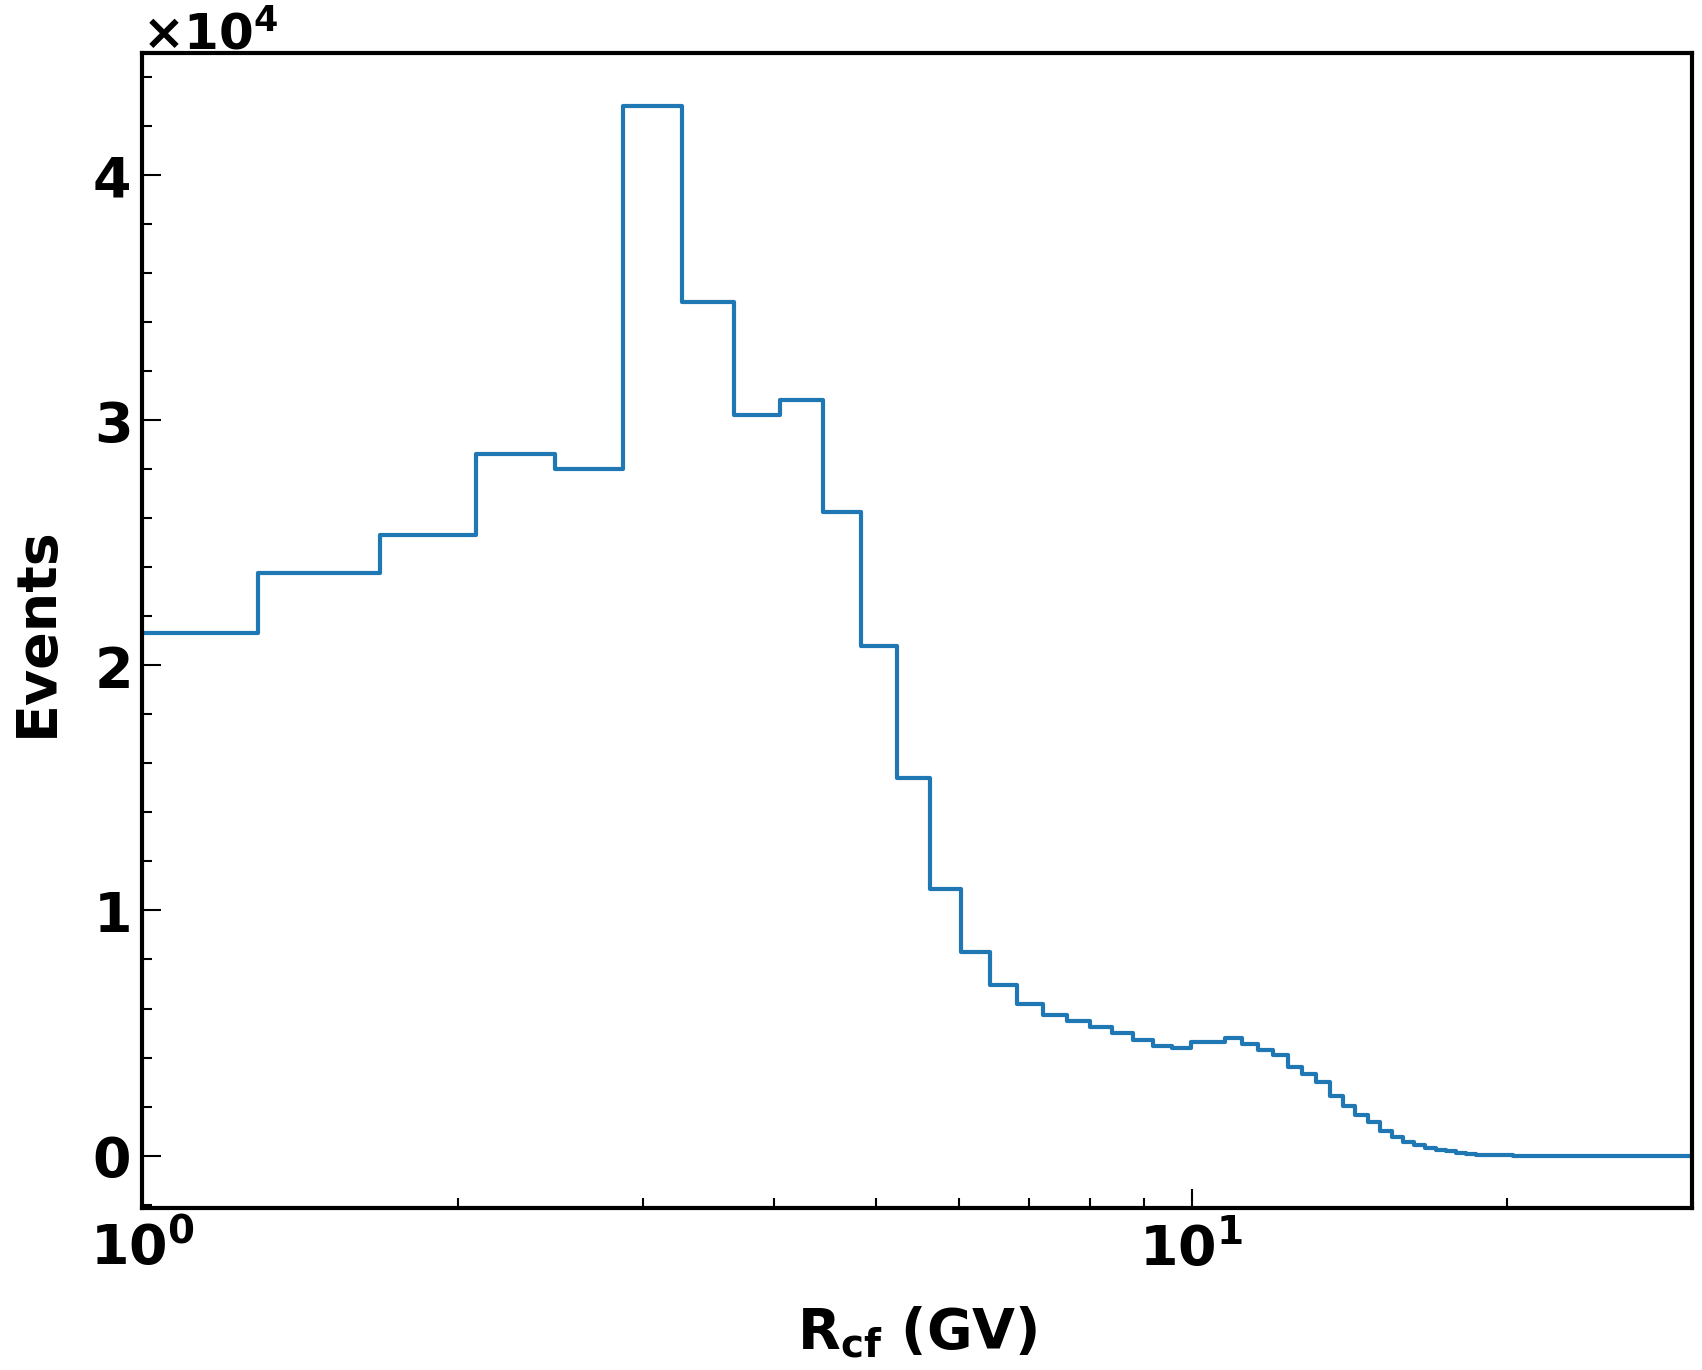

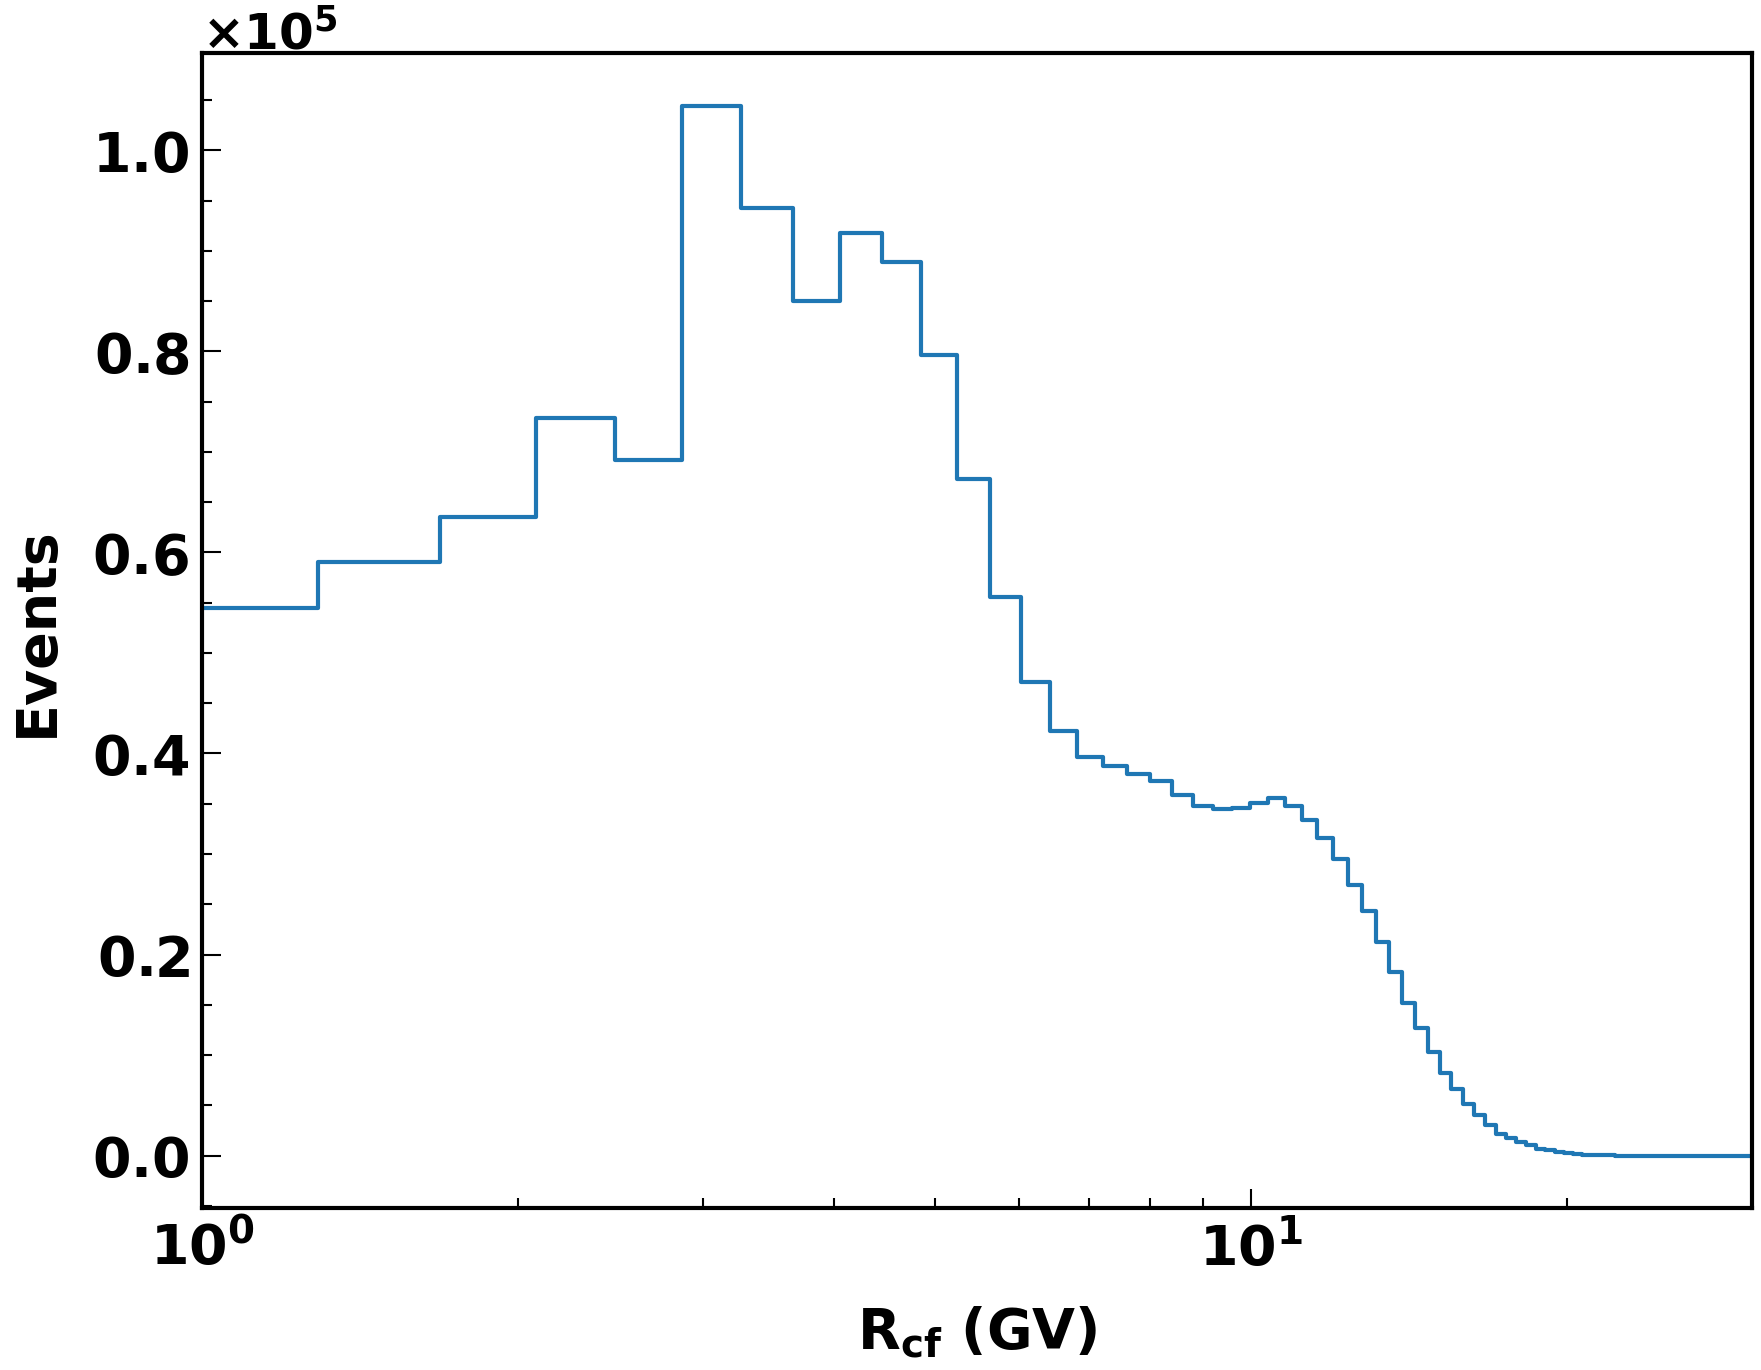

In [6]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'v4'
#filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_v2.npz'
filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/Li6hist_masscutoff_bkt2_mcrec.npz'
mtype = 'inv'
hist1dcutoff = {}
minbin = {'Tof': 1, 'NaF':1, 'Agl':7}
maxbin =  {'Tof':3,  'NaF':3, 'Agl':12}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
xrange = {'Tof': [0.11, 0.16], 'NaF': [0.11, 0.16], 'Agl': [0.123, 0.16]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}

detectors = ['Tof', 'NaF', 'Agl']
with np.load(filename) as histfile:       
    for dec in detectors:
        hist1dcutoff[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_cutoff")  
        #graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile)
        

for dec in detectors:  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot.set_xlim([1, 30])
    plot_histogram_1d(plot, hist1dcutoff[dec], style="mc", color='tab:blue', label=None, scale=None, gamma=None, xlog=True, ylog=False, linewidth=3, setscilabely=True)
    plot.set_ylabel('Events', labelpad=20, fontsize=TEXTSIZE)
    plot.set_xlabel(r'$\mathrm{R_{cf} \ (GV)}$', labelpad=20, fontsize=TEXTSIZE)
    print(plotfile)
    savefig_tofile(fig, plotfile, f"hist1d_cutoff_{dec}", show=True)    



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


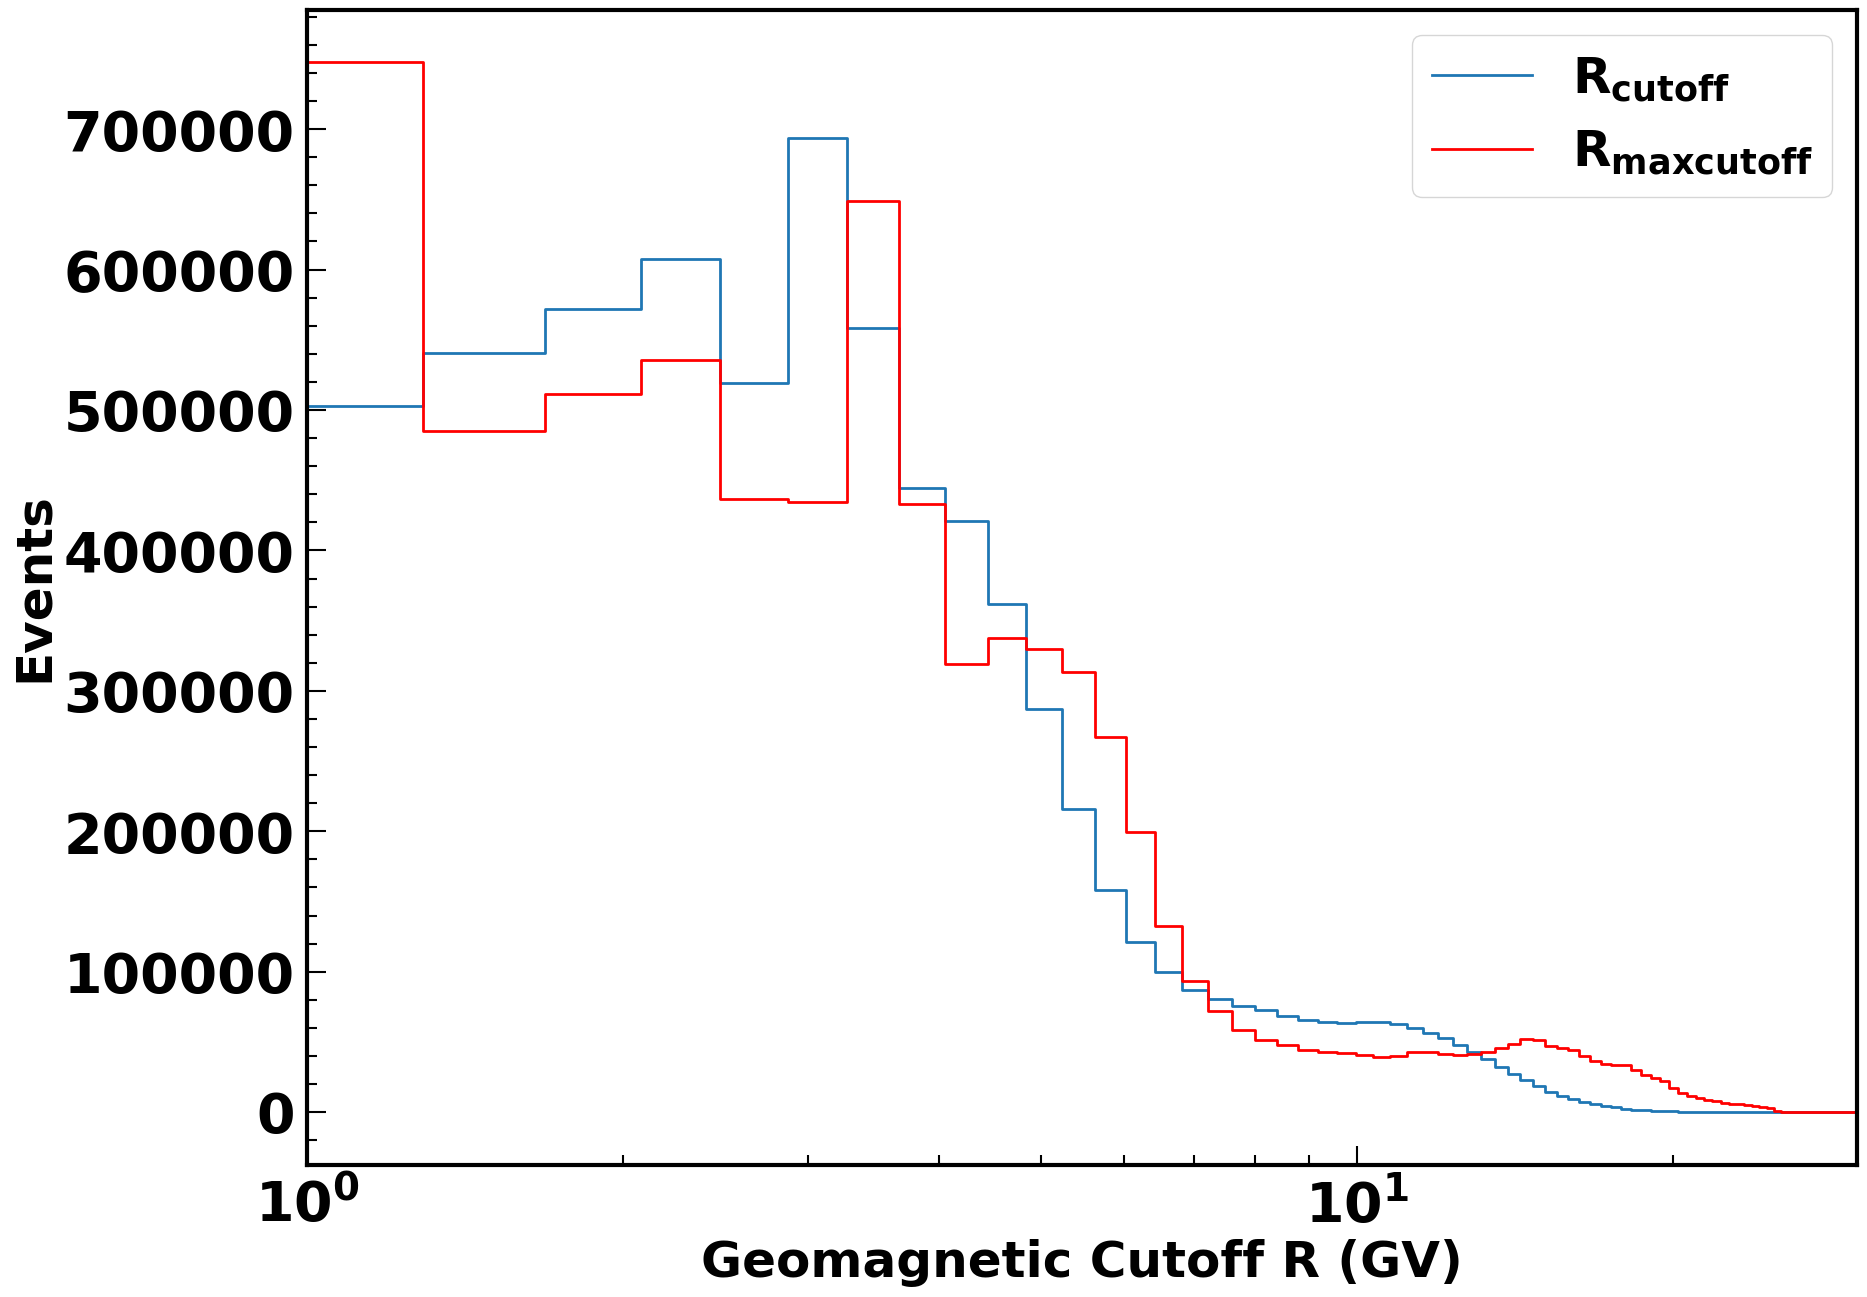

In [7]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'v4'
filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_v2.npz'

minbin = {'Tof': 1, 'NaF':1, 'Agl':7}
maxbin =  {'Tof':3,  'NaF':3, 'Agl':12}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
xrange = {'Tof': [0.11, 0.16], 'NaF': [0.11, 0.16], 'Agl': [0.123, 0.16]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}

hist1dcutoff = {}
hist1dmaxcutoff = {}

detectors = ['Tof', 'NaF', 'Agl']
with np.load(filename) as histfile:       
    for dec in detectors:
        hist1dcutoff[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_cutoff")  
        hist1dmaxcutoff[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_maxcutoff")
        #graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile)
        

for dec in ['Tof']:  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot.set_xlim([1, 30])
    plot_histogram_1d(plot, hist1dcutoff[dec], style="mc", color='tab:blue', label=r'$\mathrm{R_{cutoff}}$', scale=None, gamma=None, xlog=True, ylog=False, linewidth=2)
    plot_histogram_1d(plot, hist1dmaxcutoff[dec], style="mc", color='red', label=r'$\mathrm{R_{maxcutoff}}$', scale=None, gamma=None, xlog=True, ylog=False, linewidth=2)
    plot.legend()
    plot.set_xlabel('Geomagnetic Cutoff R (GV)')
    savefig_tofile(fig, plotfile, f"hist1d_cutoff_{dec}", show=True)    



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


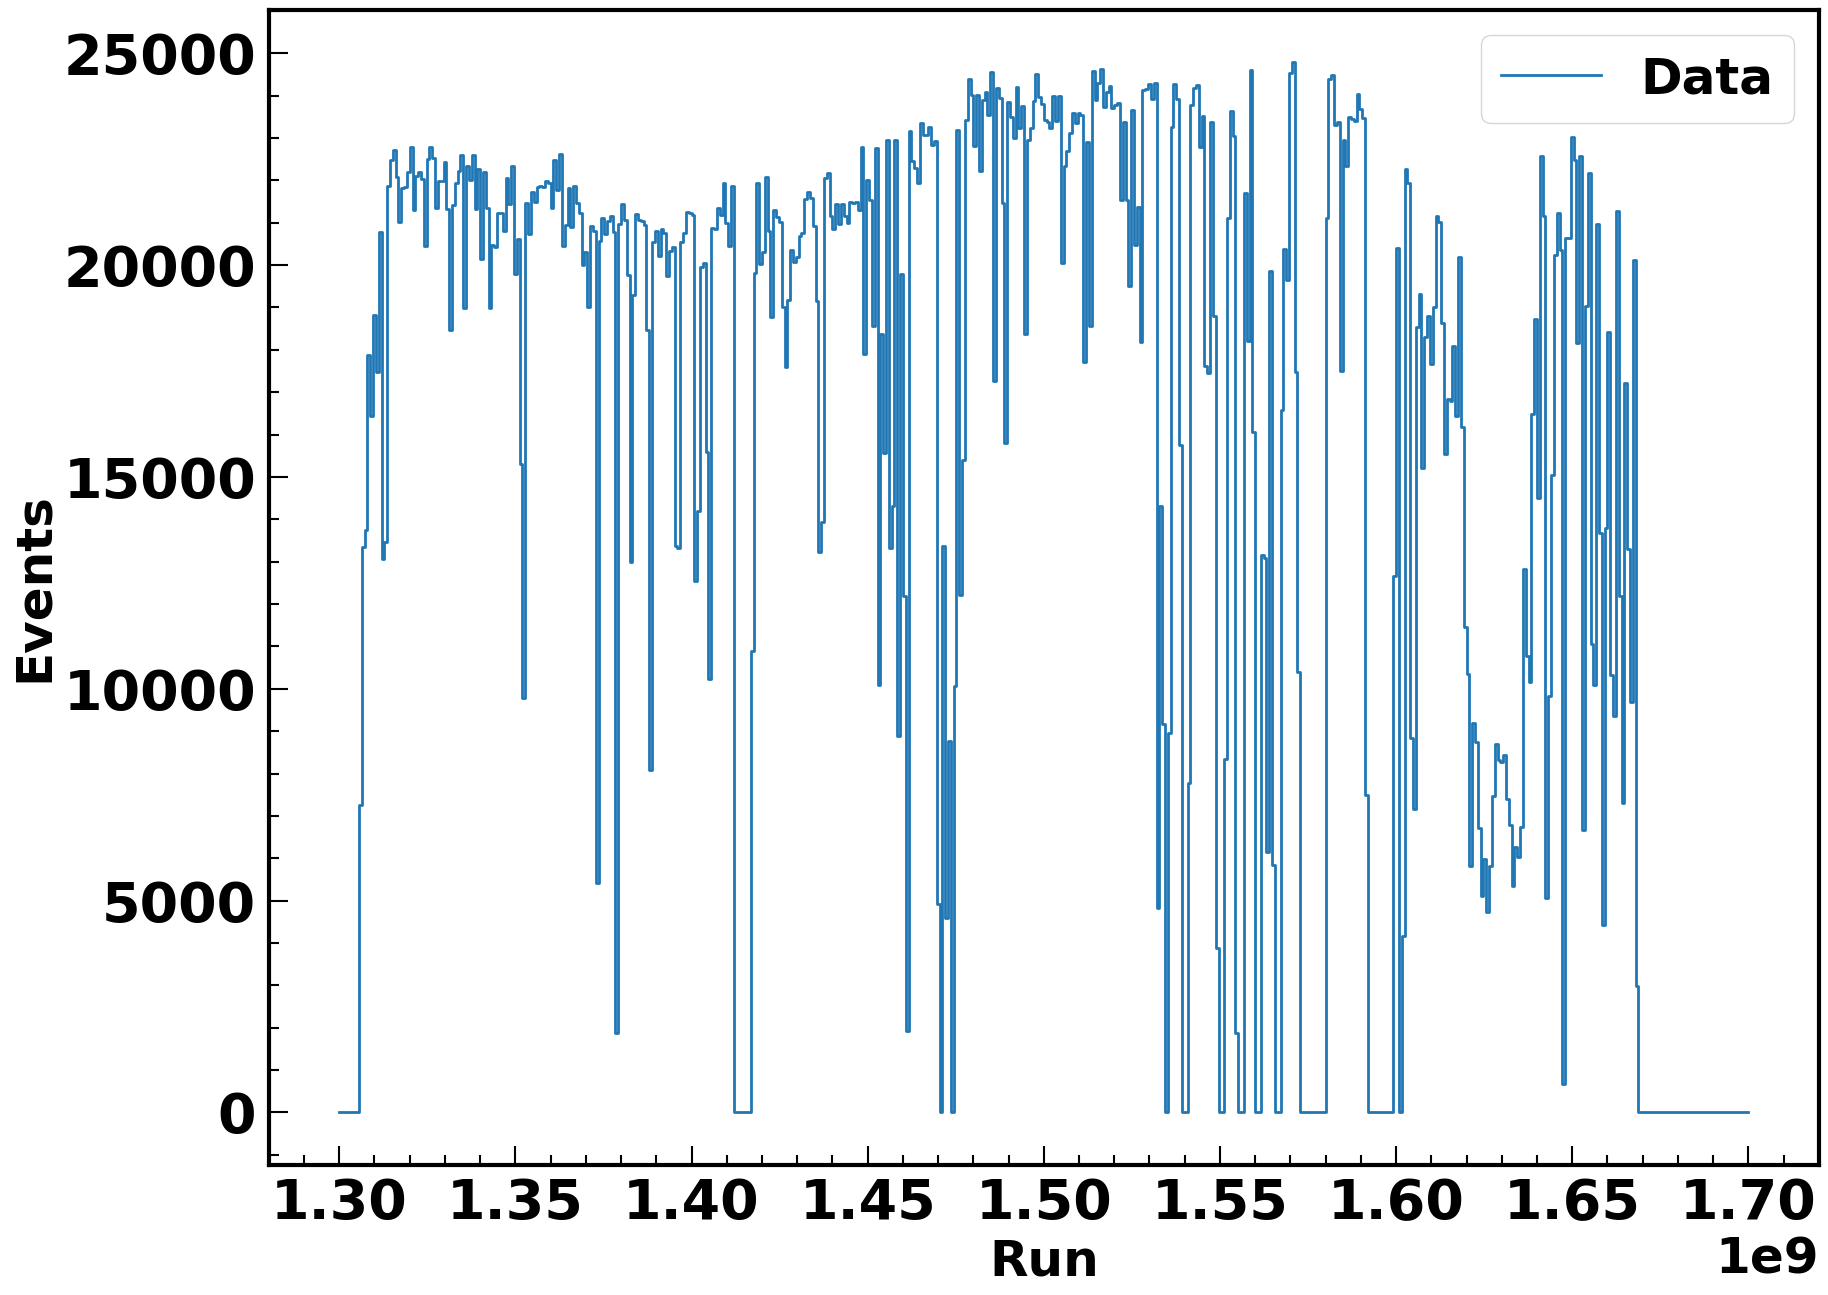

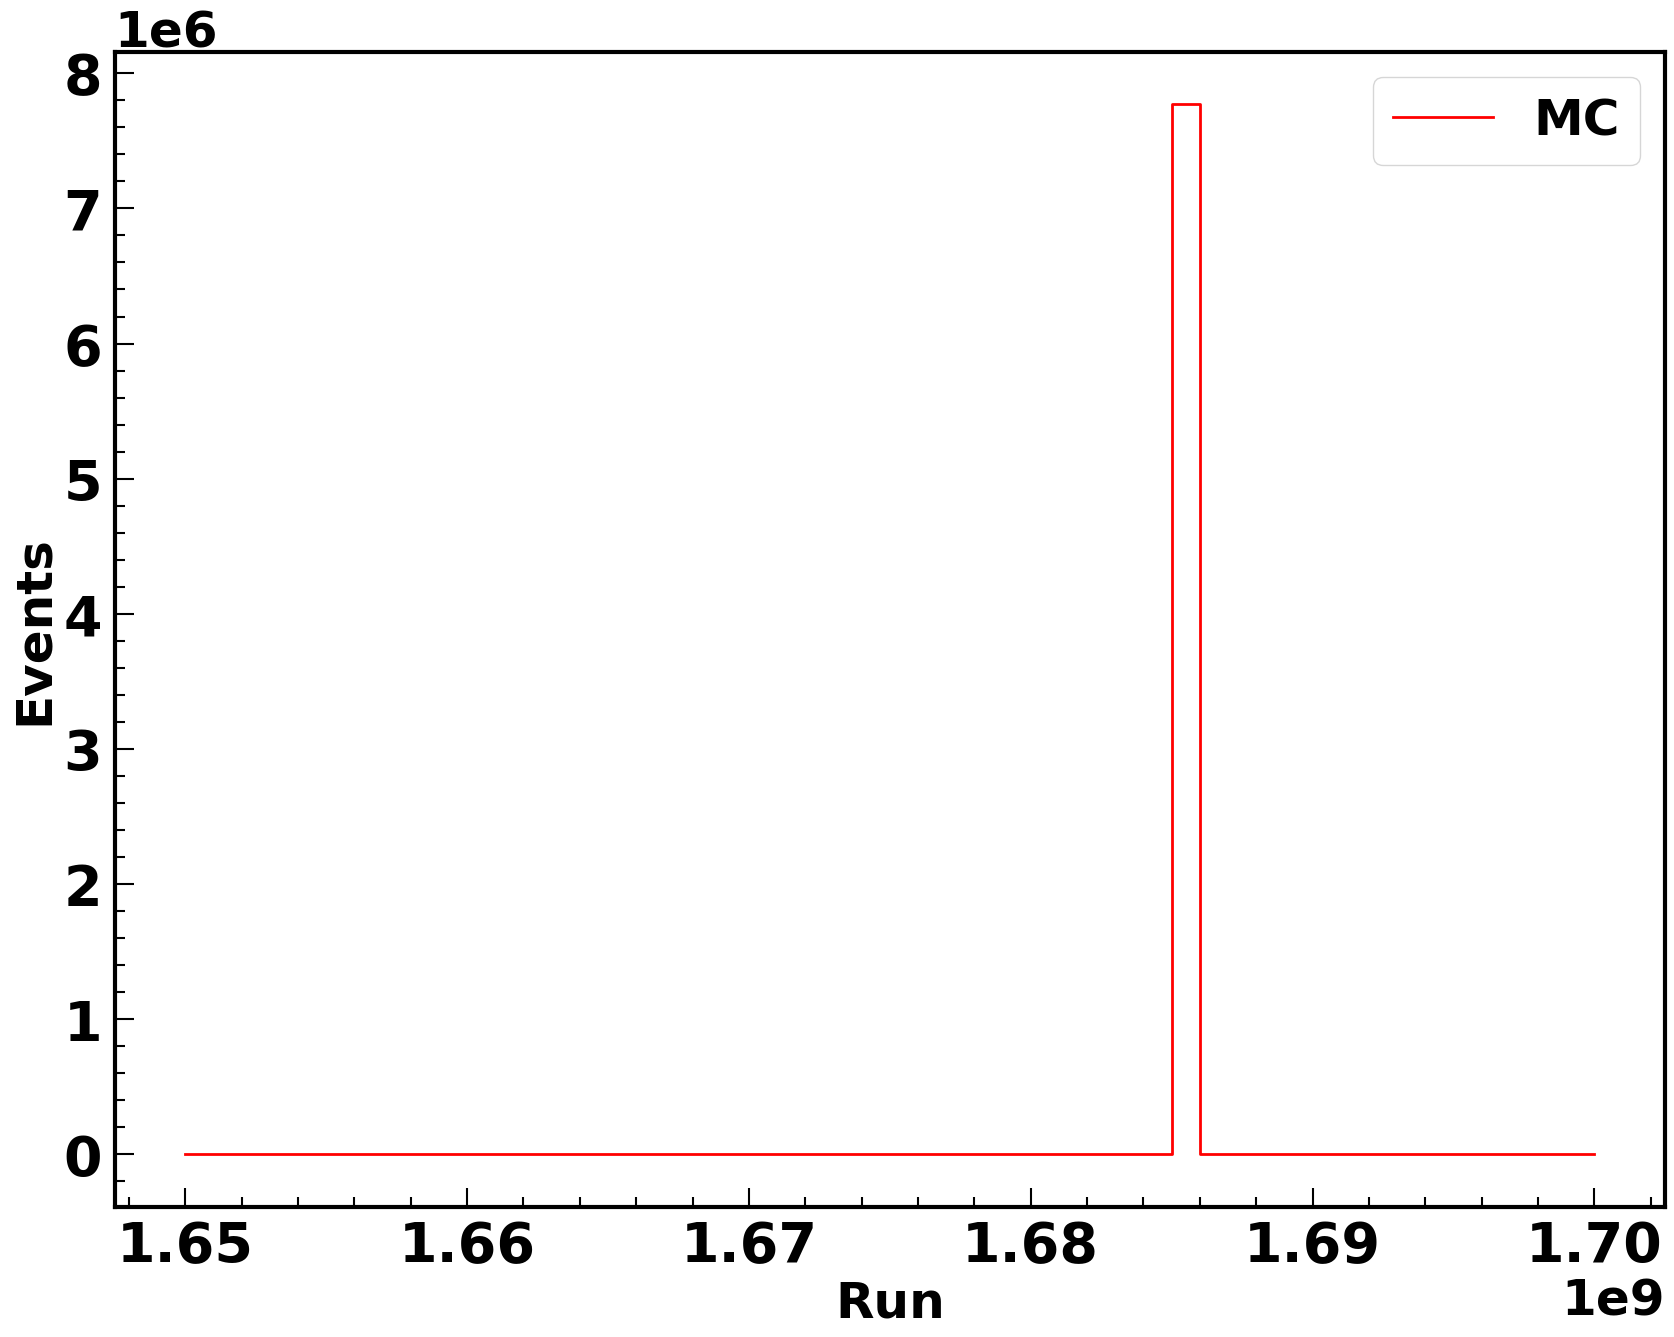

In [8]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'v4'
filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_bkt1_mcgen3.npz'

minbin = {'Tof': 1, 'NaF':1, 'Agl':7}
maxbin =  {'Tof':3,  'NaF':3, 'Agl':12}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
xrange = {'Tof': [0.11, 0.16], 'NaF': [0.11, 0.16], 'Agl': [0.123, 0.16]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}

histisstime = {}
histmctime = {}

detectors = ['Tof', 'NaF', 'Agl']
with np.load(filename) as histfile:       
    for dec in detectors:
        histisstime[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_timestamp")  
        histmctime[dec] = WeightedHistogram.from_file(histfile, f"Li7MC_{dec}_timestamp")
        #graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile)
        

for dec in ['Tof']:  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    #plot.set_xlim([1, 30])
    histmctime[dec].values = histmctime[dec].values * histisstime[dec].values.sum()/histmctime[dec].values.sum()
    plot_histogram_1d(plot, histisstime[dec], style="mc", color='tab:blue', label=r'Data', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    #plot_histogram_1d(plot, histmctime[dec], style="mc", color='red', label=r'$\mathrm{R_{maxcutoff}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot.legend()
    plot.set_xlabel('Run')
    savefig_tofile(fig, plotfile, f"histiss_run_{dec}", show=True)  
    
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    #plot.set_xlim([1, 30])
    histmctime[dec].values = histmctime[dec].values * histisstime[dec].values.sum()/histmctime[dec].values.sum()
    #plot_histogram_1d(plot, histisstime[dec], style="mc", color='tab:blue', label=r'$\mathrm{R_{cutoff}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(plot, histmctime[dec], style="mc", color='red', label=r'MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot.legend()
    plot.set_xlabel('Run')
    savefig_tofile(fig, plotfile, f"histmc_run_{dec}", show=True)    



In [9]:
#file_data = f'/home/manbing/Documents/Data/data_unfold/dfile/BeMC_beta_residual_rwthB1220raw_v1.npz'
from tools.studybeta import weighted_avg_and_std
def get_hist_meanstd(hist2d):
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[1:-1]
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, 1:-1]
        if sum(ibin_fitdata) != 0:                                                                                                                                                                                
            avg[binx], std[binx] = weighted_avg_and_std(var_ycenter, ibin_fitdata)                                                                                                                                 
    return avg, std     
 

df_probpars_AglLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/AglLi6_polypar_inversebeta.npz')
df_probpars_NaFLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/NaFLi6_polypar_inversebeta.npz')
df_probpars_TofLi6 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/TofLi6_polypar_inversebeta.npz')
mass_nucleon_gev = 0.9314941 #in GeV 
df_probpars = {'Tof': df_probpars_TofLi6, 'NaF': df_probpars_NaFLi6, 'Agl': df_probpars_AglLi6}
beta_gen = np.linspace(0.5, 1.0, 100)
file_data = f'/home/manbing/Documents/Data/data_LiP8/LiMC_hist_AllHist.npz'
isotopes = ['Li6', 'Li7']
betalim = {'Tof':[0.6, 1.0], 'NaF':[0.8, 1.0], 'Agl':[0.96, 1.0]}
xbetalim = {'Tof':[0.5, 1.0], 'NaF':[0.7, 1.0], 'Agl':[0.96, 1.0]}
ybetalim = {'Tof':[-0.1, 0.4], 'NaF':[-0.1, 0.15], 'Agl':[-0.001, 0.007]}
mean_deltaBeta = {dec: {} for dec in detectors}
graph_mean_deltaBeta = {dec: {} for dec in detectors}
spline_deltaBetaVsBeta = {dec: {} for dec in detectors}
npzfile = np.load(file_data)

for dec in detectors:
    pars_poly_deltaBetaVsBeta = {}
    for iso in isotopes:
        hist2d = WeightedHistogram.from_file(npzfile, f"hist2d_inversebeta_residual_vsBeta_{dec}{iso}")  
        mean_deltaBeta[dec][iso], std_err = get_hist_meanstd(hist2d)
        graph_mean_deltaBeta[dec][iso] = MGraph(hist2d.binnings[0].bin_centers[1:-1], mean_deltaBeta[dec][iso], std_err)
        graph_mean_deltaBeta[dec][iso] = slice_graph_by_value(graph_mean_deltaBeta[dec][iso], betalim[dec])
        spline_deltaBetaVsBeta[dec][iso] = UnivariateSpline(np.log(graph_mean_deltaBeta[dec][iso].xvalues), graph_mean_deltaBeta[dec][iso].yvalues,  k=3, s=10)  
        pars_poly_deltaBetaVsBeta[iso] = np.polyfit(np.log(graph_mean_deltaBeta[dec][iso].xvalues), graph_mean_deltaBeta[dec][iso].yvalues, deg=4)  
        
        #plot.plot(np.linspace(0.5, 1.0, 100), spline_deltaBetaVsBeta[dec][iso](np.log(np.linspace(0.5, 1.0, 100))), '-', color='black')
        
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
                   ybinning=hist2d.binnings[1].edges[1:-1],
                   counts=hist2d.values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
        #plot.plot(hist2d.binnings[0].bin_centers[1:-1], mean_deltaBeta[dec][iso])
        plot_graph(fig, plot, graph_mean_deltaBeta[dec][iso], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC {dec}")
        plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        #plot.plot(beta, deltabeta[dec], label = f'{dec}', color='tab:blue')
        plot.plot(beta_gen, np.array(np.poly1d(df_probpars[dec]['mean'])(np.log(beta_gen))), label = f'{dec}', color='tab:blue')
        plot.plot(beta_gen, np.array(np.poly1d(pars_poly_deltaBetaVsBeta[iso])(np.log(beta_gen))), label = f'{dec}', color='tab:green')
        #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
        plot.set_xlabel(r"$\mathrm{\beta_{gen}}$", fontsize=TEXTSIZE)
        plot.set_ylabel(rf'$\mathrm{{\beta_{{gen}} - \beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
        #plot.set_xscale('log')

        with open(f'/home/manbing/Documents/Data/data_LiP8/unfold/spline_deltabeta_vsbeta_{dec}{iso}.pickle', 'wb') as file:
            pickle.dump(spline_deltaBetaVsBeta[dec][iso], file)  
        
        #plot.set_yscale('log')
        plot.set_xlim(xbetalim[dec])
        plot.set_ylim(ybetalim[dec])
        #plot.set_xscale('log')
        print(plotfile)
        savefig_tofile(fig, plotfile, f"{nuclei}_hist_betaresidual_{dec}_englos", 1)  
    np.savez(os.path.join('/home/manbing/Documents/Data/data_LiP8/unfold/', f'{dec}_mean_polypar_inversebeta_residual.npz'), **pars_poly_deltaBetaVsBeta) 
print(pars_poly_deltaBetaVsBeta)

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/AglLi6_polypar_inversebeta.npz'

/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203


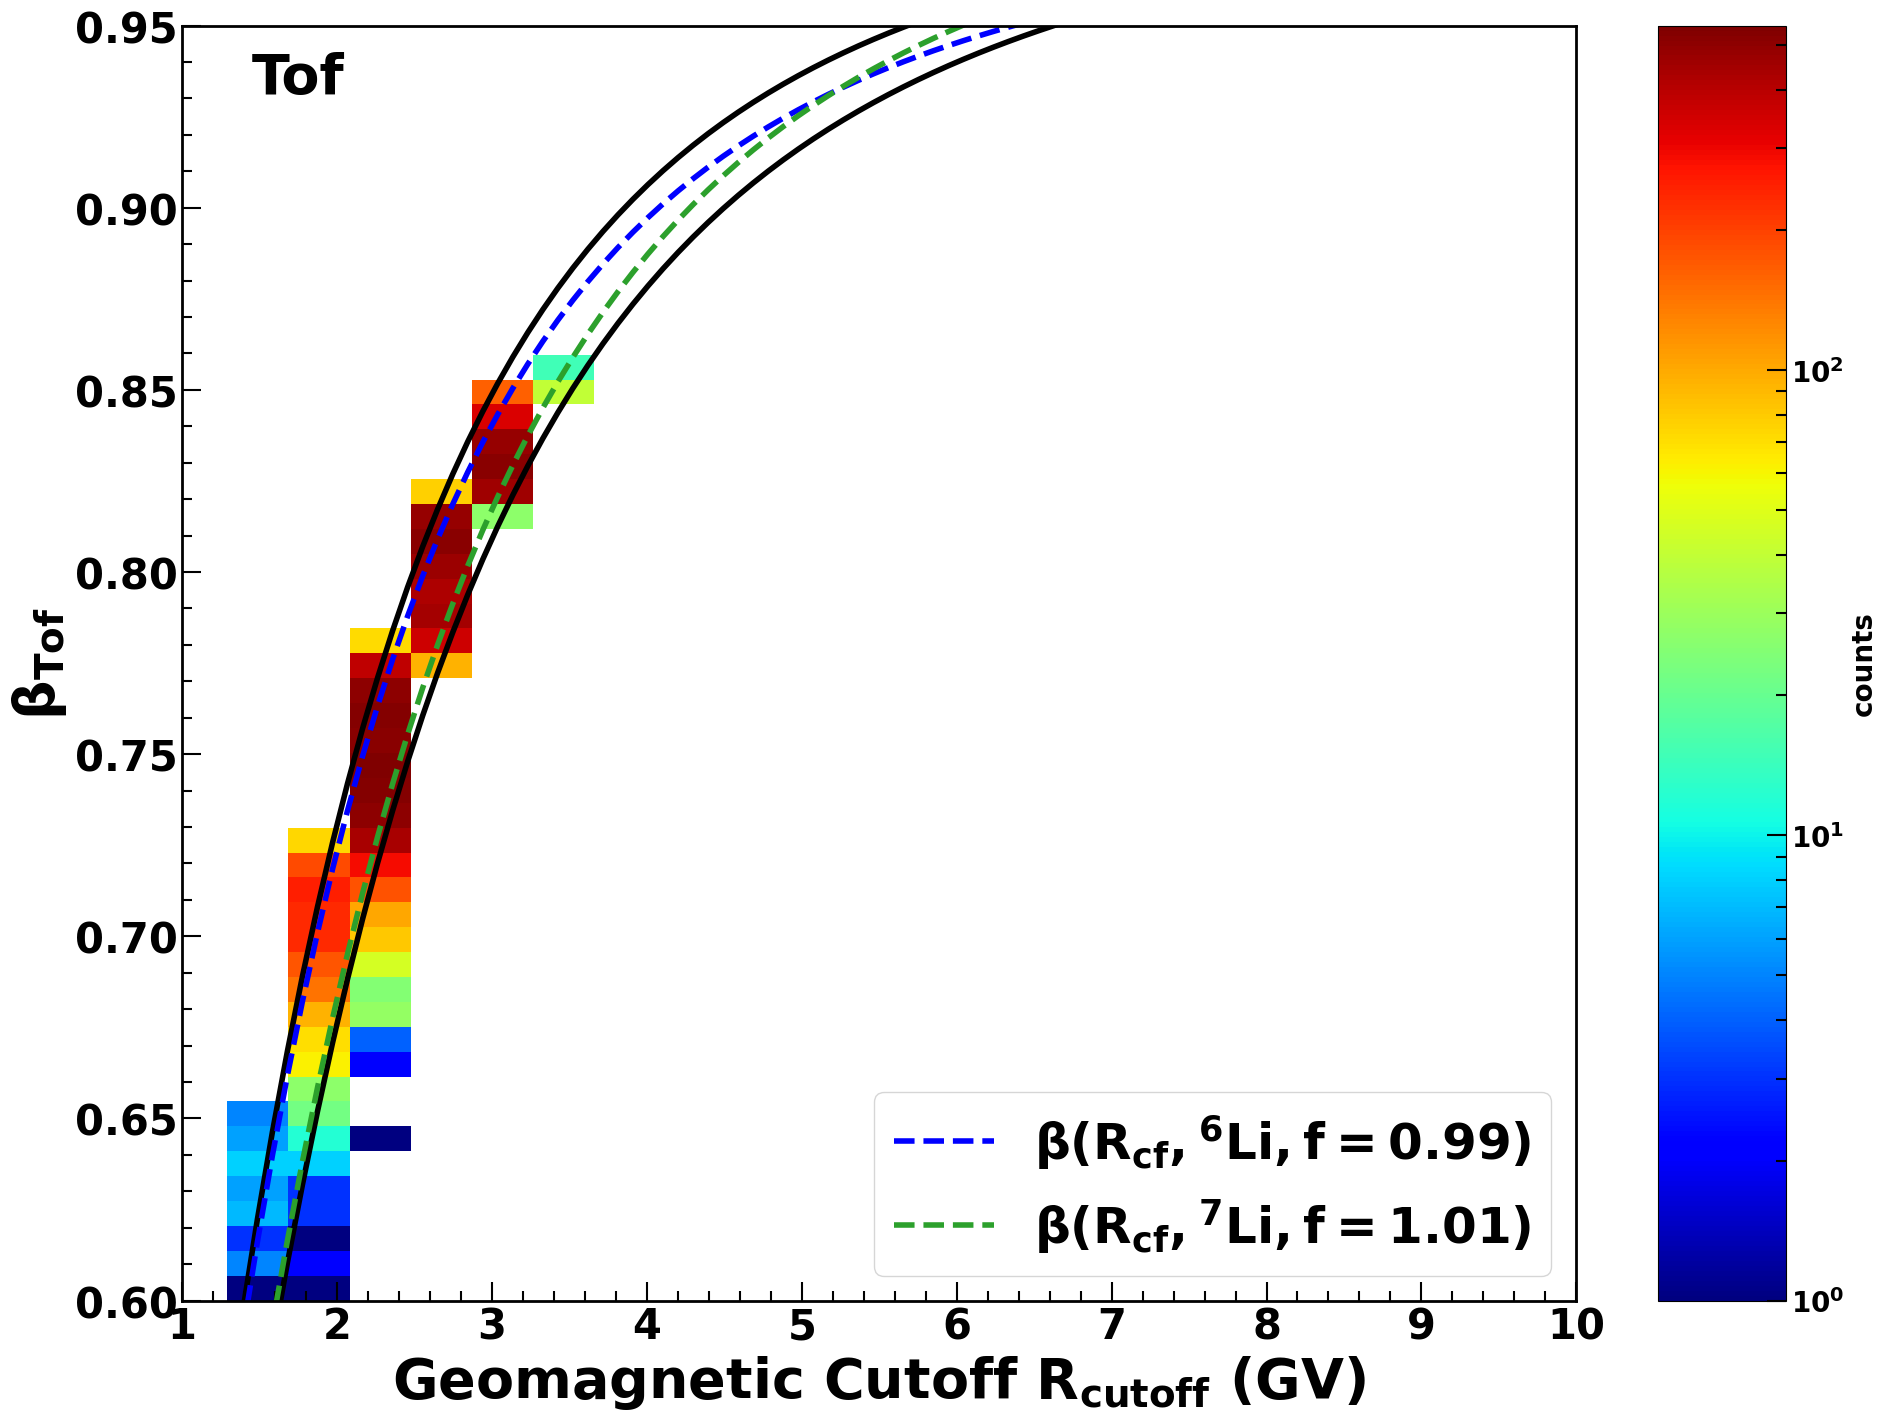

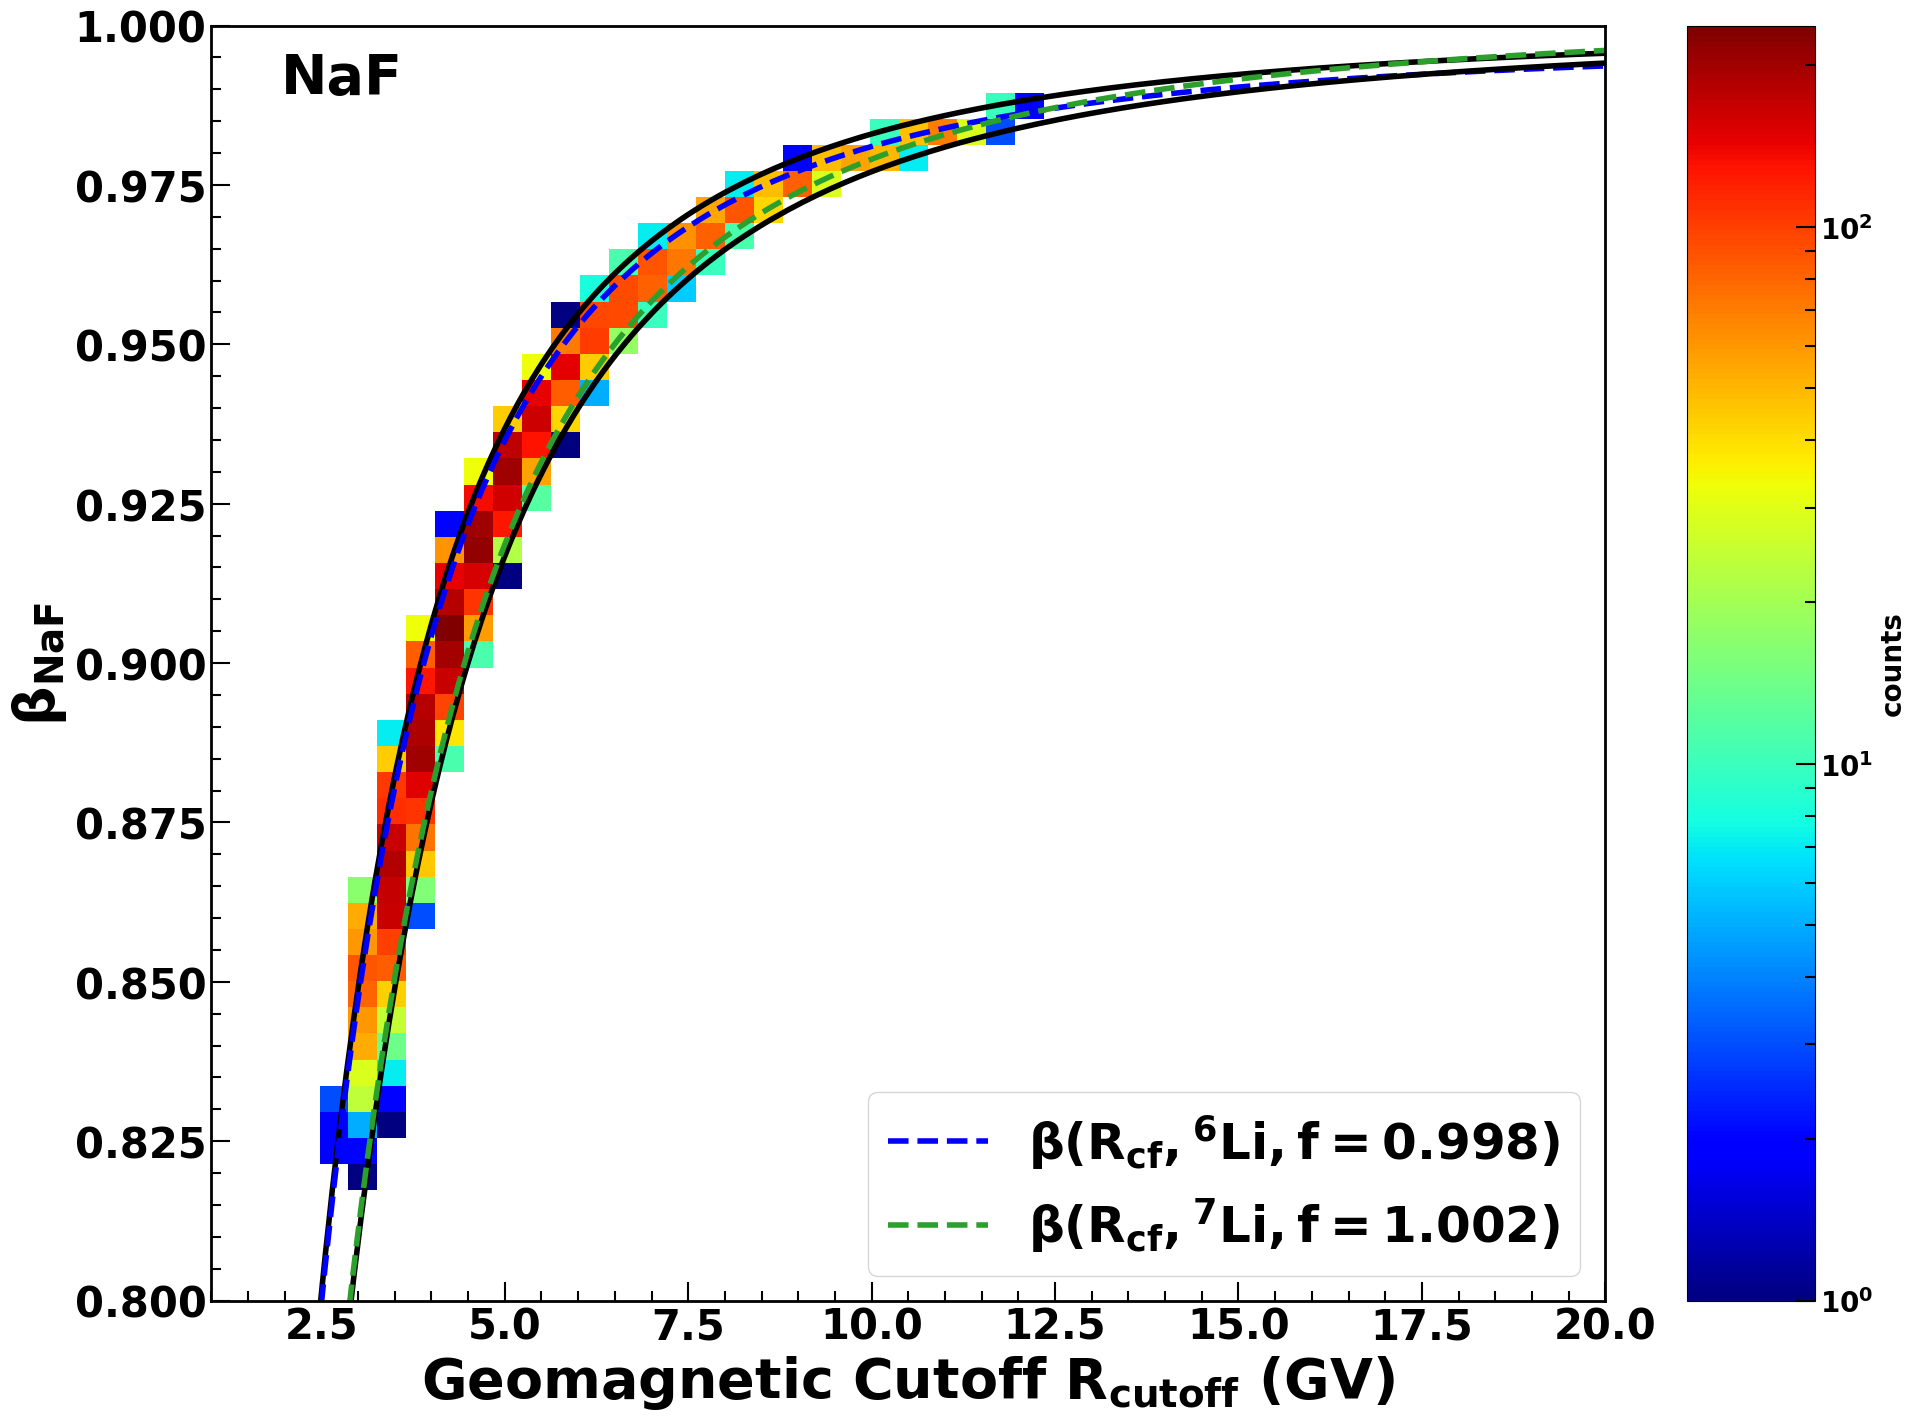

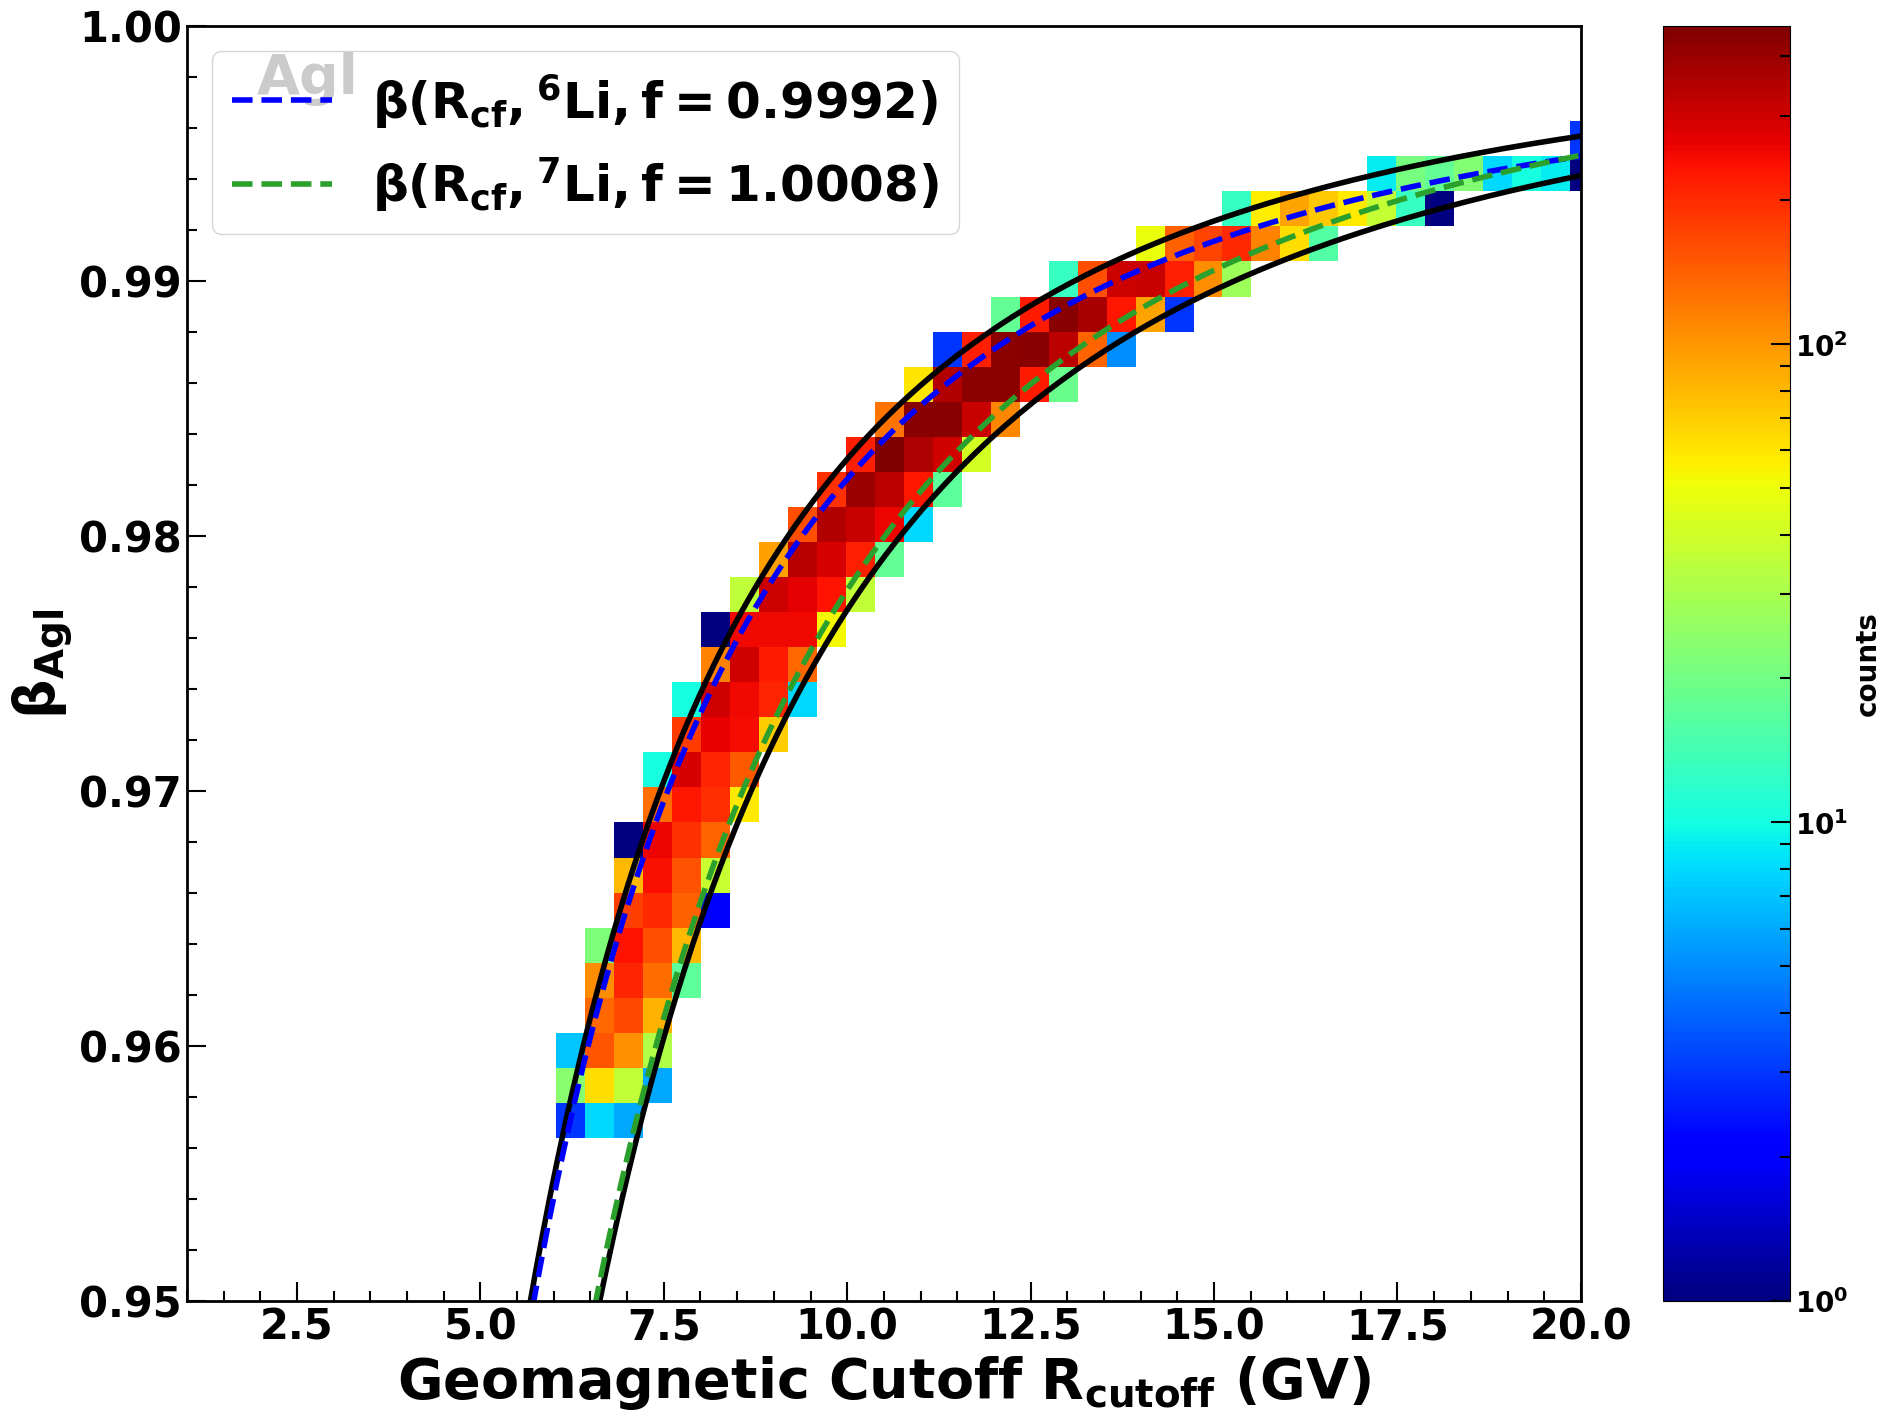

In [10]:
nuclei = 'Li'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkt1_mcgen2.npz'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li6hist_masscutoff_bkt2_mcrec.npz'
def get_hist_max(hist2d):
    yva = [1.5, 30]
    ybin_range = hist2d.binnings[1].get_indices(yva)
    
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[ybin_range[0]:ybin_range[1]]
    print(var_ycenter)
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    maxnum = np.zeros(len(var_xcenter)) 
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, ybin_range[0]:ybin_range[1]]
        if sum(ibin_fitdata) != 0: 
            maxnum[binx] = var_ycenter[np.argmax(ibin_fitdata)]
                                                                                                                                         
    return maxnum

detectors = ['Tof', 'NaF', 'Agl']
betalim = {'Tof':[0.6, 0.95], 'NaF':[0.8, 1.0], 'Agl':[0.95, 1.0]}
xriglim = {'Tof':[1, 10], 'NaF':[1, 20], 'Agl':[1, 20]}

rig_gen = np.linspace(1, 30, 300)
beta_iso = {}
deltabeta = {}
beta_iso_delta = {dec: {} for dec in detectors}
factor_up = {'Tof': 0.99,  'NaF': 0.998, 'Agl': 0.9992}                                                                                                                                                                            
factor_low = {'Tof': 1.01,  'NaF': 1.002, 'Agl': 1.0008}   
beta_iso_safetyfactor = {}

for iso in ISOTOPES['Li']:
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    beta_iso_safetyfactor[iso] = calc_beta(rig_gen*1.1, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    for dec in detectors:
        #deltabeta[dec] = np.poly1d(df_probpars[dec]['mean'])(np.log(beta_iso[iso]))
        #deltabeta[dec][deltabeta[dec]<0] = 0.0001
        beta_iso_delta[dec][iso] = beta_iso[iso] #+ deltabeta[dec]
        
def linear_func(x, a, b):
    return a * x + b

for dec in detectors:
    with np.load(file_data) as npzfile:
        hist2d = Histogram.from_file(npzfile, f"LiISS_{dec}_betavsRCutoff")  
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
                   ybinning=hist2d.binnings[1].edges[1:-1],
                   counts=hist2d.values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
        #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
        plot.set_xlabel(r"Geomagnetic Cutoff $\mathrm{R_{cutoff}}$ (GV)", fontsize=TEXTSIZE)
        plot.set_ylabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
        #plot.set_xscale('log')
        plot.set_xlim(xriglim[dec])
        plot.set_ylim(betalim[dec])

        plot.plot(rig_gen, beta_iso['Li6'], '-', linewidth=4, color='black')
        #plot.plot(rig_gen, beta_iso_safetyfactor['Li6'], '-', linewidth=4, color='pink')
        #plot.plot(rig_gen, beta_iso_safetyfactor['Li7'], '-', linewidth=4, color='pink')
        plot.plot(rig_gen, beta_iso['Li6']* factor_up[dec], '--', linewidth=4, color='blue', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{6}}Li , f={factor_up[dec]})}}$')
        plot.plot(rig_gen, beta_iso['Li7'], '-', linewidth=4, color='black')
        plot.plot(rig_gen, beta_iso['Li7']* factor_low[dec], '--', linewidth=4, color='tab:green', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{7}}Li , f={factor_low[dec]})}}$')
        plot.text(0.05, 0.98, '{}'.format(dec),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")      
        print(plotfile)
        plot.legend()
        savefig_tofile(fig, plotfile, f"{nuclei}_cutoff_betatoi_vs_cutoff_{dec}", 1)  

/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203


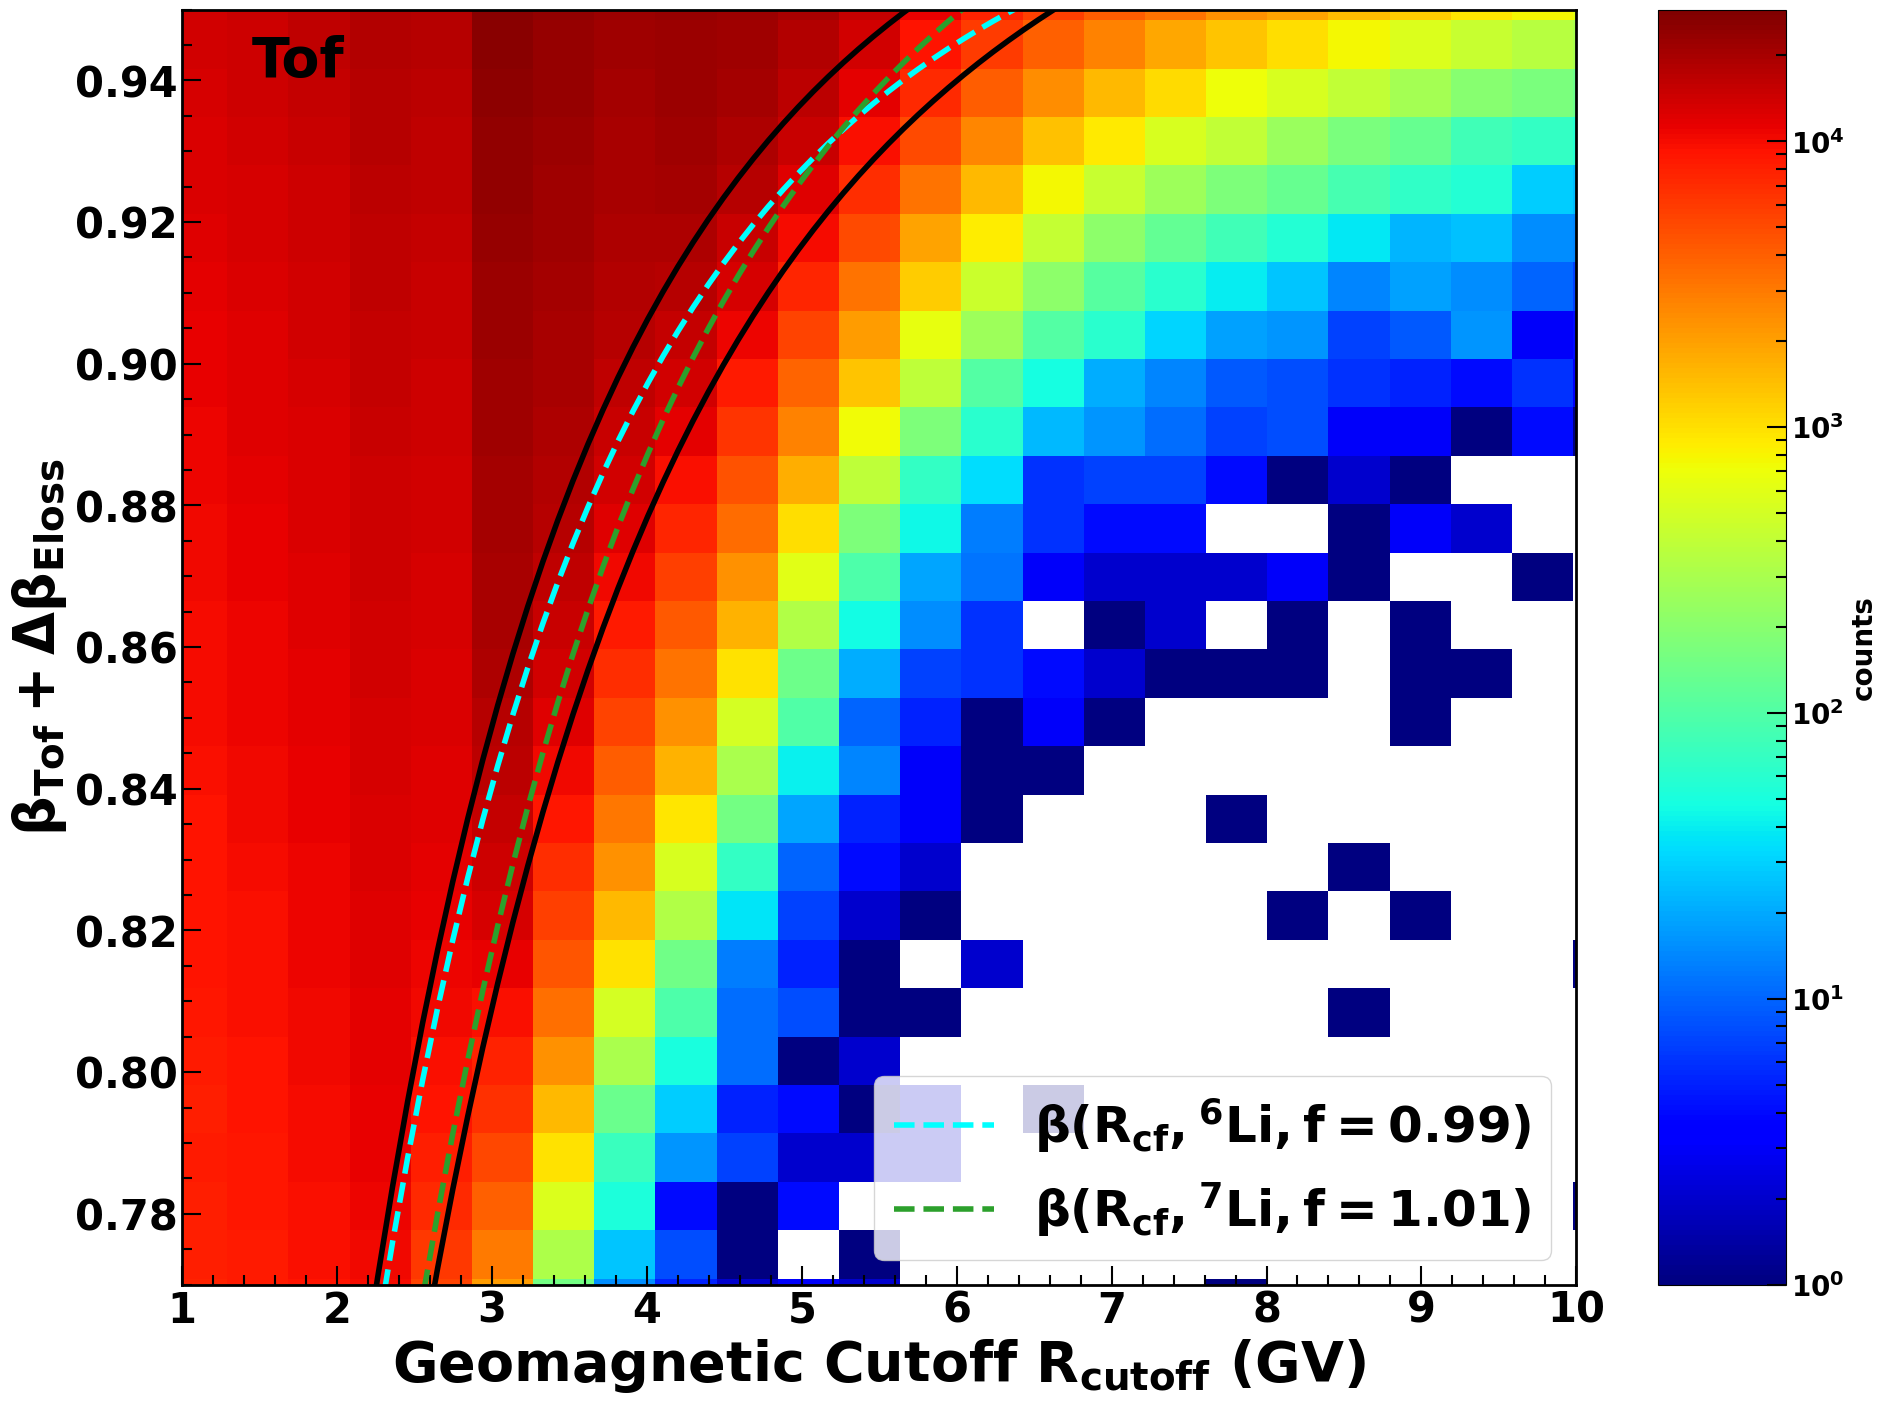

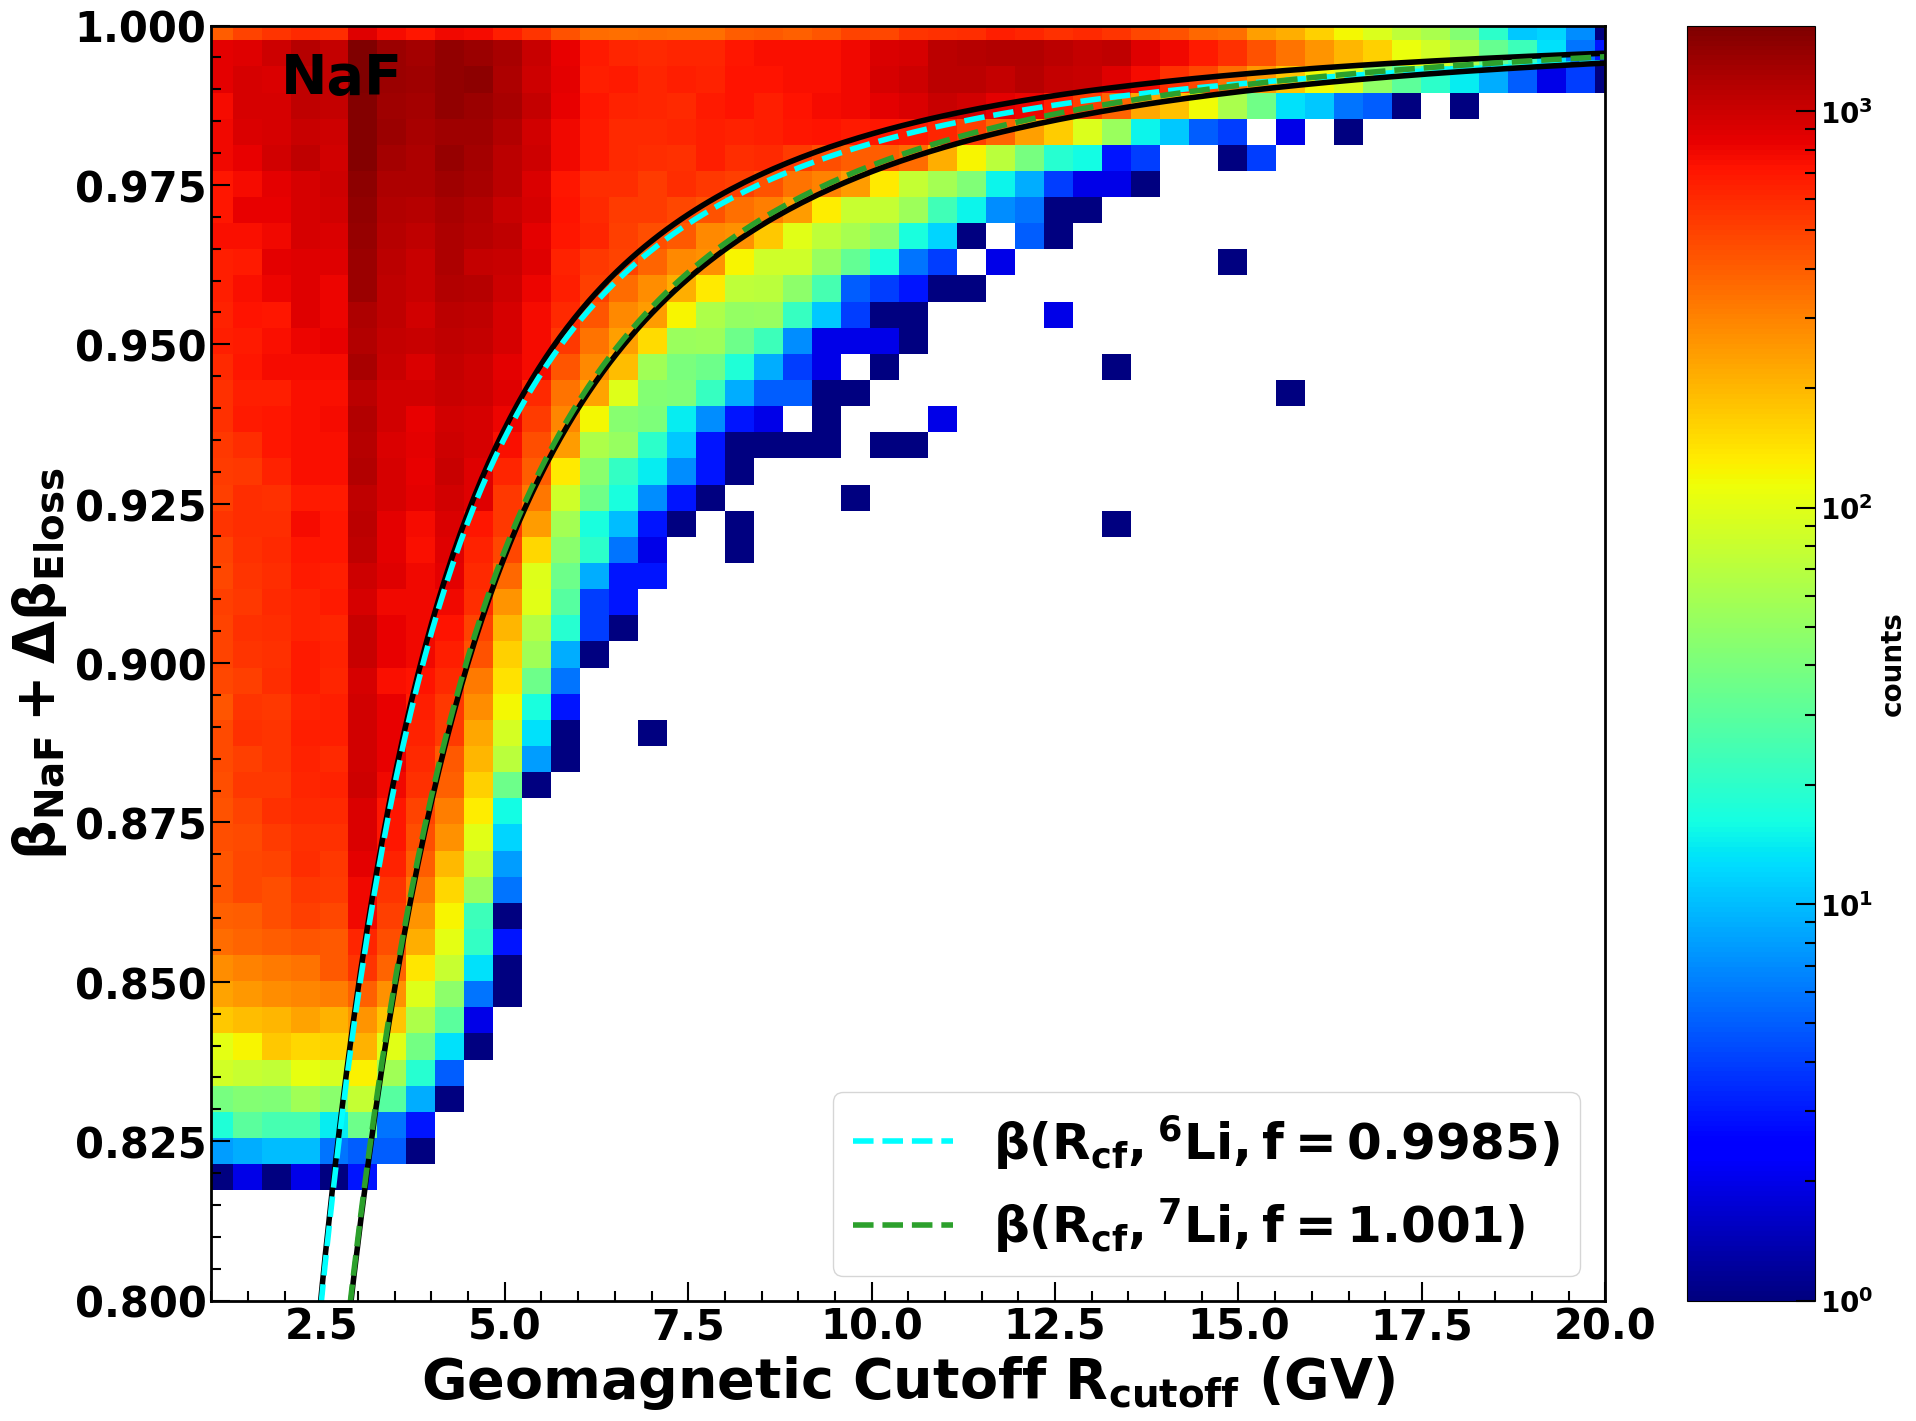

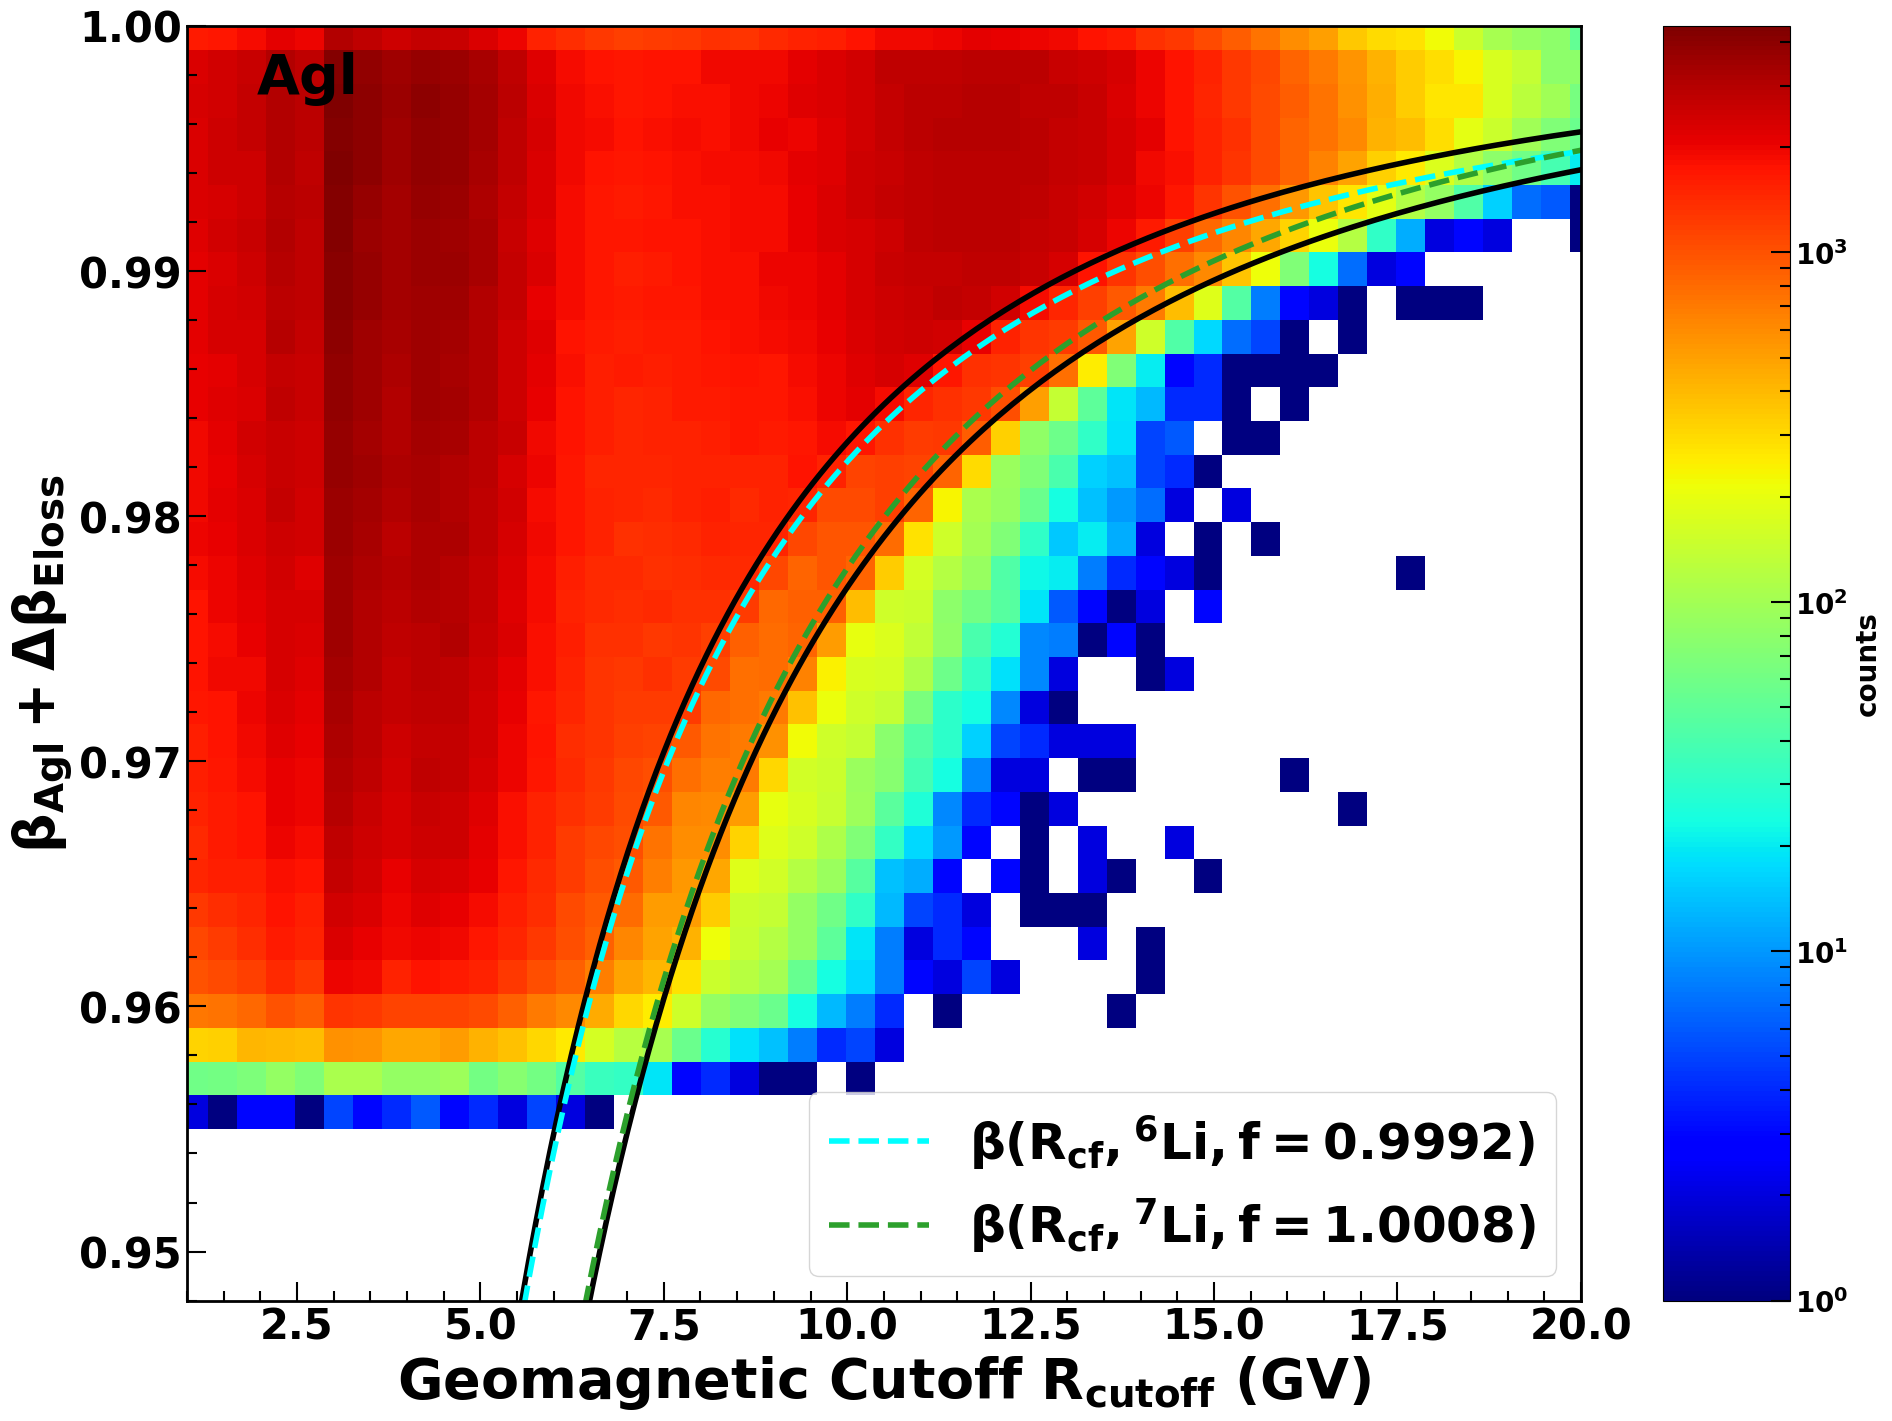

In [11]:
nuclei = 'Li'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkt1_mcgen3.npz'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li6hist_masscutoff_bkt2_mcrec.npz'
def get_hist_max(hist2d):
    yva = [1.5, 30]
    ybin_range = hist2d.binnings[1].get_indices(yva)
    
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[ybin_range[0]:ybin_range[1]]
    print(var_ycenter)
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    maxnum = np.zeros(len(var_xcenter)) 
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, ybin_range[0]:ybin_range[1]]
        if sum(ibin_fitdata) != 0: 
            maxnum[binx] = var_ycenter[np.argmax(ibin_fitdata)]
                                                                                                                                         
    return maxnum

detectors = ['Tof', 'NaF', 'Agl']
betalim = {'Tof':[0.77, 0.95], 'NaF':[0.8, 1.0], 'Agl':[0.948, 1.0]}

rig_gen = np.linspace(1, 30, 300)
beta_iso = {}
deltabeta = {}
beta_iso_delta = {dec: {} for dec in detectors}
factor_up = {'Tof': 0.99,  'NaF': 0.9985, 'Agl': 0.9992}                                                                                                                                                                            
factor_low = {'Tof': 1.01,  'NaF': 1.001, 'Agl': 1.0008}   
beta_iso_safetyfactor = {}

for iso in ISOTOPES['Li']:
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    beta_iso_safetyfactor[iso] = calc_beta(rig_gen*1.1, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    for dec in detectors:
        #deltabeta[dec] = np.poly1d(df_probpars[dec]['mean'])(np.log(beta_iso[iso]))
        #deltabeta[dec][deltabeta[dec]<0] = 0.0001
        beta_iso_delta[dec][iso] = beta_iso[iso] #+ deltabeta[dec]
        
def linear_func(x, a, b):
    return a * x + b

for dec in detectors:
    with np.load(file_data) as npzfile:
        hist2d = Histogram.from_file(npzfile, f"LiISS_{dec}_betavsRMaxCutoff")  
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
                   ybinning=hist2d.binnings[1].edges[1:-1],
                   counts=hist2d.values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
        #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
        plot.set_xlabel(r"Geomagnetic Cutoff $\mathrm{R_{cutoff}}$ (GV)", fontsize=TEXTSIZE)
        plot.set_ylabel(rf'$\mathrm{{\beta_{{{dec}}} + \Delta\beta_{{Eloss}} }}$', fontsize=TEXTSIZE)
        #plot.set_xscale('log')
        plot.set_xlim(xriglim[dec])
        
        #plot.set_yscale('log')
        plot.set_ylim(betalim[dec])
        #plot.set_xscale('log')
        
        plot.plot(rig_gen, beta_iso['Li6'], '-', linewidth=4, color='black')
        #plot.plot(rig_gen, beta_iso_safetyfactor['Li6'], '-', linewidth=4, color='pink')
        #plot.plot(rig_gen, beta_iso_safetyfactor['Li7'], '-', linewidth=4, color='pink')
        plot.plot(rig_gen, beta_iso['Li6']* factor_up[dec], '--', linewidth=4, color='cyan', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{6}}Li , f={factor_up[dec]})}}$')
        plot.plot(rig_gen, beta_iso['Li7'], '-', linewidth=4, color='black')
        plot.plot(rig_gen, beta_iso['Li7']* factor_low[dec], '--', linewidth=4, color='tab:green', label=rf'$\mathrm{{\beta(R_{{cf}}, ^{{7}}Li , f={factor_low[dec]})}}$')
        plot.text(0.05, 0.98, '{}'.format(dec),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")      
        print(plotfile)
        plot.legend(loc='lower right')
        savefig_tofile(fig, plotfile, f"{nuclei}_hist_betatoi_vs_cutoff_{dec}", 1)  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[7 7]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


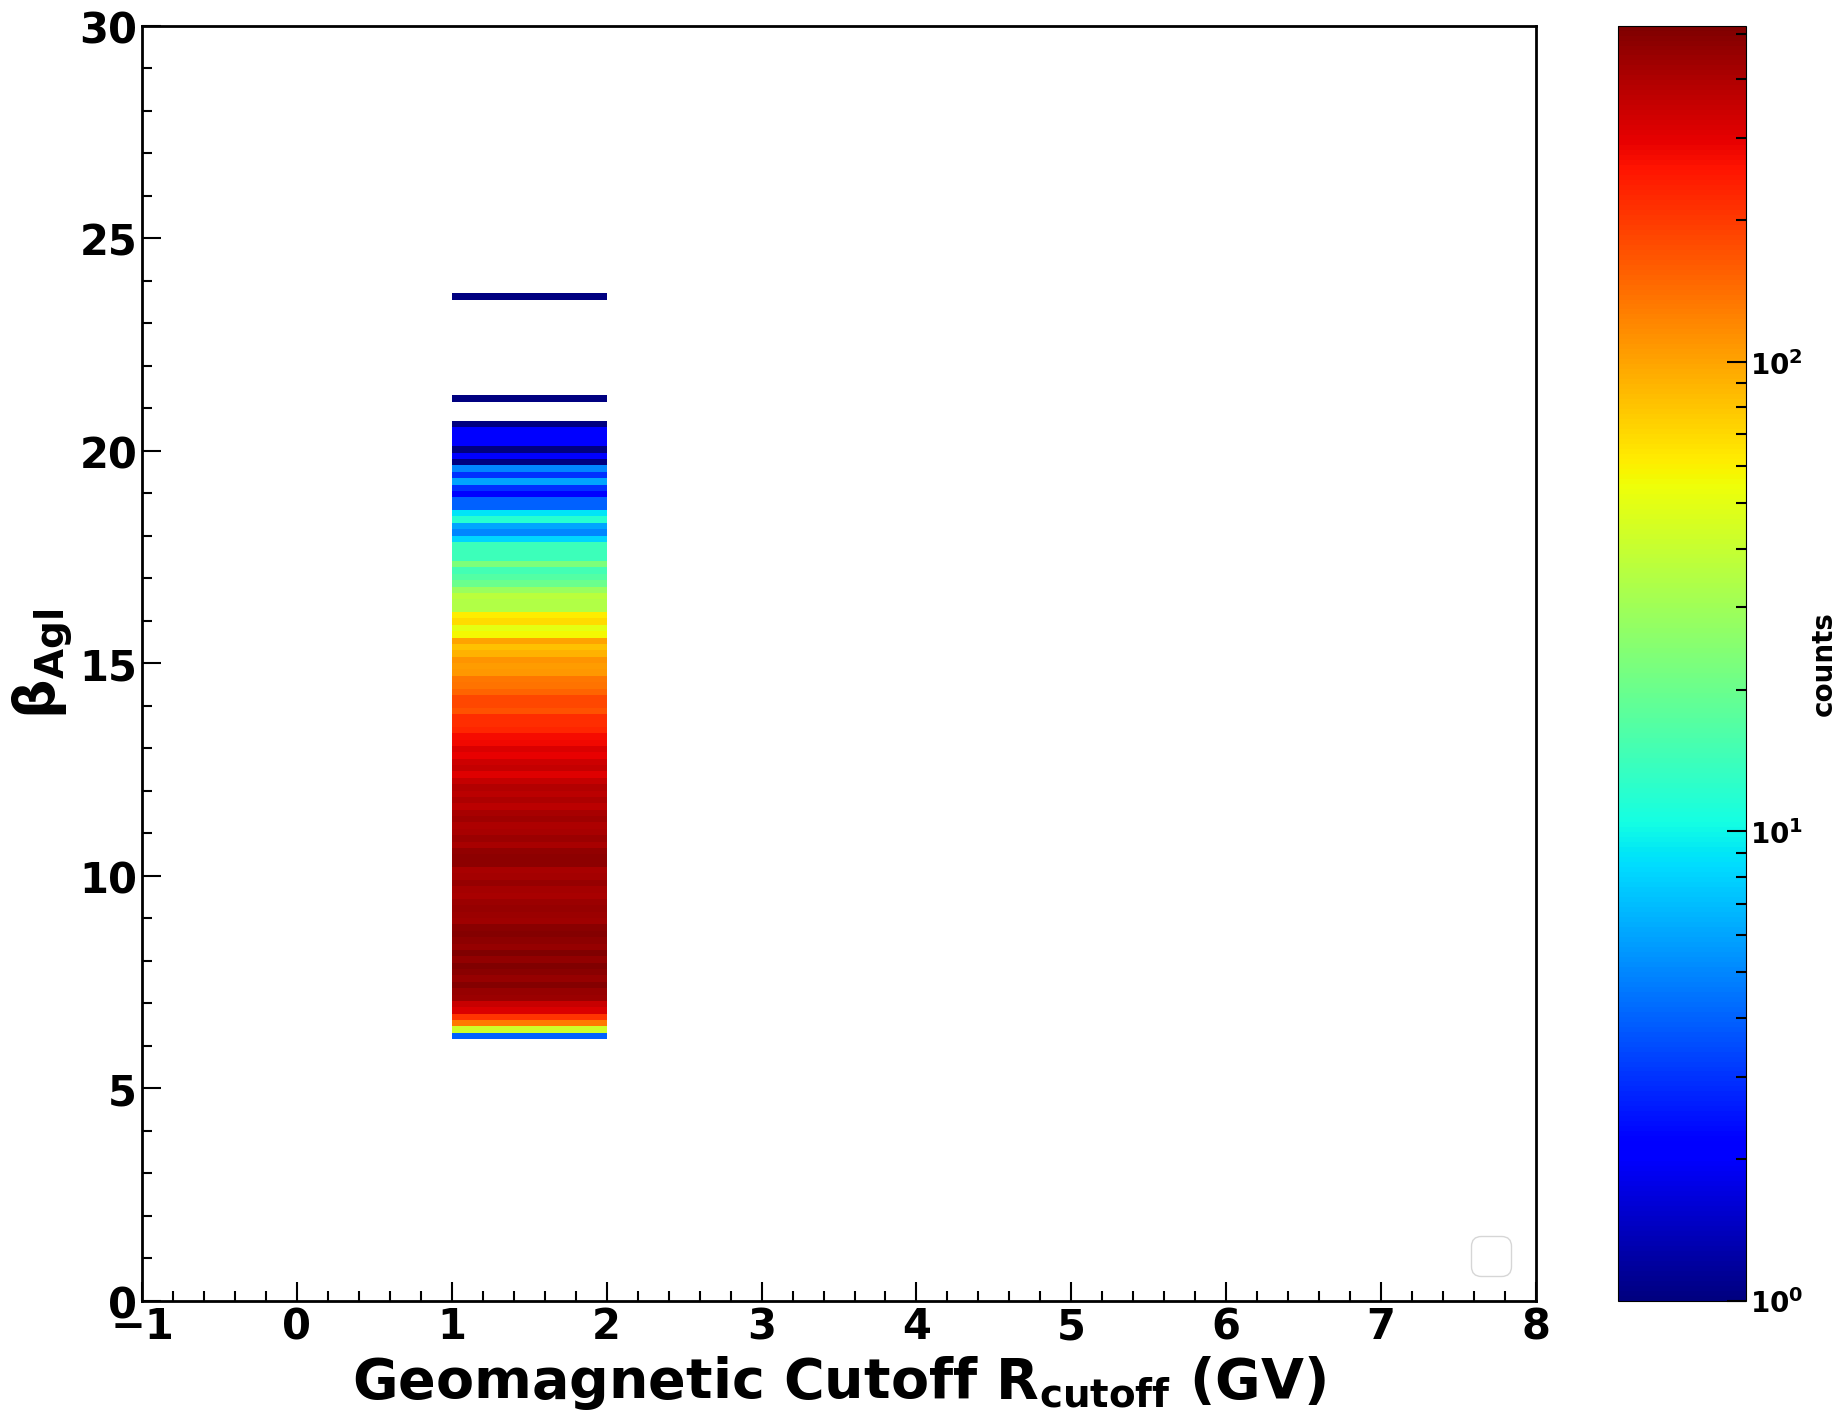

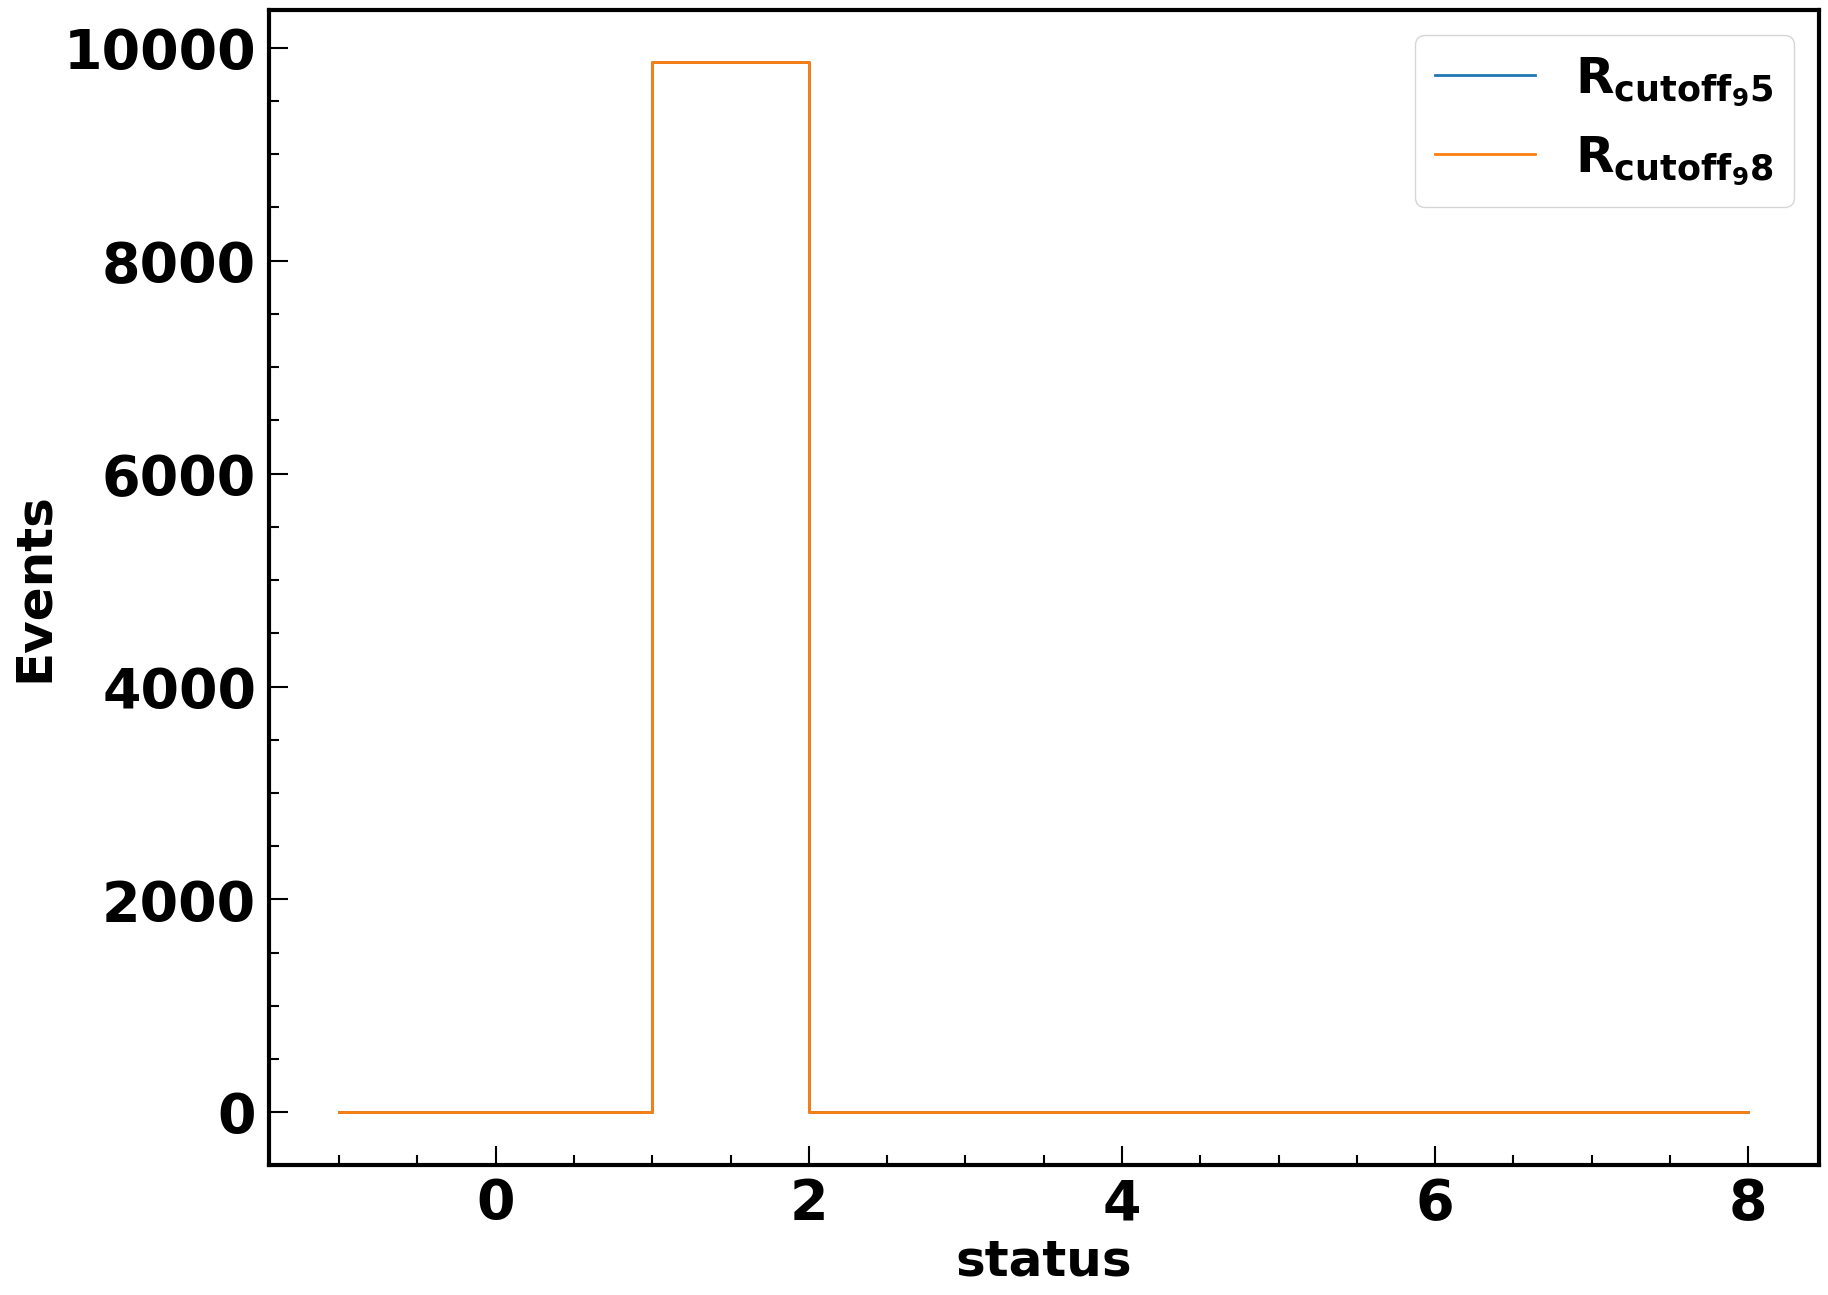

In [12]:
from tools.calculator import calc_beta_from_ekin
nuclei = 'Li'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_nobkt.npz'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li6hist_masscutoff_bkt2_mcrec.npz'
detectors = ['Tof', 'NaF', 'Agl']
betalim = {'Tof':[0.7, 1.0], 'NaF':[0.8, 1.0], 'Agl':[0.95, 1.0]}

for dec in ['Agl']:
    with np.load(file_data) as npzfile:
        hist2d = Histogram.from_file(npzfile, f"LiISS_{dec}_bkstat_vsrigcutoff")  
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
                   ybinning=hist2d.binnings[1].edges[1:-1],
                   counts=hist2d.values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
        #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
        plot.set_xlabel(r"Geomagnetic Cutoff $\mathrm{R_{cutoff}}$ (GV)", fontsize=TEXTSIZE)
        plot.set_ylabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
        #plot.set_ylim(betalim[dec])
        
        print(hist2d.binnings[1].get_indices([0.982, 0.989]))
        
        plot.legend(loc='lower right')
        savefig_tofile(fig, plotfile, f"{nuclei}_hist_betatoi_vs_cutoff_{dec}", 1)  
        
        #print(calc_beta_from_ekin(np.array([2.0, 3.0])))
        hist1d = hist2d.project(hist2d.binnings[1].get_indices([5, 10])[0], hist2d.binnings[1].get_indices([5, 10])[1], axis=1)
        hist1d_2 = hist2d.project(hist2d.binnings[1].get_indices([10, 20])[0], hist2d.binnings[1].get_indices([10, 20])[1], axis=1)
        #print(hist1d.binnings[0].edges)
        fig = plt.figure(figsize=(20, 15)) 
        plot = fig.subplots(1, 1)    
        set_plot_style(plot)
        #plot.set_xlim([1, 30])
        hist1d_2.values *= sum(hist1d.values)/sum(hist1d_2.values)
        plot_histogram_1d(plot, hist1d, style="mc", color='tab:blue', label=r'$\mathrm{R_{cutoff_95}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
        plot_histogram_1d(plot, hist1d_2, style="mc", color='tab:orange', label=r'$\mathrm{R_{cutoff_98}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
        
        plot.legend()
        plot.set_xlabel('status')
        #savefig_tofile(fig, plotfile, f"hist1d_cutoff_{dec}", show=True)    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


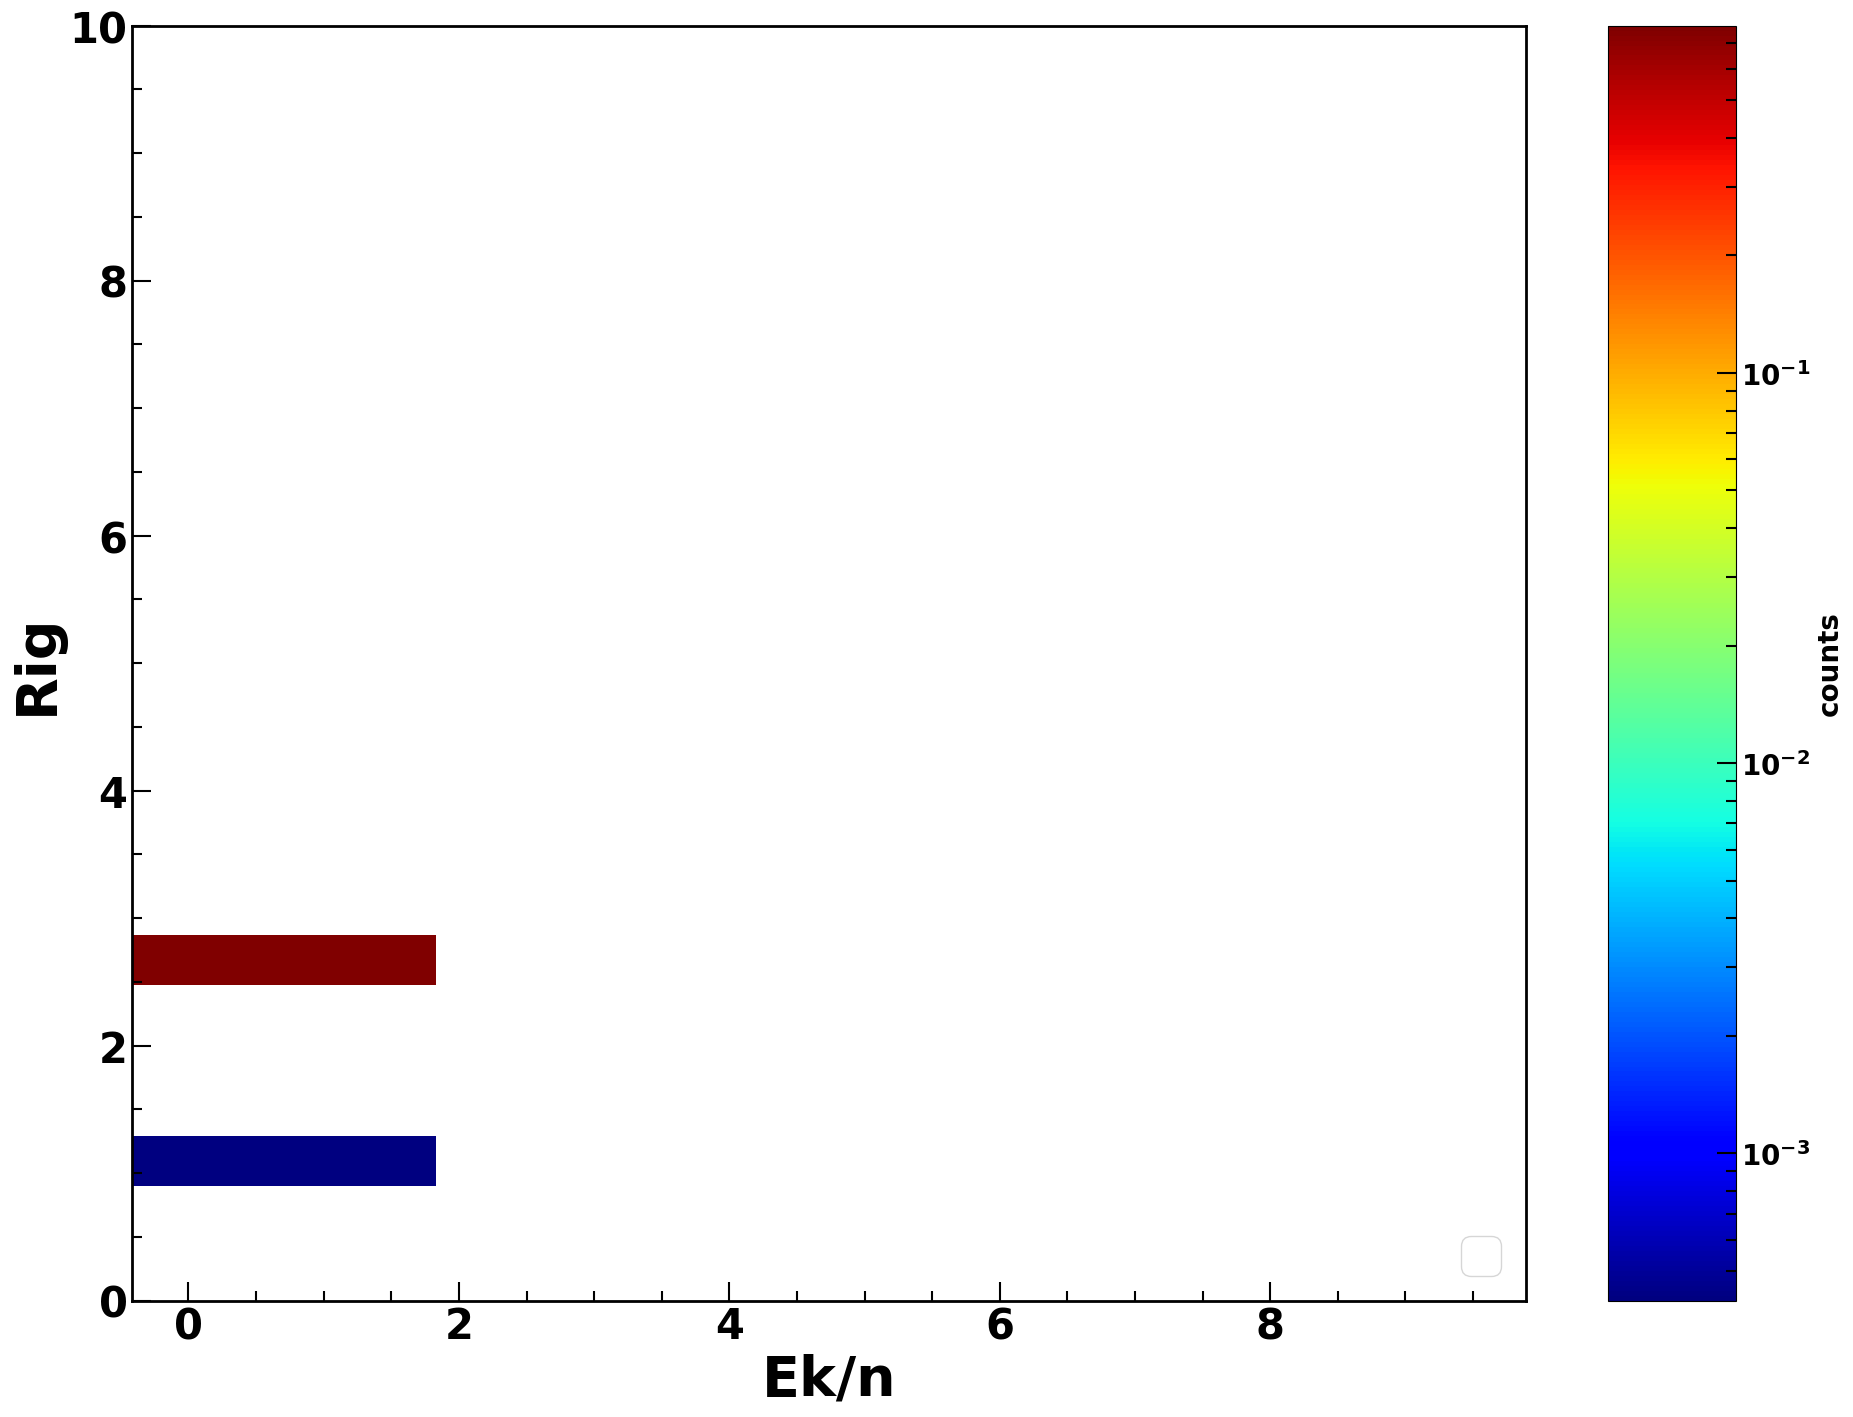

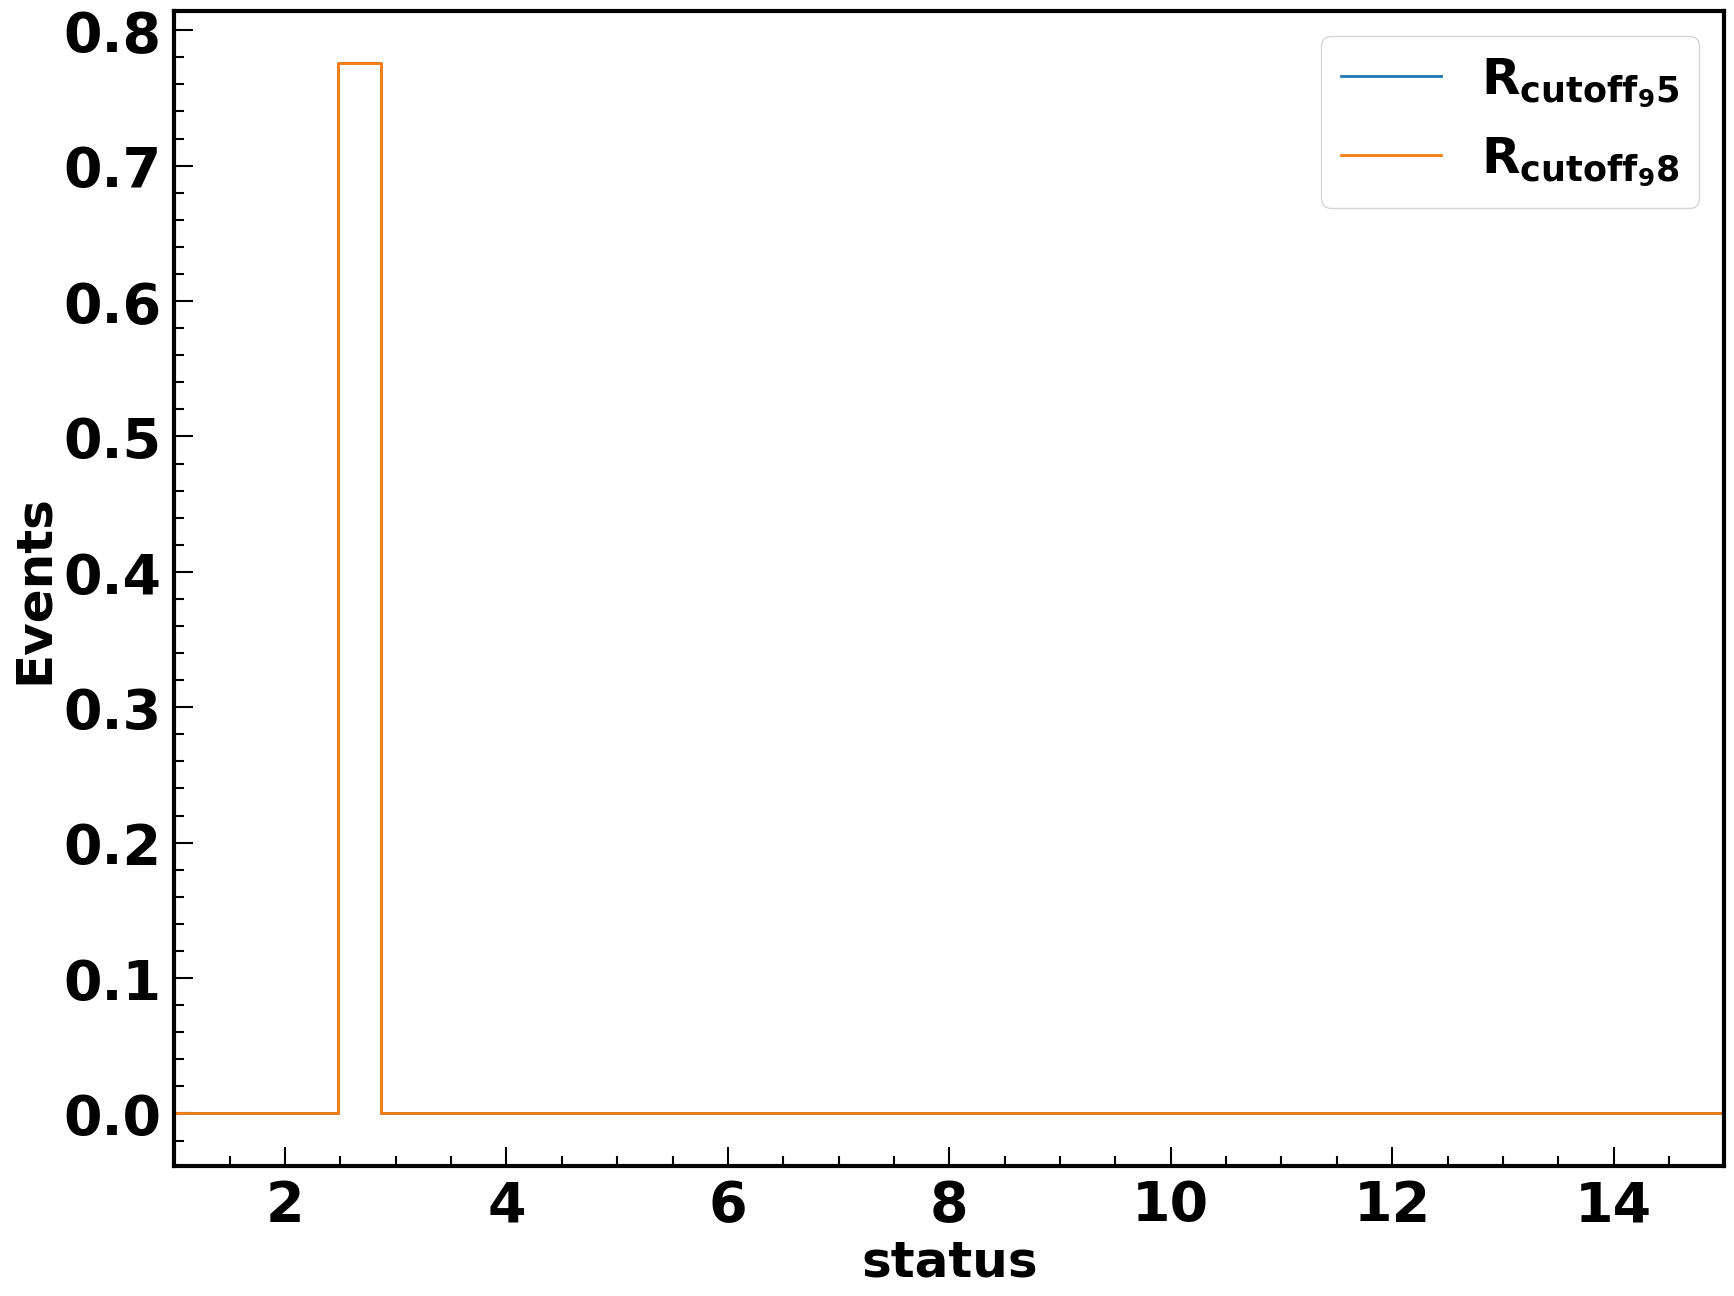

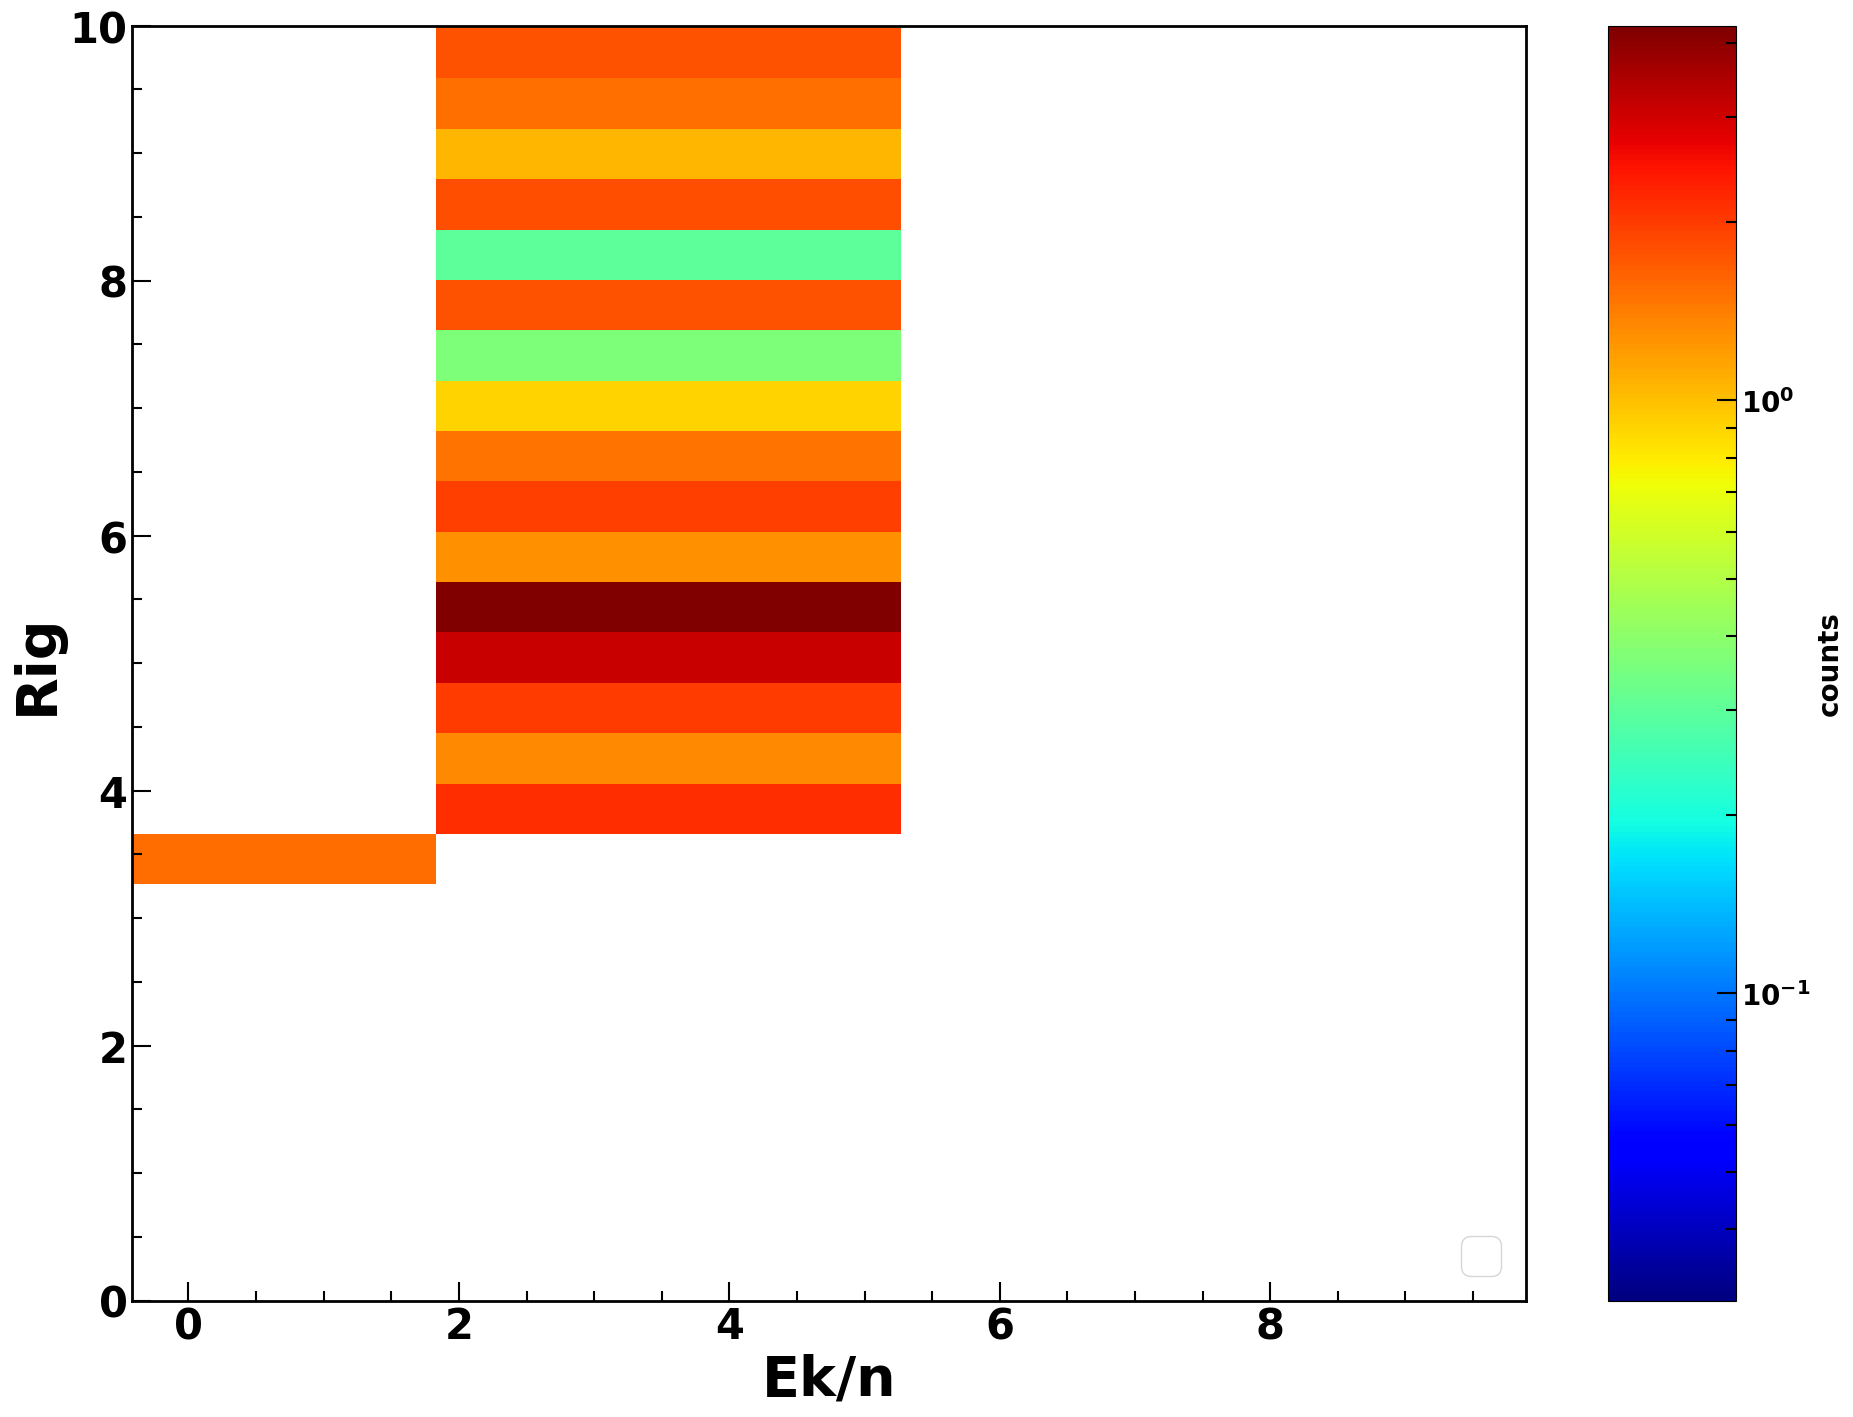

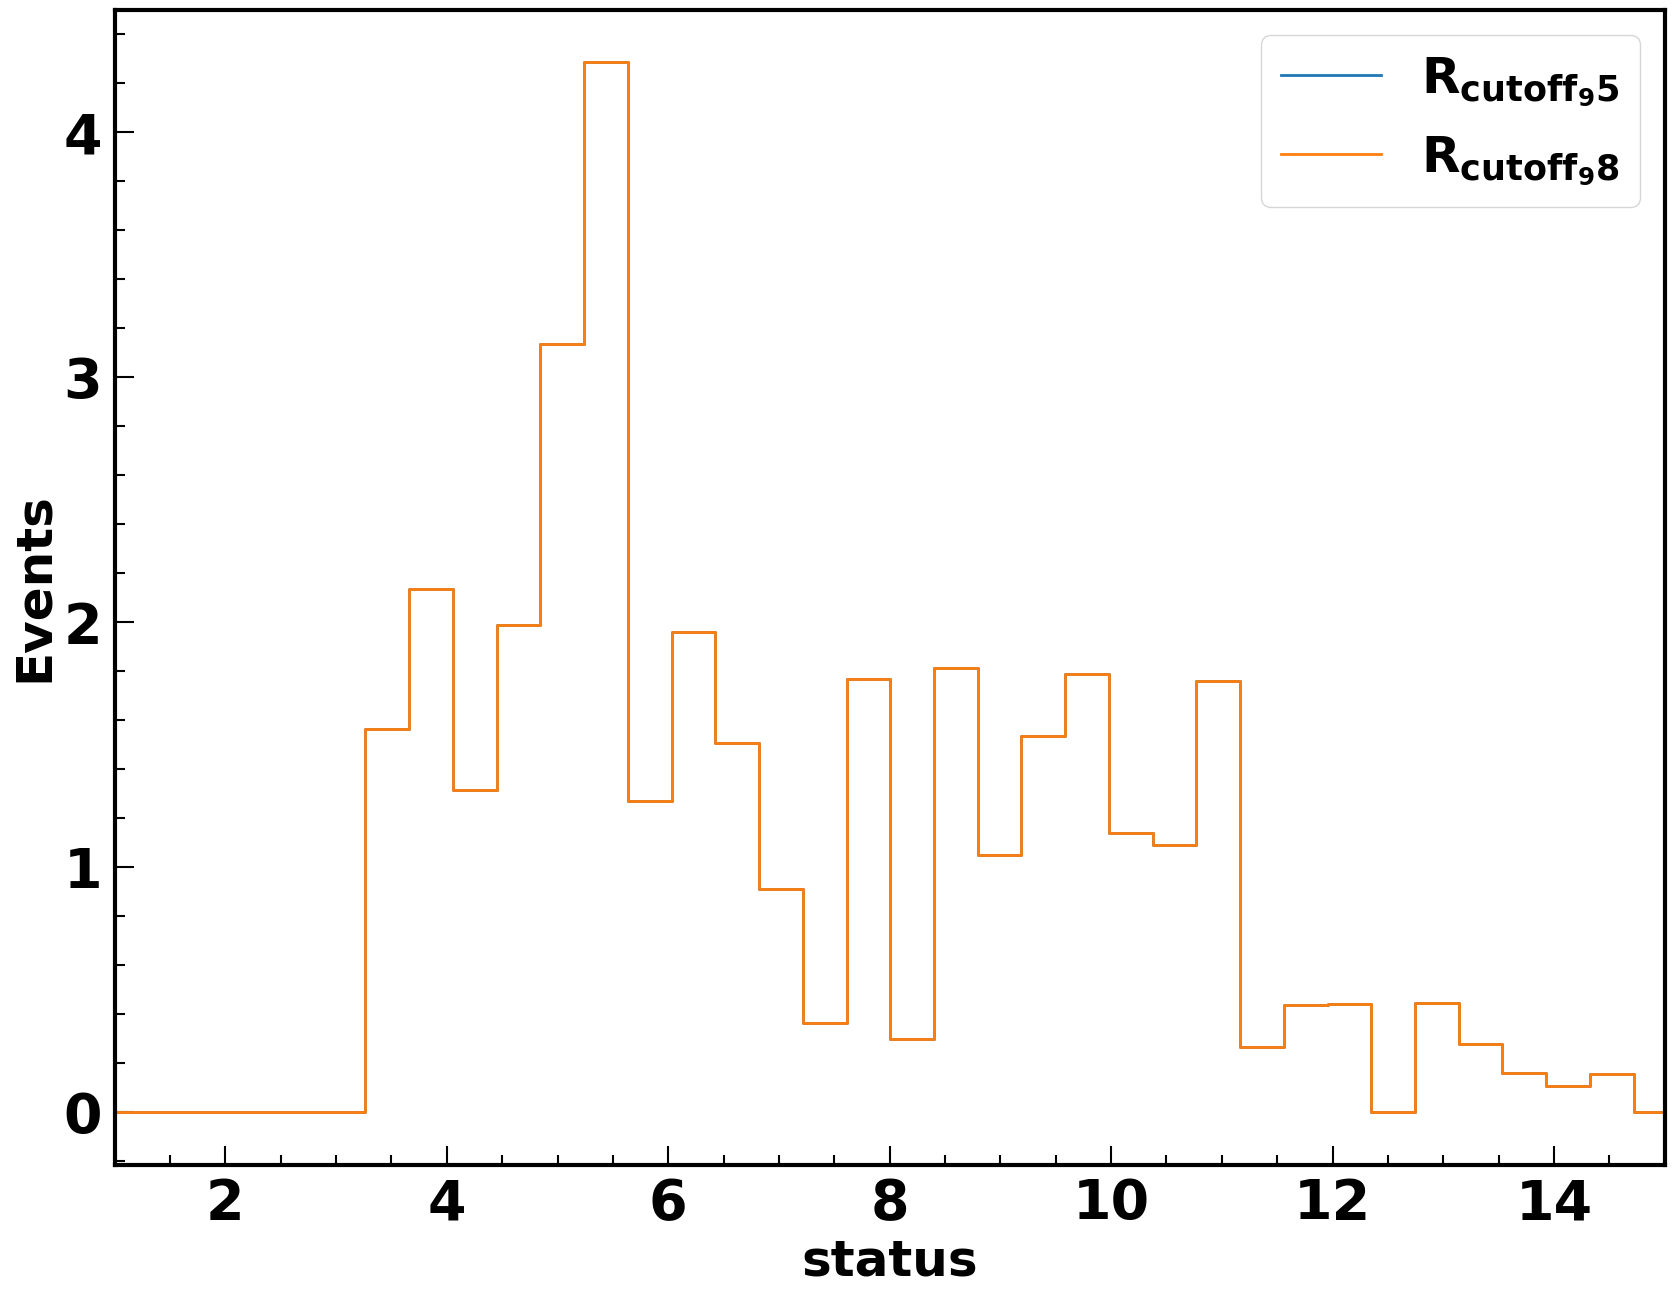

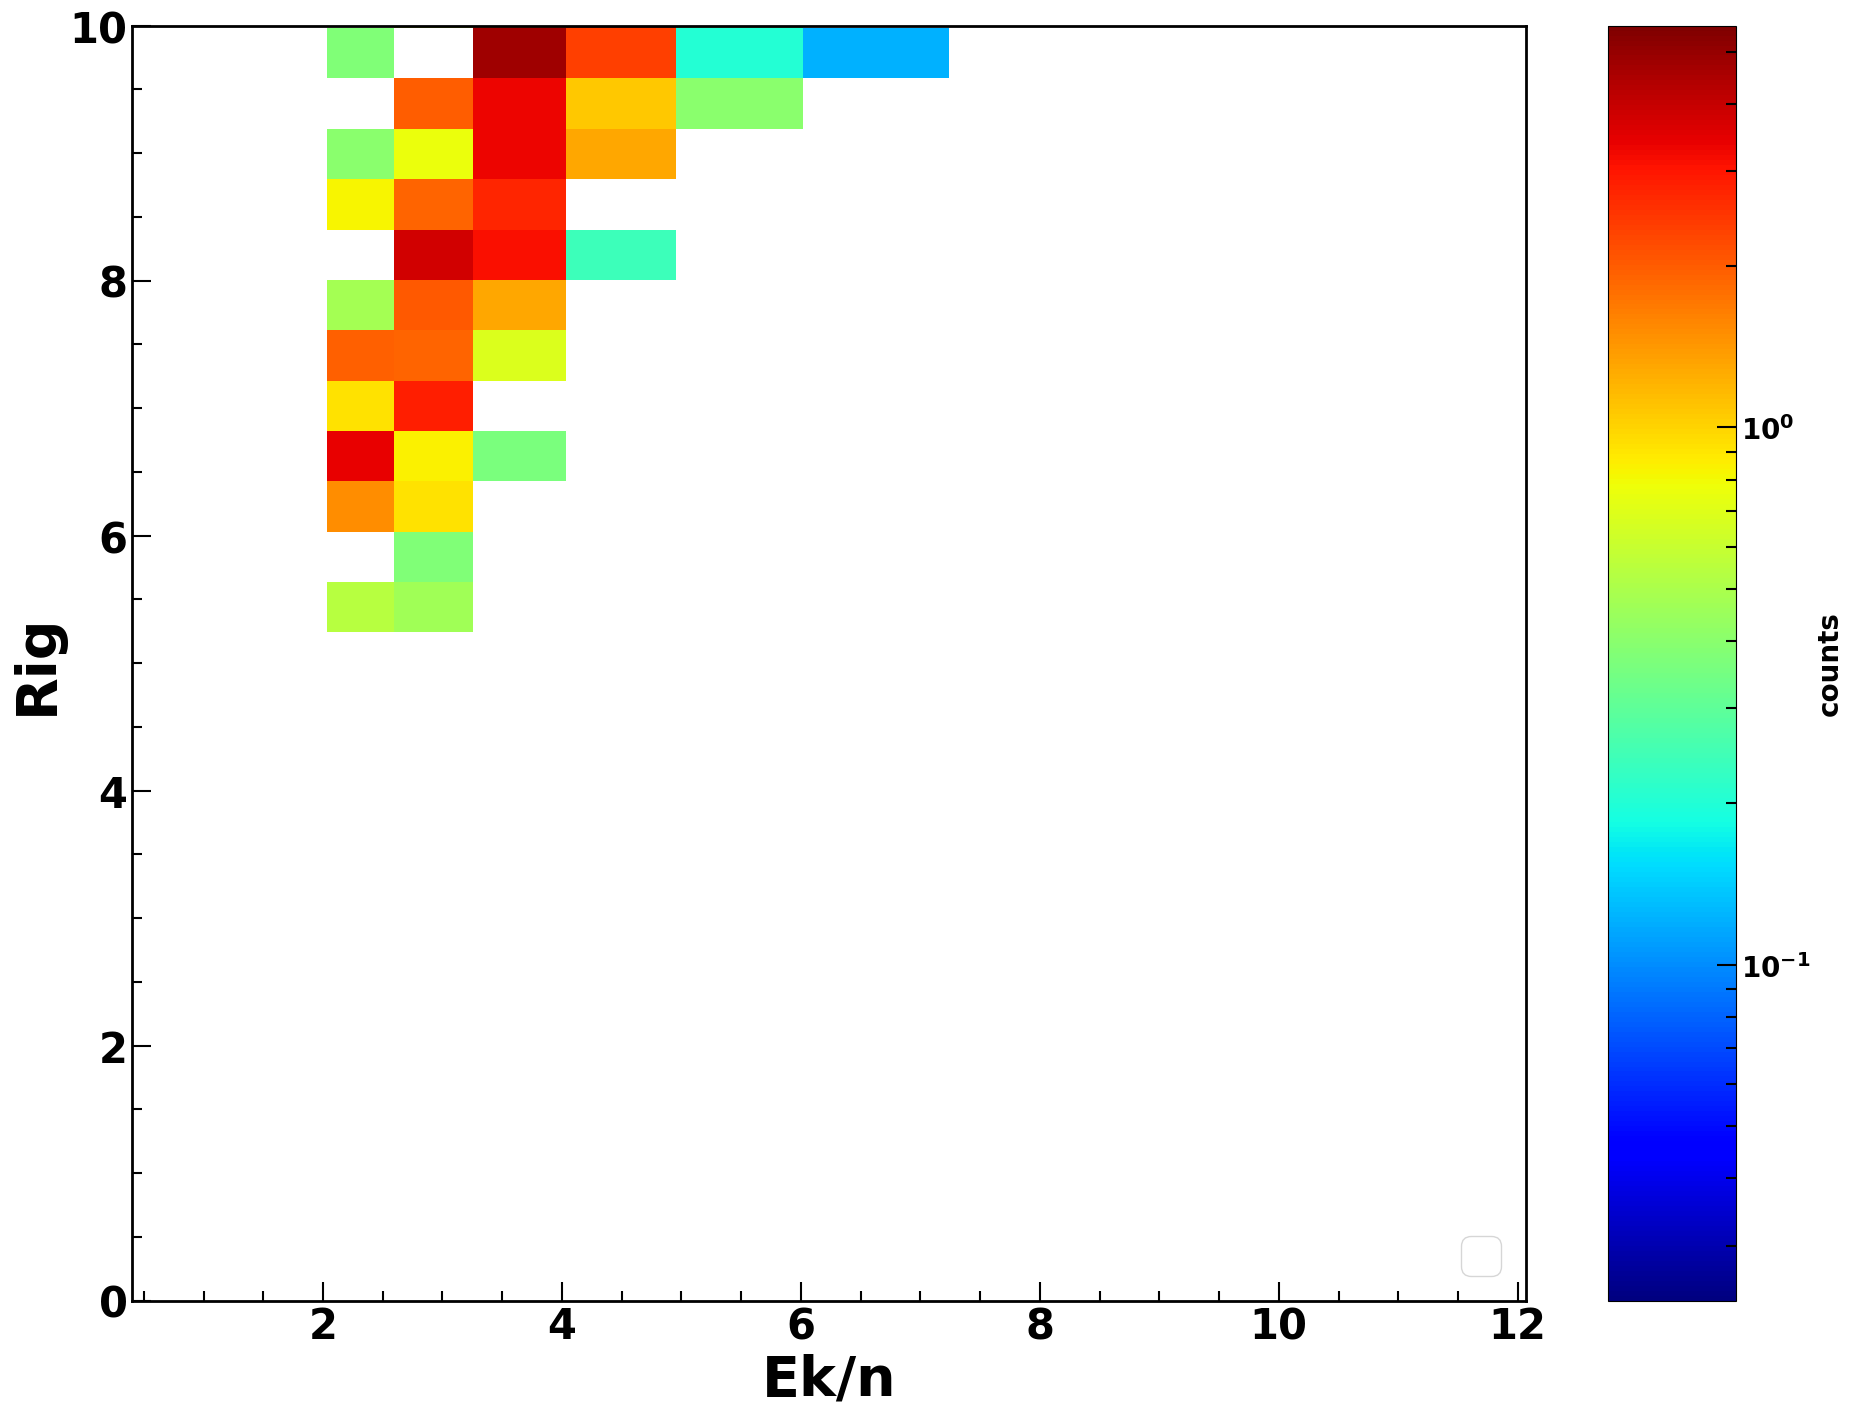

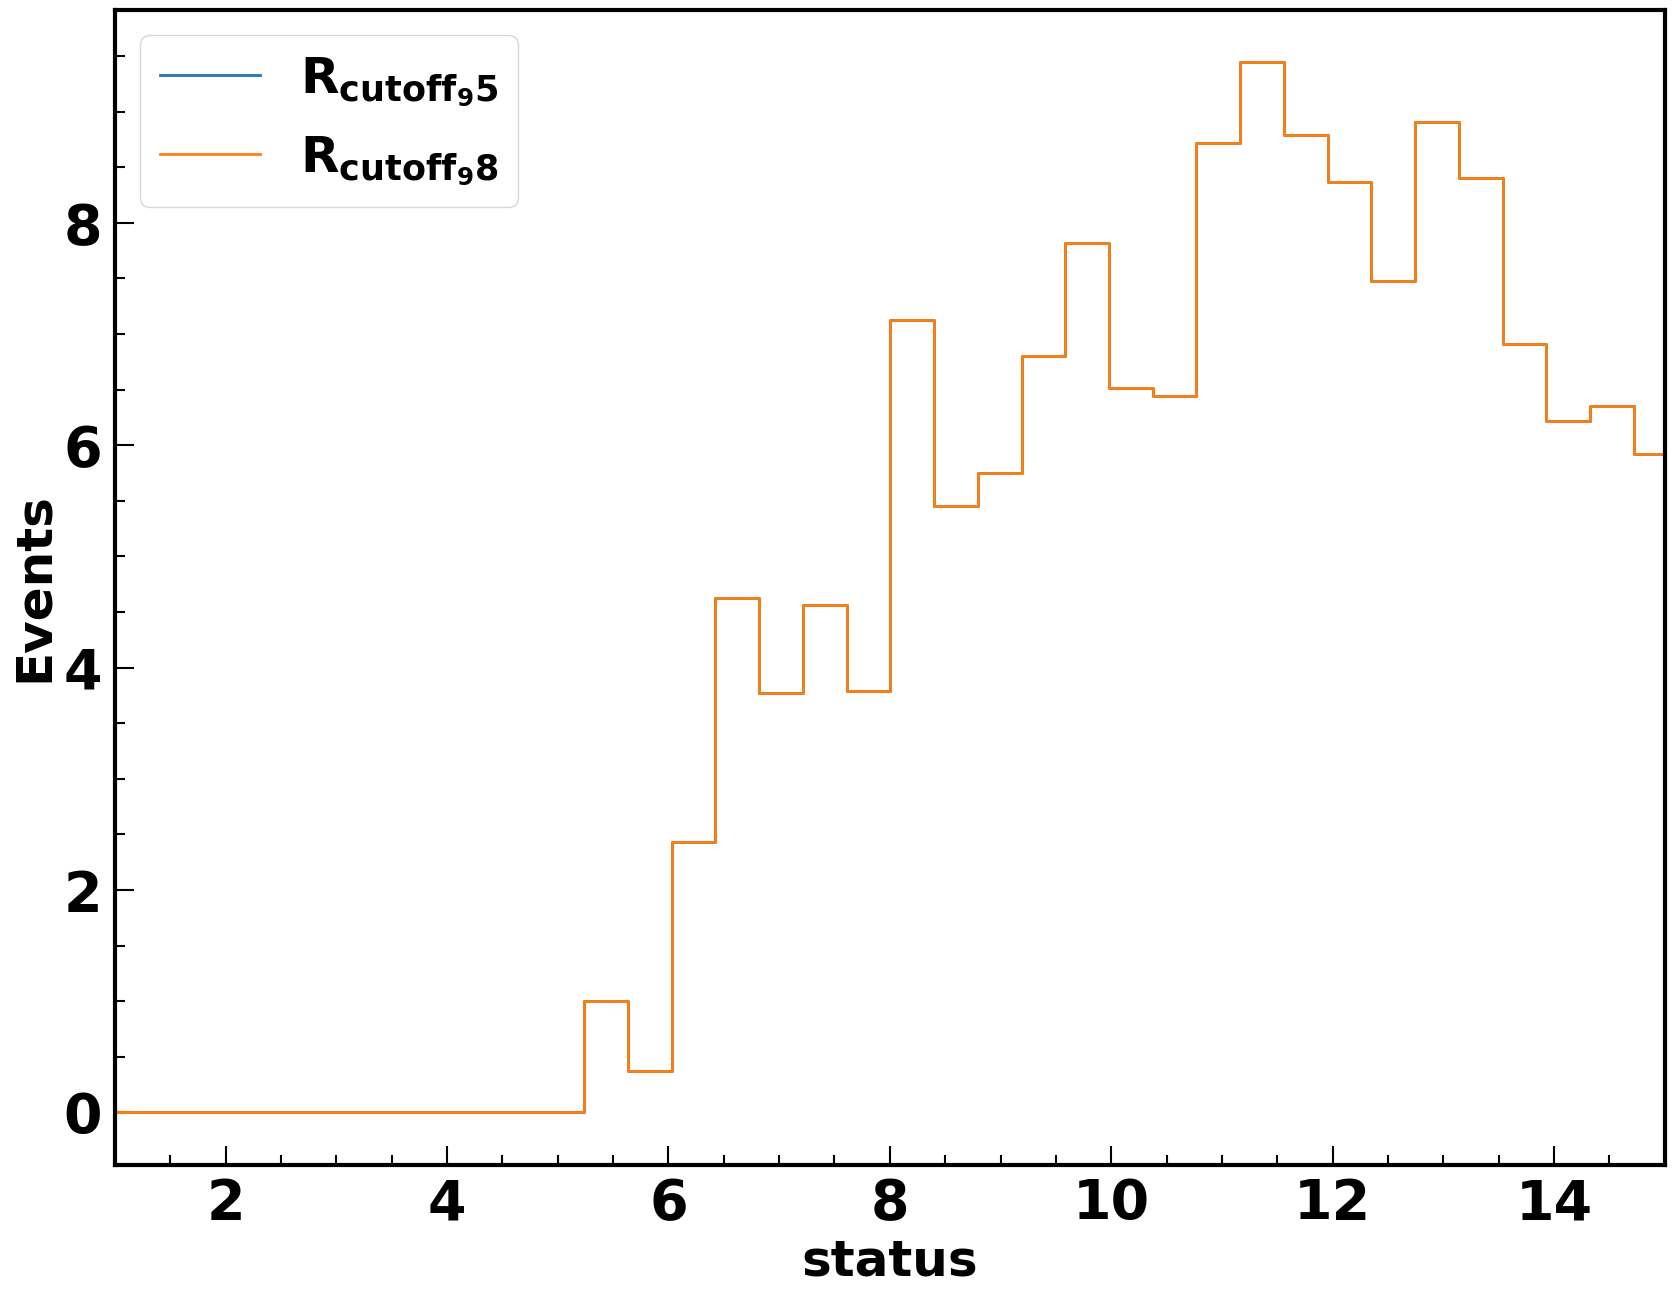

In [13]:
from tools.calculator import calc_beta_from_ekin
nuclei = 'Li'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkstatv17.npz'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li6hist_masscutoff_bkt2_mcrec.npz'
detectors = ['Tof', 'NaF', 'Agl']
betalim = {'Tof':[0.7, 1.0], 'NaF':[0.8, 1.0], 'Agl':[0.95, 1.0]}
hist1d_dobkt1 = {}
hist1d_dobkt12 = {}
for dec in detectors:
    with np.load(file_data) as npzfile:
        hist2d = Histogram.from_file(npzfile, f"Li7MC_{dec}_rigidity_cutoff")  
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
                   ybinning=hist2d.binnings[1].edges[1:-1],
                   counts=hist2d.values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
        #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
        plot.set_ylabel(r"Rig", fontsize=TEXTSIZE)
        #plot.set_xlabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
        plot.set_xlabel('Ek/n', fontsize=TEXTSIZE)
        plot.set_ylim([0, 10])
        
        print(hist2d.binnings[1].get_indices([0.982, 0.989]))
        
        plot.legend(loc='lower right')
        savefig_tofile(fig, plotfile, f"{nuclei}_hist_betatoi_vs_cutoff_{dec}", 1)  
        
        #print(calc_beta_from_ekin(np.array([2.0, 3.0])))
        hist1d_dobkt1[dec] = hist2d.project(hist2d.binnings[0].get_indices([0.5, 10])[0], hist2d.binnings[0].get_indices([0.5, 10])[1], axis=0)
        hist1d_dobkt12[dec] = hist2d.project(hist2d.binnings[0].get_indices([0.5, 10])[0], hist2d.binnings[0].get_indices([0.5, 10])[1], axis=0)
        #print(hist1d.binnings[0].edges)
        fig = plt.figure(figsize=(20, 15)) 
        plot = fig.subplots(1, 1)    
        set_plot_style(plot)
        plot.set_xlim([1, 15])
        hist1d_2.values *= sum(hist1d.values)/sum(hist1d_2.values)
        plot_histogram_1d(plot, hist1d_dobkt1[dec], style="mc", color='tab:blue', label=r'$\mathrm{R_{cutoff_95}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
        plot_histogram_1d(plot, hist1d_dobkt12[dec], style="mc", color='tab:orange', label=r'$\mathrm{R_{cutoff_98}}$', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
        
        plot.legend()
        plot.set_xlabel('status')
        #savefig_tofile(fig, plotfile, f"hist1d_cutoff_{dec}", show=True)    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2 2]


NameError: name 'hist1d_mcrec' is not defined

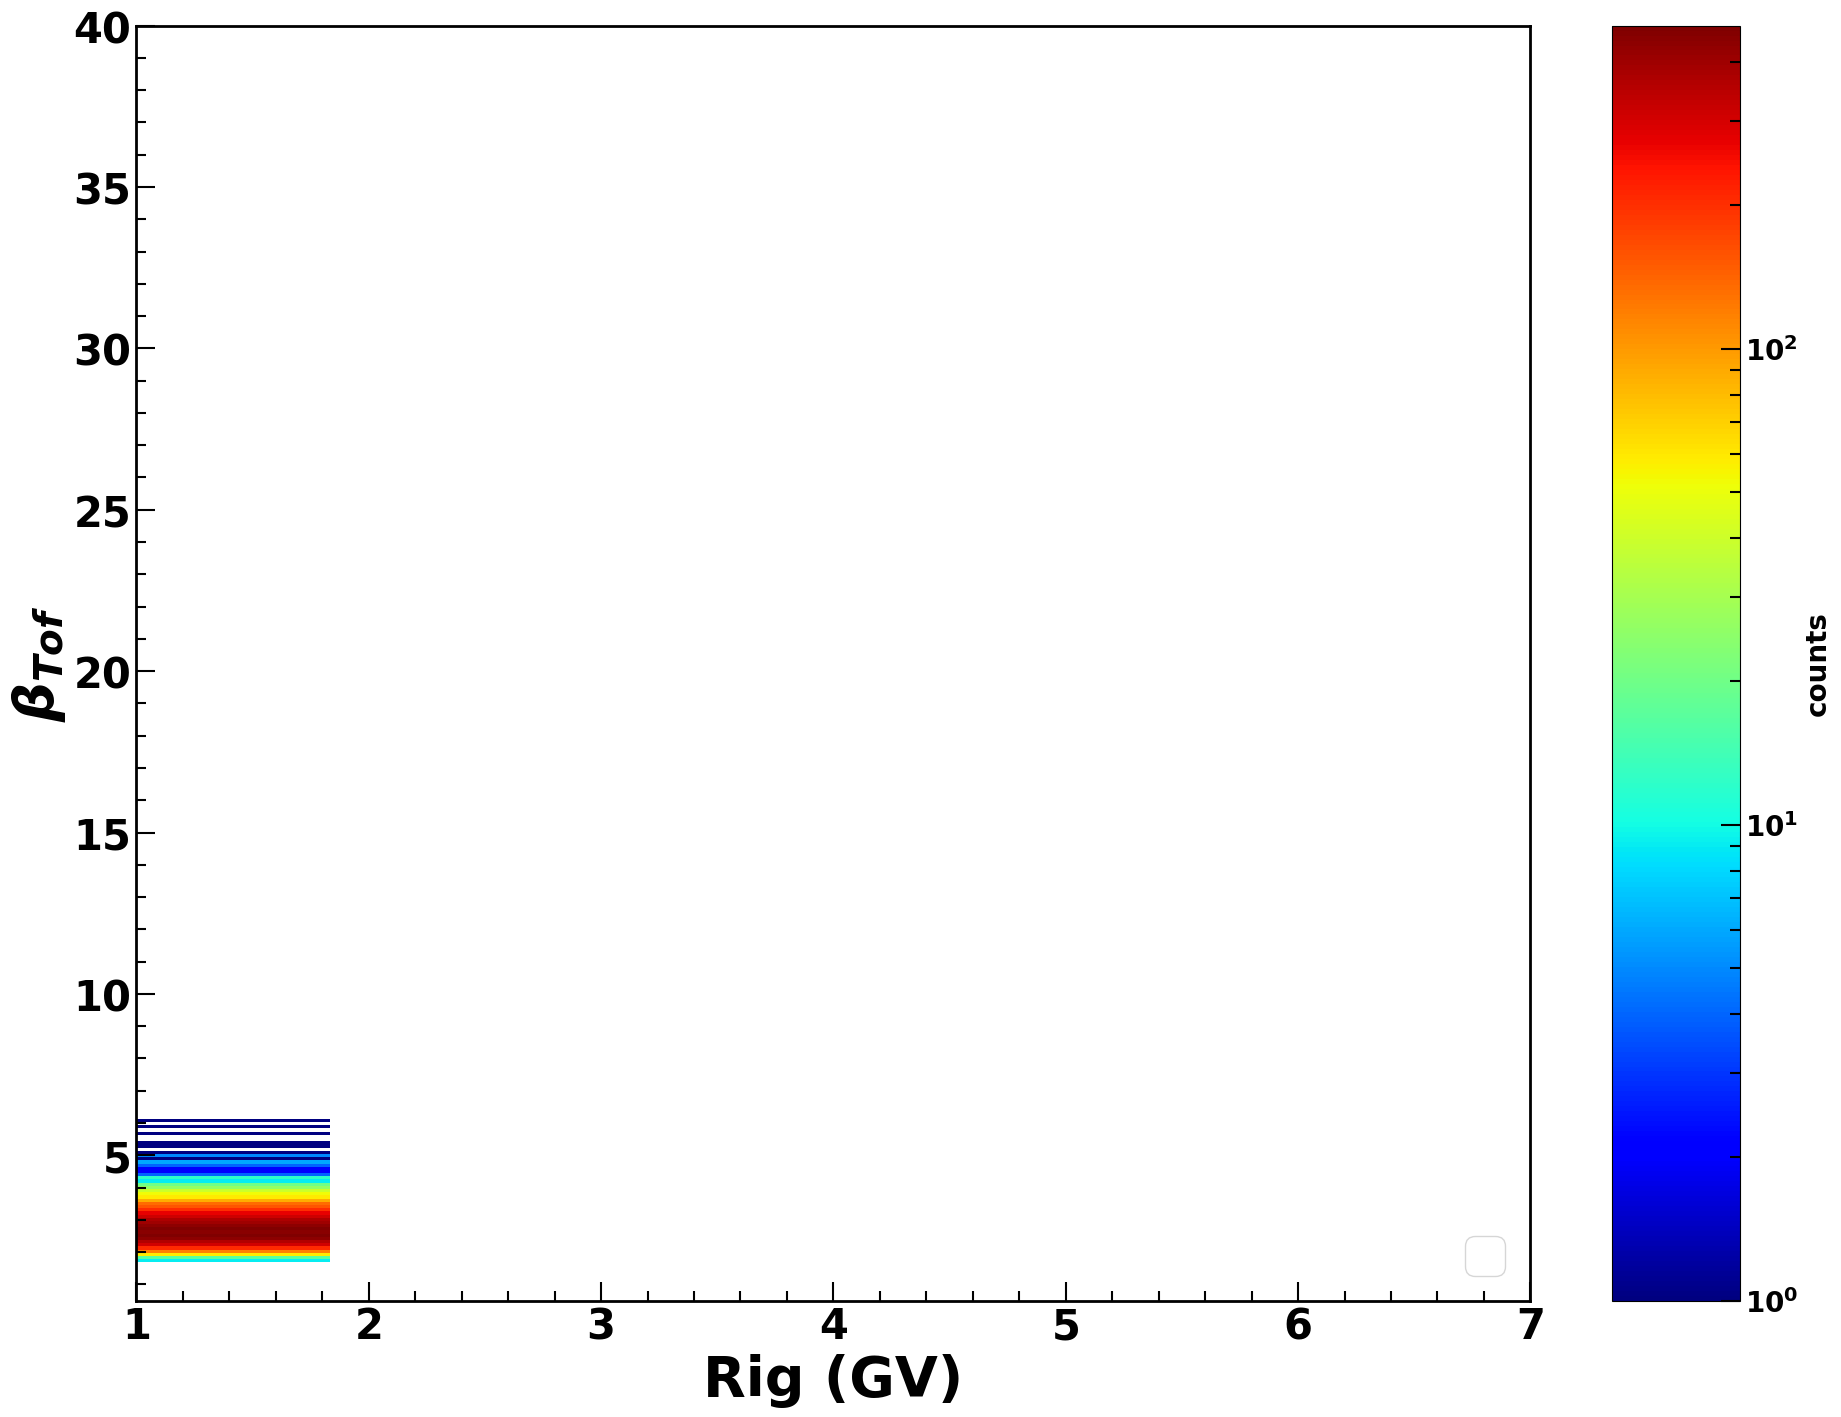

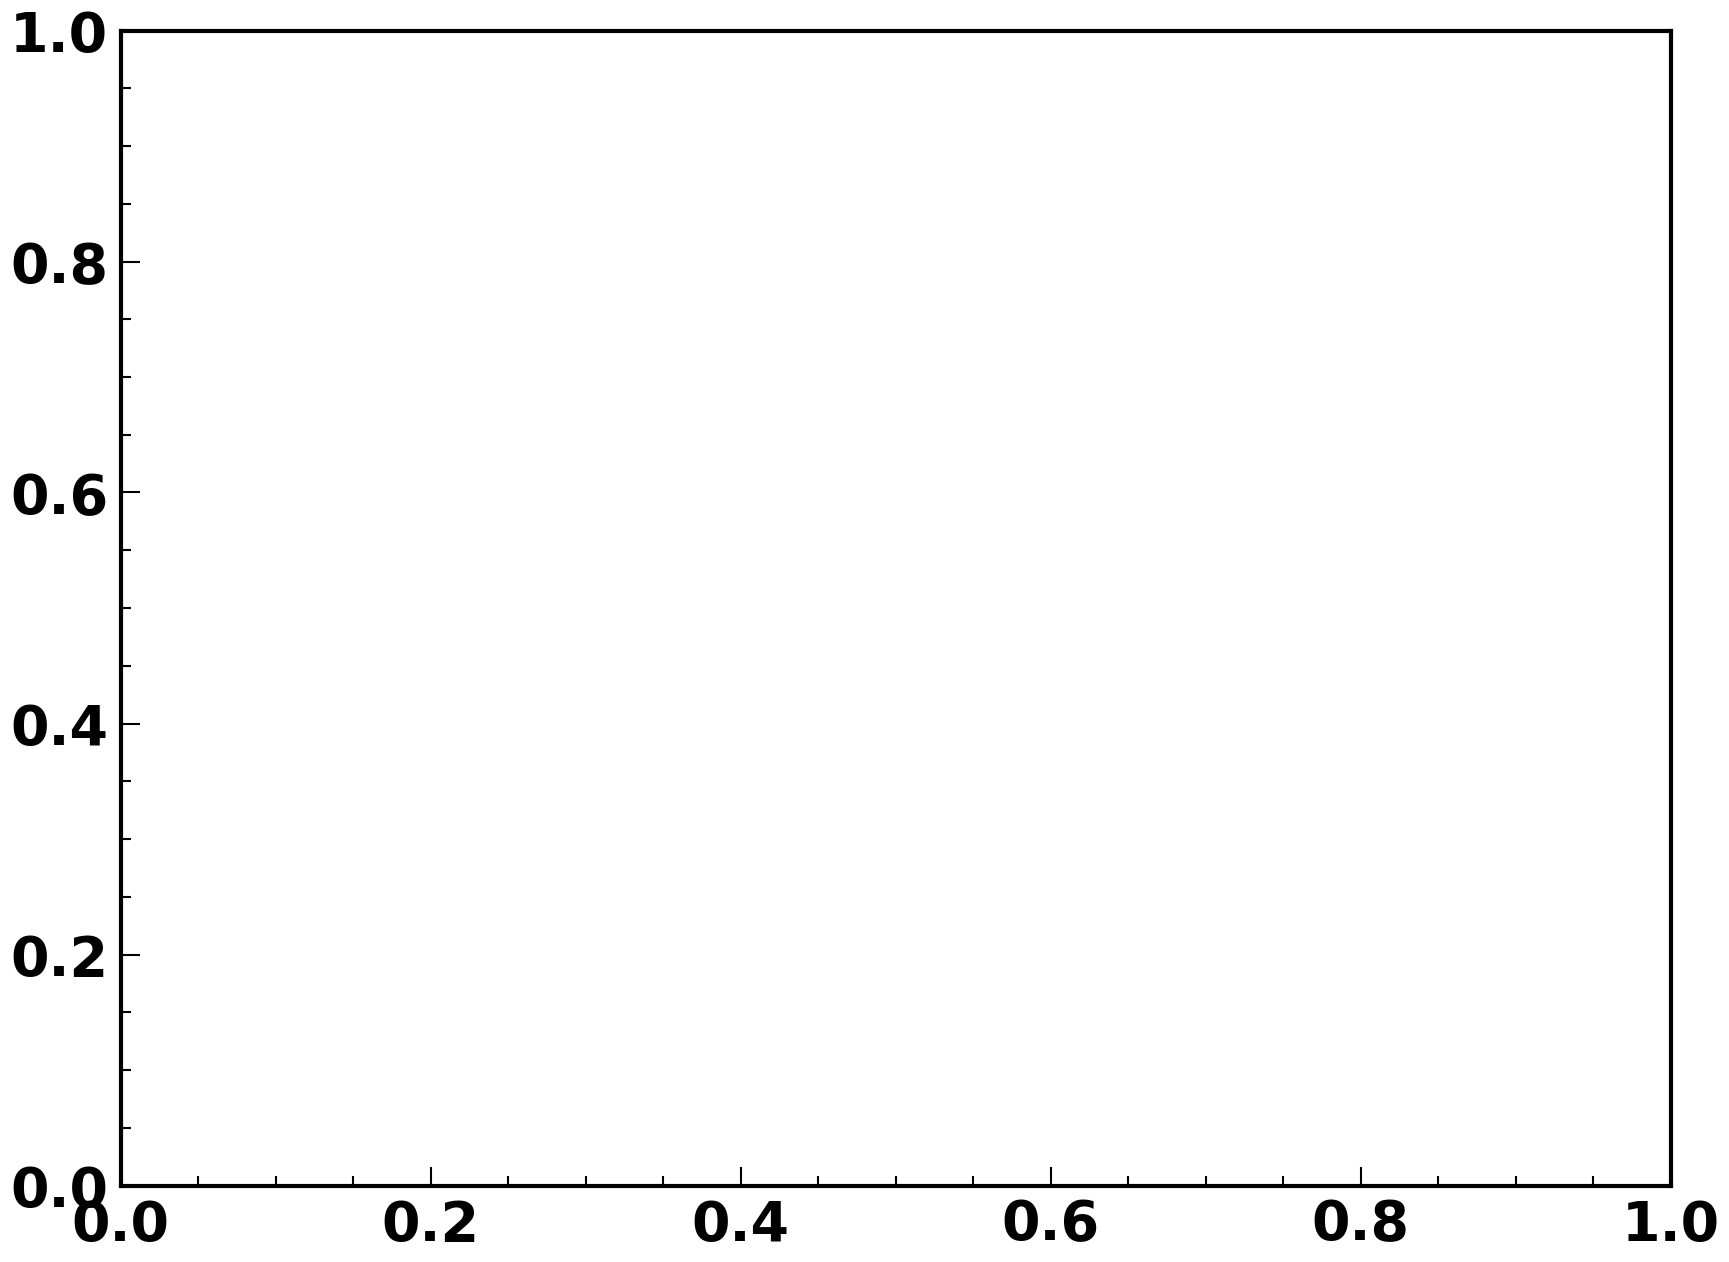

In [15]:
from tools.calculator import calc_beta_from_ekin
nuclei = 'Li'

figname = 'bkt1_mcgen2'
fileaddname = 'bkt1_mcgen2'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li7hist_masscutoff_bkt1_mcgen2.npz'
file_data_bkt1_mcrec =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkt1_mcrec.npz'
npzfile_bkt1_mcgen = np.load(file_data)
npzfile_bkt1_mcrec = np.load(file_data_bkt1_mcrec)
detectors = ['Tof', 'NaF', 'Agl']
xriglim = {'Tof':[1, 7], 'NaF':[1, 12], 'Agl':[3, 20]}
ybetalim = {'Tof':[0.6, 0.95], 'NaF':[0.7, 0.98], 'Agl':[0.93, 1.0]}

rig_gen = np.linspace(1, 50, 500)
beta = np.linspace(0.6, 0.99999, 500)
beta_iso = {}
rig = {}
rig_vsBeta = {}

for iso in ISOTOPES['Li']:
    rig[iso] = calc_rig_iso(beta, iso)
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    rig_vsBeta[iso] = MGraph(beta, rig[iso], np.zeros_like(rig[iso]))

    
for dec in detectors:
    hist2d_iss = Histogram.from_file(npzfile_bkt1_mcgen, f"Li7ISS_{dec}_rigidity_cutoff")  
    hist2d_mcgen = WeightedHistogram.from_file(npzfile_bkt1_mcgen, f"Li7MC_{dec}_rigidity_cutoff") 
    hist2d_mcrec = WeightedHistogram.from_file(npzfile_bkt1_mcrec, f"Li7MC_{dec}_rigidity_cutoff")
    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_iss.binnings[0].edges[1:-1],
               ybinning=hist2d_iss.binnings[1].edges[1:-1],
               counts=hist2d_iss.values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
    #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
    plot.set_ylabel(rf"$\beta_{{{dec}}}$", fontsize=TEXTSIZE)
    #plot.set_xlabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
    plot.set_xlabel('Rig (GV)', fontsize=TEXTSIZE)
    #plot.set_ylim([0, 10])
    
    #plot.plot(rig_gen, beta_iso['Li7'], '-', color='black')
    #plot.plot(rig_gen, beta_iso['Li6'], '--', color='green')
    print(hist2d.binnings[1].get_indices([0.982, 0.989]))
    #plot.set_ylim(ybetalim[dec])
    plot.set_xlim(xriglim[dec])
    plot.legend(loc='lower right')
    savefig_tofile(fig, plotfile, f"{nuclei}_hist_betatoi_vs_cutoff_{dec}", 1)  

    #print(calc_beta_from_ekin(np.array([2.0, 3.0])))
    #hist1d_iss = hist2d_iss.project(hist2d_iss.binnings[1].get_indices([0.6, 1.0])[0], hist2d_iss.binnings[1].get_indices([0.6, 1.0])[1], axis=1)
    #hist1d_mcrec = hist2d_mcrec.project(hist2d_mcrec.binnings[1].get_indices([0.6, 1.0])[0], hist2d_mcrec.binnings[1].get_indices([0.6, 1.0])[1], axis=1)
    #hist1d_mcgen = hist2d_mcgen.project(hist2d_mcgen.binnings[1].get_indices([0.6, 1.0])[0], hist2d_mcgen.binnings[1].get_indices([0.6, 1.0])[1], axis=1)
    
    hist1d_iss = hist2d_iss.project(hist2d_iss.binnings[0].get_indices([0.6, 12.0])[0], hist2d_iss.binnings[0].get_indices([0.6, 12.0])[1], axis=0)
    hist1d_mcgen = hist2d_mcgen.project(hist2d_mcgen.binnings[0].get_indices([0.6, 12.0])[0], hist2d_mcgen.binnings[0].get_indices([0.6, 12.0])[1], axis=0)
   
    #print(hist1d.binnings[0].edges)
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)

    hist1d_mcrec.values *= sum(hist1d_iss.values)/sum(hist1d_mcrec.values)
    hist1d_mcgen.values *= sum(hist1d_iss.values)/sum(hist1d_mcgen.values)
    plot_histogram_1d(plot, hist1d_iss, style="mc", color=col['iss'], label=f'DoBkt ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(plot, hist1d_mcgen, style="mc", color=col['mc'], label=f'NoBkt MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=3)
    #plot_histogram_1d(plot, hist1d_mcgen, style="mc", color='tab:blue', label=f'DoBkt=1 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=3)
    #plot_histogram_1d(plot, hist1d_dobkt1[dec], style="mc", color='tab:orange', label='DoBkt=1', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    #plot_histogram_1d(plot, hist1d_dobkt12[dec], style="mc", color='tab:orange', label='dobtk1', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)

    plot.legend()
    plot.set_xlabel('Rigidity (GV)')
    plot.set_xlim(xriglim[dec])
    
    savefig_tofile(fig, plotfile, f"hist1d_rig_{dec}_{figname}", show=True)    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

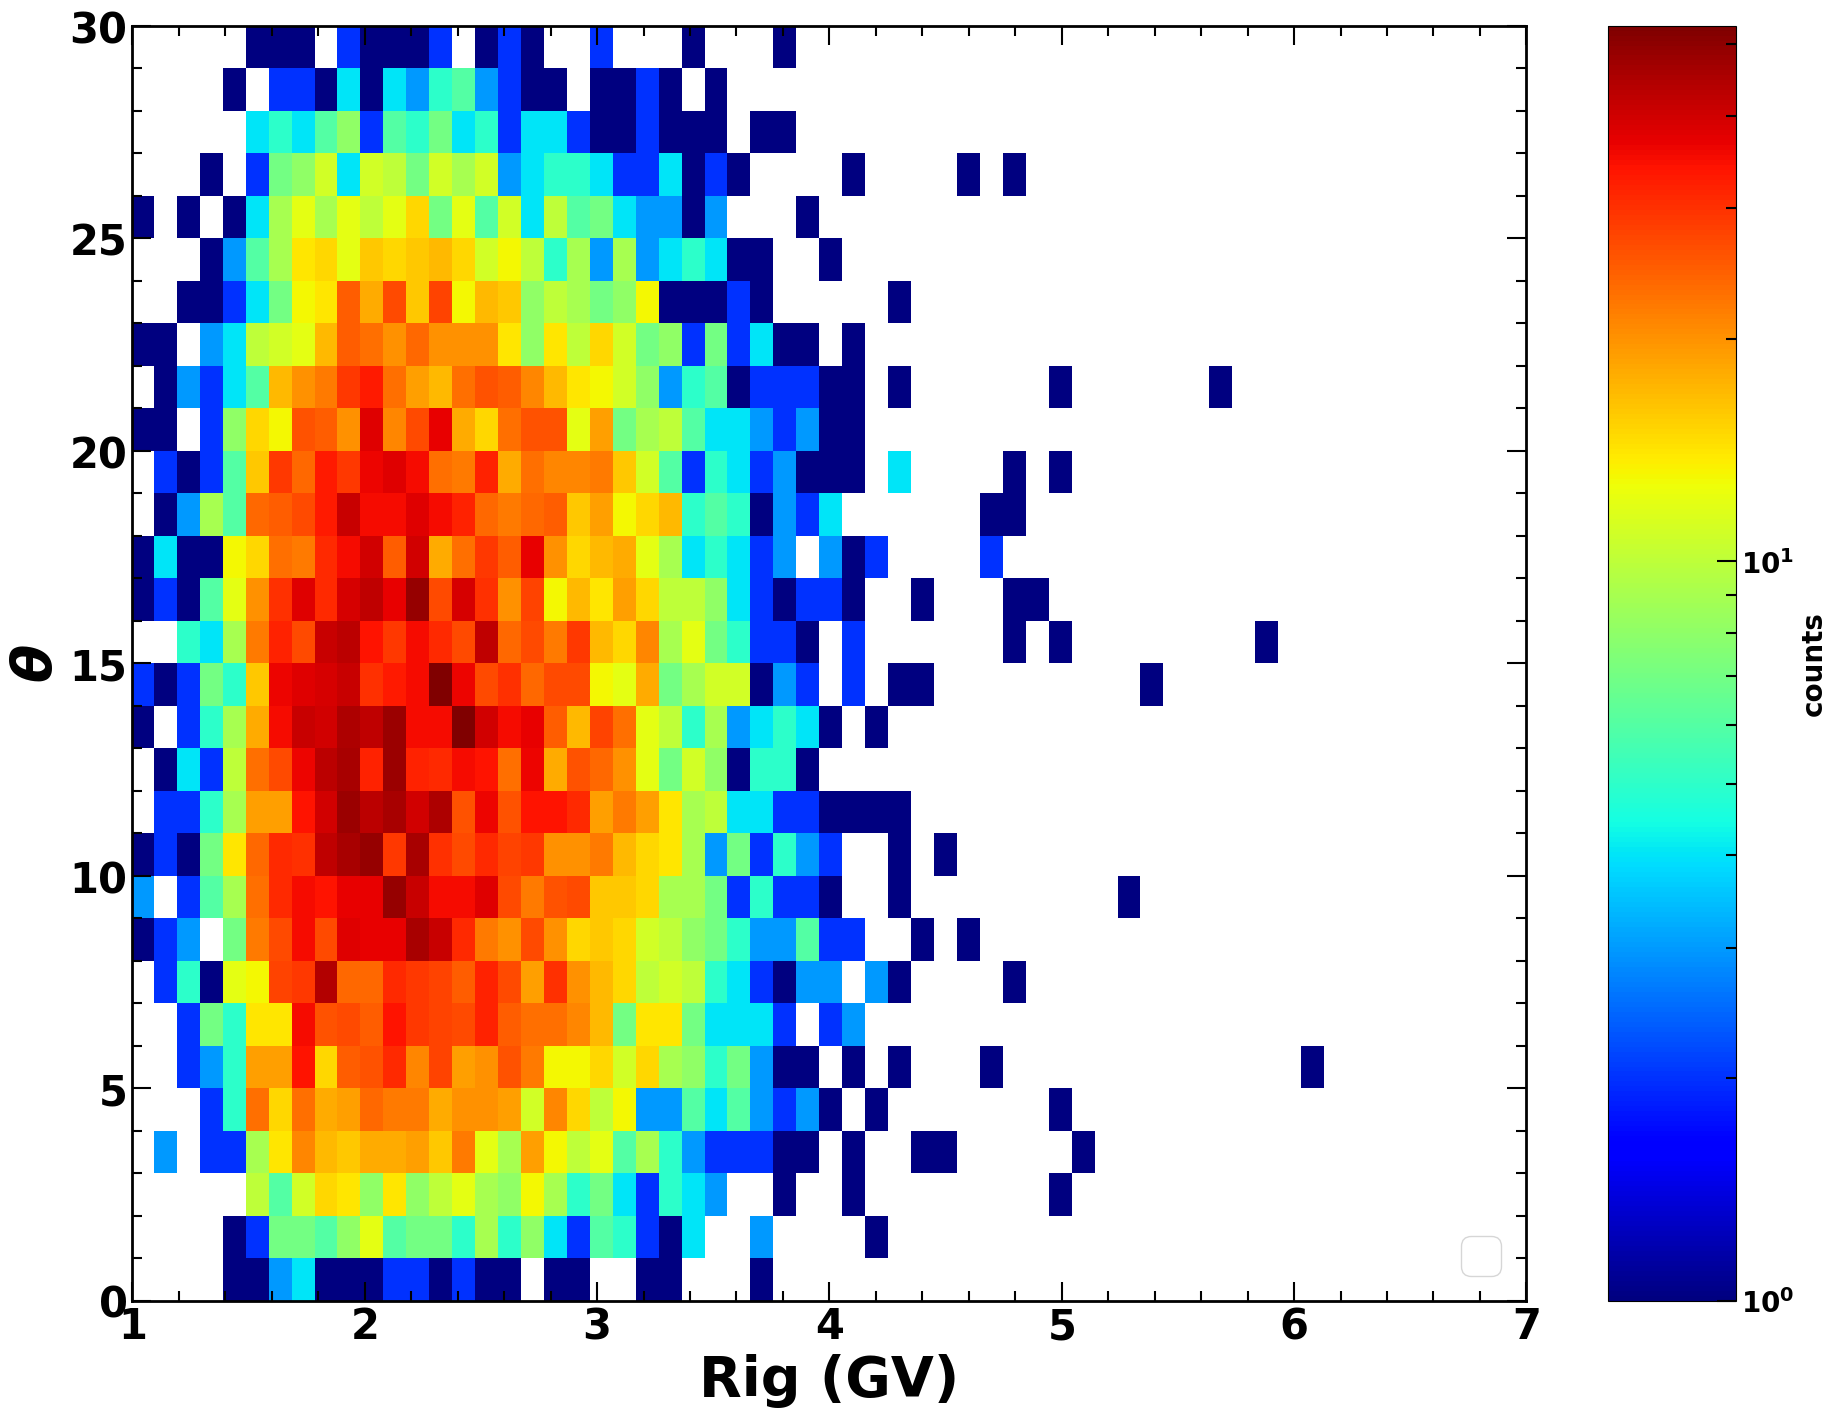

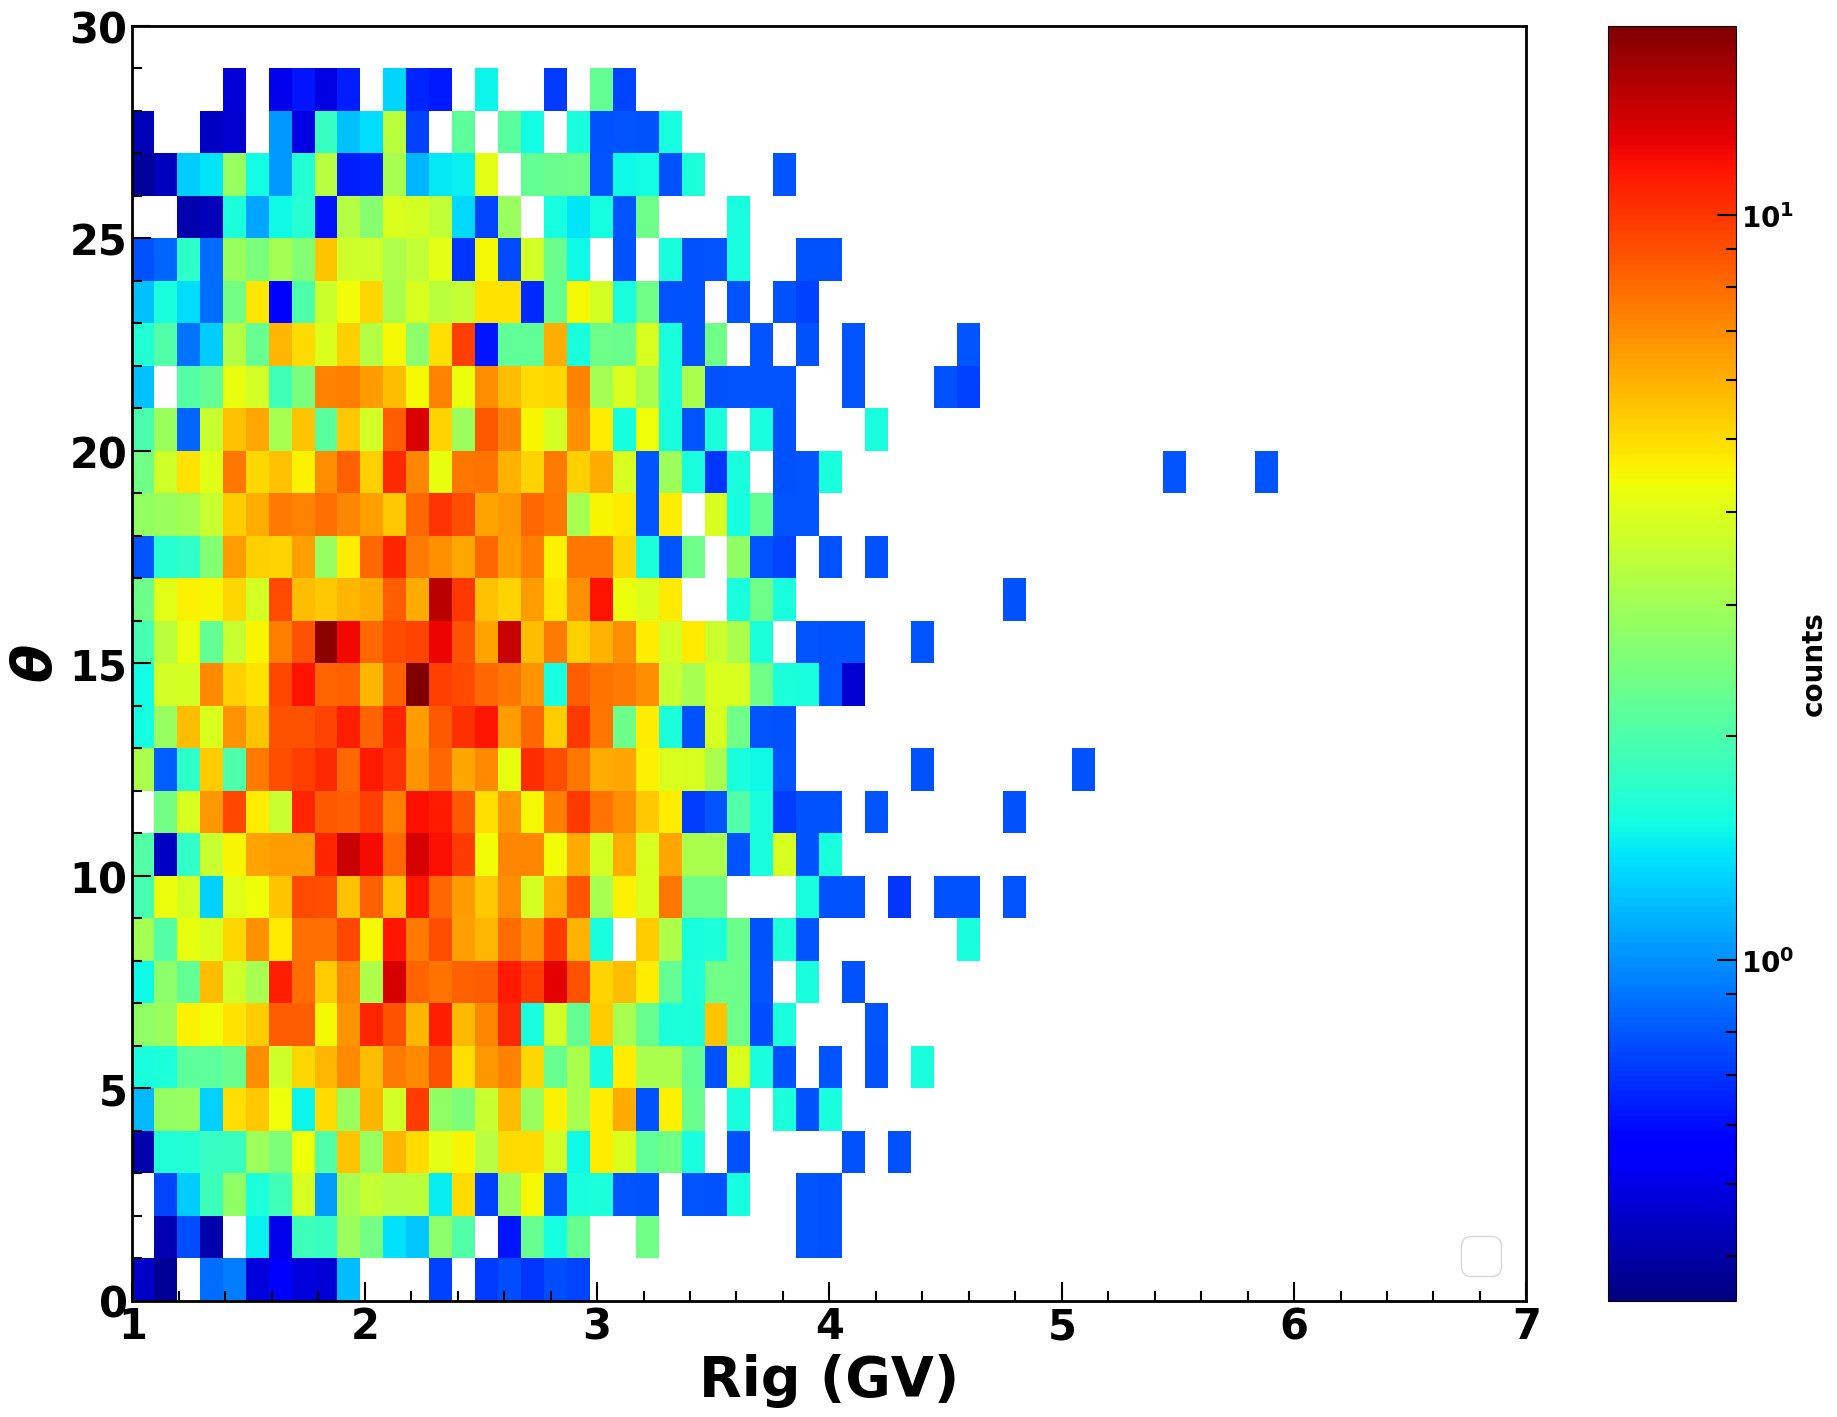

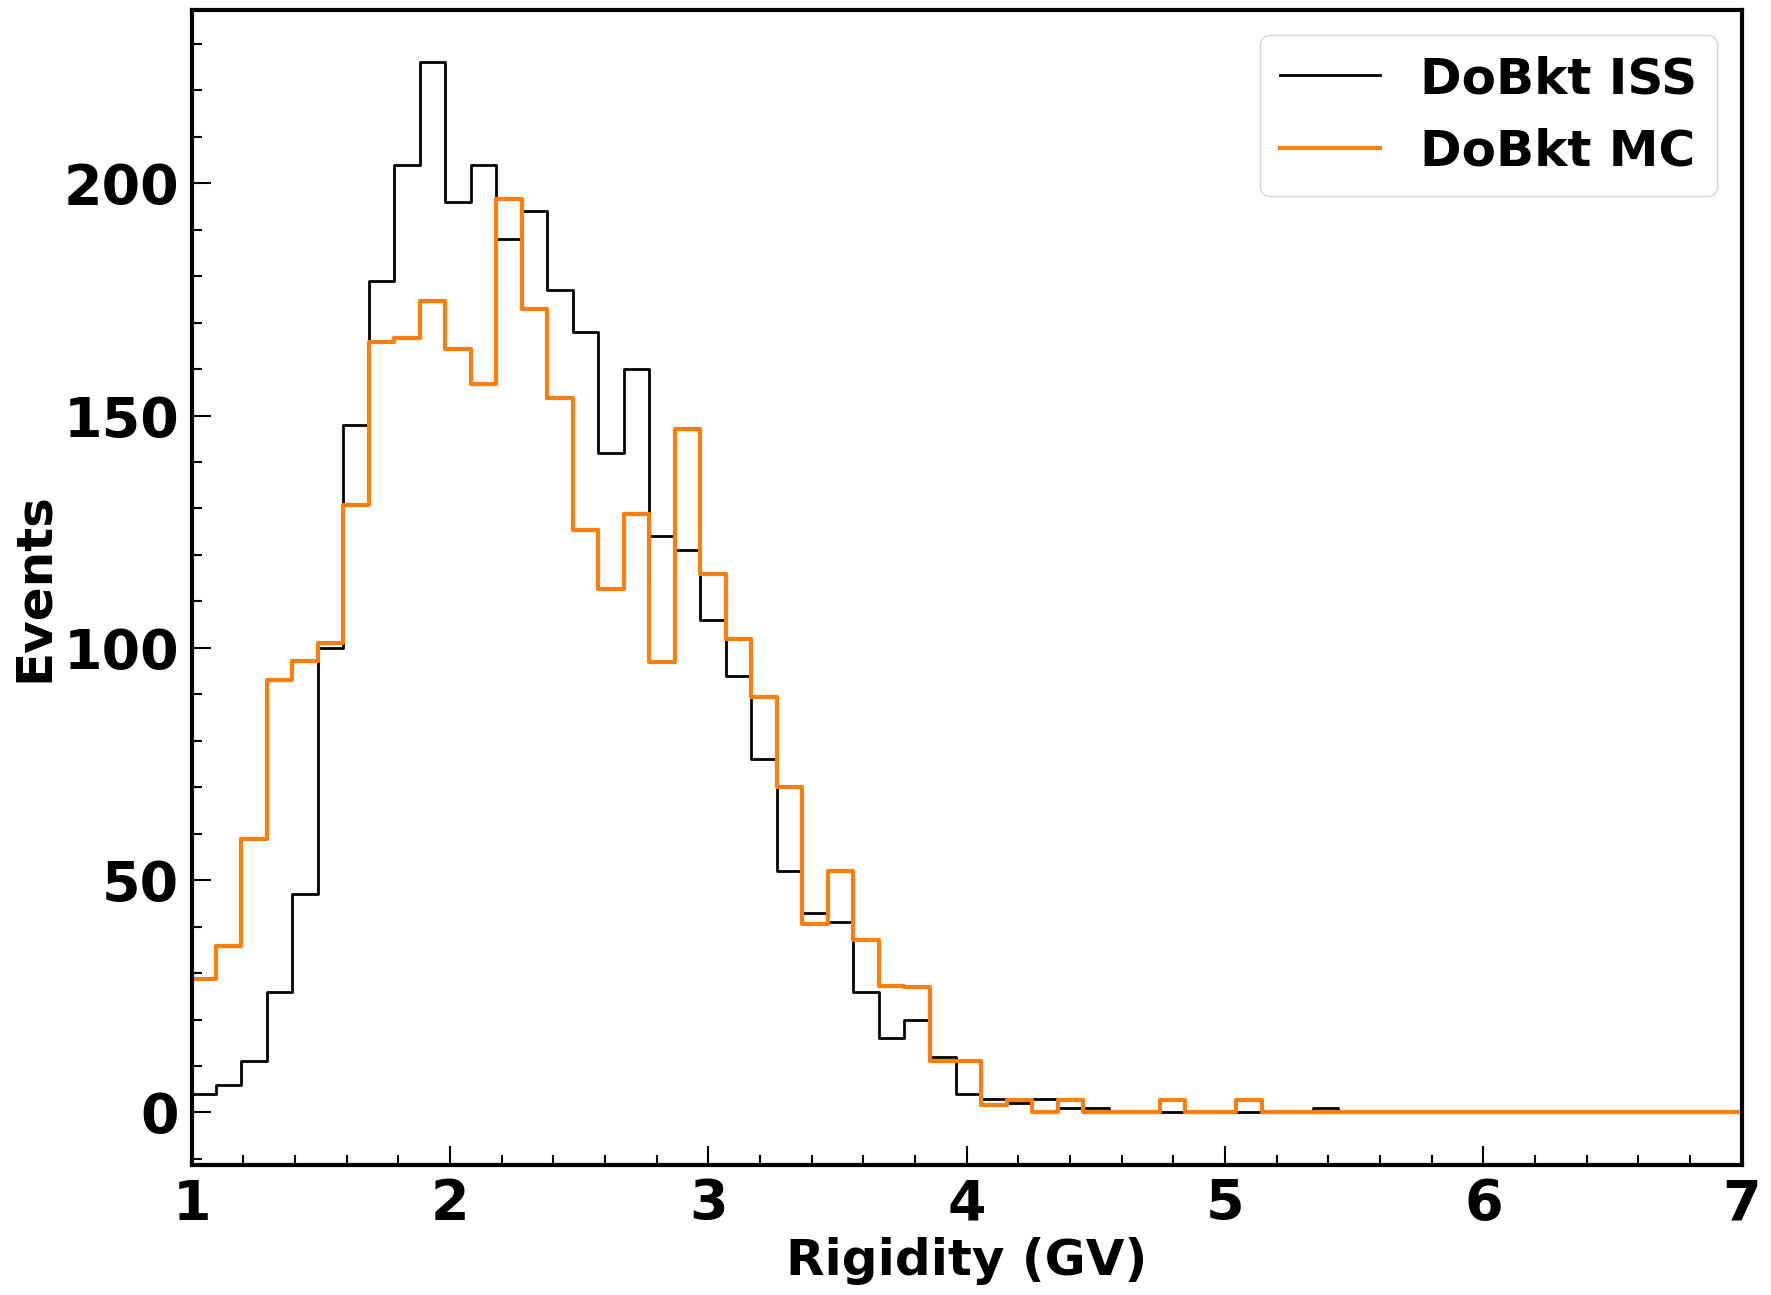

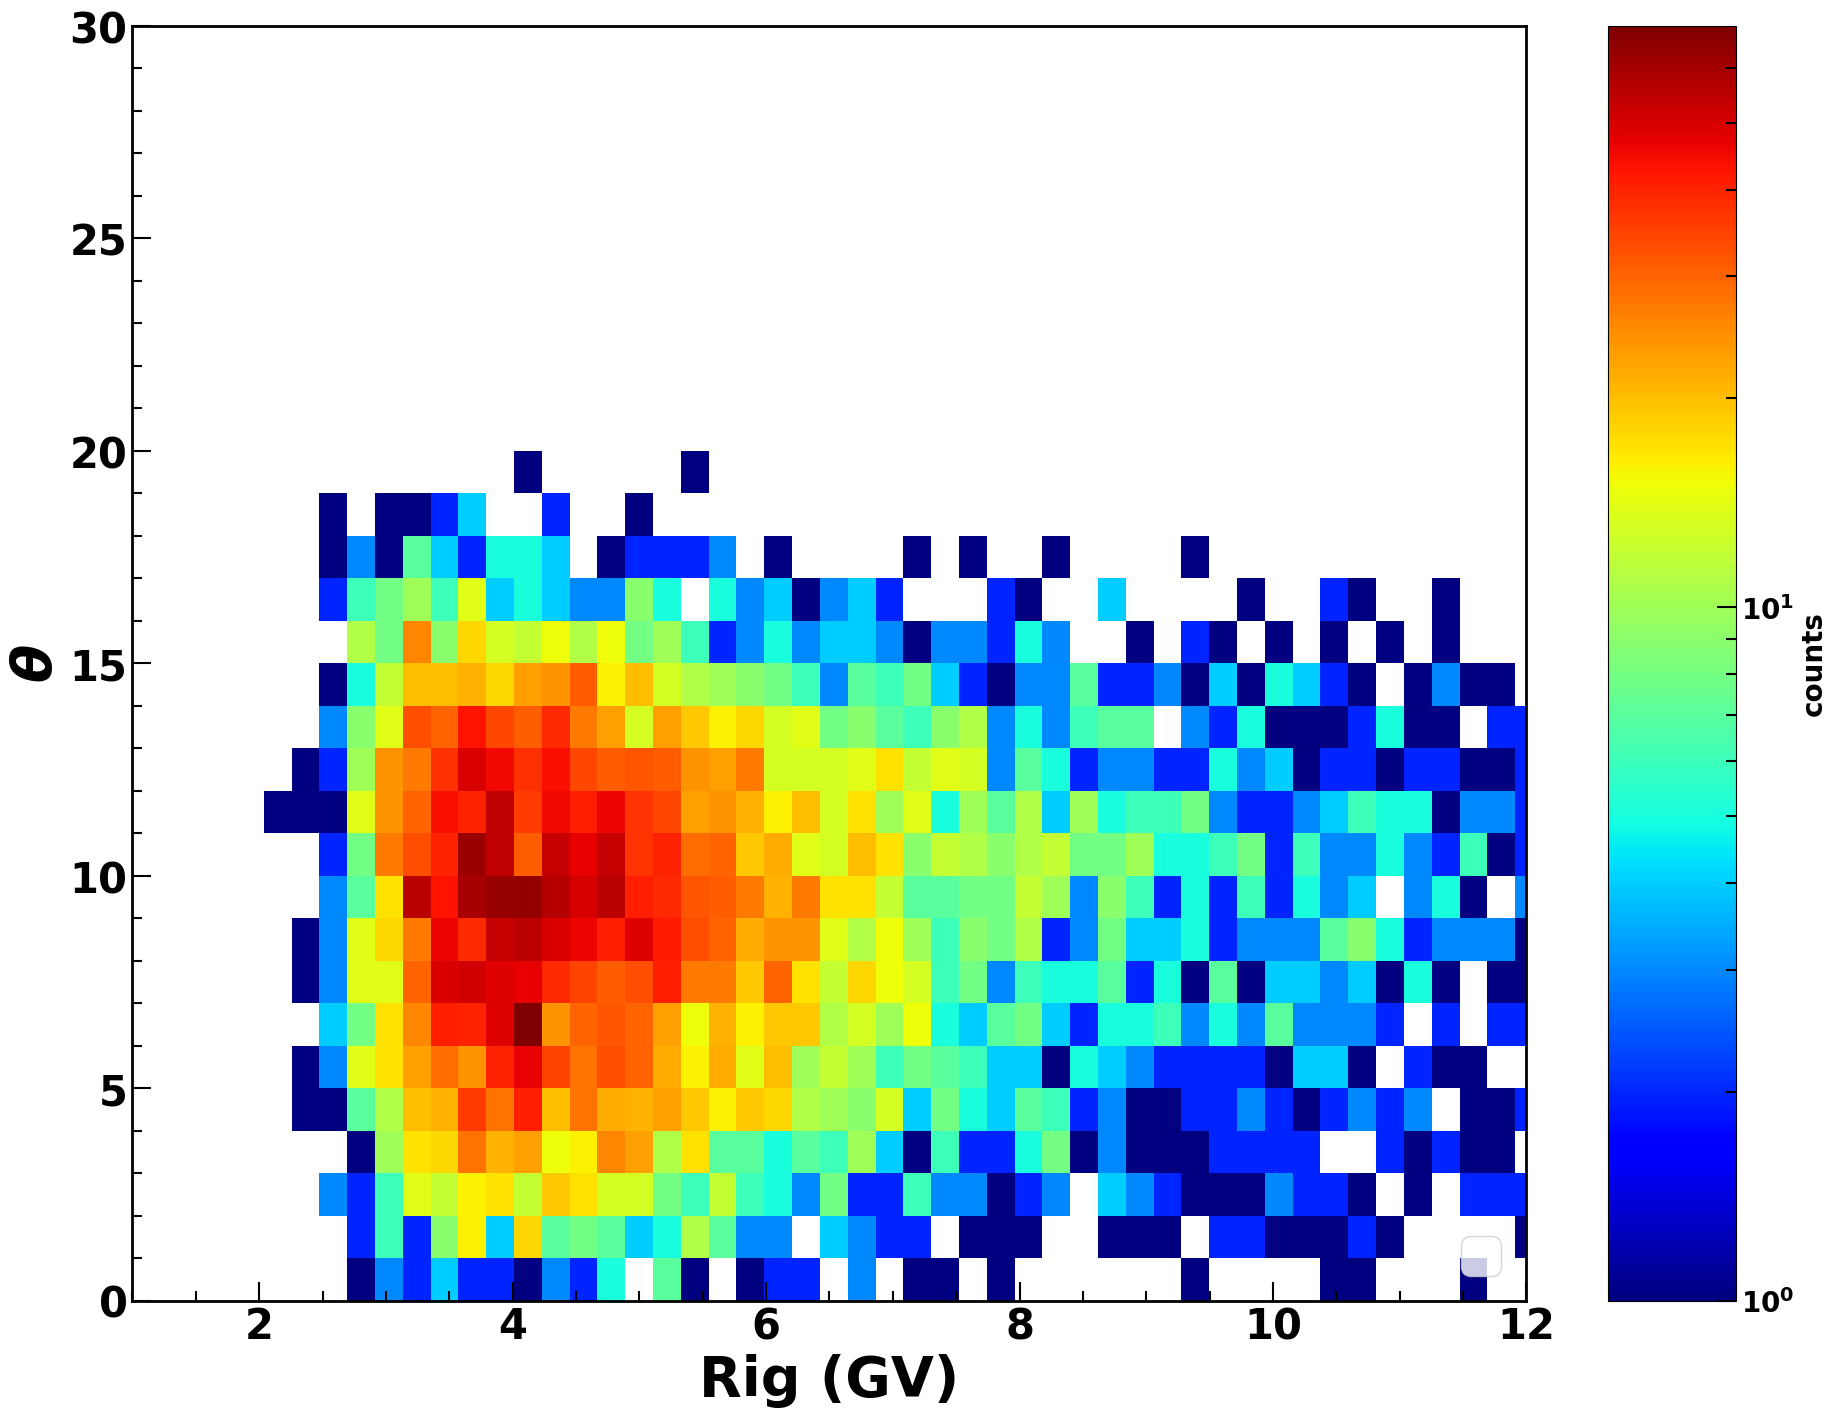

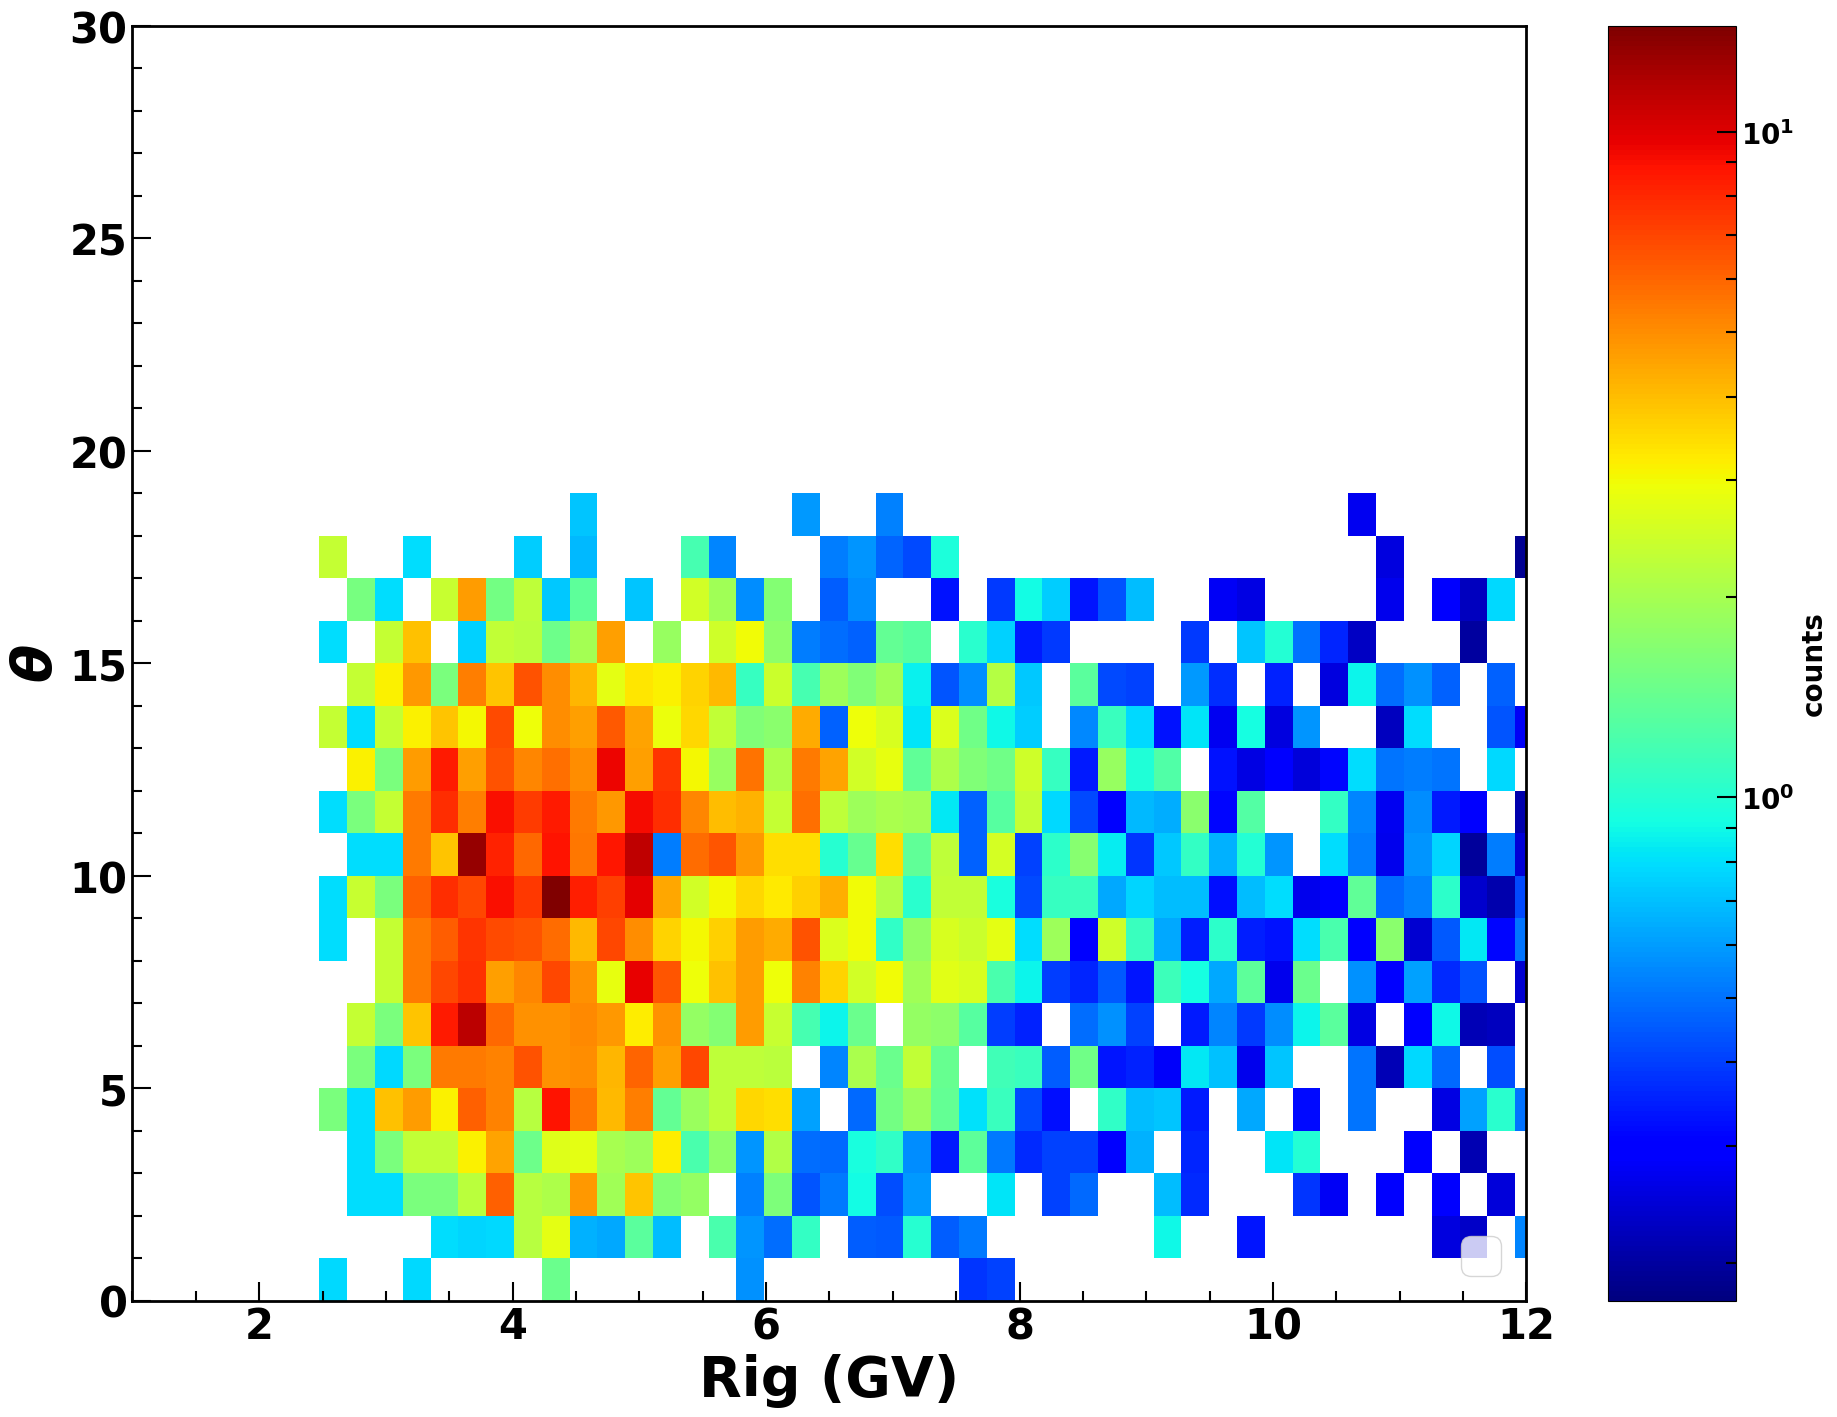

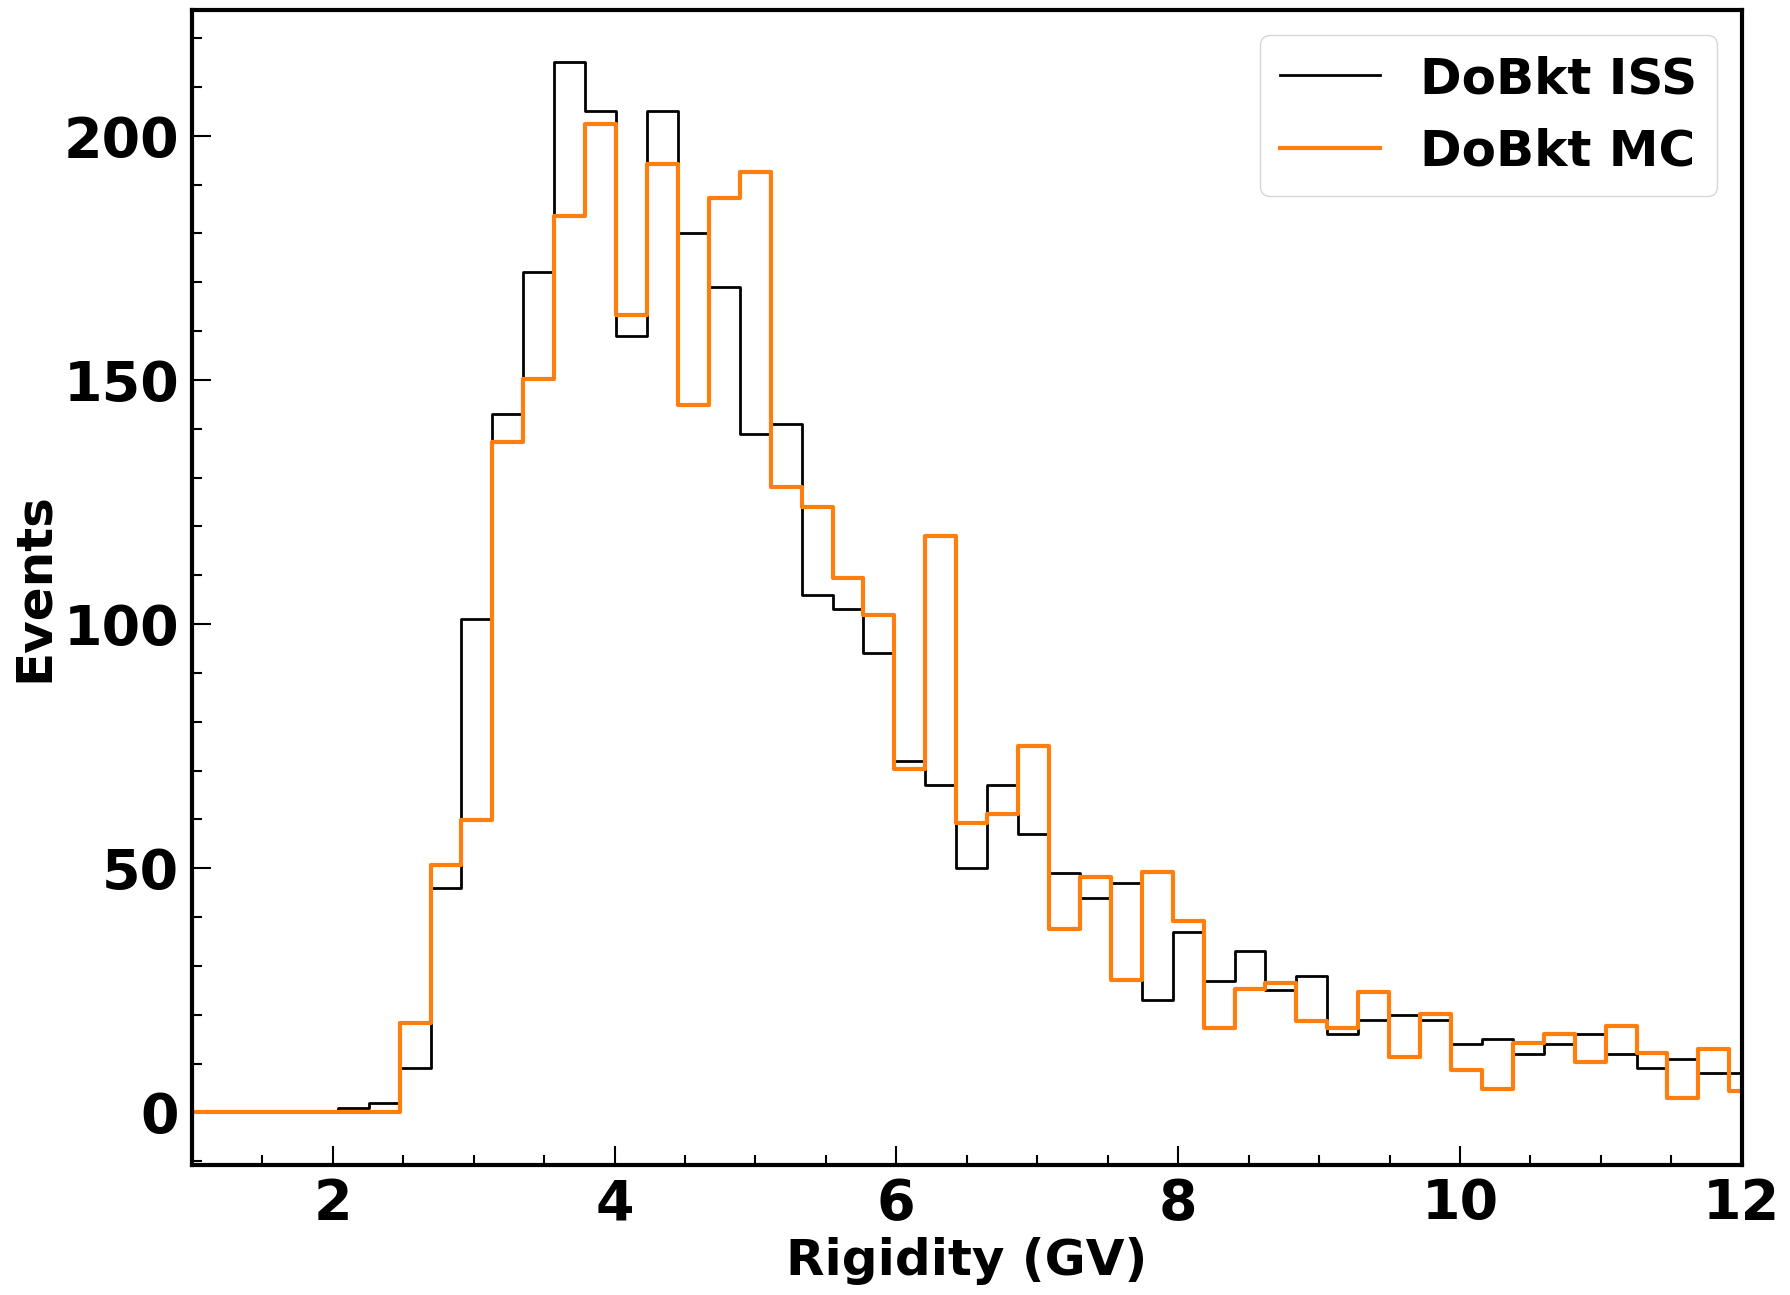

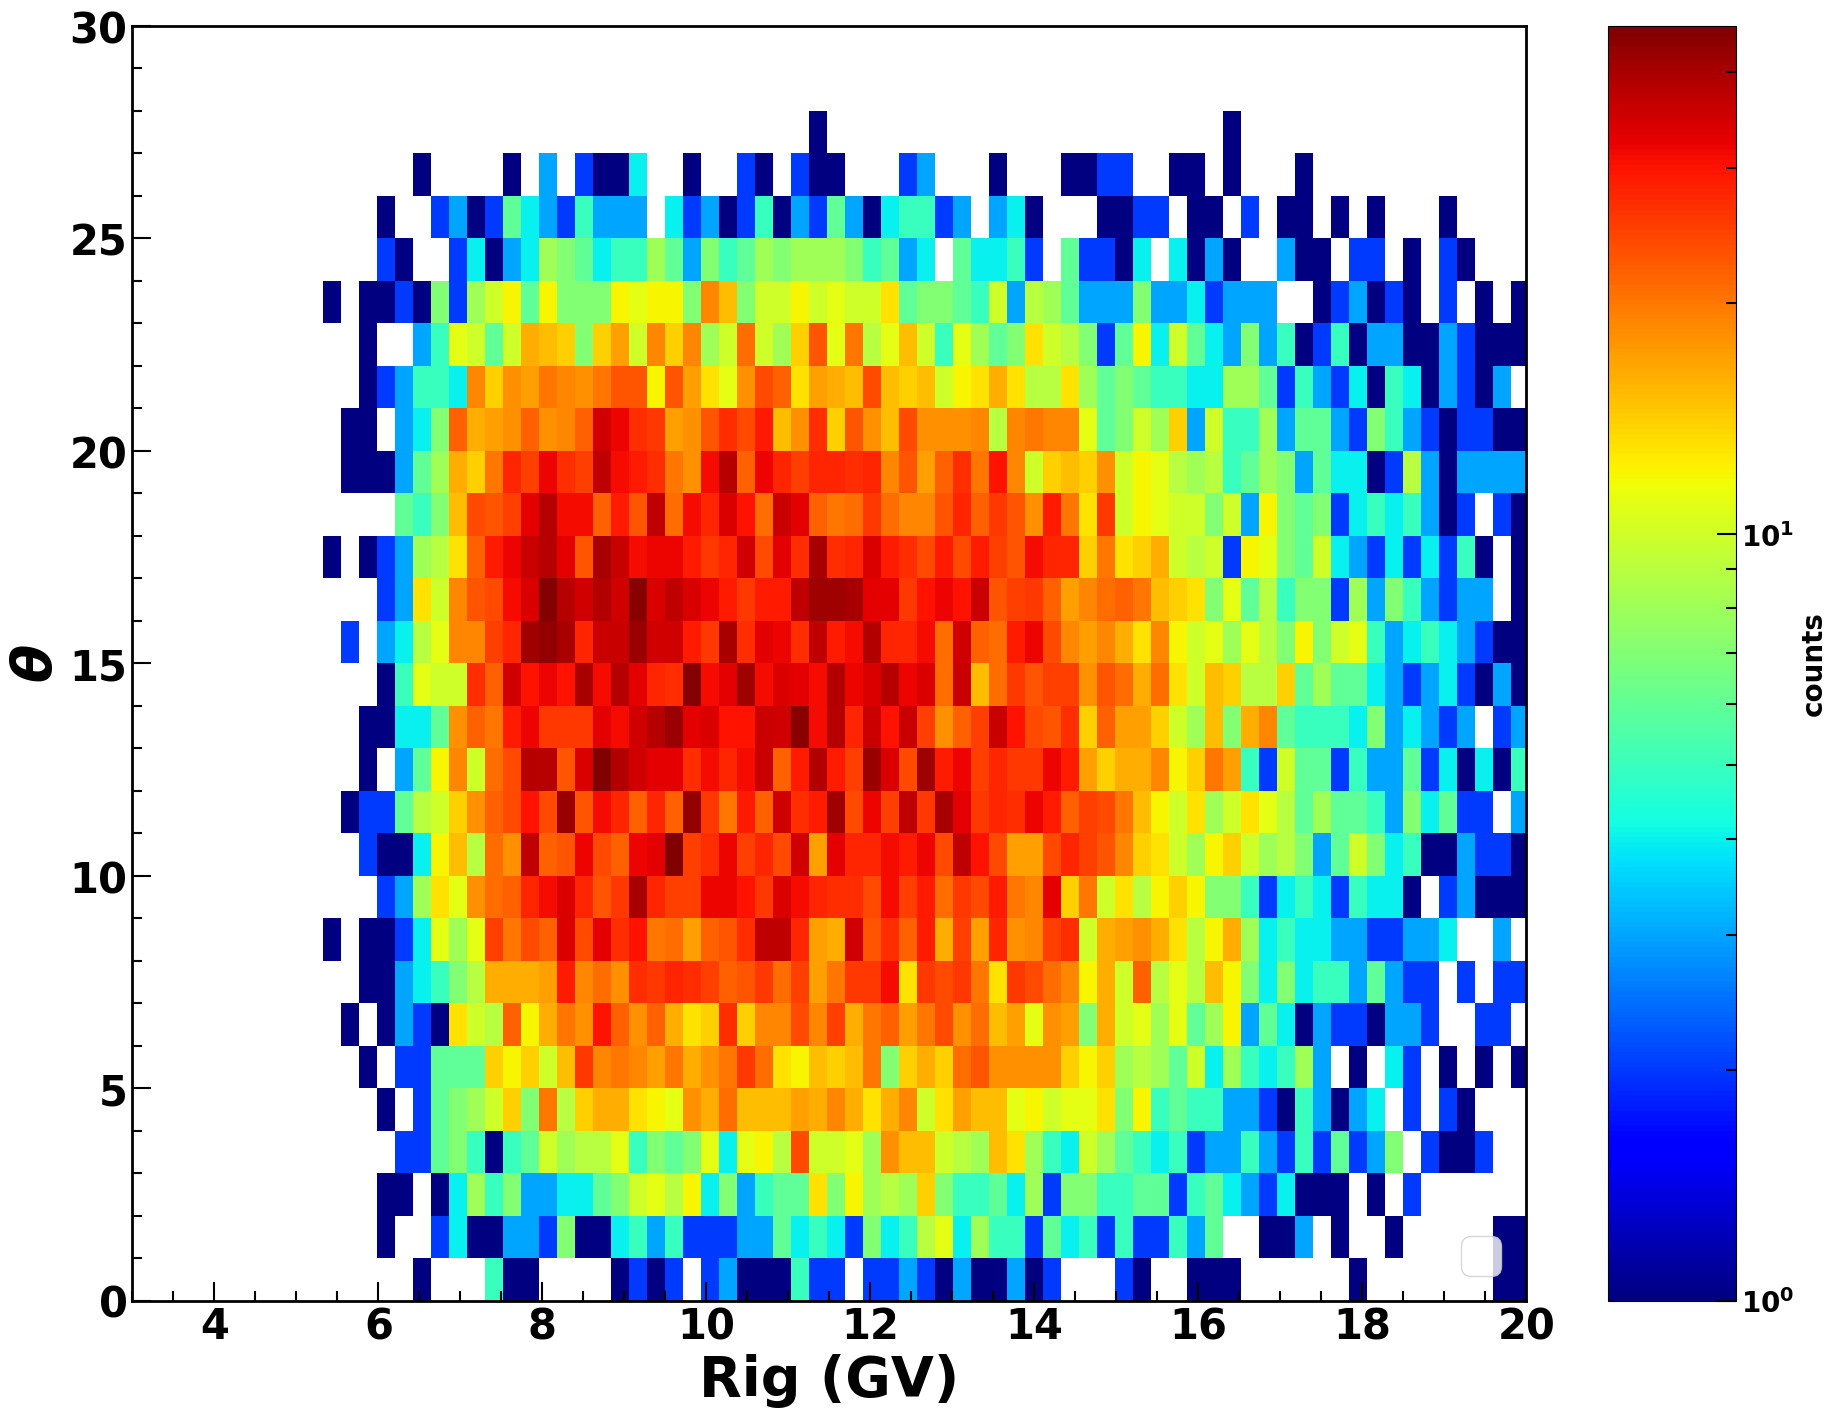

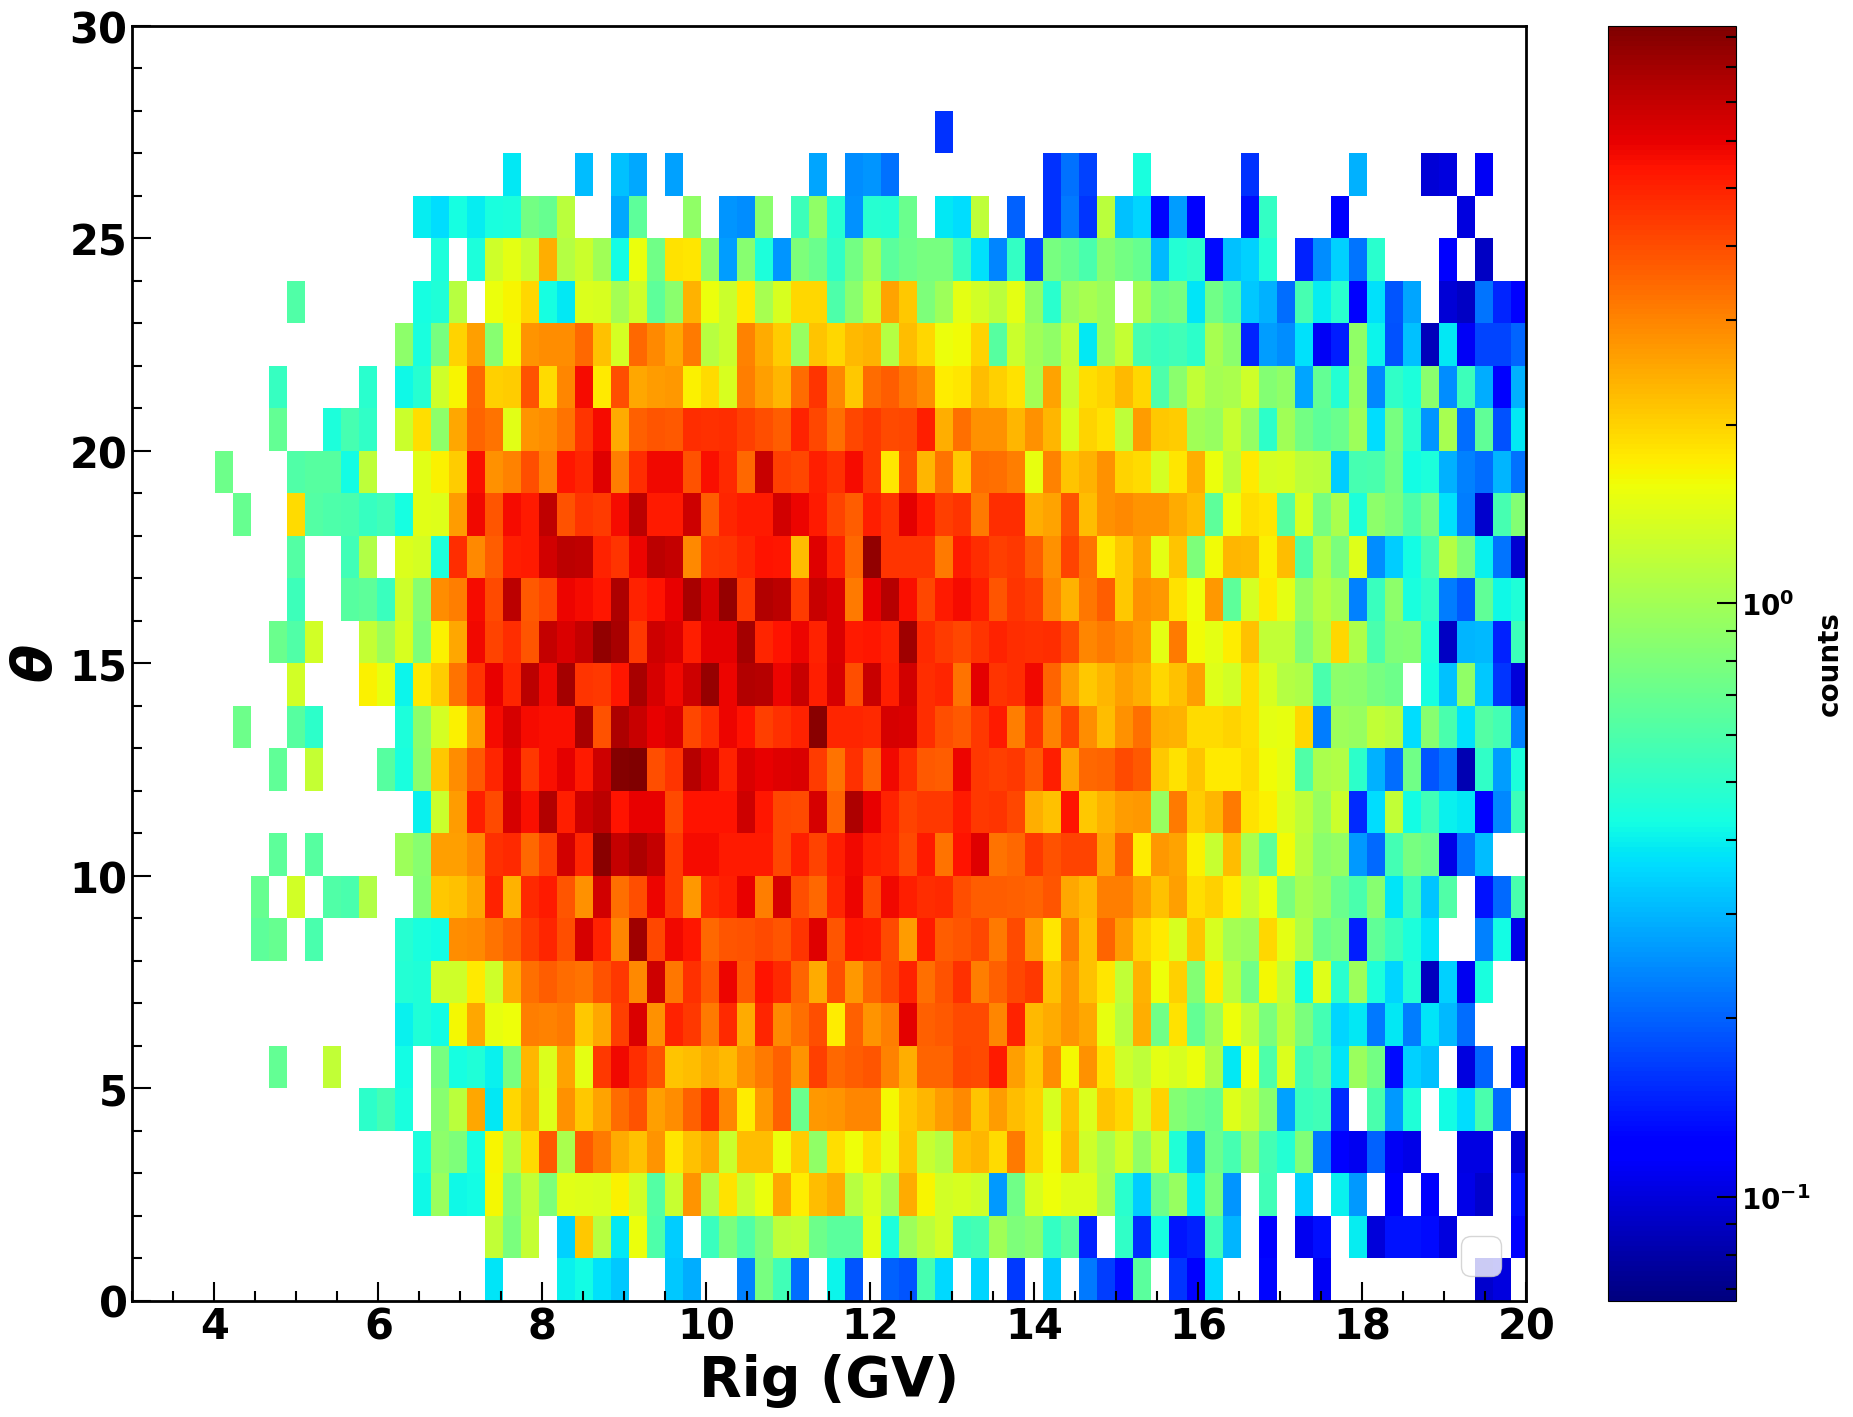

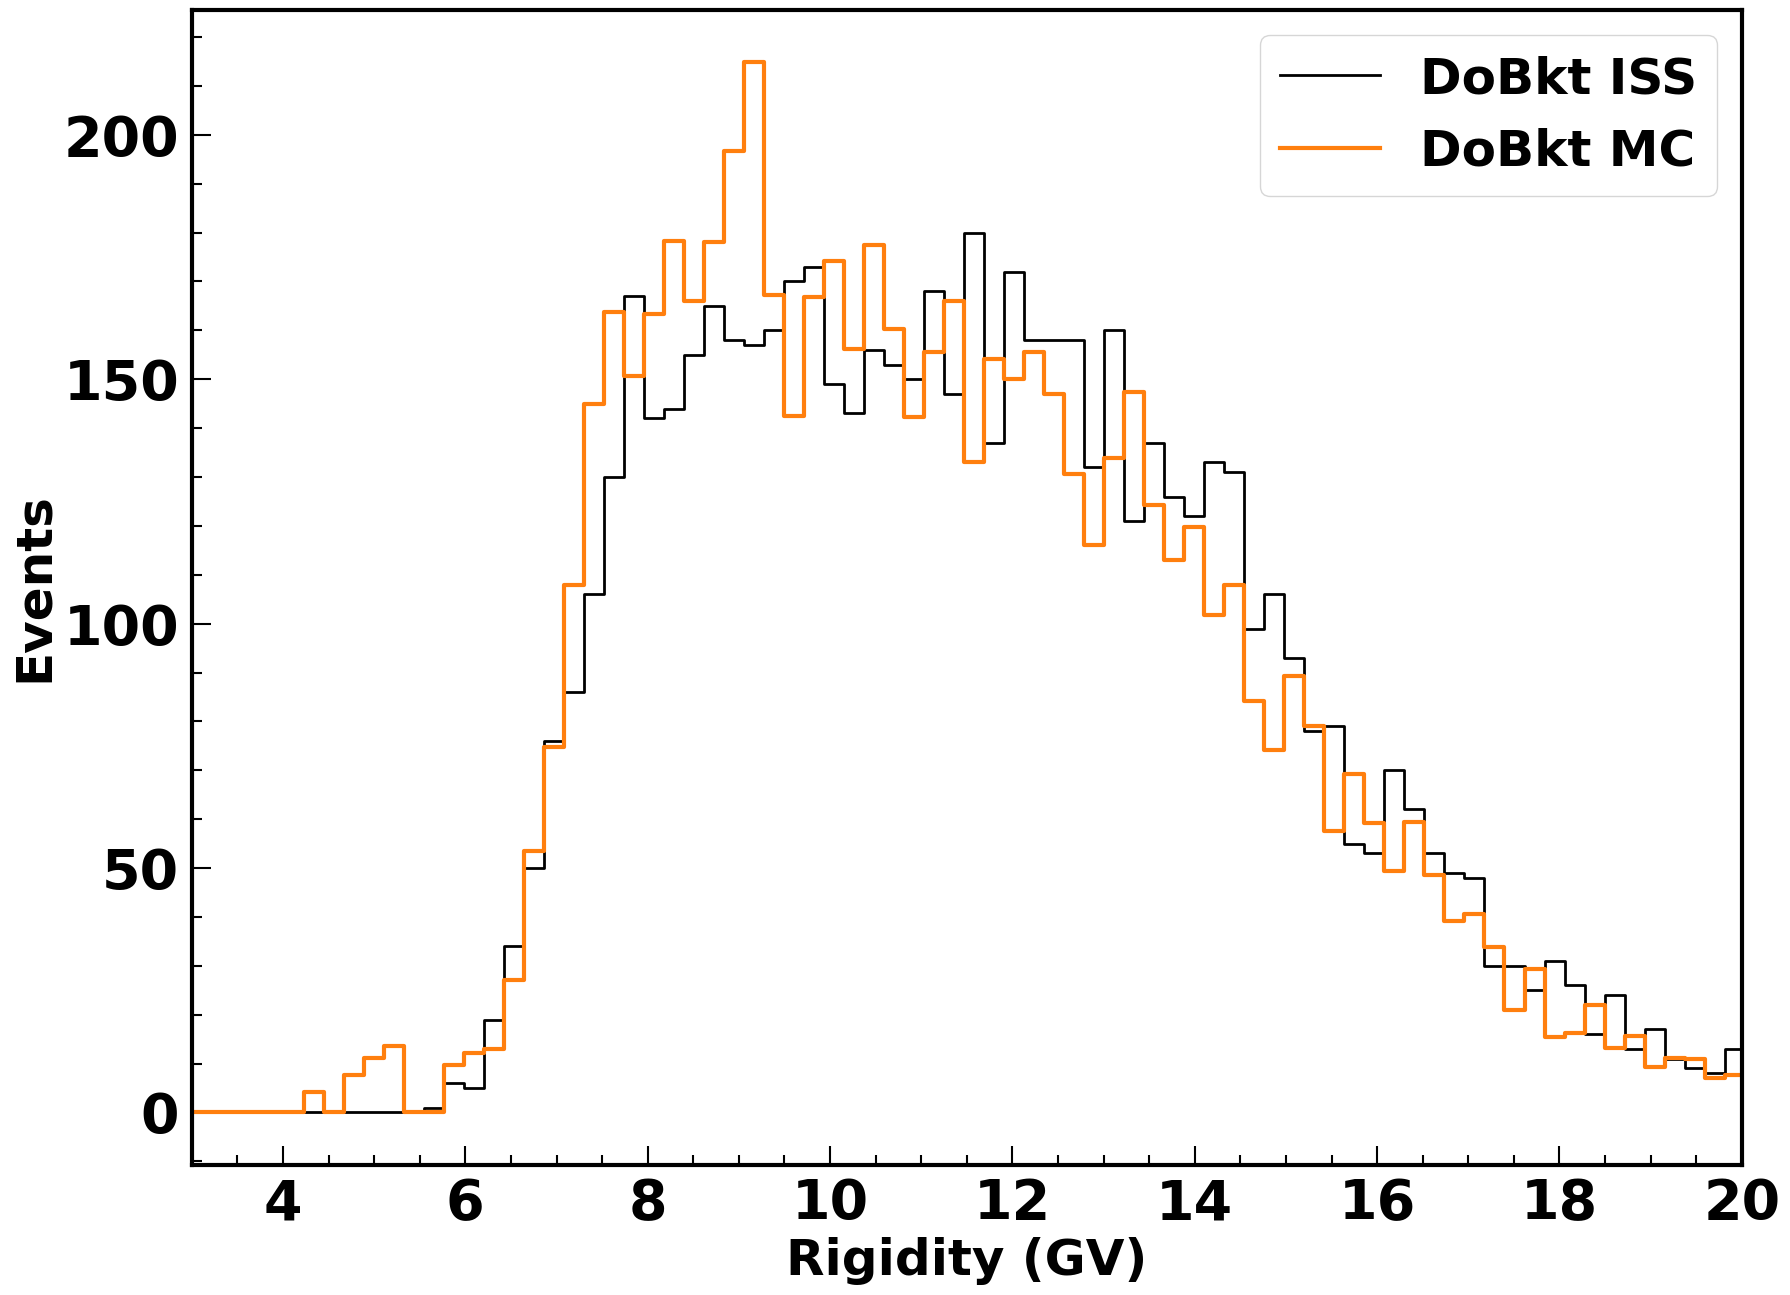

In [16]:
from tools.calculator import calc_beta_from_ekin
nuclei = 'Li'
iso = 'Li7'
figname = 'bkt1_mcgen2'
fileaddname = 'bkt1_mcgen2'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li7hist_masscutoff_bkt1_mcgen2.npz'
file_data_bkt1_mcrec =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkt1_mcrec.npz'
npzfile_bkt1_mcgen = np.load(file_data)
npzfile_bkt1_mcrec = np.load(file_data_bkt1_mcrec)
detectors = ['Tof', 'NaF', 'Agl']
xriglim = {'Tof':[1, 7], 'NaF':[1, 12], 'Agl':[3, 20]}
ybetalim = {'Tof':[0.6, 0.95], 'NaF':[0.7, 0.98], 'Agl':[0.93, 1.0]}

rig_gen = np.linspace(1, 50, 500)
beta = np.linspace(0.6, 0.99999, 500)
for iso in ISOTOPES['Li']:
    rig[iso] = calc_rig_iso(beta, iso)
    beta_iso[iso] = calc_beta(rig_gen, ISOTOPES_MASS[iso], ISOTOPES_CHARGE[iso])
    rig_vsBeta[iso] = MGraph(beta, rig[iso], np.zeros_like(rig[iso]))

    
for dec in detectors:
    hist2d_iss = Histogram.from_file(npzfile_bkt1_mcgen, f"{iso}ISS_{dec}_rigidity_vs_theta")  
    hist2d_mcgen = WeightedHistogram.from_file(npzfile_bkt1_mcgen, f"{iso}MC_{dec}_rigidity_vs_theta") 
    #hist2d_mcrec = WeightedHistogram.from_file(npzfile_bkt1_mcrec, f"Li7MC_{dec}_rigidity_vs_theta")
    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_iss.binnings[0].edges[1:-1],
               ybinning=hist2d_iss.binnings[1].edges[1:-1],
               counts=hist2d_iss.values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
    #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
    plot.set_ylabel(rf"$\theta$", fontsize=TEXTSIZE)
    #plot.set_xlabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
    plot.set_xlabel('Rig (GV)', fontsize=TEXTSIZE)
    #plot.set_ylim([-1, 1])


    #plot.set_ylim(ybetalim[dec])
    plot.set_xlim(xriglim[dec])
    plot.legend(loc='lower right')
    savefig_tofile(fig, plotfile, f"{nuclei}iss_hist_thetavsrig_{dec}", 1)  

    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_mcgen.binnings[0].edges[1:-1],
               ybinning=hist2d_mcgen.binnings[1].edges[1:-1],
               counts=hist2d_mcgen.values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
    #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
    plot.set_ylabel(rf"$\theta$", fontsize=TEXTSIZE)
    #plot.set_xlabel(rf'$\mathrm{{\beta_{{{dec}}} }}$', fontsize=TEXTSIZE)
    plot.set_xlabel('Rig (GV)', fontsize=TEXTSIZE)
    #plot.set_ylim([-1, 1])
    plot.set_xlim(xriglim[dec])
    plot.legend(loc='lower right')
    savefig_tofile(fig, plotfile, f"{nuclei}_mc_thetavsrig_{dec}", 1)  
   

    hist1d_iss = hist2d_iss.project(hist2d_iss.binnings[1].get_indices([10, 15])[0], hist2d_iss.binnings[1].get_indices([10, 15])[1], axis=1)
    #hist1d_mcrec = hist2d_mcrec.project(hist2d_mcrec.binnings[1].get_indices([0.6, 1.0])[0], hist2d_mcrec.binnings[1].get_indices([0.6, 1.0])[1], axis=1)
    hist1d_mcgen = hist2d_mcgen.project(hist2d_mcgen.binnings[1].get_indices([10, 15])[0], hist2d_mcgen.binnings[1].get_indices([10, 15])[1], axis=1)
    #print(hist1d.binnings[0].edges)
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)

    #hist1d_mcrec.values *= sum(hist1d_iss.values)/sum(hist1d_mcrec.values)
    hist1d_mcgen.values *= sum(hist1d_iss.values)/sum(hist1d_mcgen.values)
    plot_histogram_1d(plot, hist1d_iss, style="mc", color=col['iss'], label=f'DoBkt ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(plot, hist1d_mcgen, style="mc", color=col['mc'], label=f'DoBkt MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=3)
    #plot_histogram_1d(plot, hist1d_mcgen, style="mc", color='tab:blue', label=f'DoBkt=1 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=3)
    #plot_histogram_1d(plot, hist1d_dobkt1[dec], style="mc", color='tab:orange', label='DoBkt=1', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    #plot_histogram_1d(plot, hist1d_dobkt12[dec], style="mc", color='tab:orange', label='dobtk1', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)

    plot.legend()
    plot.set_xlabel('Rigidity (GV)')
    plot.set_xlim(xriglim[dec])
    
    savefig_tofile(fig, plotfile, f"hist1d_rig_{dec}_{figname}_angle1015", show=True)    


In [17]:
from tools.calculator import calc_beta_from_ekin
nuclei = 'Li'
figname = 'Li7'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Lihist_masscutoff_{fileaddname}.npz'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Li7hist_masscutoff_bkt1_mcgen2.npz'
file_data_eng12 =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkstatv19.npz'
file_data_dobkt1 =f'/home/manbing/Documents/Data/data_{nuclei}P8/{Nuclei}hist_masscutoff_bkt1.npz'
detectors = ['Tof', 'NaF', 'Agl']
betalim = {'Tof':[1, 7], 'NaF':[1, 12], 'Agl':[3, 20]}
npzfile = np.load(file_data)
npzfile_dobkt1 = np.load(file_data_dobkt1)
npzfile_eng12 = np.load(file_data_eng12)
betalim = {'Tof':[0.5, 0.9], 'NaF':[0.7, 1.0], 'Agl':[0.9, 1.02]}
for dec in detectors:
    histbeta_mc = WeightedHistogram.from_file(npzfile, f"Li7MC_{dec}_beta_cutoff")  
    histbeta_iss = Histogram.from_file(npzfile, f"Li7ISS_{dec}_beta_cutoff")  
    histbeta_mc.values = histbeta_mc.values * sum(histbeta_iss.values)/sum(histbeta_mc.values)
    
    histbeta_dobkt1 = WeightedHistogram.from_file(npzfile_dobkt1, f"Li7MC_{dec}_beta_cutoff")  
    histbeta_dobkt1.values = histbeta_dobkt1.values * sum(histbeta_iss.values)/sum(histbeta_dobkt1.values)
    histbeta_eng12 = Histogram.from_file(npzfile_eng12, f"Li7MC_{dec}_beta_cutoff")  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot.set_xlim(betalim[dec])
    
    #plot_histogram_1d(plot, histbeta_mc, style="mc", color=col['mc'], label=f'{figname} MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(plot, histbeta_iss, style="iss", color=col['iss'], label=f'DoBkt=1 ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=20)
    plot_histogram_1d(plot, histbeta_mc, style="mc", color='tab:orange', label='DoBkt=1, MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    #plot_histogram_1d(plot, histbeta_eng12, style="mc", color='tab:green', label='NoBkt,eng12', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)

    plot.legend()
    plot.set_xlabel(rf'$\mathrm{{\beta_{{{dec}}} }}$')
    savefig_tofile(fig, plotfile, f"hist1d_beta_{dec}_{figname}", show=True)    


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/Data/data_LiP8/Lihist_masscutoff_bkstatv19.npz'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


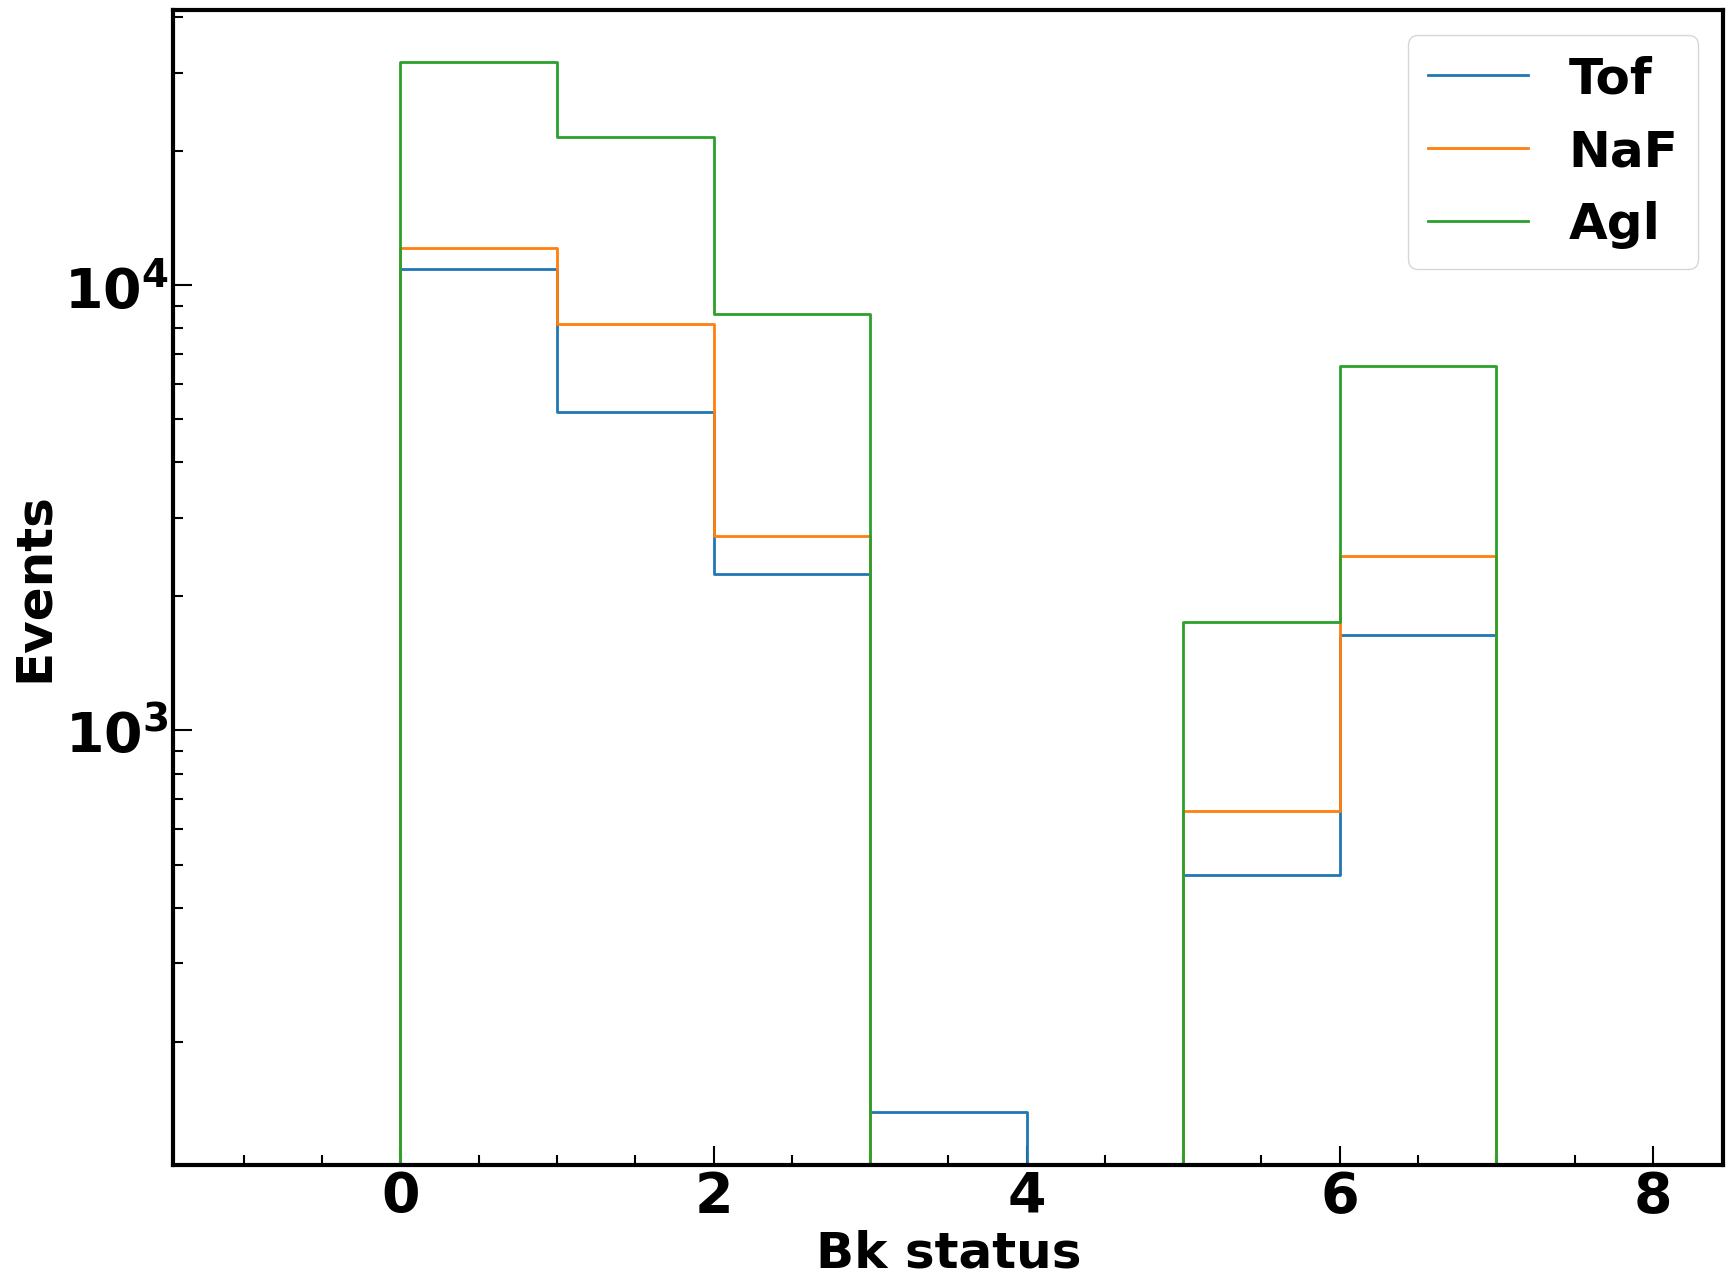

In [24]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'v4'
filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_nobkt.npz'

minbin = {'Tof': 1, 'NaF':1, 'Agl':7}
maxbin =  {'Tof':3,  'NaF':3, 'Agl':12}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
xrange = {'Tof': [0.11, 0.16], 'NaF': [0.11, 0.16], 'Agl': [0.123, 0.16]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}

hist1dbkstat = {}

detectors = ['Tof', 'NaF', 'Agl']
with np.load(filename) as histfile:       
    for dec in detectors:
        hist1dbkstat[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_bkstat")  

fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1)  
for dec in detectors:  
      
    set_plot_style(plot)
    #plot.set_xlim([1, 30])
    plot_histogram_1d(plot, hist1dbkstat[dec], style="mc", color=DETECTOR_COLOR[dec], label=f'{dec}', scale=None, gamma=None, xlog=False, ylog=True, linewidth=2)
    plot.legend()
    plot.set_xlabel('Bk status')
    savefig_tofile(fig, plotfile, f"hist1d_bkstatus_{dec}", show=True)    




xvalues			yvalues			yerrs
0.5144			0.15320118135497302			0.000542917566187676


xvalues			yvalues			yerrs
2.9573			0.15219227876930794			0.00040534963792285327


xvalues			yvalues			yerrs
6.58395			0.15064828739281005			0.0004237856890819746


xvalues			yvalues			yerrs



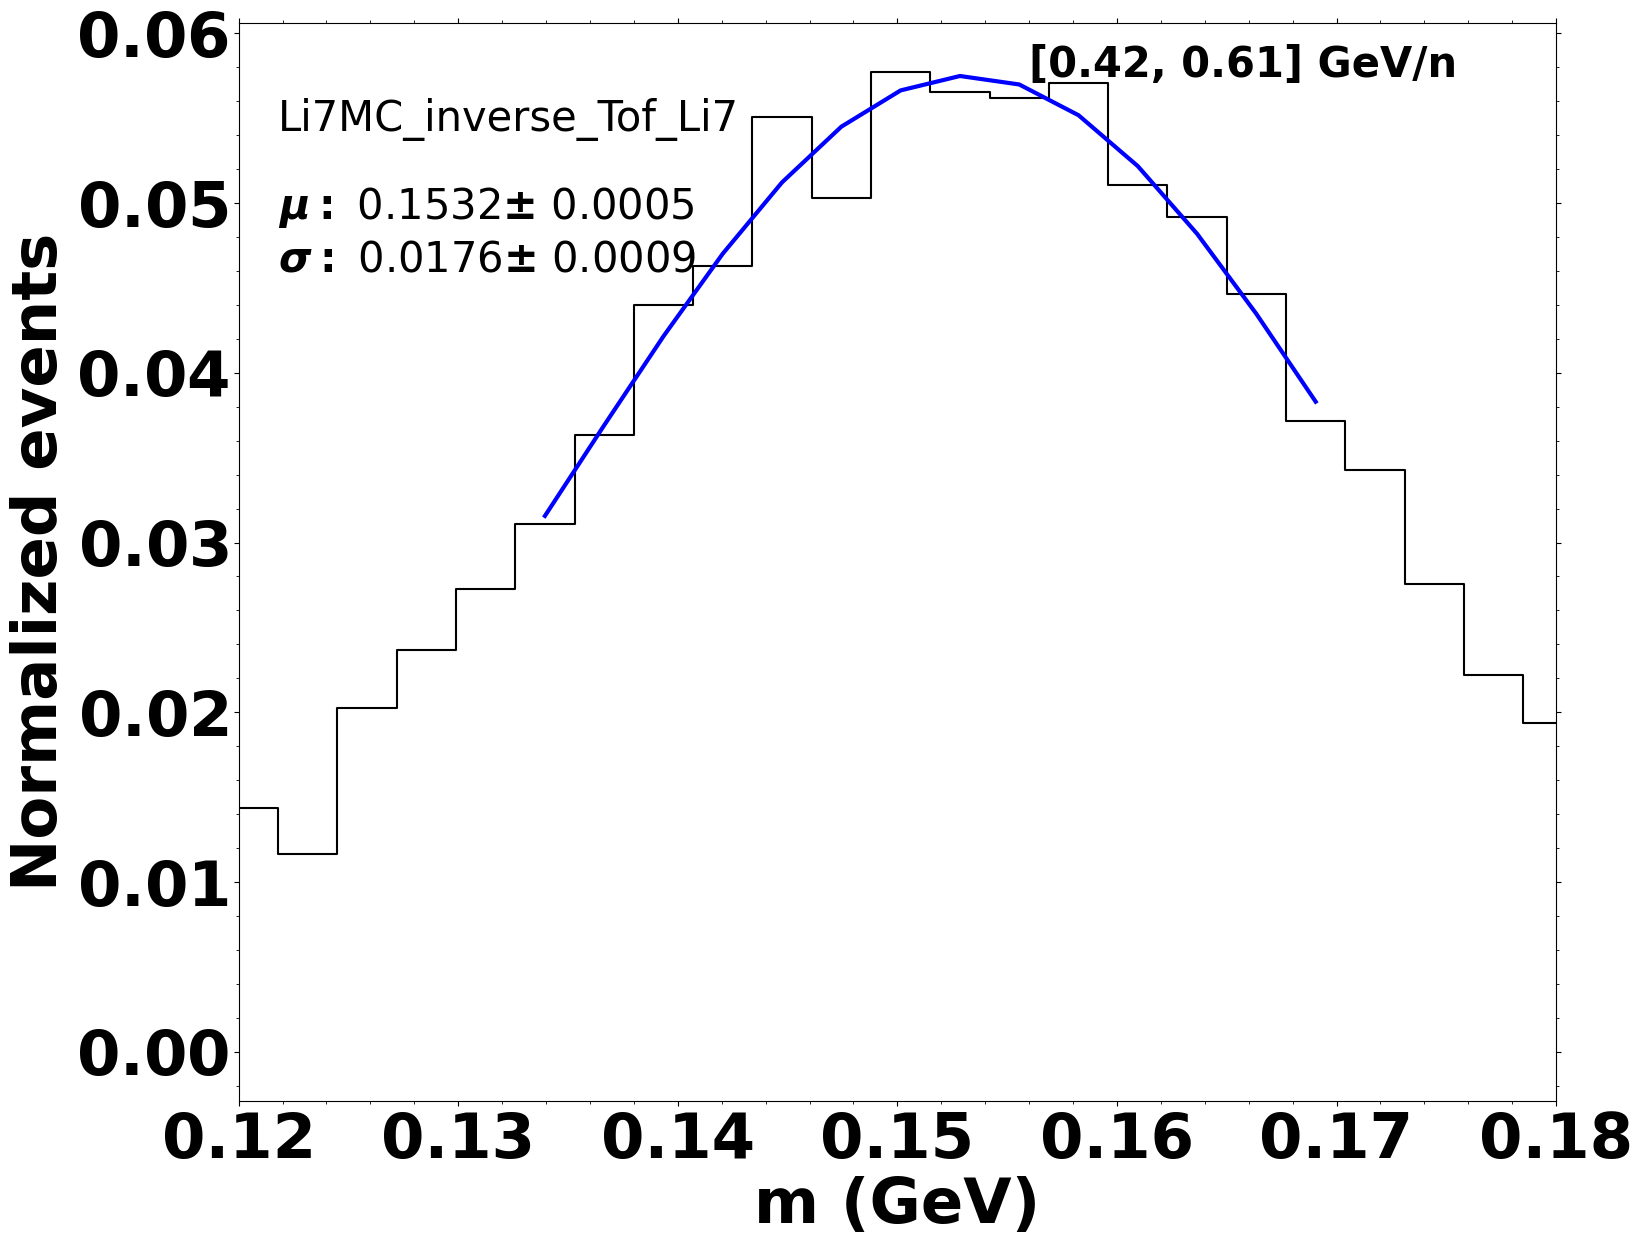

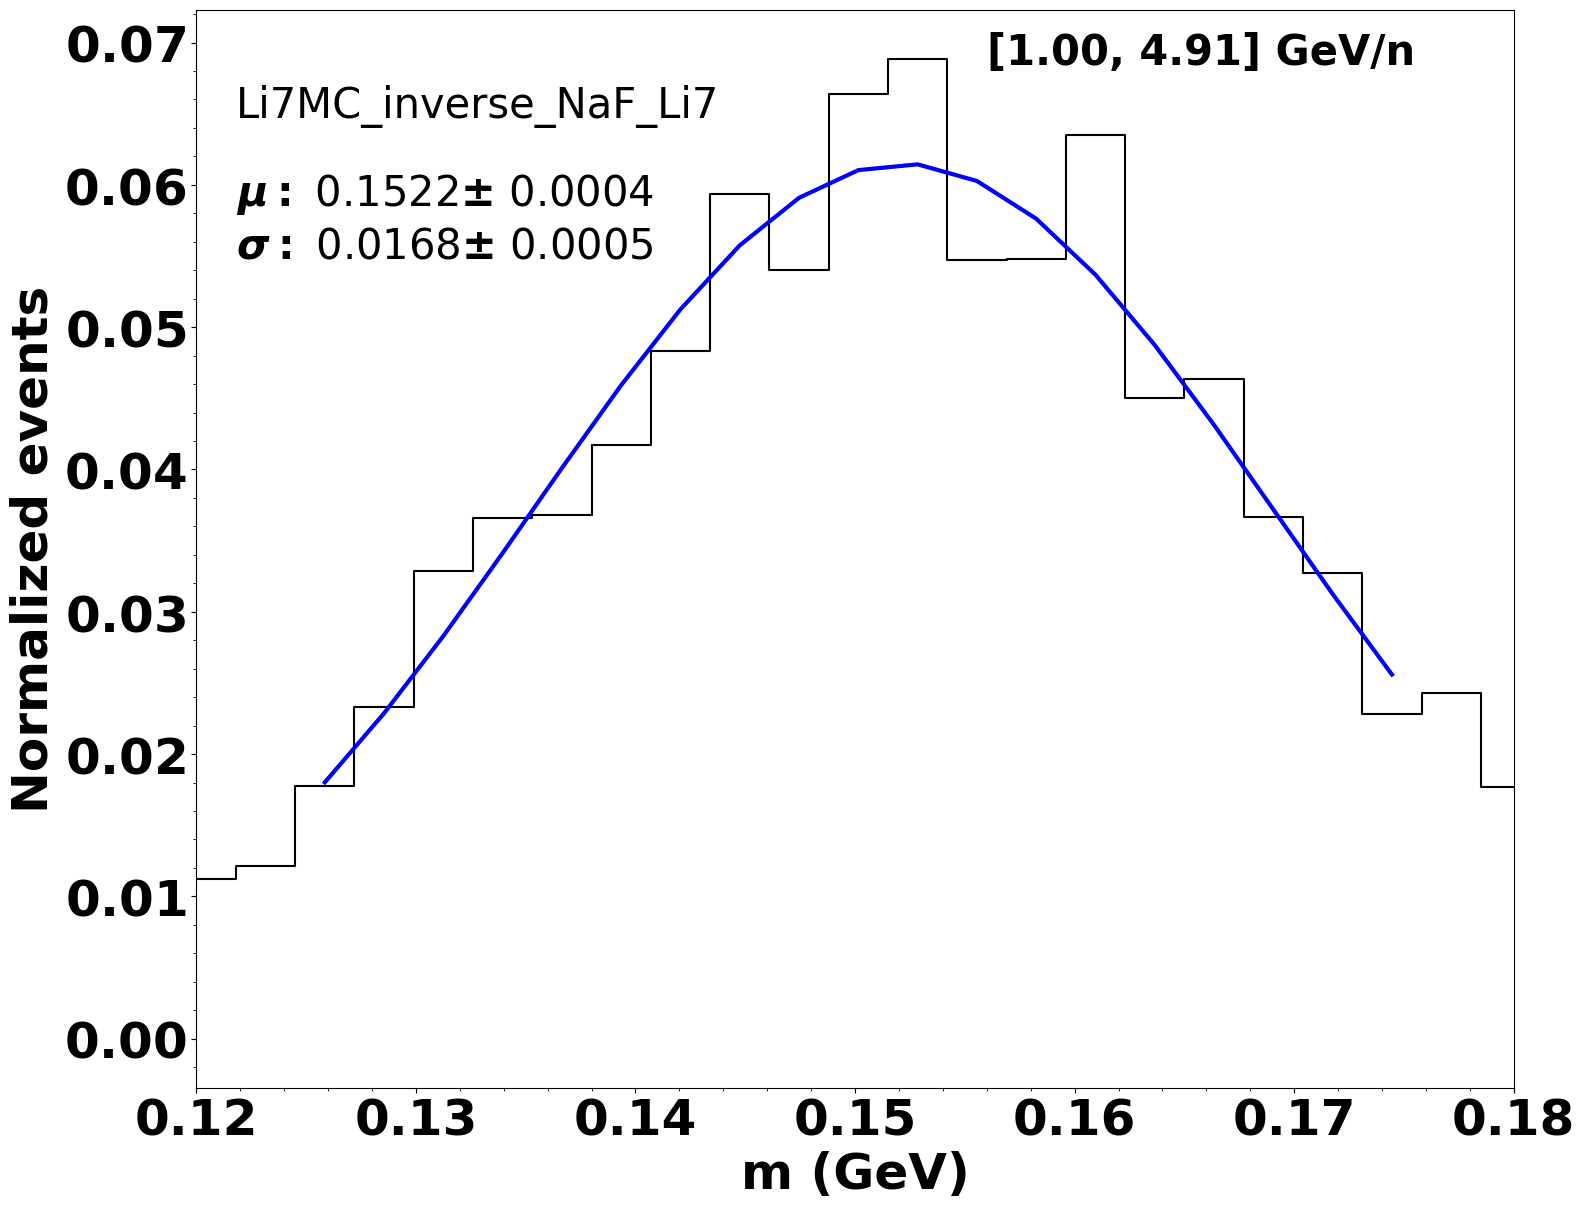

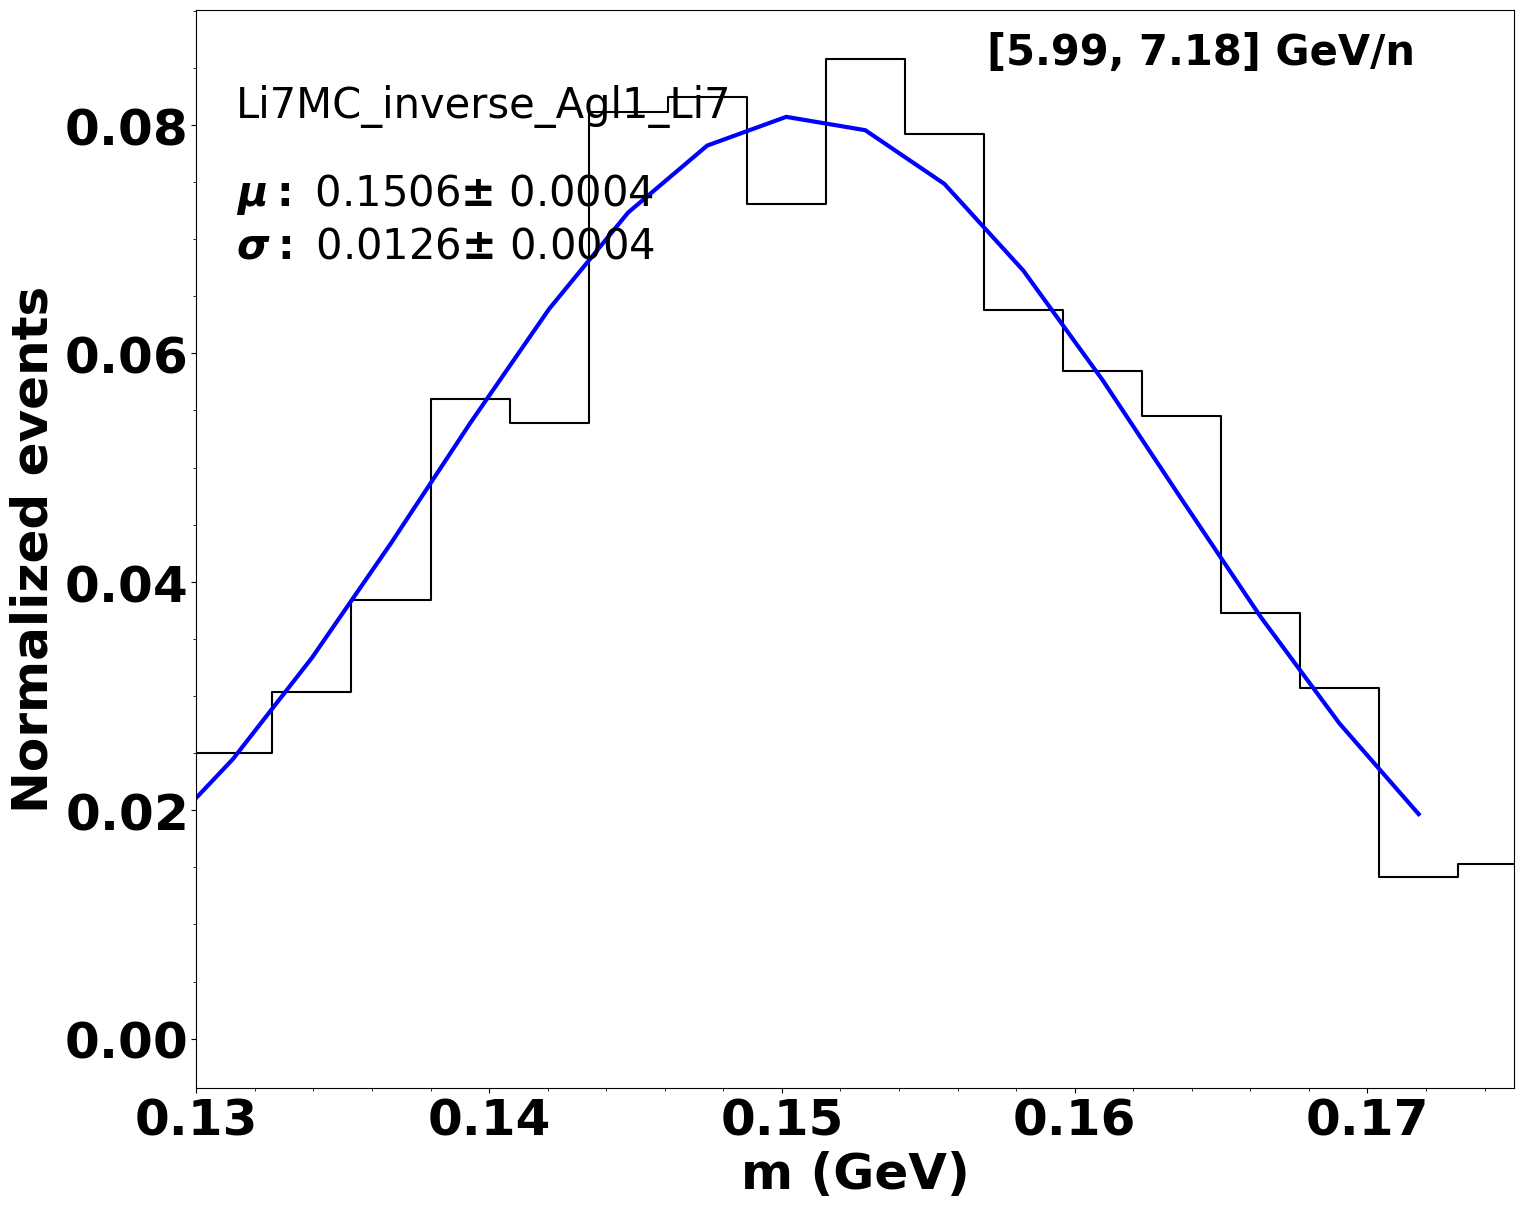

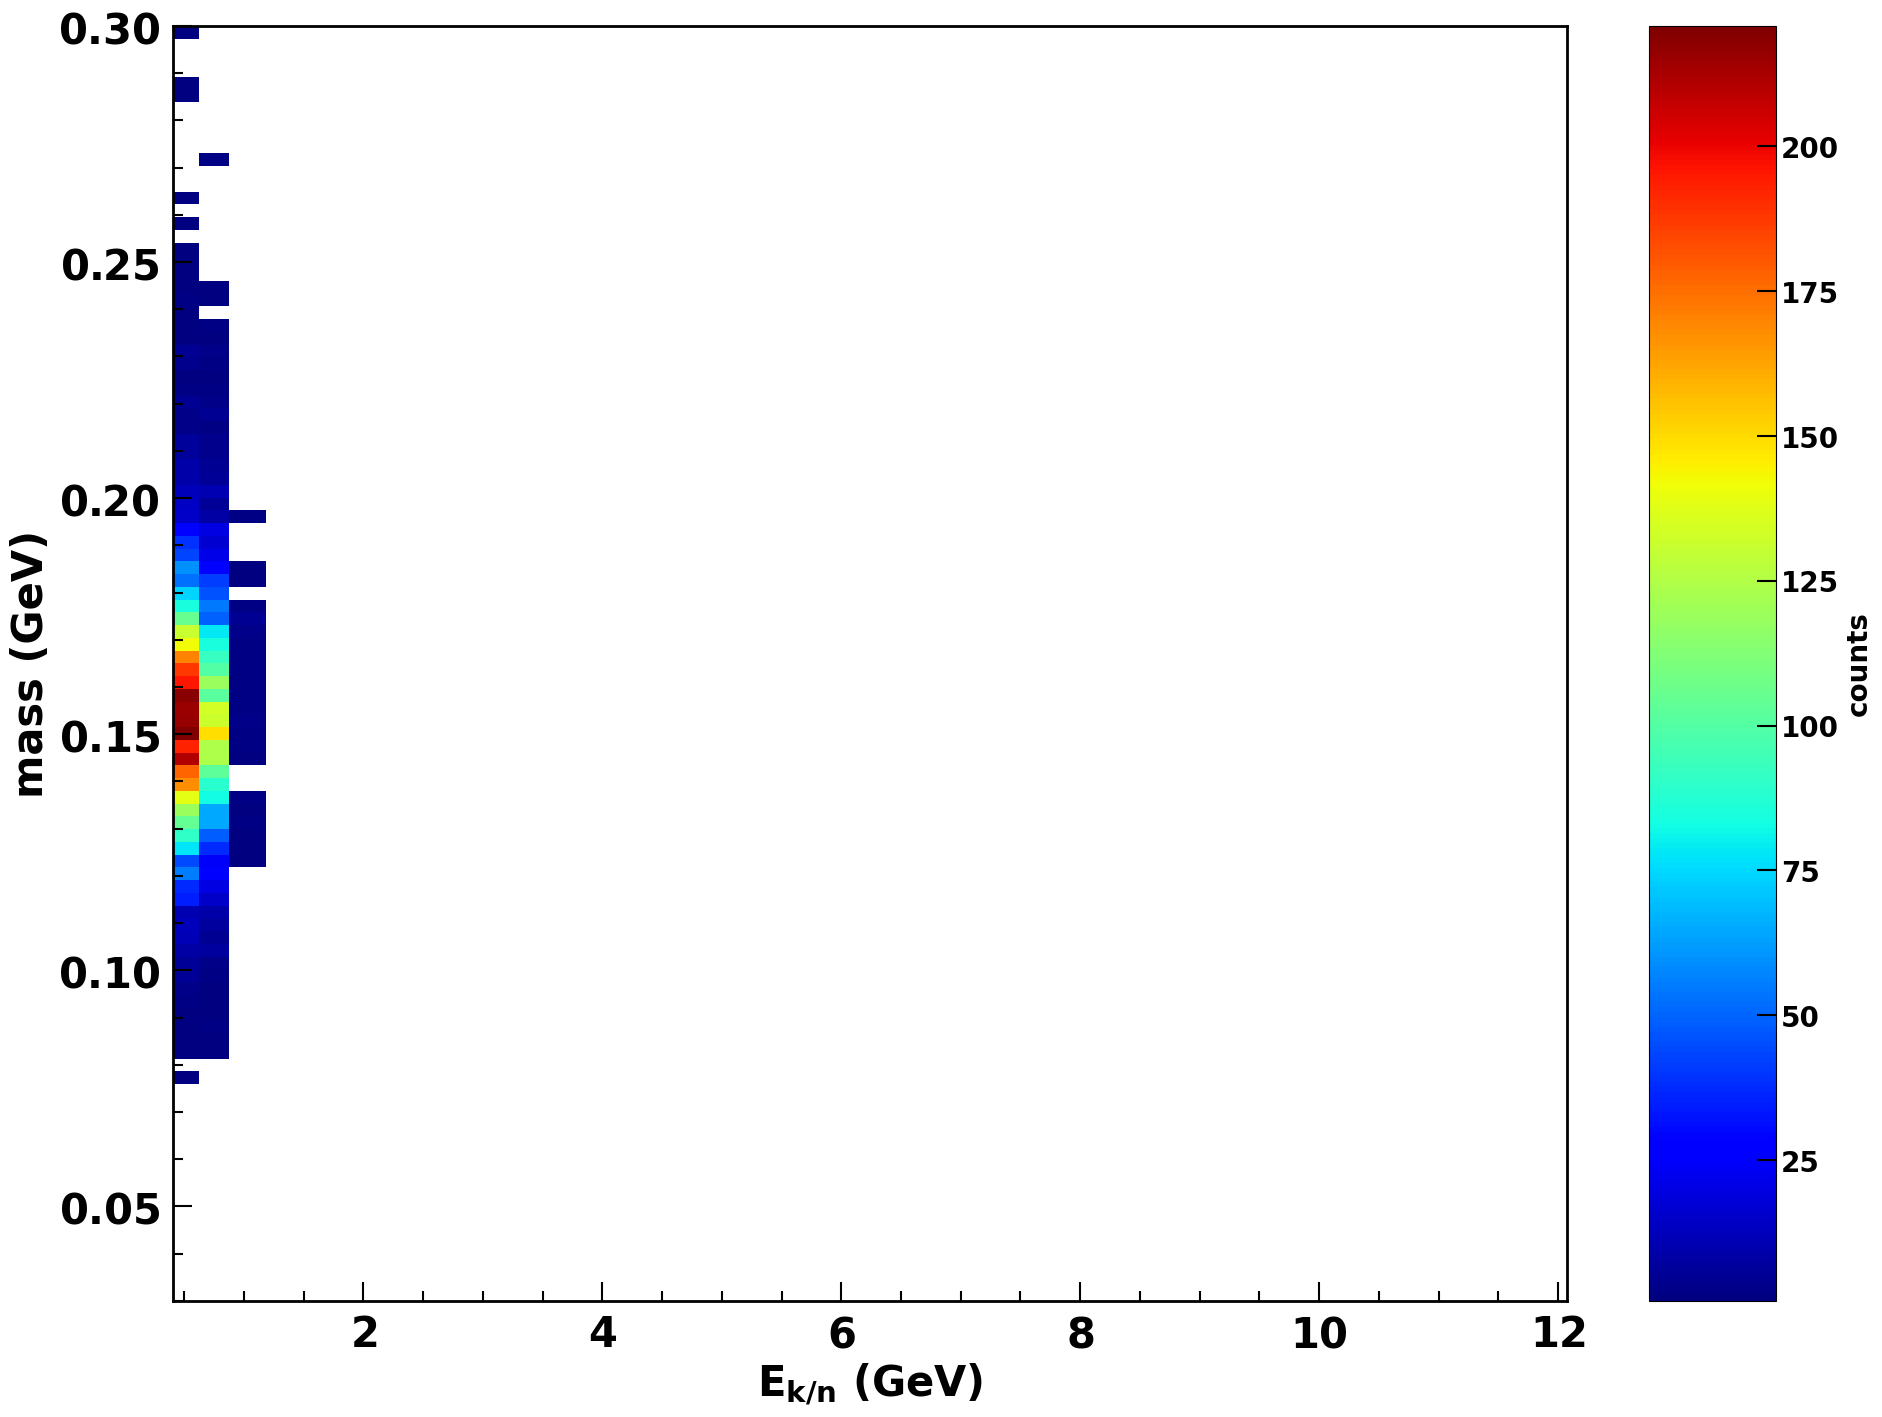

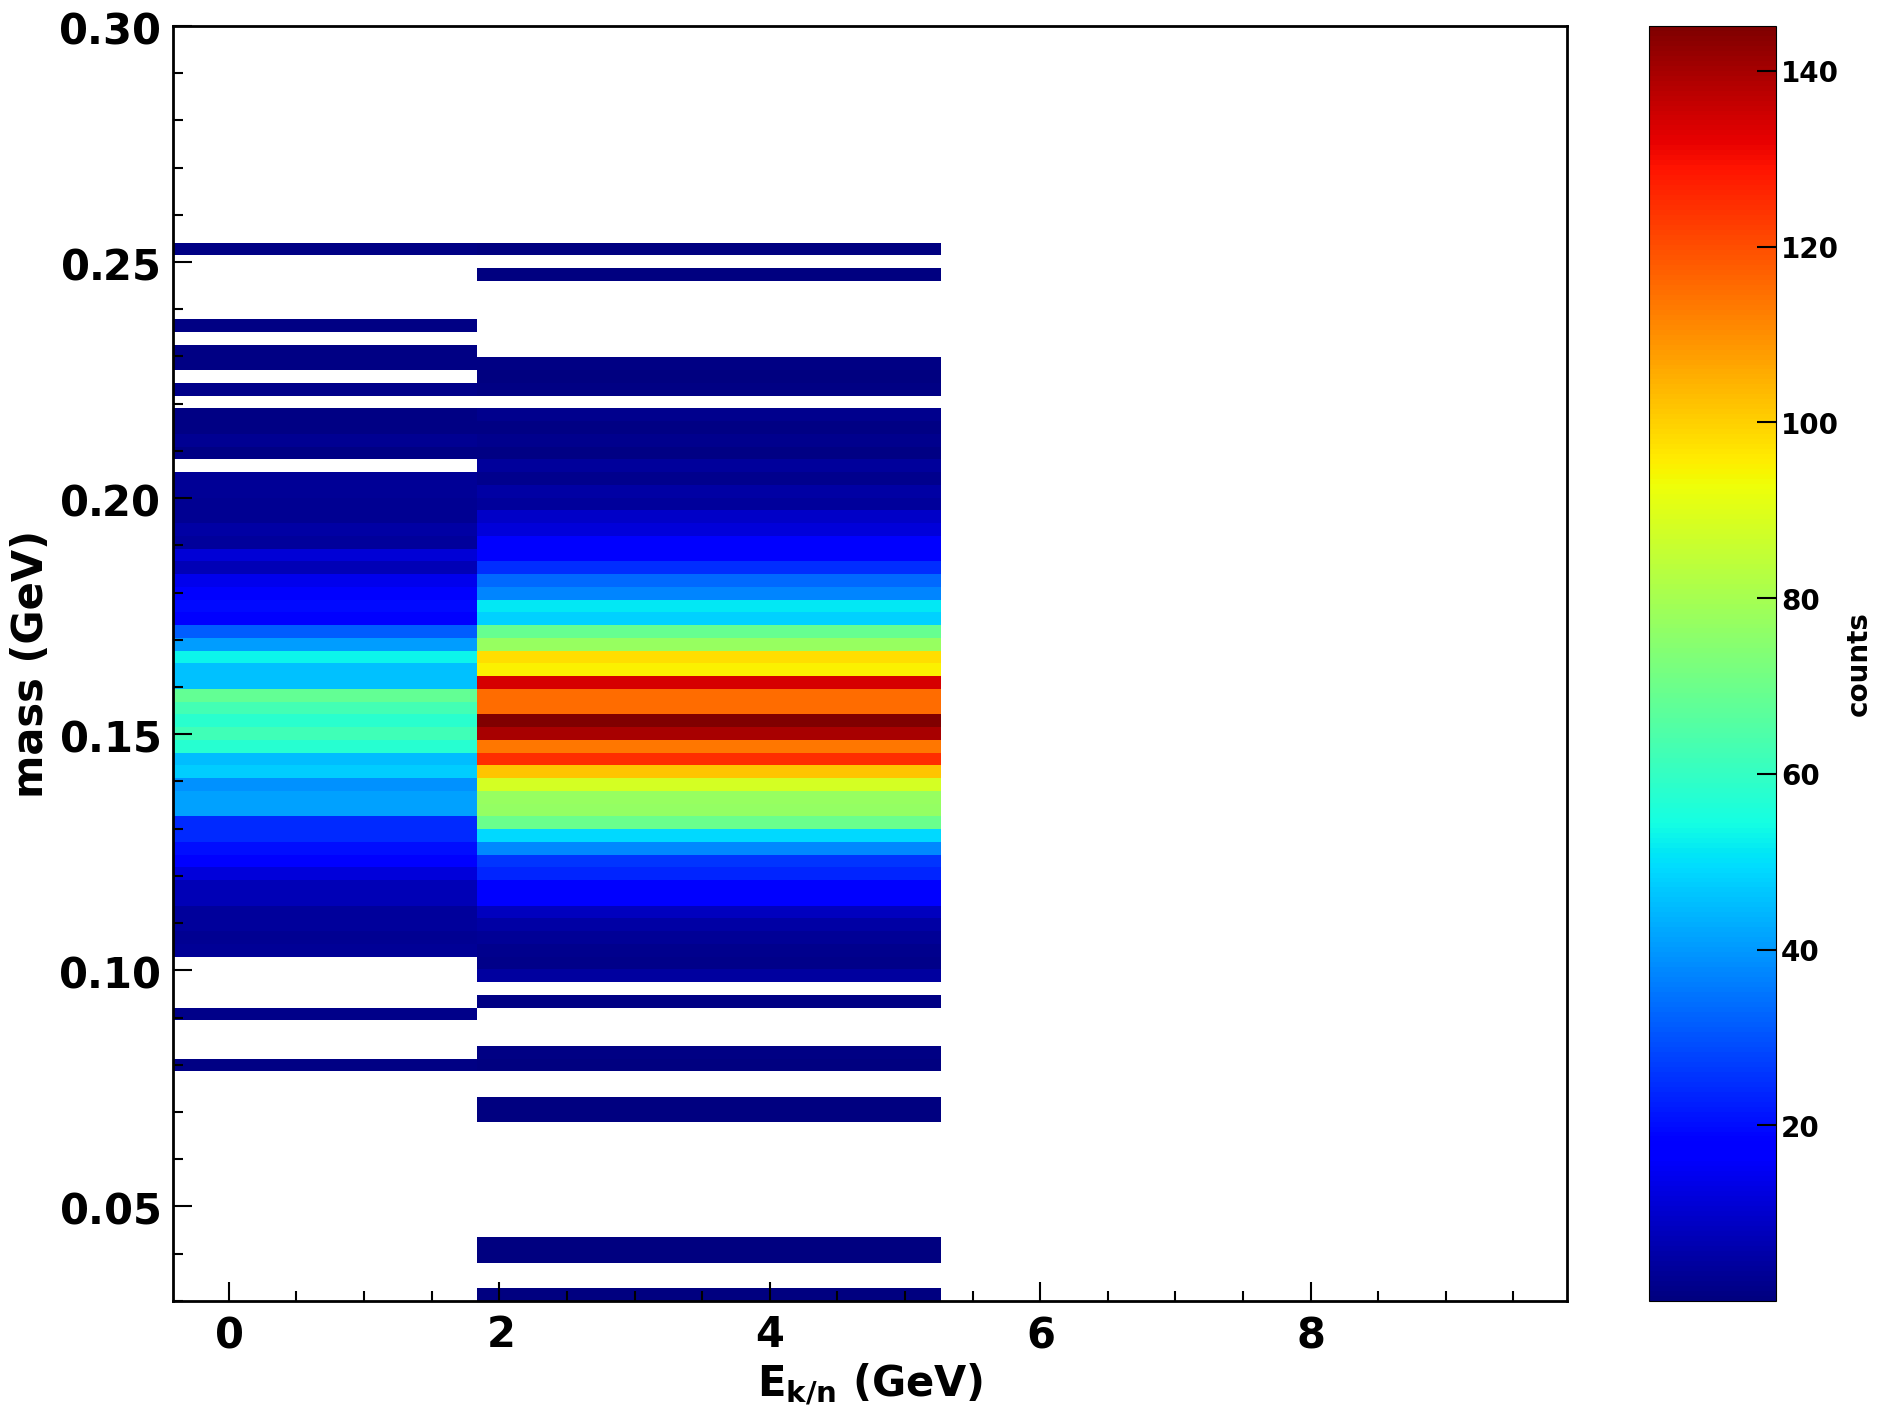

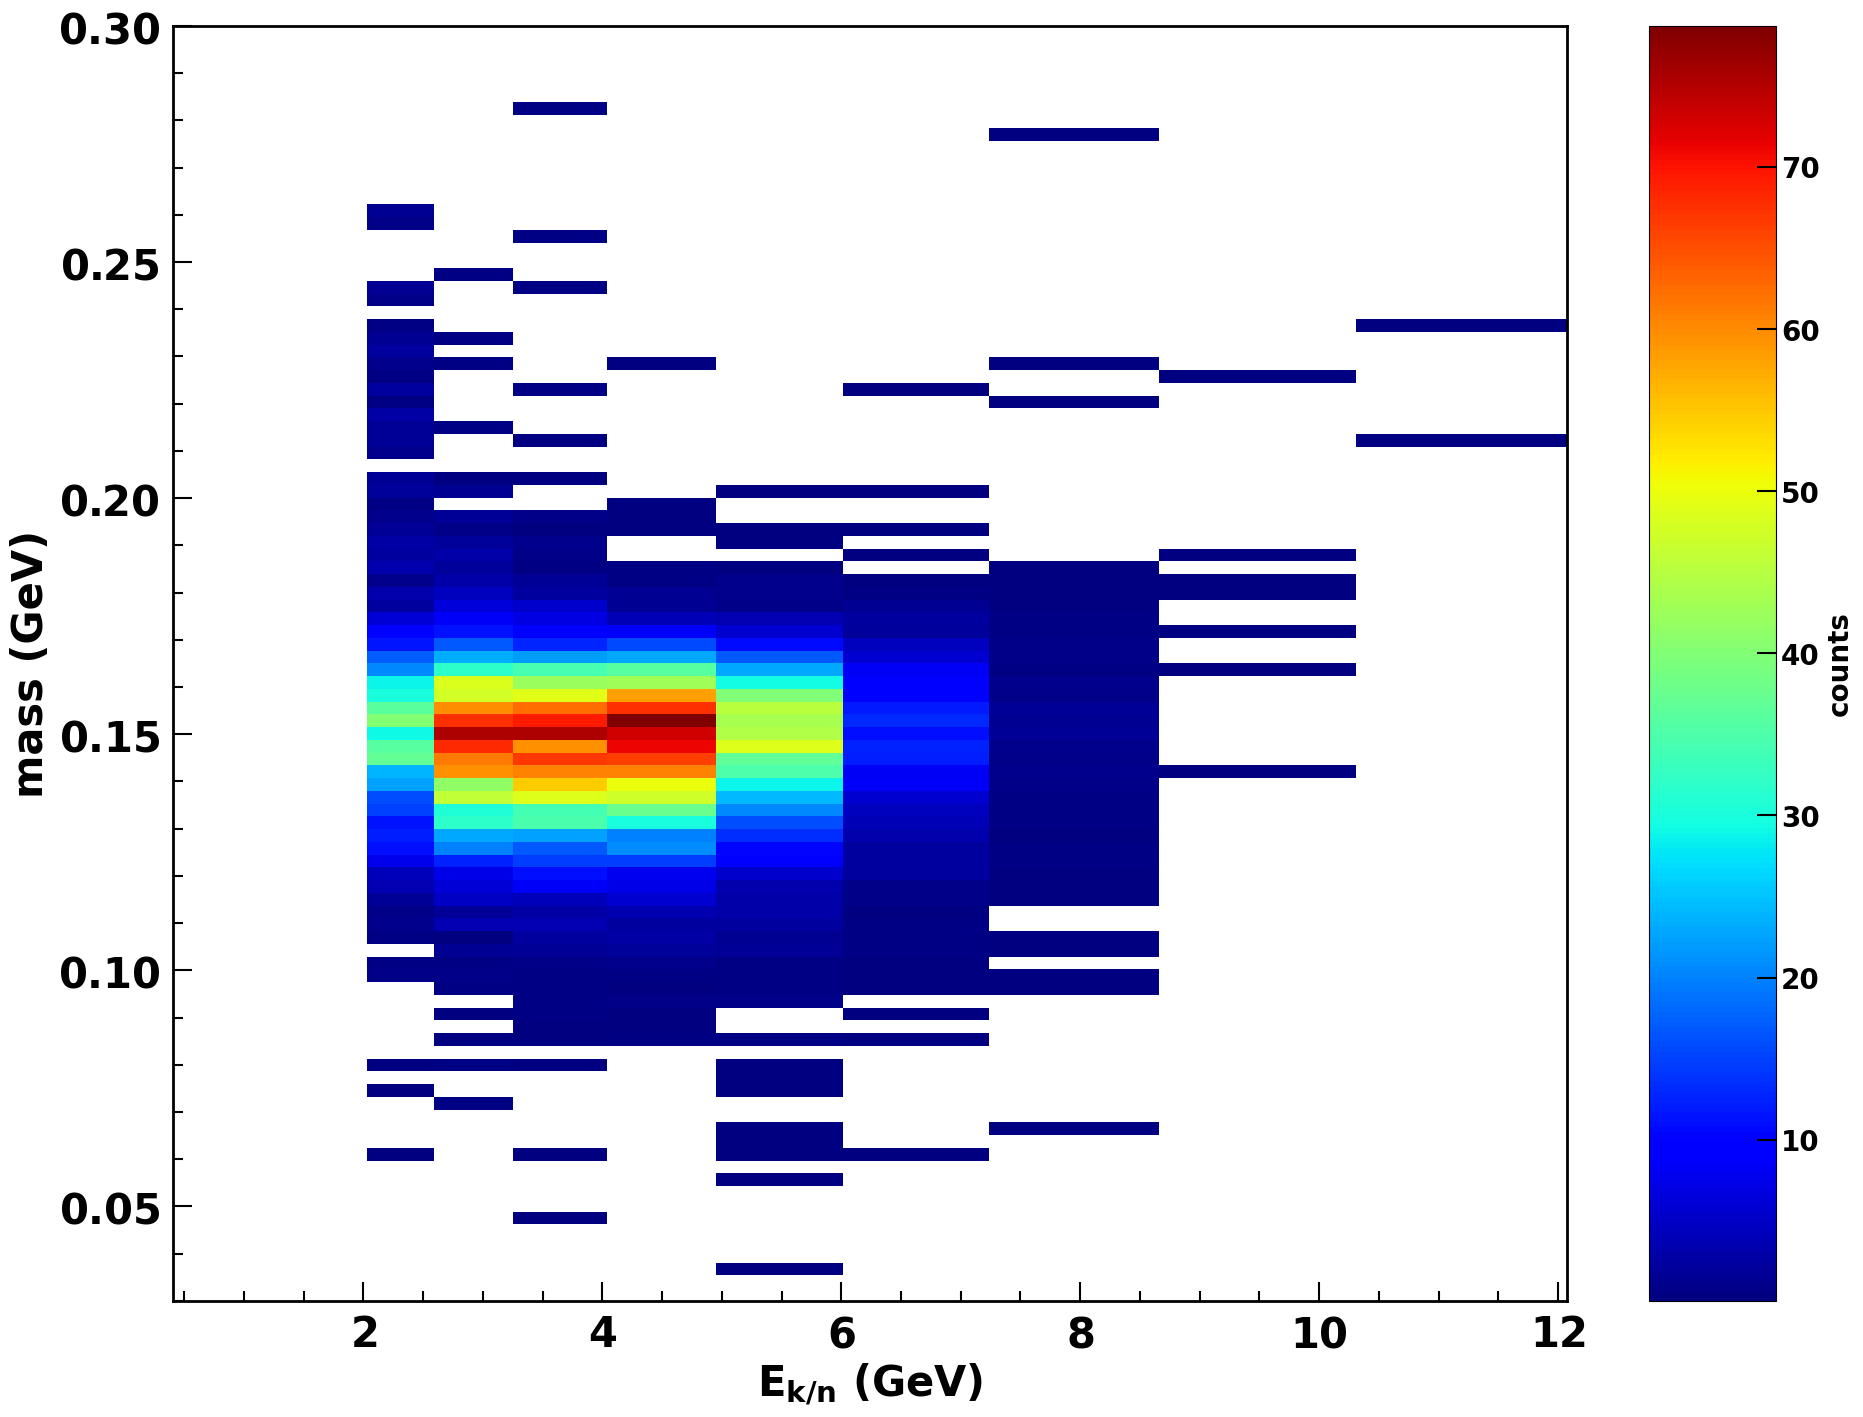

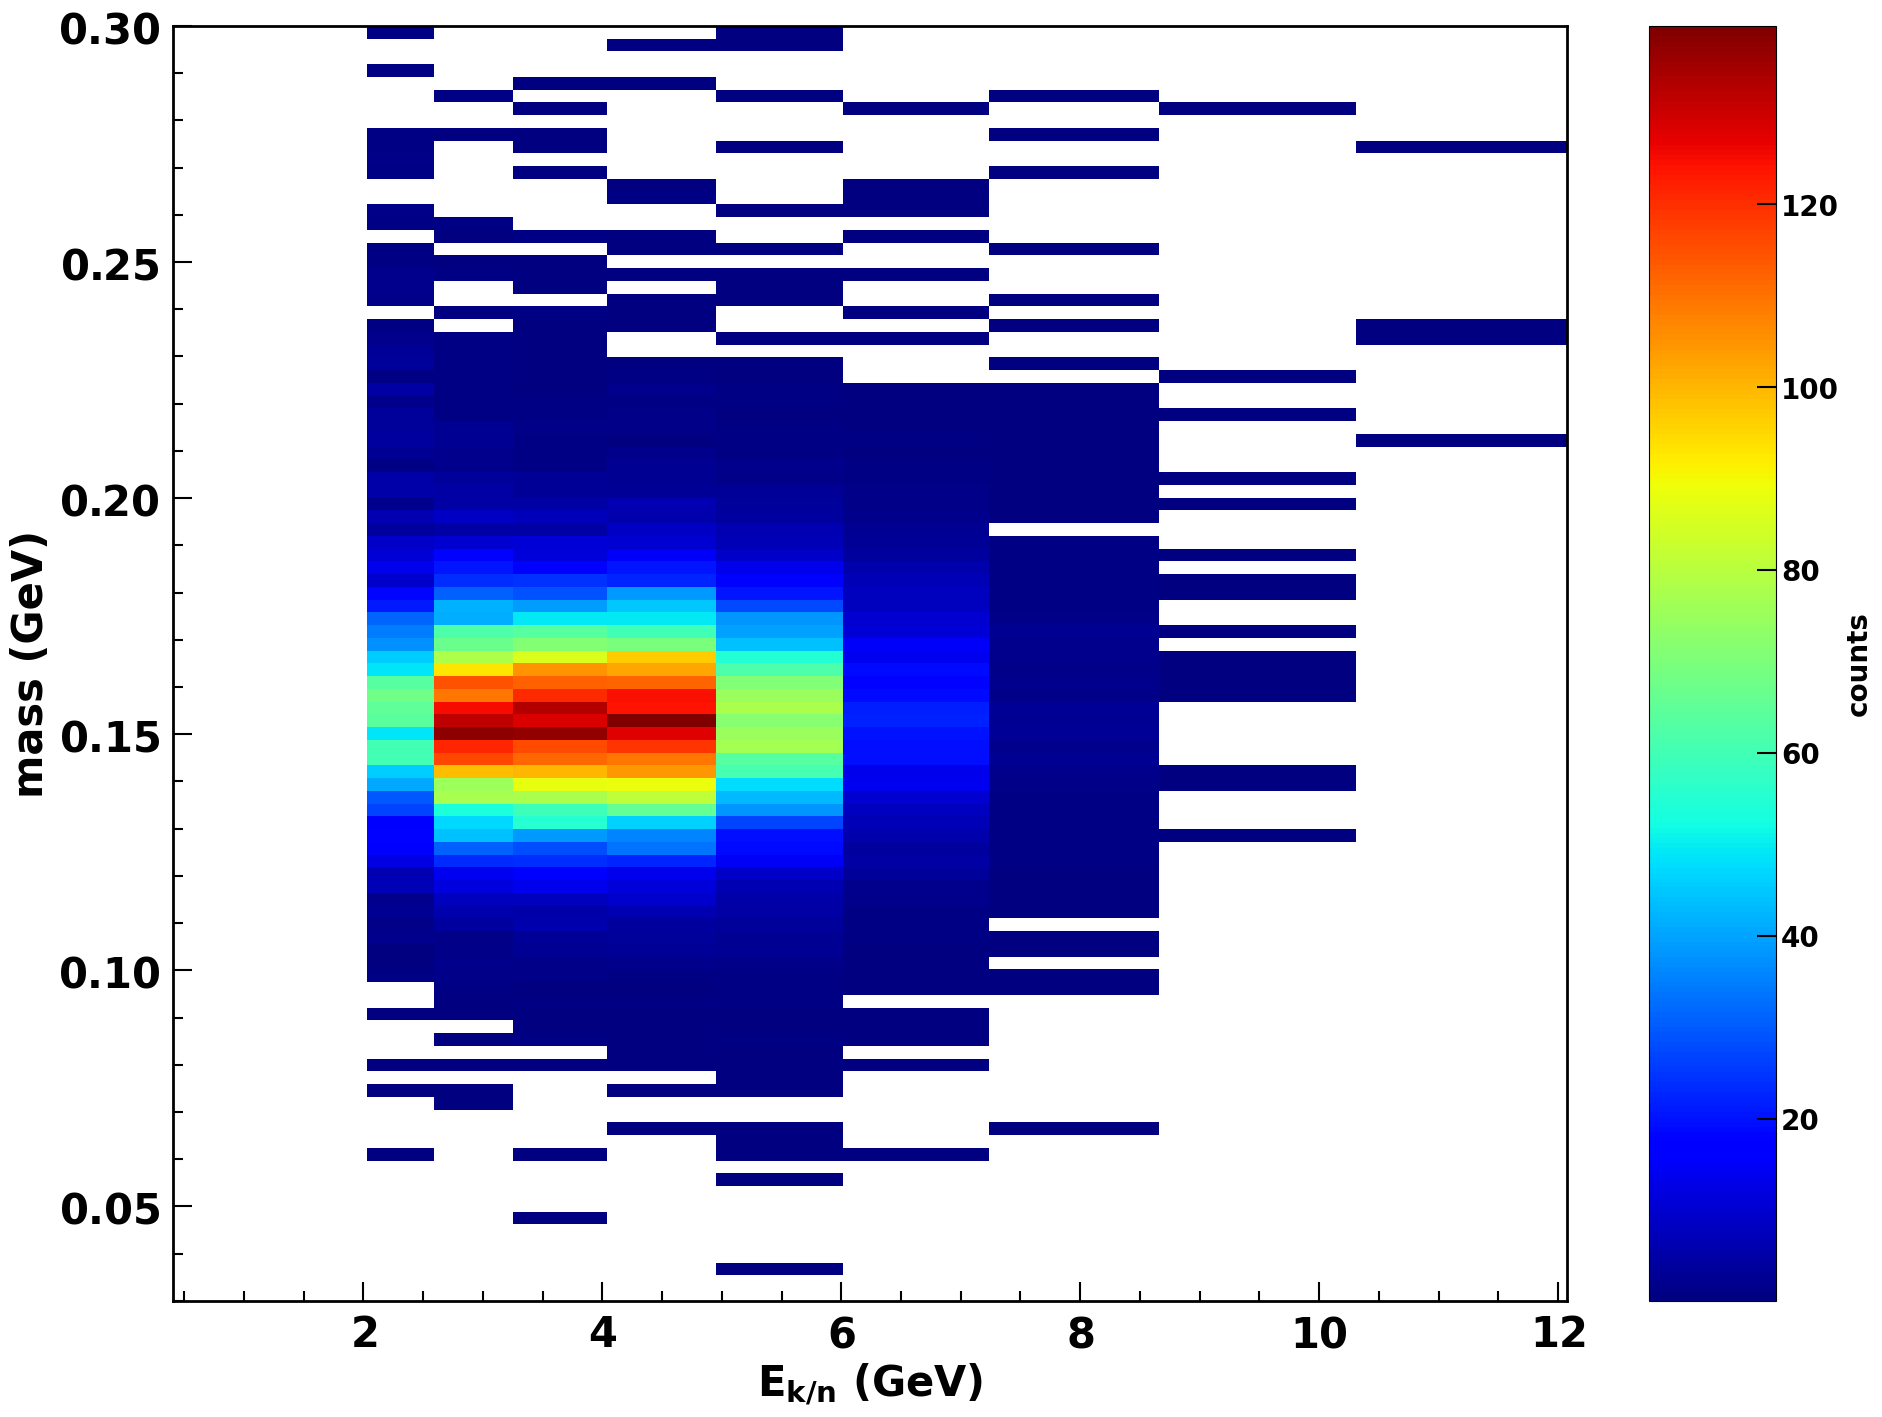

In [32]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'Li7'
fileaddname = 'bkt1_mcgen2'
#file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/Lihist_masscutoff_bkt1_mcrec2.npz'


#filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_{fileaddname}.npz',
#            'NaF':f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_{fileaddname}.npz',
#            'Agl1':f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_{fileaddname}.npz',
#            'Agl2':f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff_{fileaddname}.npz'}

#filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_bkstatv10.npz',
#            'NaF':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_bkstatv10.npz',
#            'Agl1':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Li7hist_masscutoff_bkt1_mcgen2.npz',
#            'Agl2':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Li7hist_masscutoff_bkt1_mcgen2.npz'}


#filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/hist_cutoff/Lihist_masscutoff_ISSbkt1_mcgen_B1308_ShiftTof.npz',
filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/hist_cutoff/Lihist_masscutoff_ISSbkt1_mcgen_B1308.npz',
            'NaF':f'/home/manbing/Documents/Data/data_{Nuclei}P8/hist_cutoff/Lihist_masscutoff_bkstatv10.npz',
            'Agl1':f'/home/manbing/Documents/Data/data_{Nuclei}P8/hist_cutoff/Li7hist_masscutoff_bkt1_mcgen2.npz',
            'Agl2':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_nobkt.npz'}
            

#filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_ISSbkt1_mcgen_B1308_1P5sigma.npz',
#            'NaF':f'/home/manbing/Documents/Data/data_{Nuclei}P8/hist_cutoff/Lihist_masscutoff_ISSbkt1_mcgen_B1308.npz',
#            'Agl1':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_ISSbkt1_mcgen_B1308_1P5sigma.npz',
#            'Agl2':f'/home/manbing/Documents/Data/data_{Nuclei}P8/Lihist_masscutoff_nobkt.npz'}

detectors = ['Tof', 'NaF', 'Agl1', 'Agl2']
filename = {dec: filename[dec] for dec in detectors}
mtype = 'inv'
hist2dmass = {}



#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
#xrange = {'Tof': [0.09, 0.12], 'NaF': [0.09, 0.12], 'Agl': [0.09, 0.12]}
minbin = {'Tof': 1, 'NaF':2, 'Agl1':11, 'Agl2':12}
maxbin =  {'Tof':2,  'NaF':3, 'Agl1':12, 'Agl2':12}
sigmafactor = {'Tof':1.0,  'NaF':1.5, 'Agl1':2.0, 'Agl2':2.0}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
xrange = {'Tof': [0.12, 0.18], 'NaF': [0.12, 0.18], 'Agl1': [0.13, 0.175], 'Agl2': [0.13, 0.175]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}


for dec in detectors:
    
    if 'Agl' in dec: 
        decname = 'Agl'
    else:
        decname = dec
    with np.load(filename[dec]) as histfile:      
        hist2dmass[dec] = WeightedHistogram.from_file(histfile, f"{iso}MC_{decname}_inversemasscutoff")  
        graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile, sigmafactor=sigmafactor[dec])
        print(graph_mean_mcLi7[dec])

for dec in detectors:  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot2dhist(fig, plot, xbinning=hist2dmass[dec].binnings[0].edges[1:-1], 
               ybinning=hist2dmass[dec].binnings[1].edges[1:-1],                                                                                                                        
               counts=hist2dmass[dec].values[1:-1, 1:-1],                                                                                                                               
               xlabel=r'$\mathrm{E_{k/n} \ (GeV)}$', ylabel='mass (GeV)', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)    
    savefig_tofile(fig, plotfile, f"hist2d_Li7Cutoff_MC_inversemass_{dec}_{figName}", show=True)    




xvalues			yvalues			yerrs
0.5144			0.1541195922671629			0.0005869157945031636


xvalues			yvalues			yerrs
2.9573			0.1516080985837089			0.000298406956520349


xvalues			yvalues			yerrs
6.58395			0.1505073159936689			0.0005244768688547488


xvalues			yvalues			yerrs



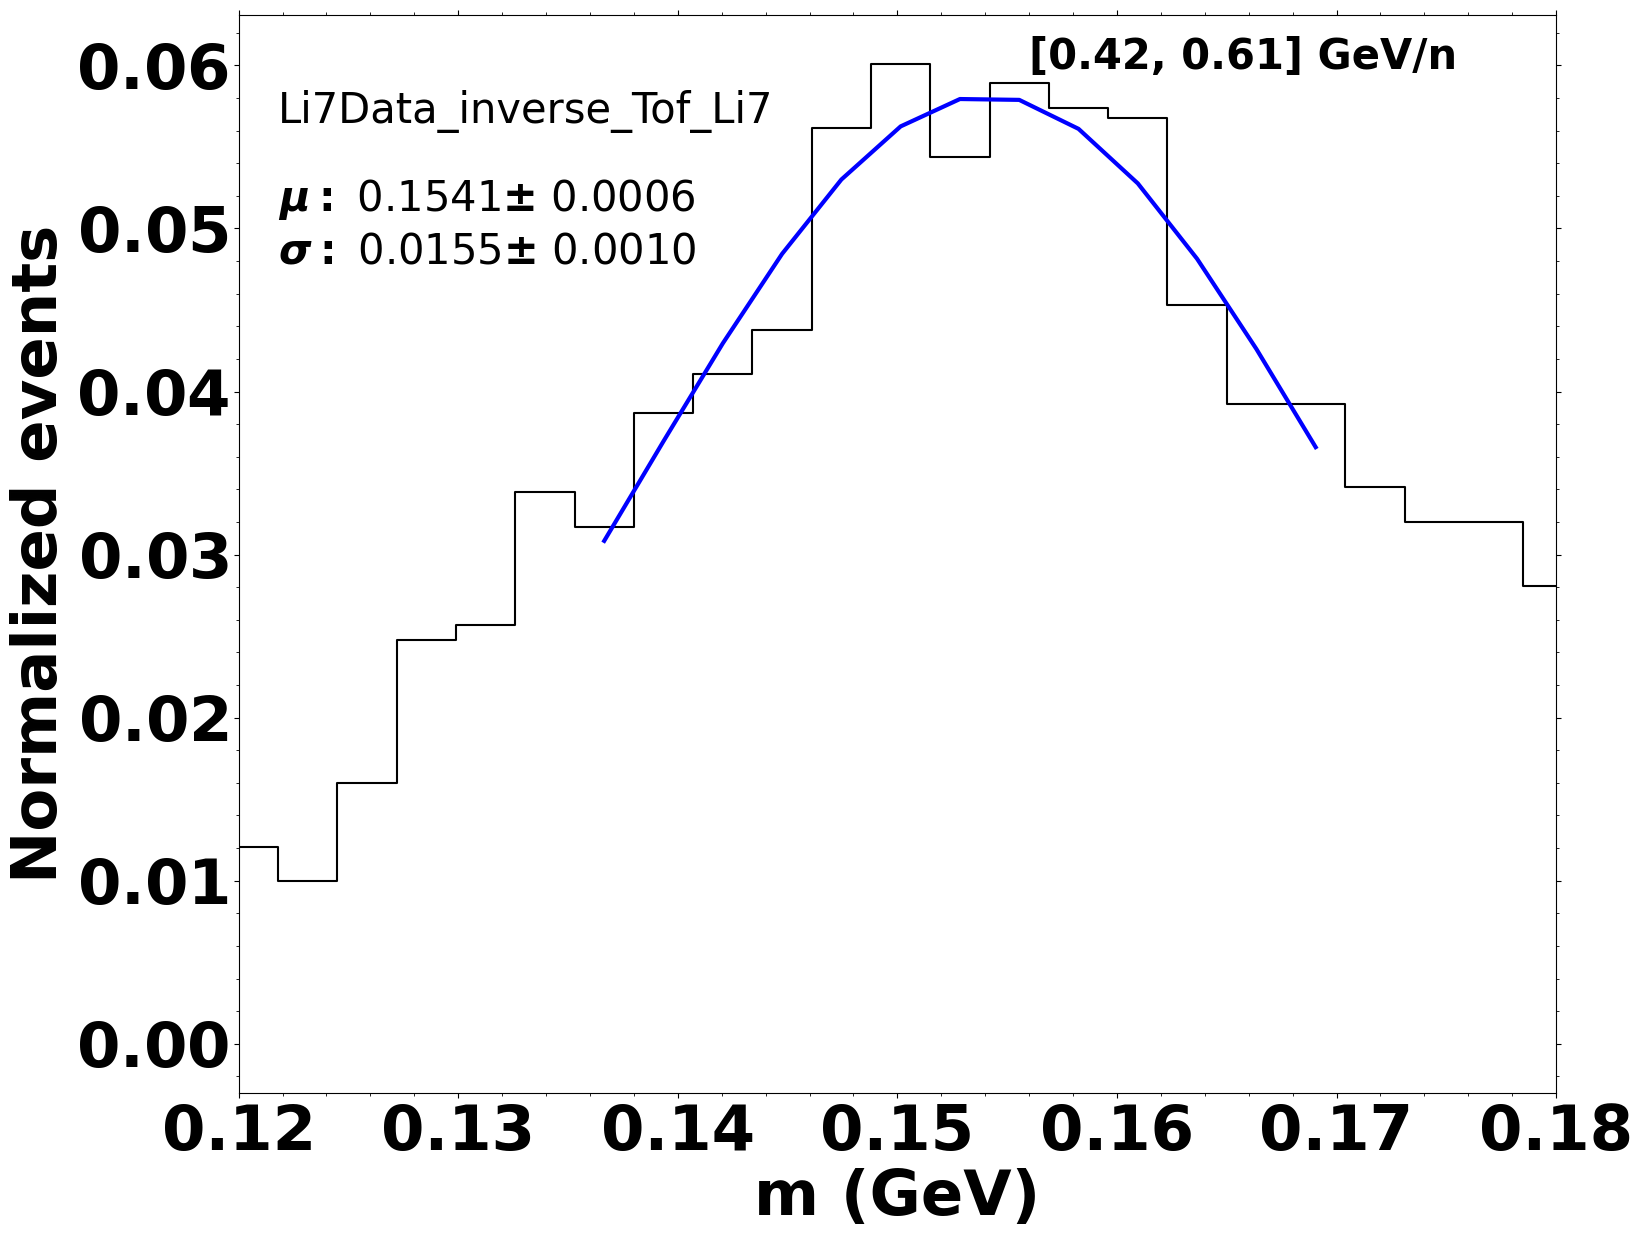

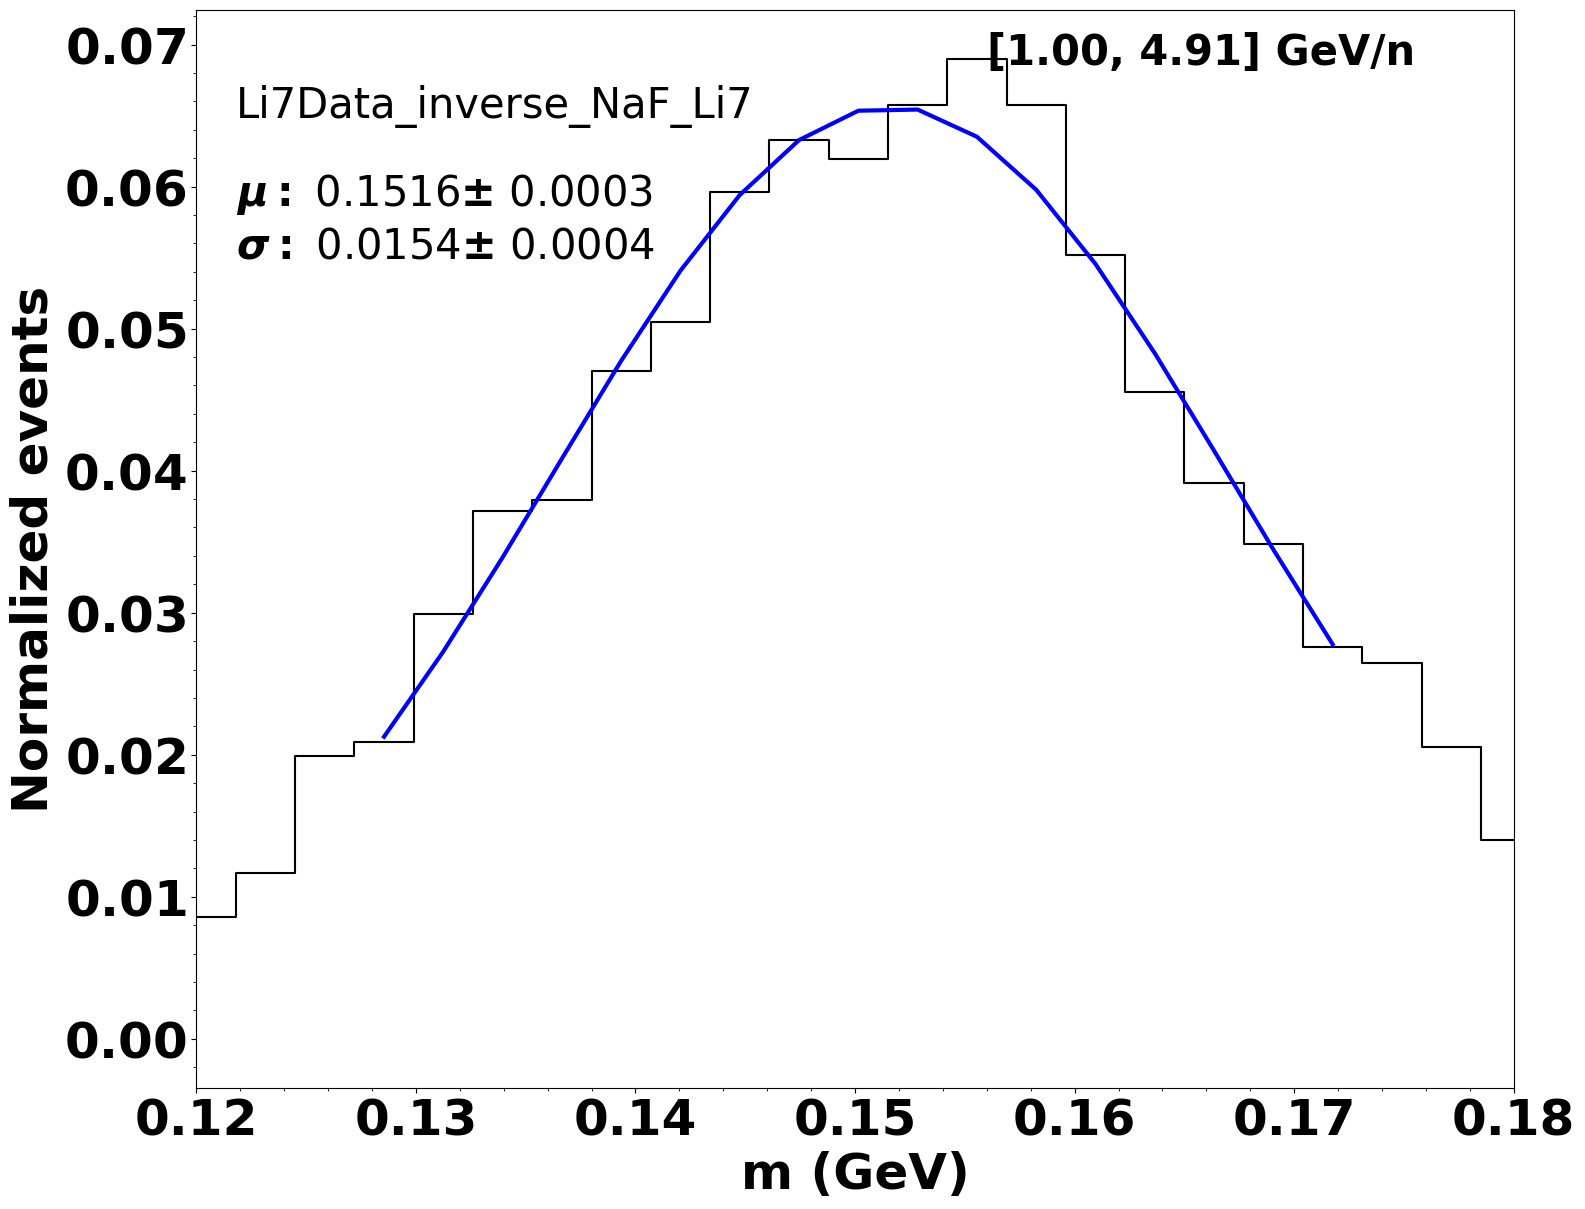

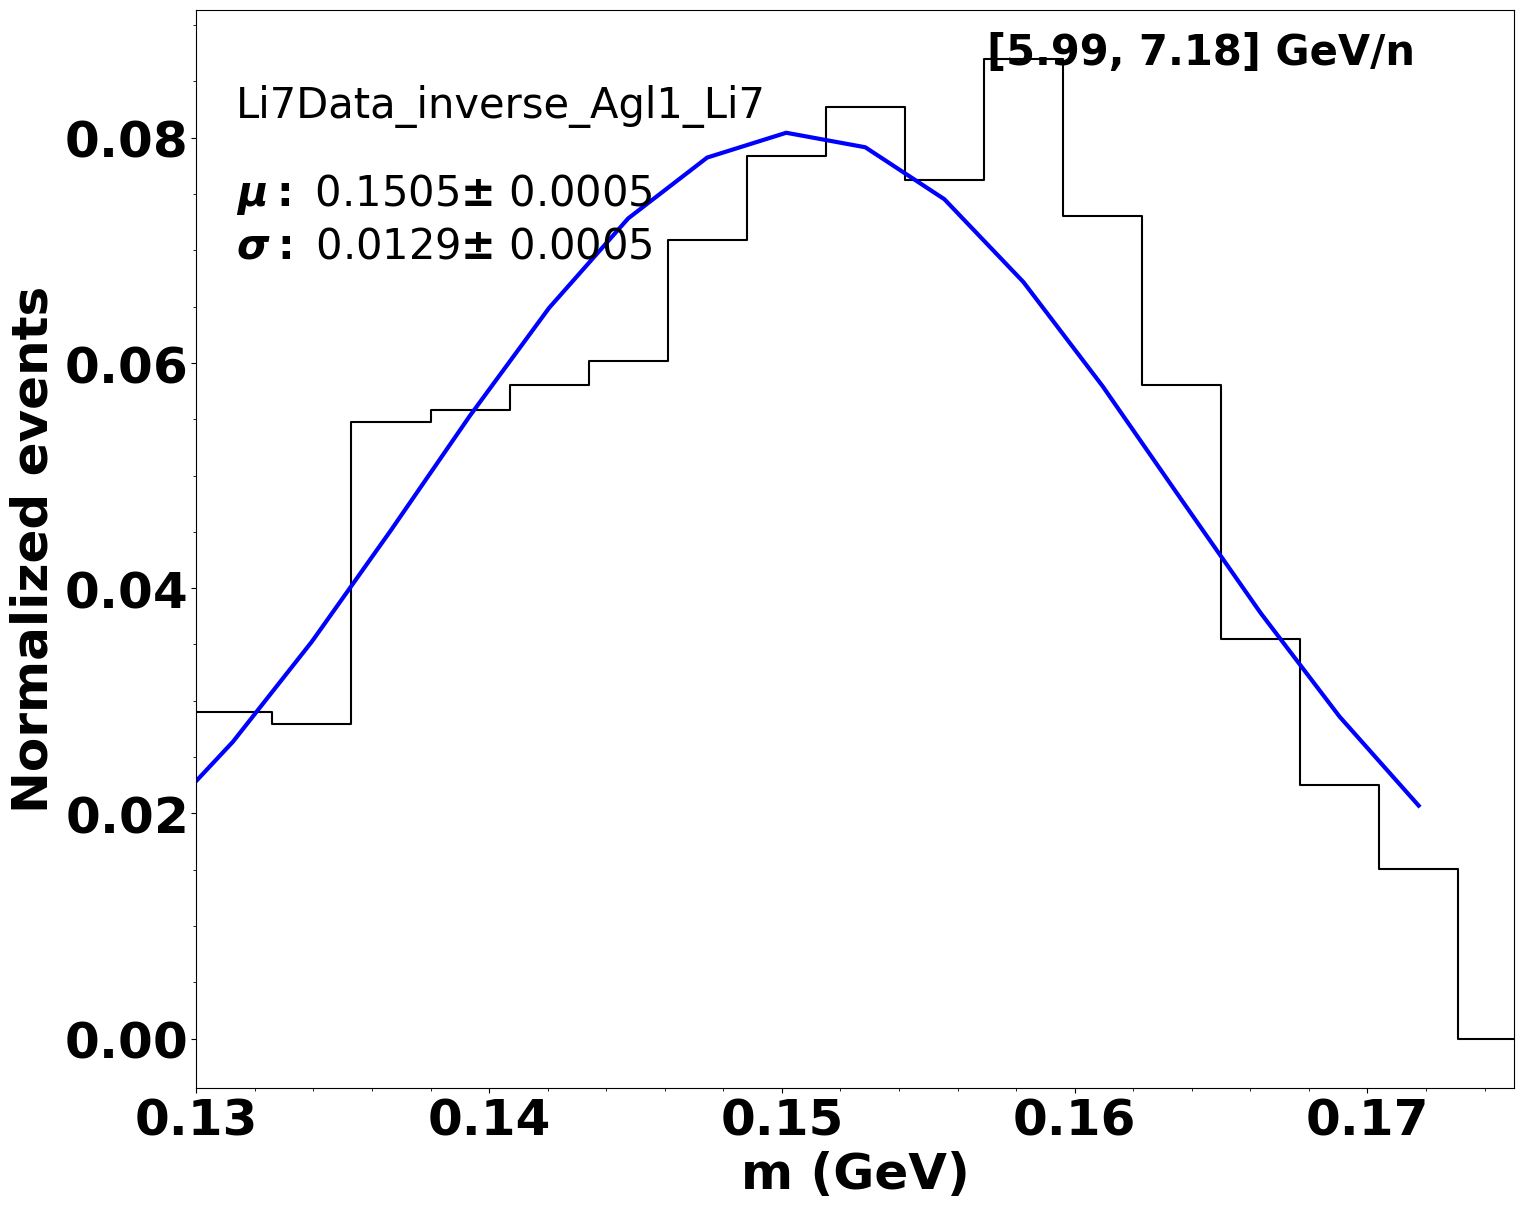

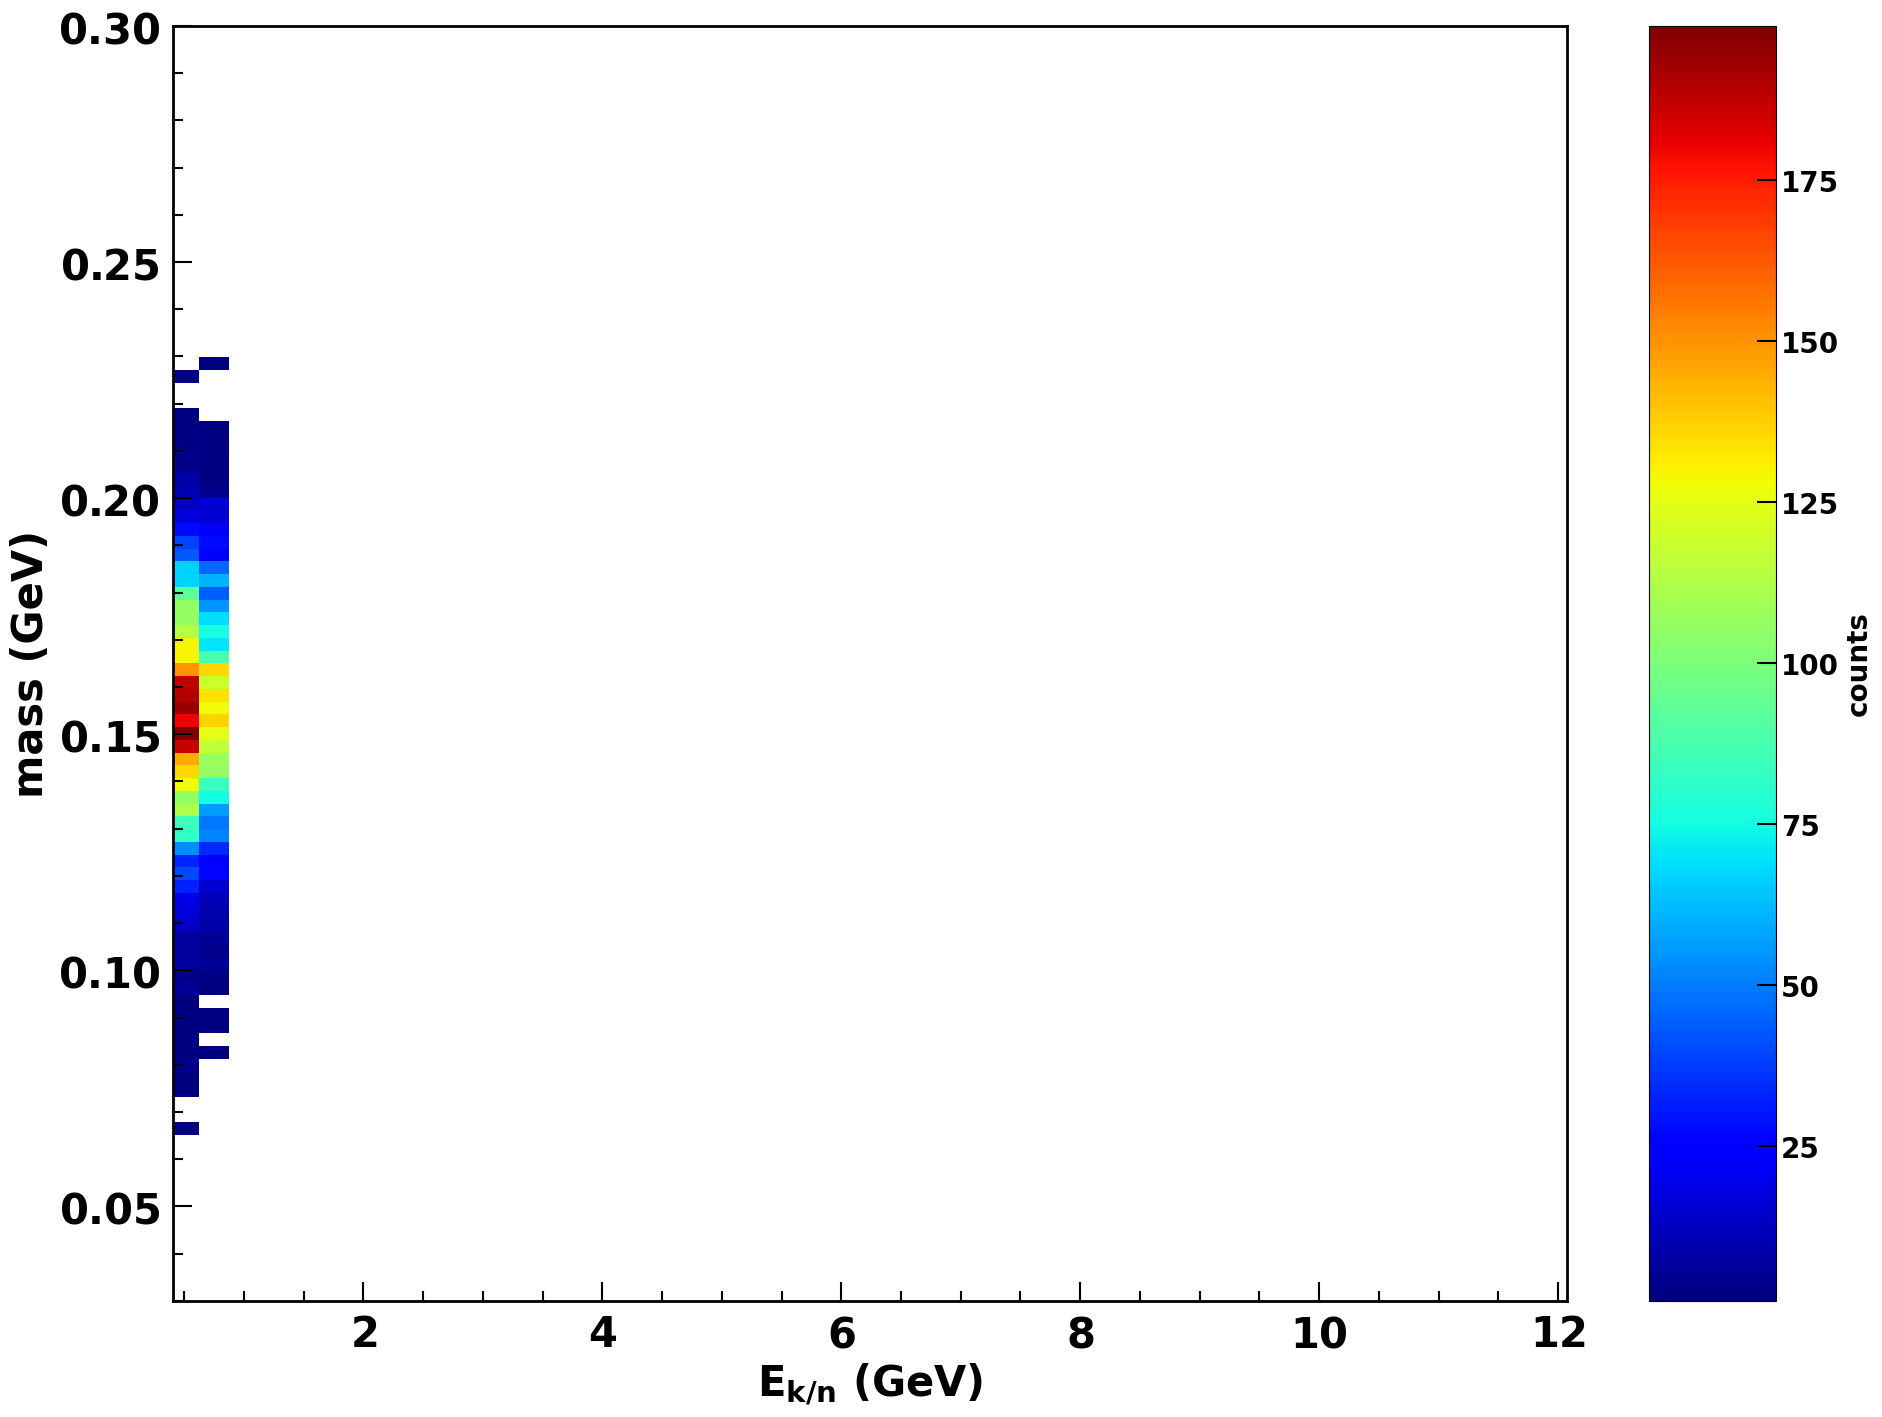

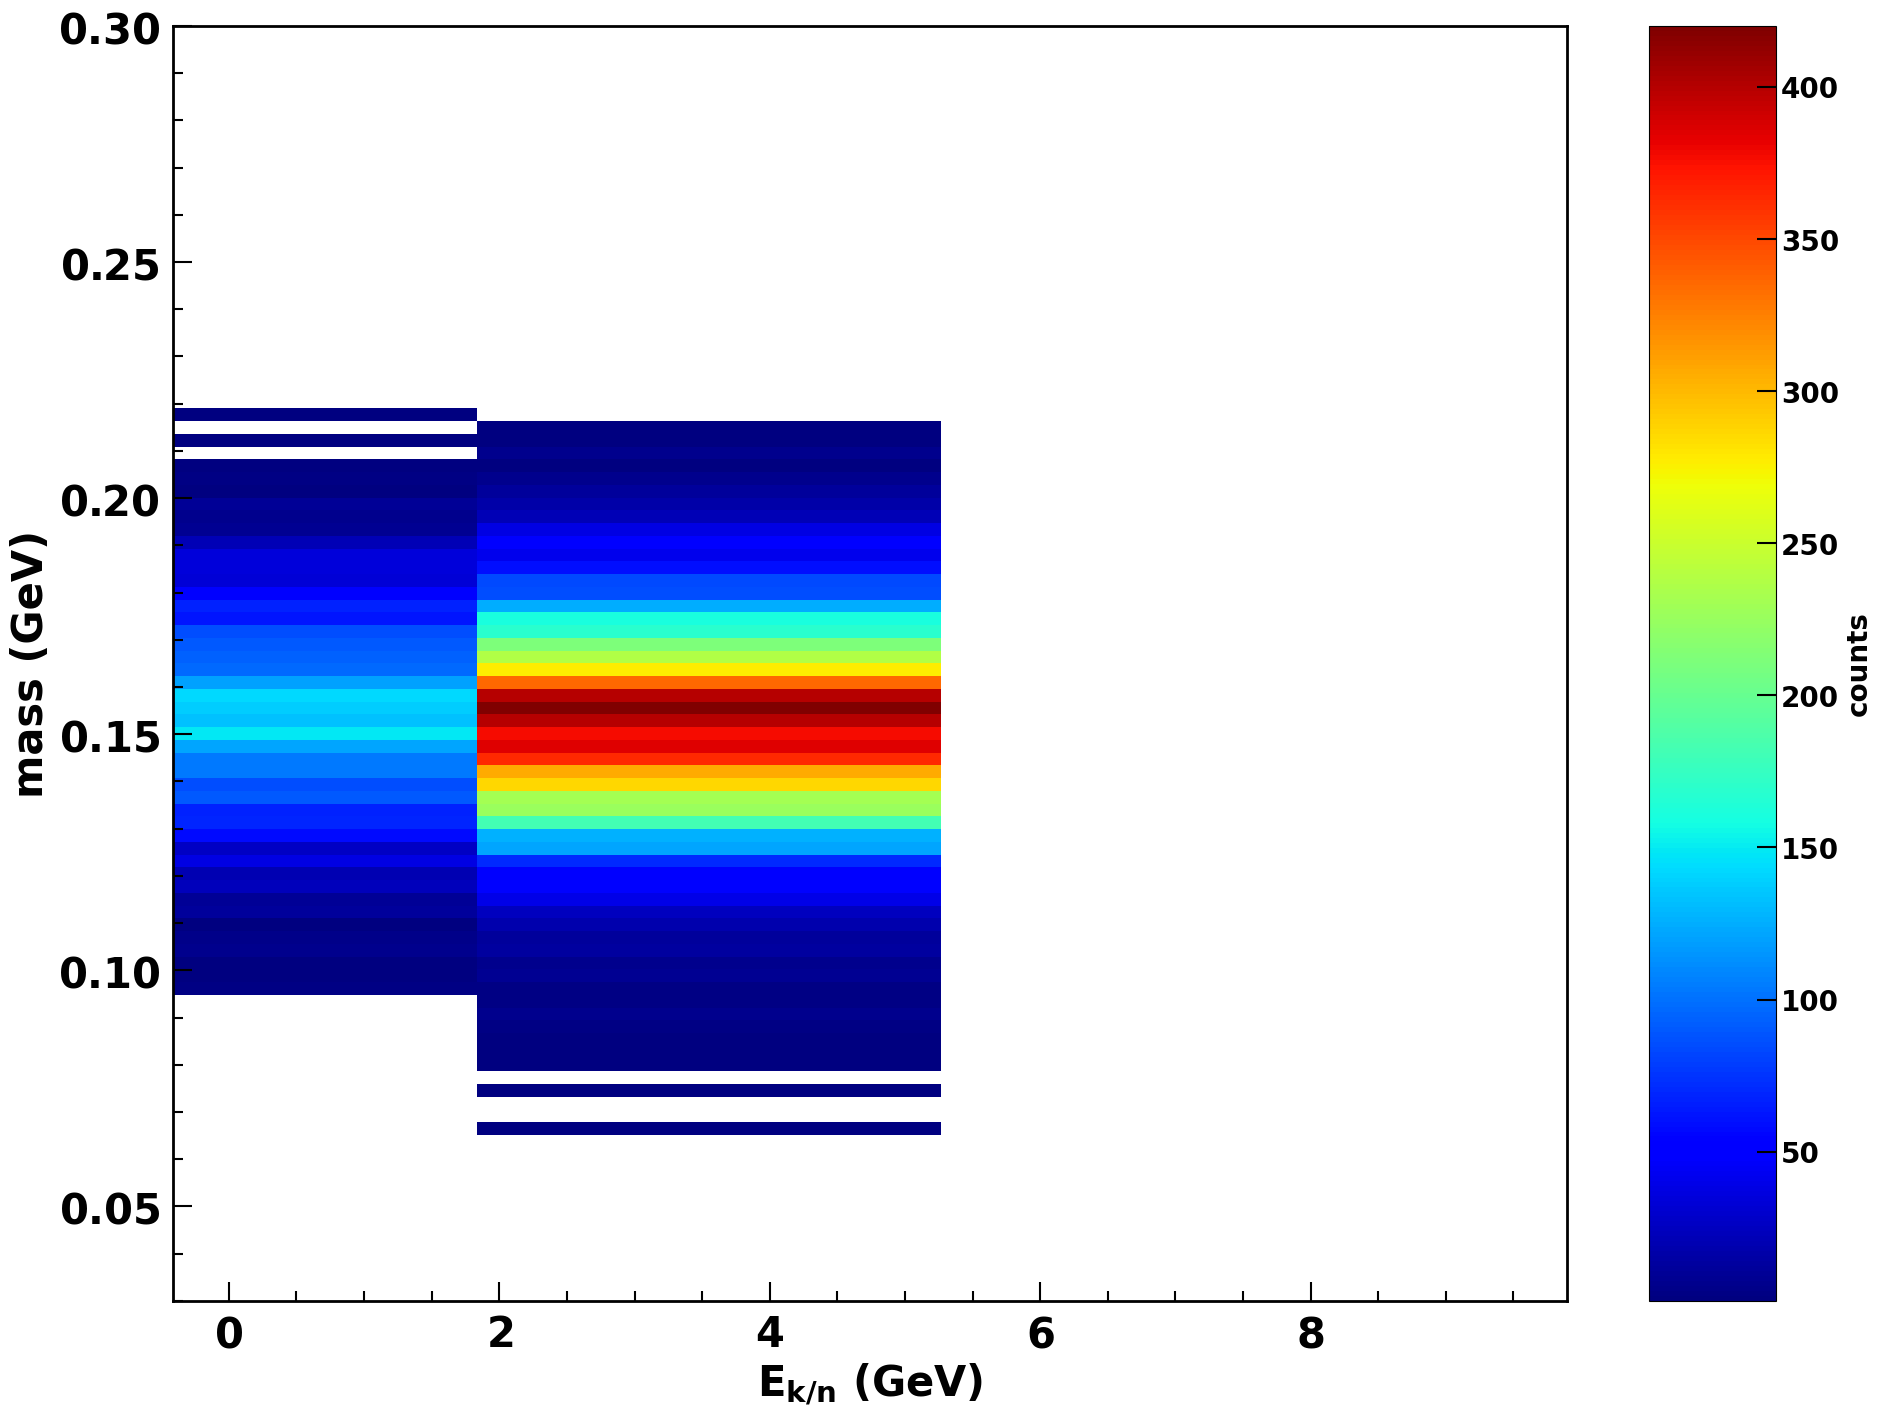

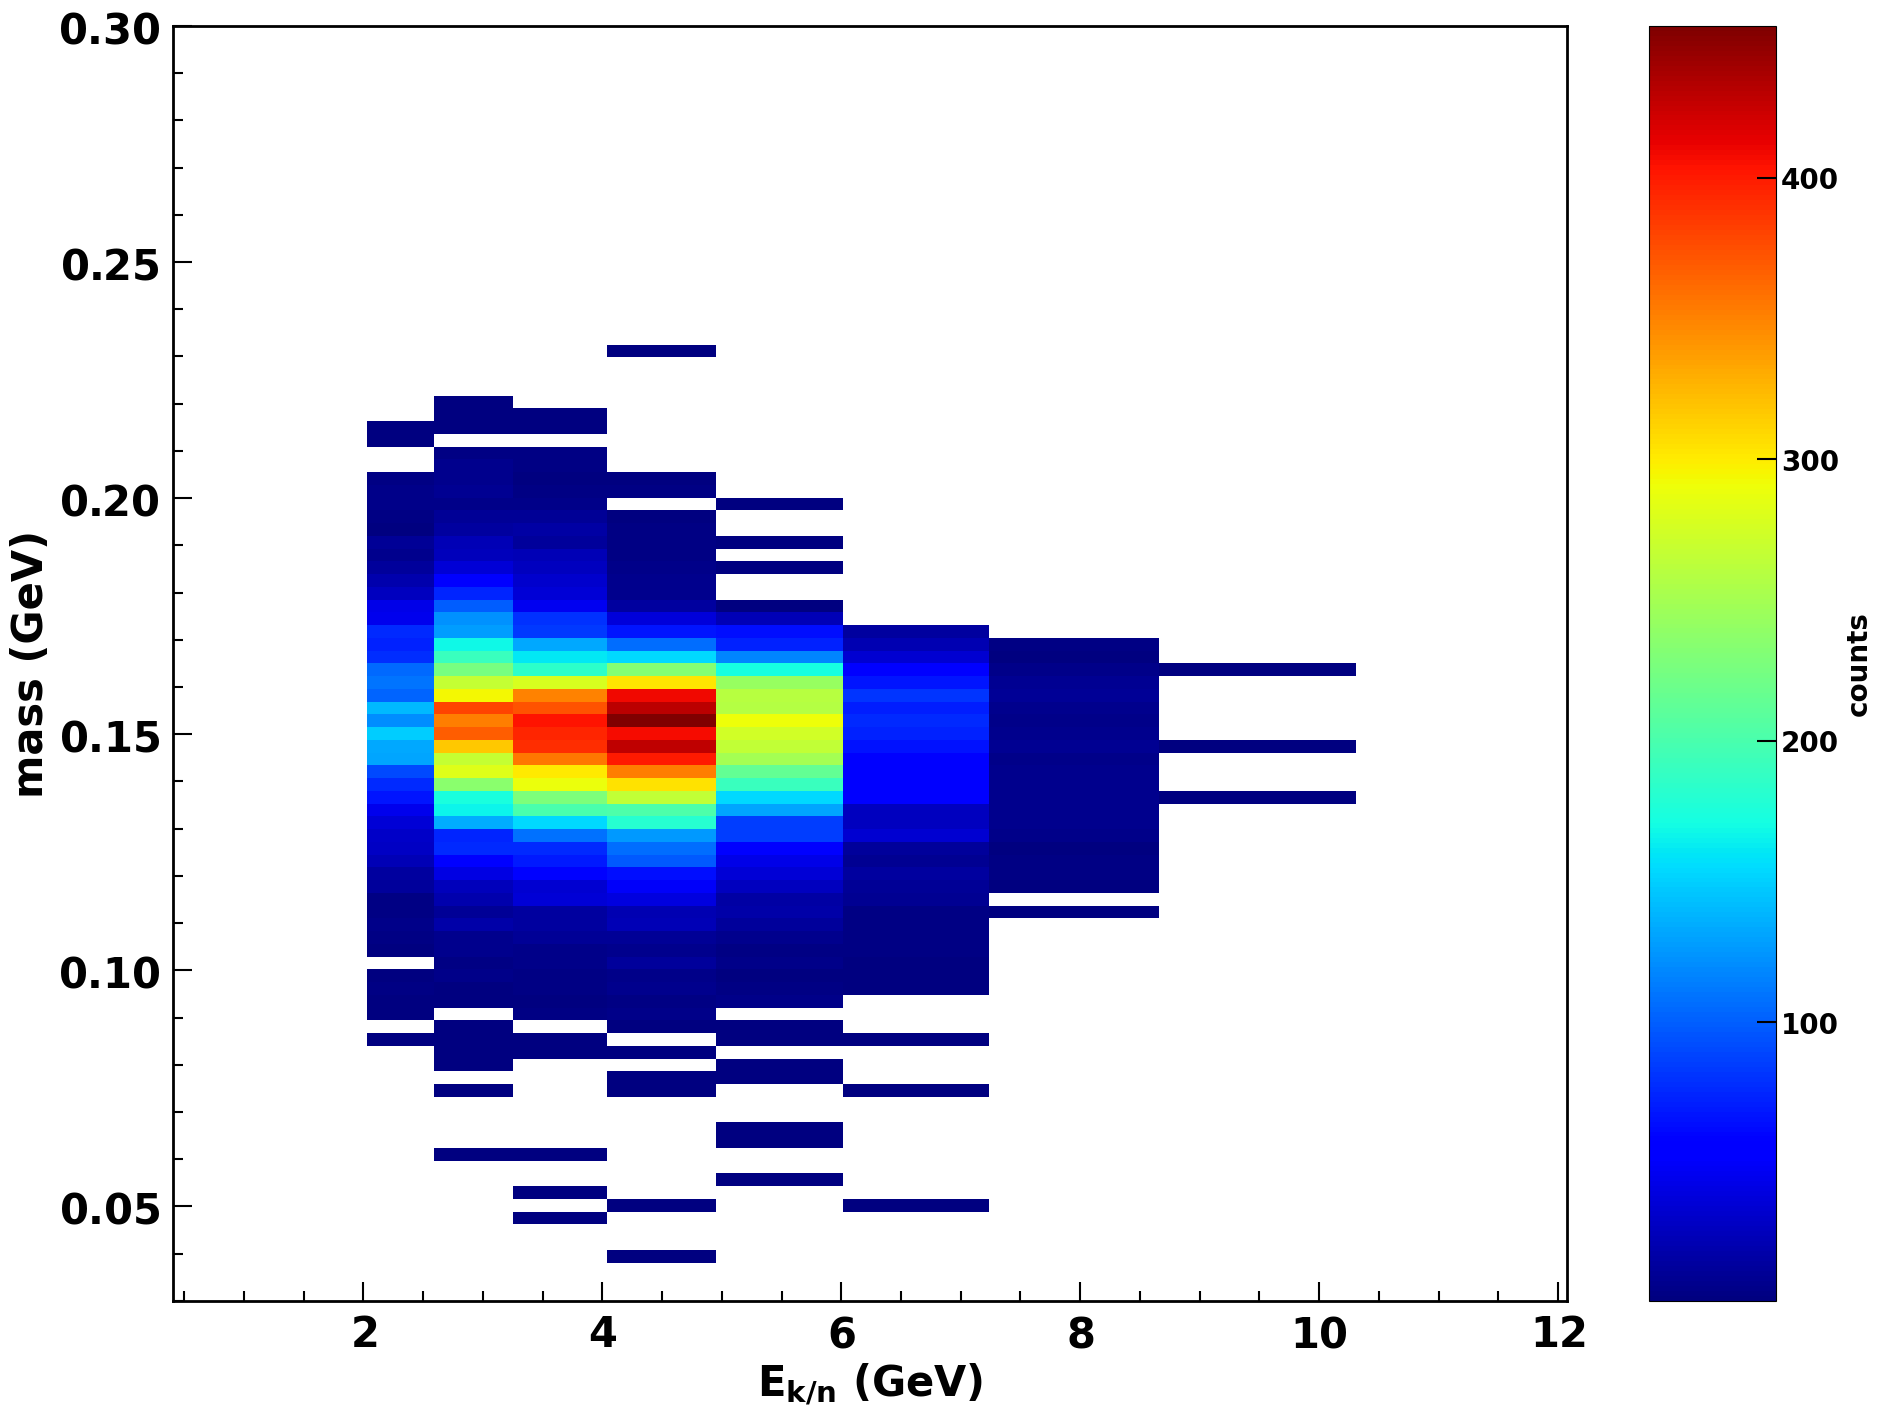

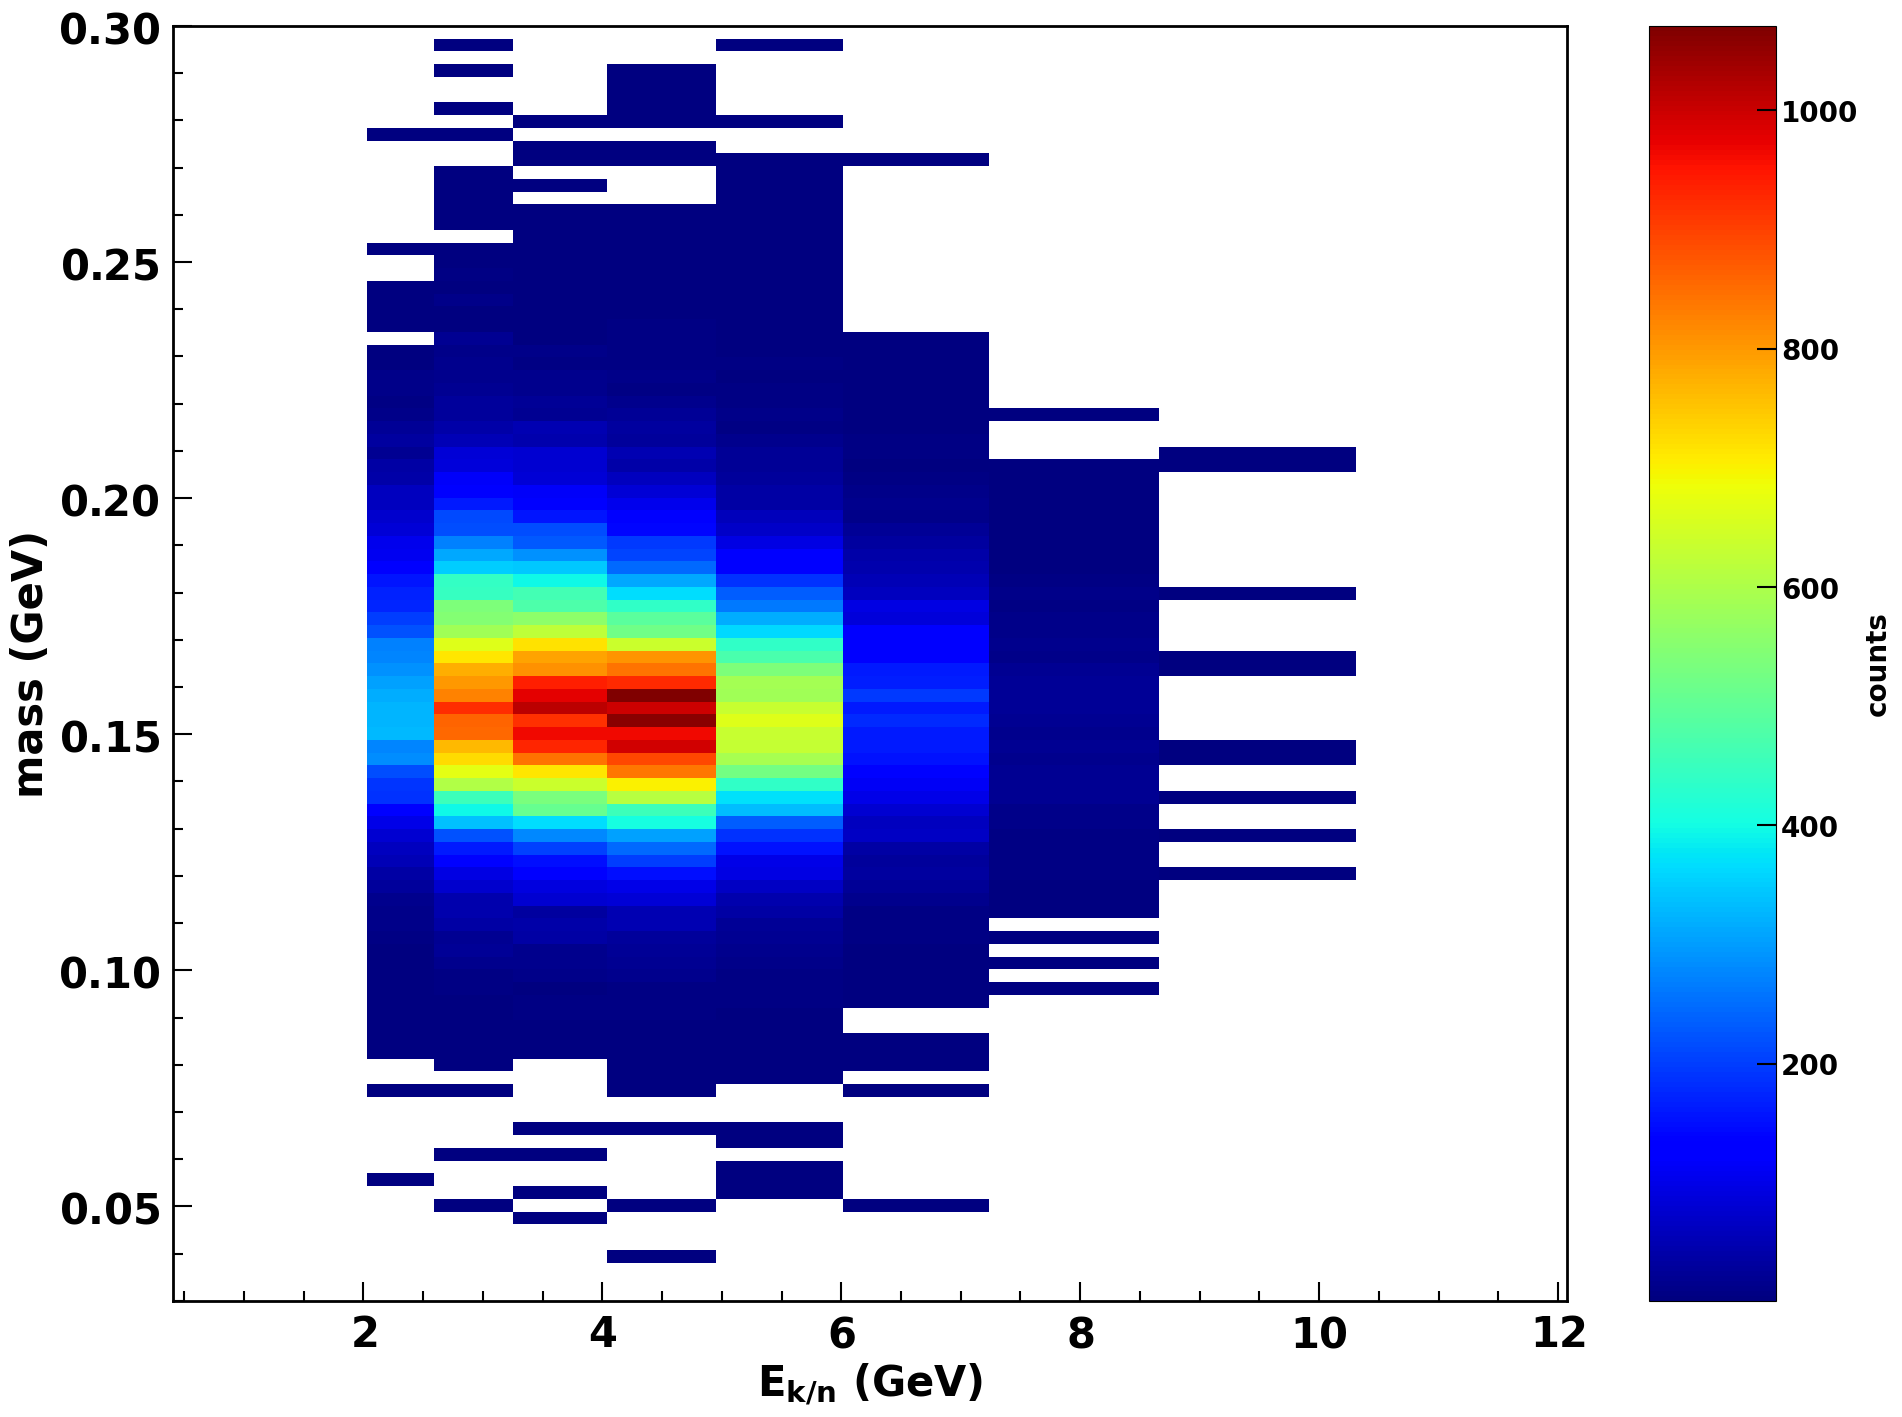

In [36]:
hist2dmass_iss = {}
graph_mean_issLi7 = {}
graph_sigma_issLi7 = {}

for dec in detectors:
    if 'Agl' in dec: 
        decname = 'Agl'
    else:
        decname = dec
    with np.load(filename[dec]) as histfile:
        hist2dmass_iss[dec] = Histogram.from_file(histfile, f"{iso}ISS_{decname}_inversemasscutoff")  
        graph_mean_issLi7[dec], graph_sigma_issLi7[dec] = get_musigma_gausfit(hist2dmass_iss[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7Data_inverse_{dec}_{figName}', plotfile=plotfile, sigmafactor=sigmafactor[dec])
        print(graph_mean_issLi7[dec])
        

for dec in detectors:
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot2dhist(fig, plot, xbinning=hist2dmass_iss[dec].binnings[0].edges[1:-1], 
               ybinning=hist2dmass_iss[dec].binnings[1].edges[1:-1],                                                                                                                        
               counts=hist2dmass_iss[dec].values[1:-1, 1:-1],                                                                                                                               
               xlabel=r'$\mathrm{E_{k/n} \ (GeV)}$', ylabel='mass (GeV)', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)   

    savefig_tofile(fig, plotfile, f"hist2d_Li7Cutoff_ISS_inverse_{dec}_{figName}", show=True)  

Tof

xvalues			yvalues			yerrs
0.5144			0.15320118135497302			0.000542917566187676


xvalues			yvalues			yerrs
0.5144			0.15411955925642762			0.000586914204815477


xvalues			yvalues			yerrs
0.5144			0.005994587596075407			0.005233189439839377

NaF

xvalues			yvalues			yerrs
2.9573			0.15219227876930794			0.00040534963792285327


xvalues			yvalues			yerrs
2.9573			0.15160809857690605			0.00029840694671293496


xvalues			yvalues			yerrs
2.9573			-0.0038384351500997393			0.0032990616262131883

Agl1

xvalues			yvalues			yerrs
5.5			0.15064828739281005			0.0004237856890819746


xvalues			yvalues			yerrs
5.5			0.15050731599369063			0.00052447685865014


xvalues			yvalues			yerrs
5.5			-0.0009357650296537567			0.004474284303522182

Agl2

xvalues			yvalues			yerrs


xvalues			yvalues			yerrs


xvalues			yvalues			yerrs



/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


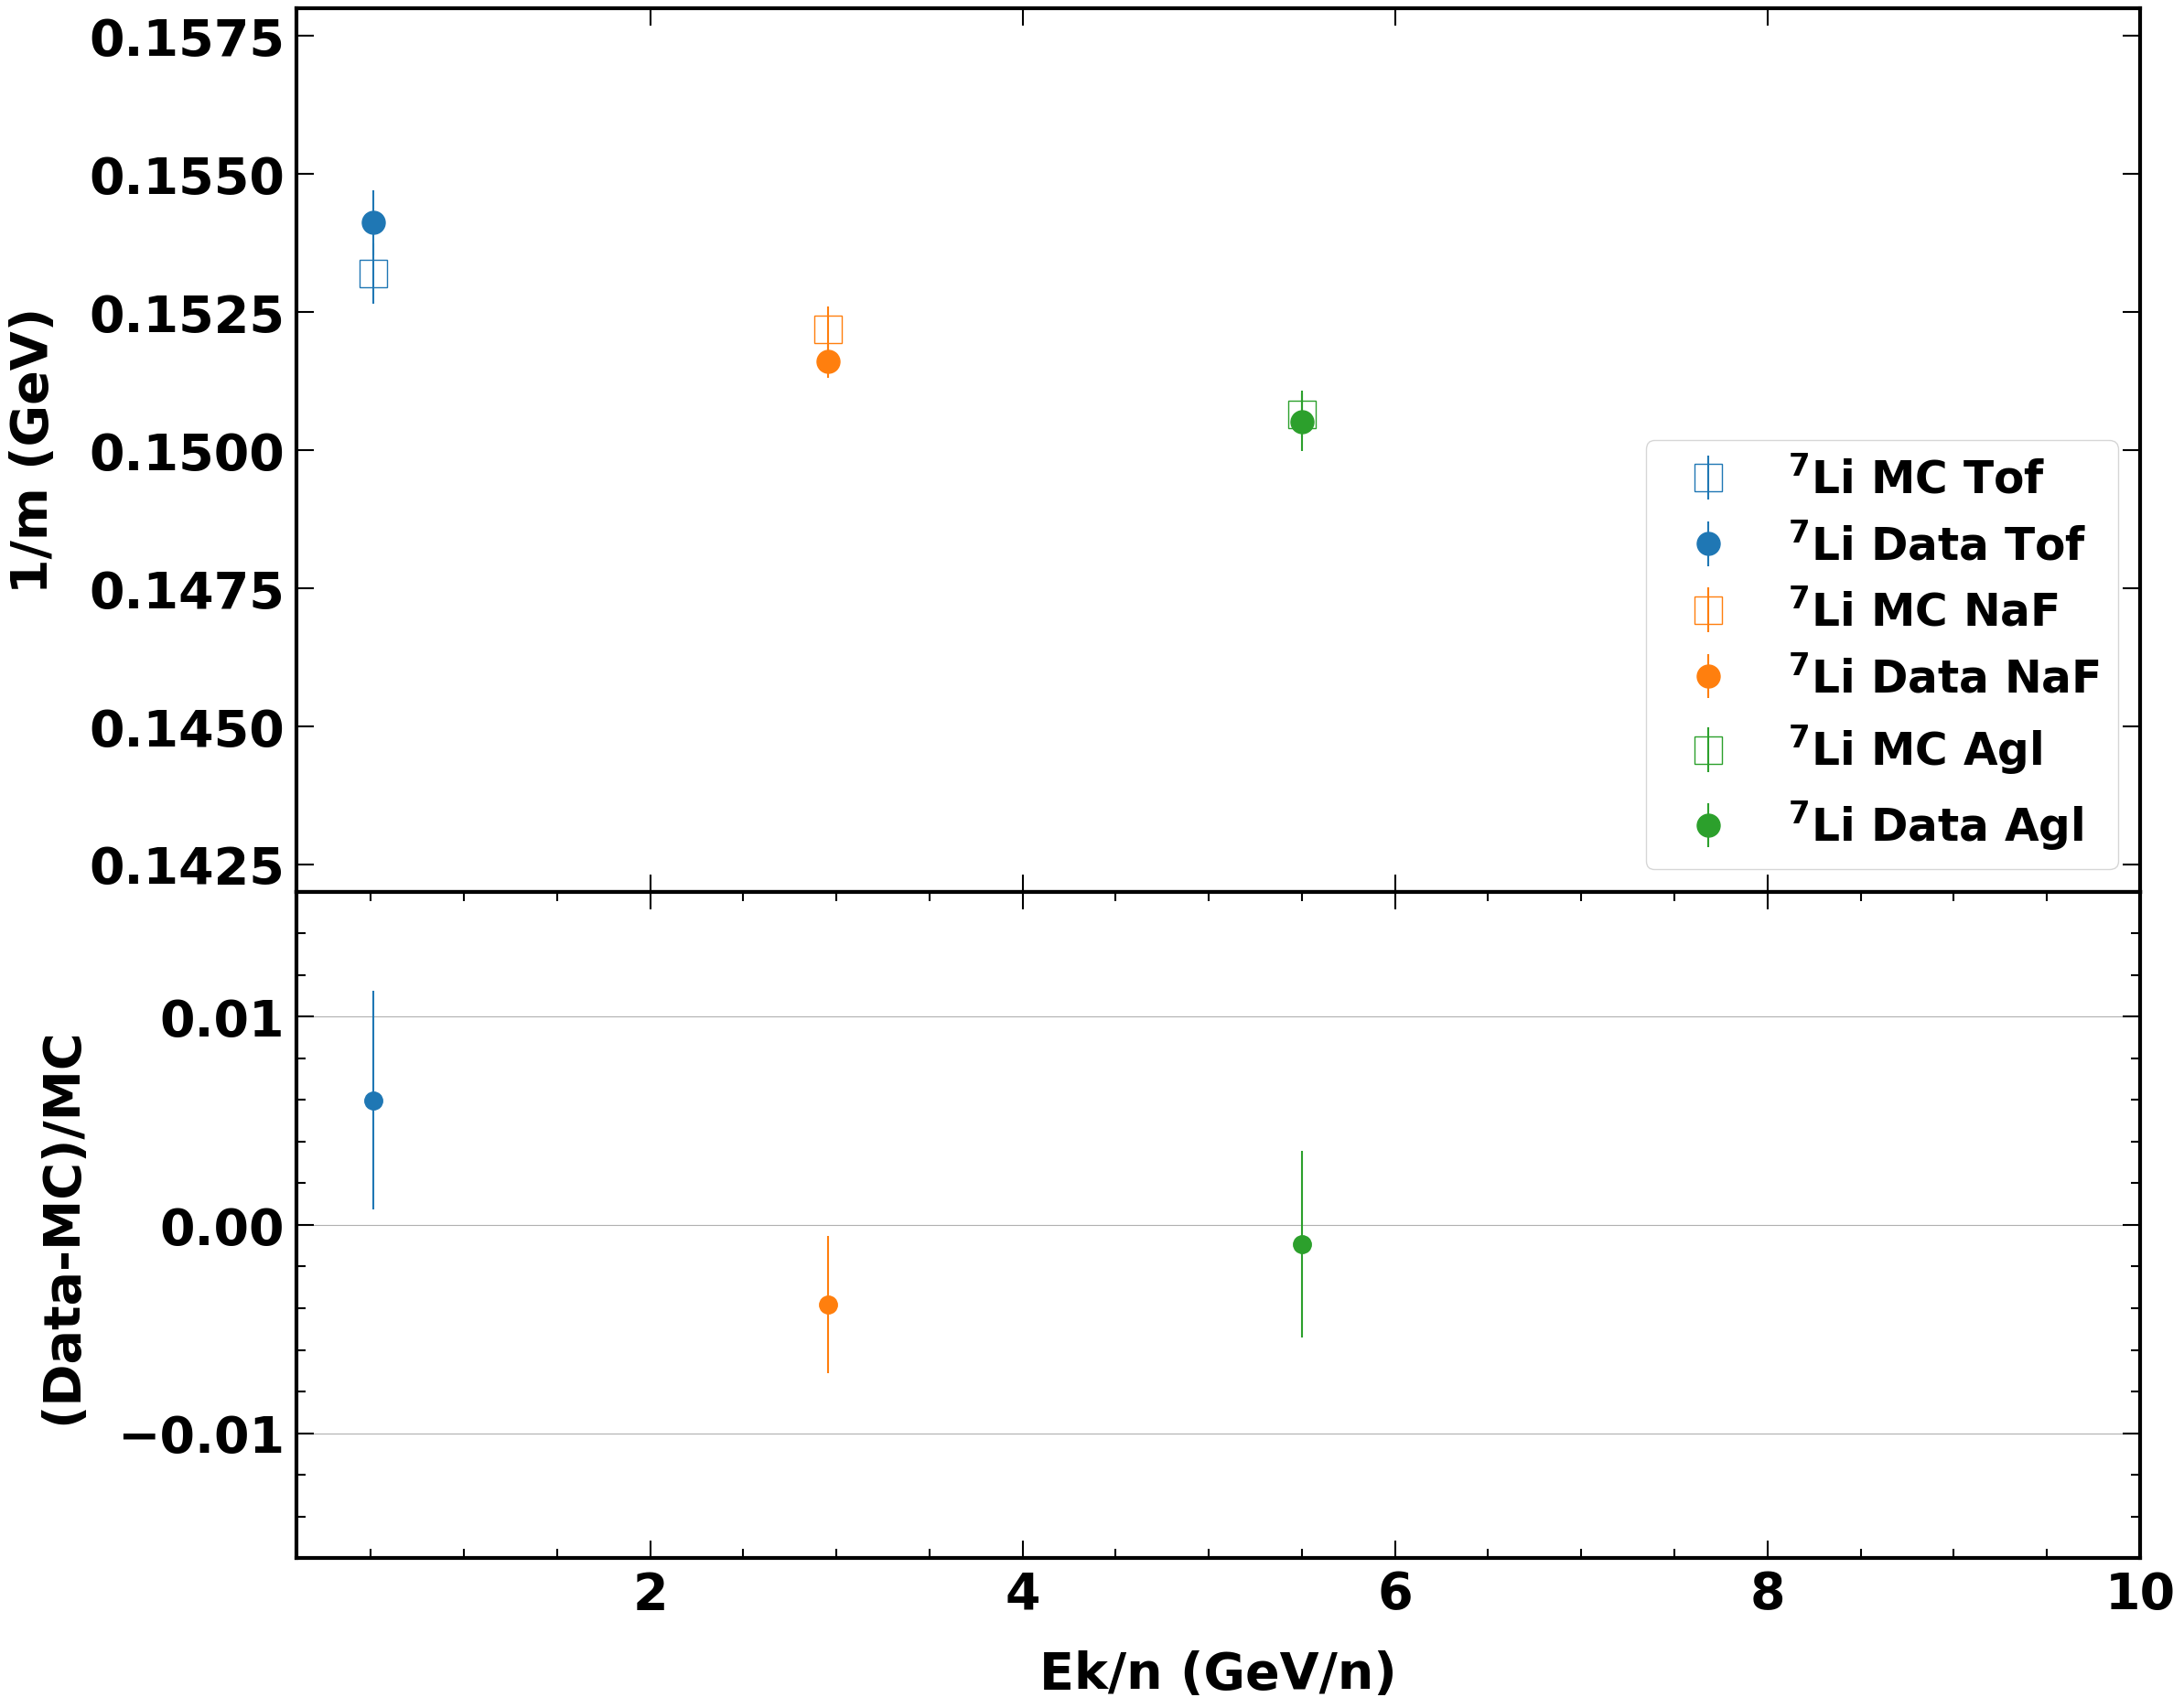

In [35]:
figsize = (26, 22)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.57, 0.43]}, figsize=figsize) 


graph_mean_issLi7['Agl1'] = slice_graph_by_value(graph_mean_issLi7['Agl1'], [7, 8])
graph_mean_mcLi7['Agl1'] = slice_graph_by_value(graph_mean_mcLi7['Agl1'], [7, 8])

graph_ratio = {}
dic_save ={}
for dec in detectors:
    decname = 'Agl' if 'Agl' in dec else dec
    graph_ratio[dec] = graph_mean_issLi7[dec]/graph_mean_mcLi7[dec]
    graph_ratio[dec].yvalues -= 1.0
    print(dec)
    print(graph_mean_mcLi7[dec])
    print(graph_mean_issLi7[dec])
    print(graph_ratio[dec])
    graph_ratio[dec].add_to_file(dic_save, f'graph_cutoff_mean_{dec}')
    
np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May', 'graph_cutoff_mean.npz'), **dic_save)

#graph_ratio['Tof'].yerrs *= 1.1
for dec in ['Tof', 'NaF', 'Agl1']:
    decname = 'Agl' if 'Agl' in dec else dec
    
    plot_graph(fig, ax1, graph_mean_mcLi7[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]} MC {decname}", marker='s', markerfacecolor='none')
    #plot_graph(fig, ax1, graph_mean_issLi7[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=27, label=f"{ISO_LABELS[iso]} Data {dec}", markerfacecolor='none') 
    plot_graph(fig, ax1, graph_mean_issLi7[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=36, label=f"{ISO_LABELS[iso]} Data {decname}")   
    plot_graph(fig, ax2, graph_ratio[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=28, label=f"Data/MC")
set_plot_style(ax1)
set_plot_style(ax2)
ax1.legend(fontsize=35, loc='lower right')
#ax2.legend(fontsize=35)



#ax1.text(0.48, 0.95, 'Agl', fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
SetAx1Ax2Xaxis(ax1, ax2, 'Ek/n (GeV/n)', TEXTSIZE, xlimrange=[0.1, 10.0],  custom_ticks=None, custom_tickslabels=None, gridx1=False,  gridx2=False, xscale=False)
SetAx1Ax2Yaxis(ax1, ax2, r'1/m (GeV)', '(Data-MC)/MC', TEXTSIZE, ylimrange1=[0.142, 0.158],  ylimrange2=[-0.016, 0.016], gridy1=False,  gridy2=True, yscale1=None, yscale2=None)
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203'
savefig_tofile(fig, plotfile, f"Li7mean_compareDataMC_invmass_28May", show=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_TofLi7_1_Li7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 0.7332
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_TofLi7_2_Li7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_NaFLi7_2_Li7
10 5.4516
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_Agl1Li7_10_Li7


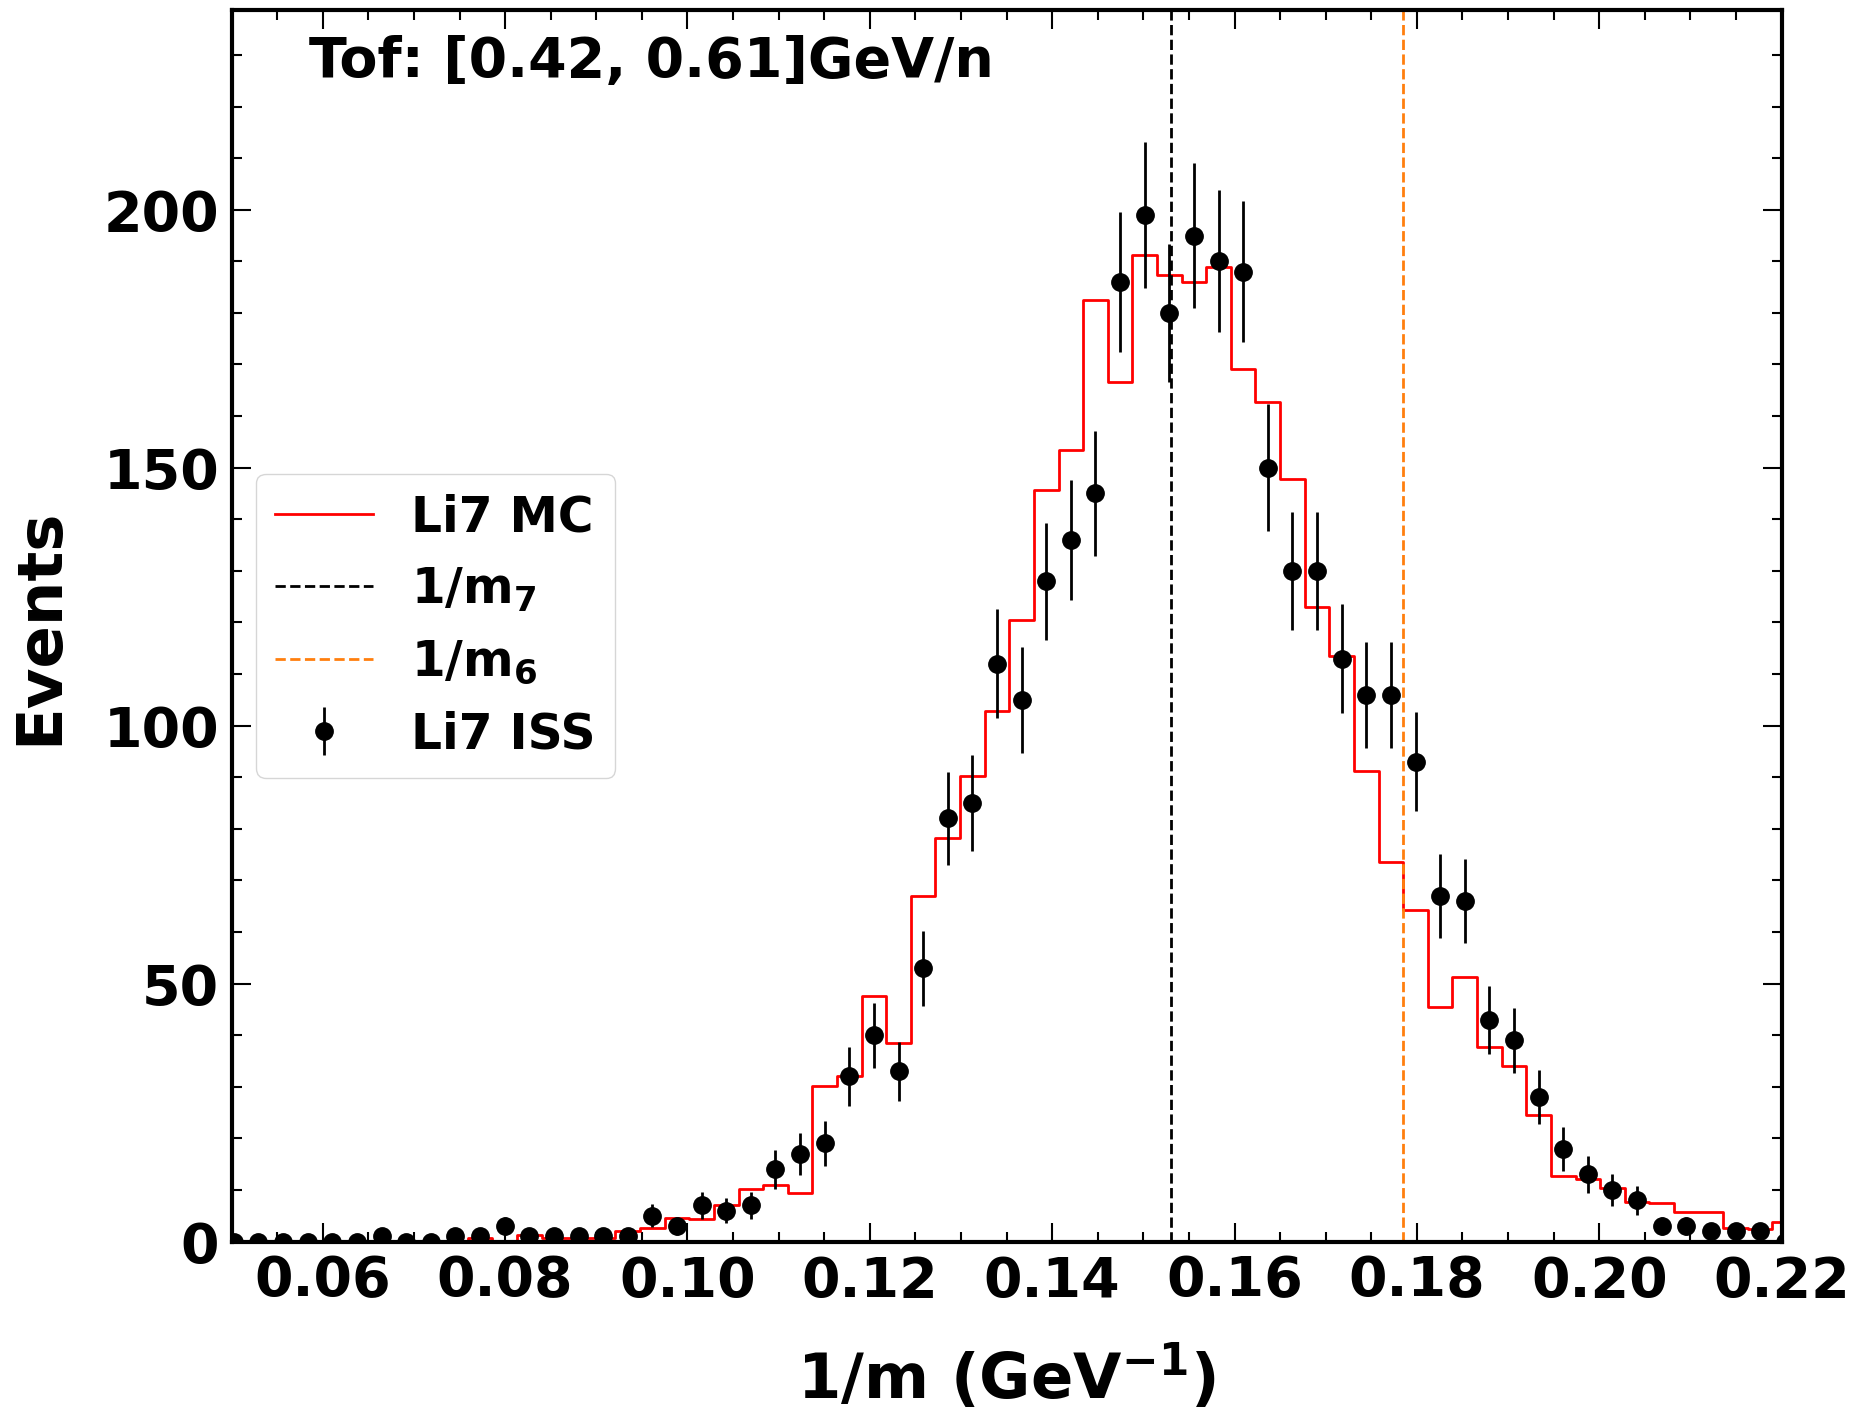

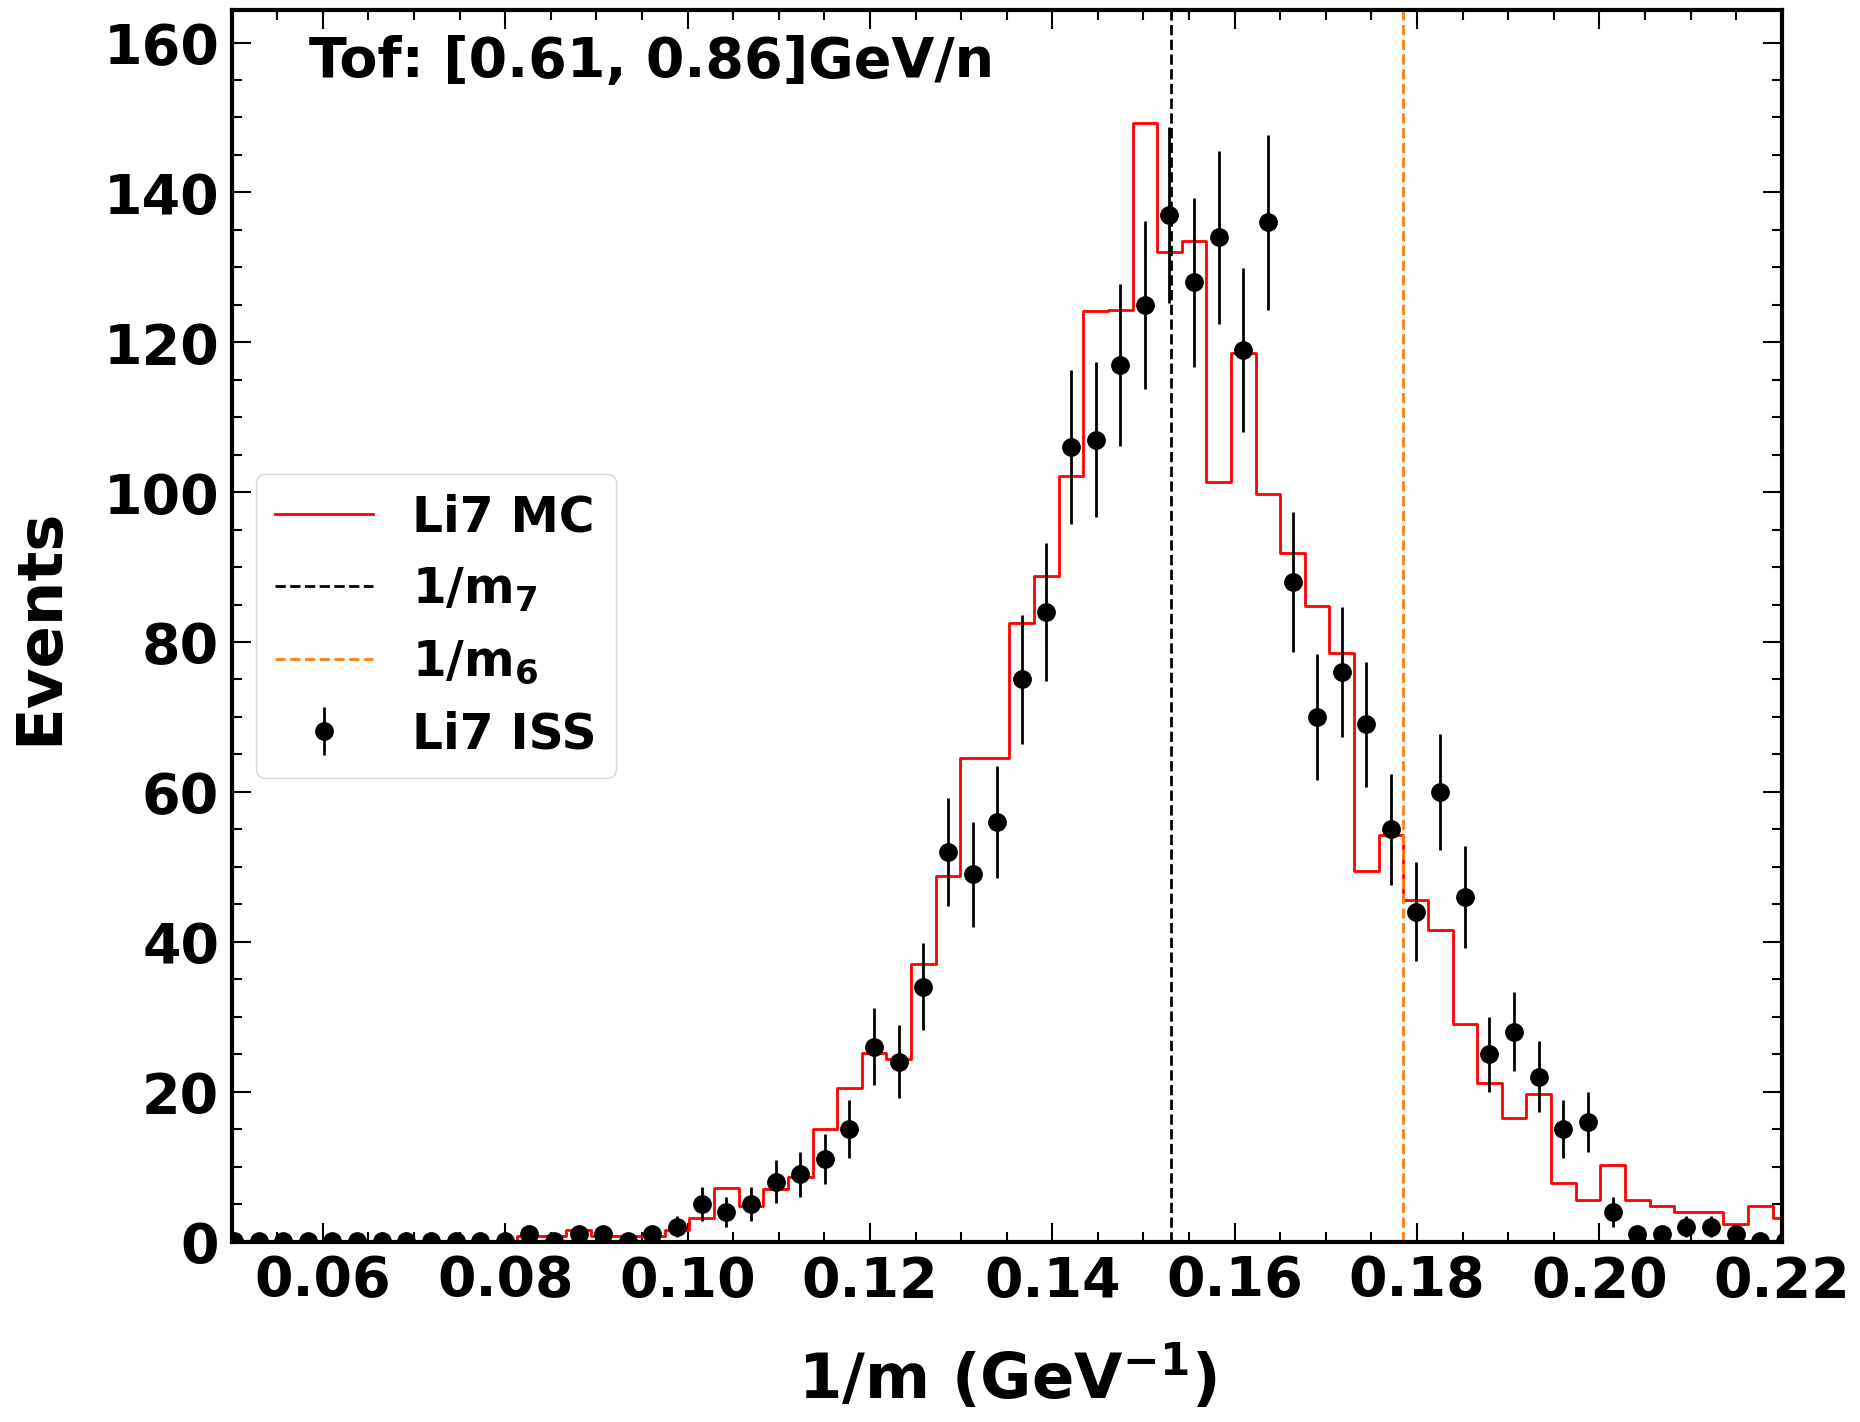

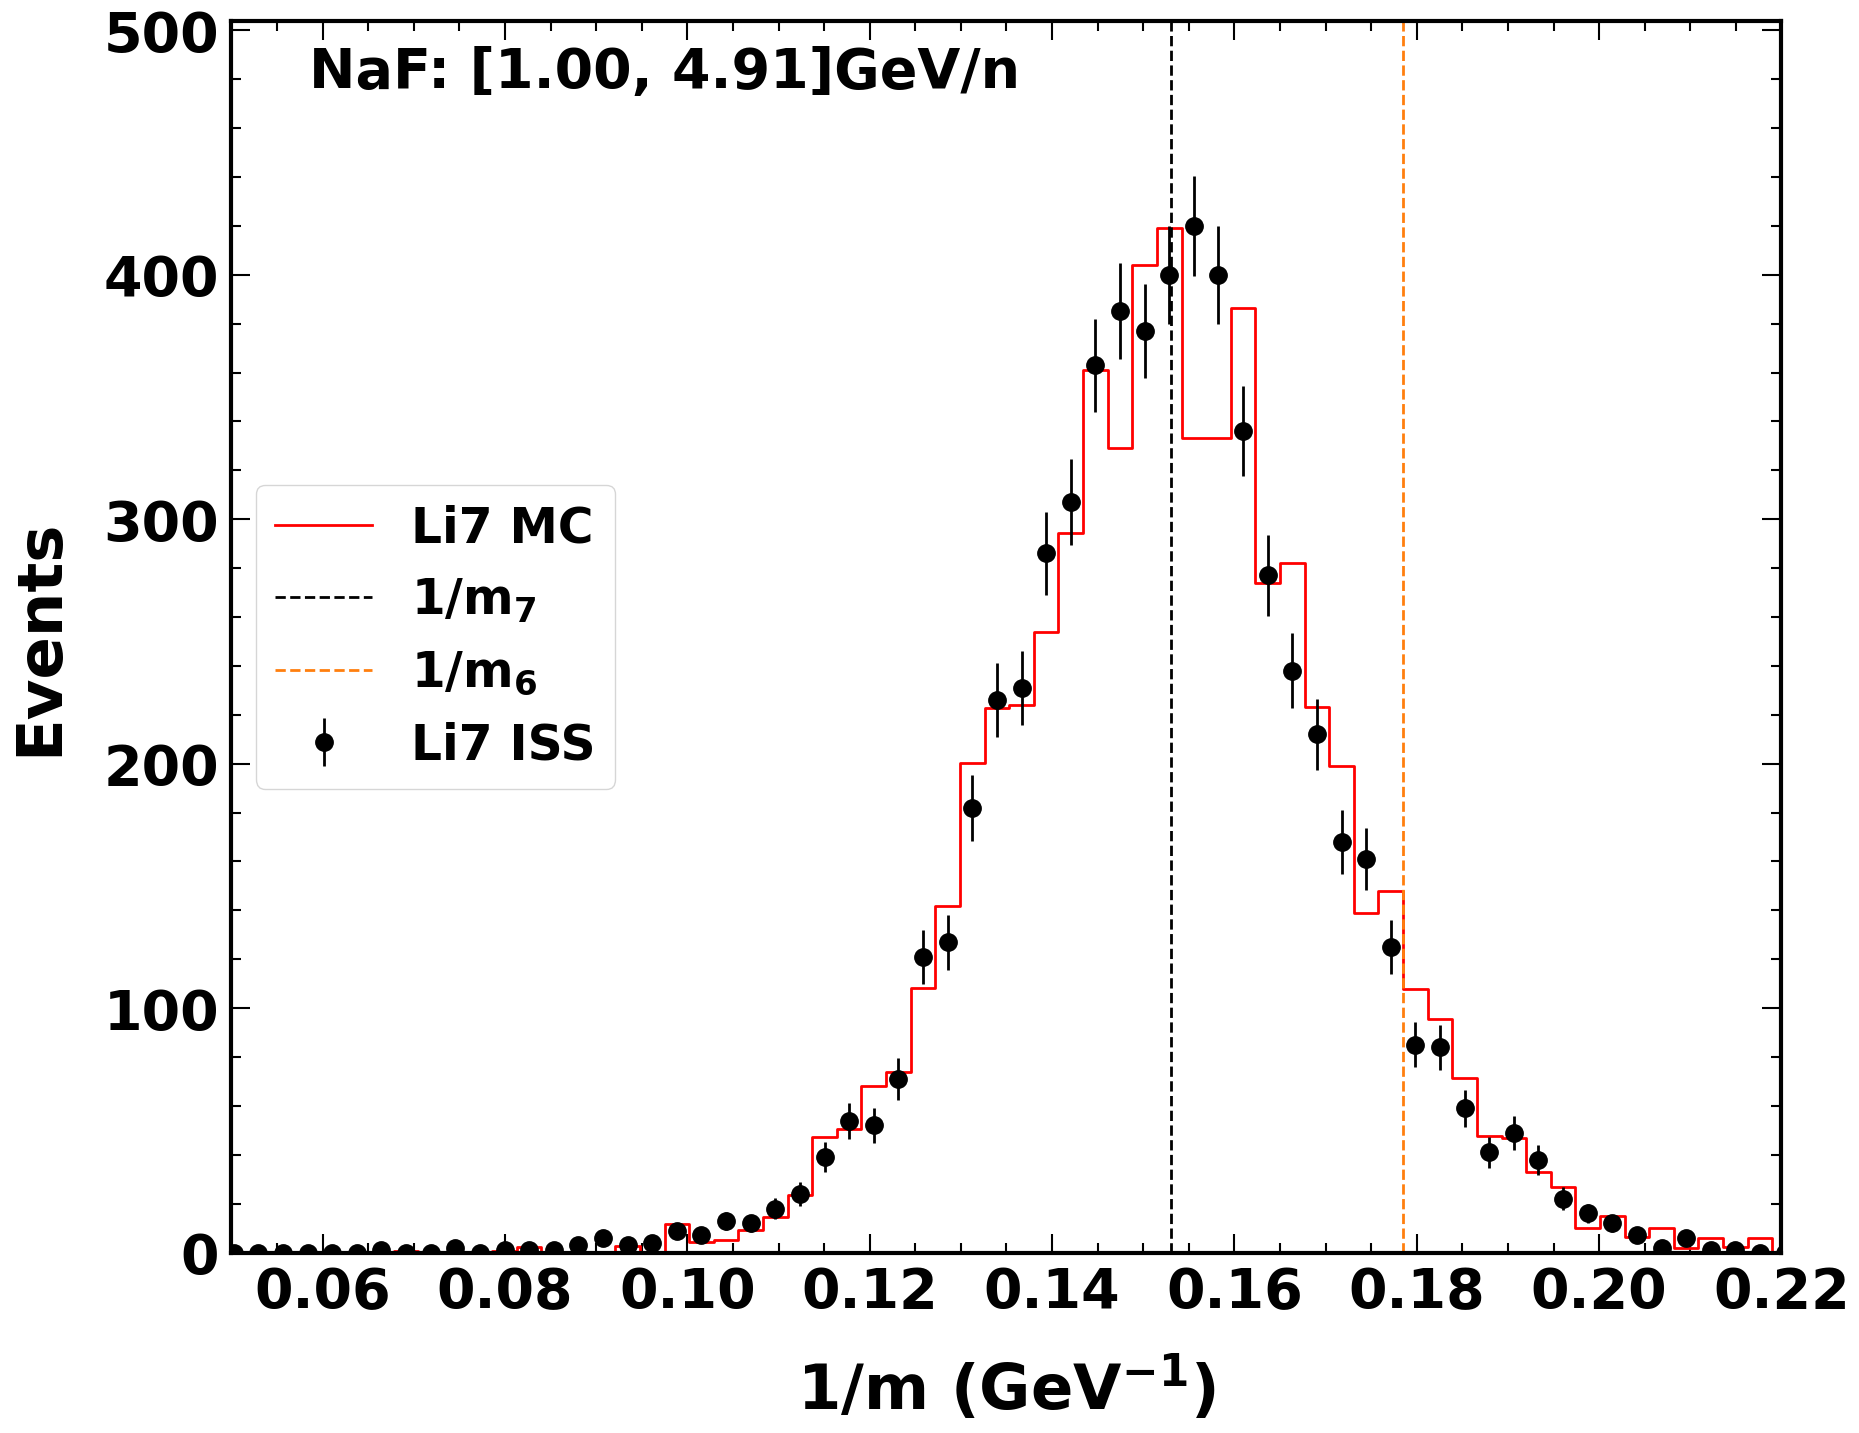

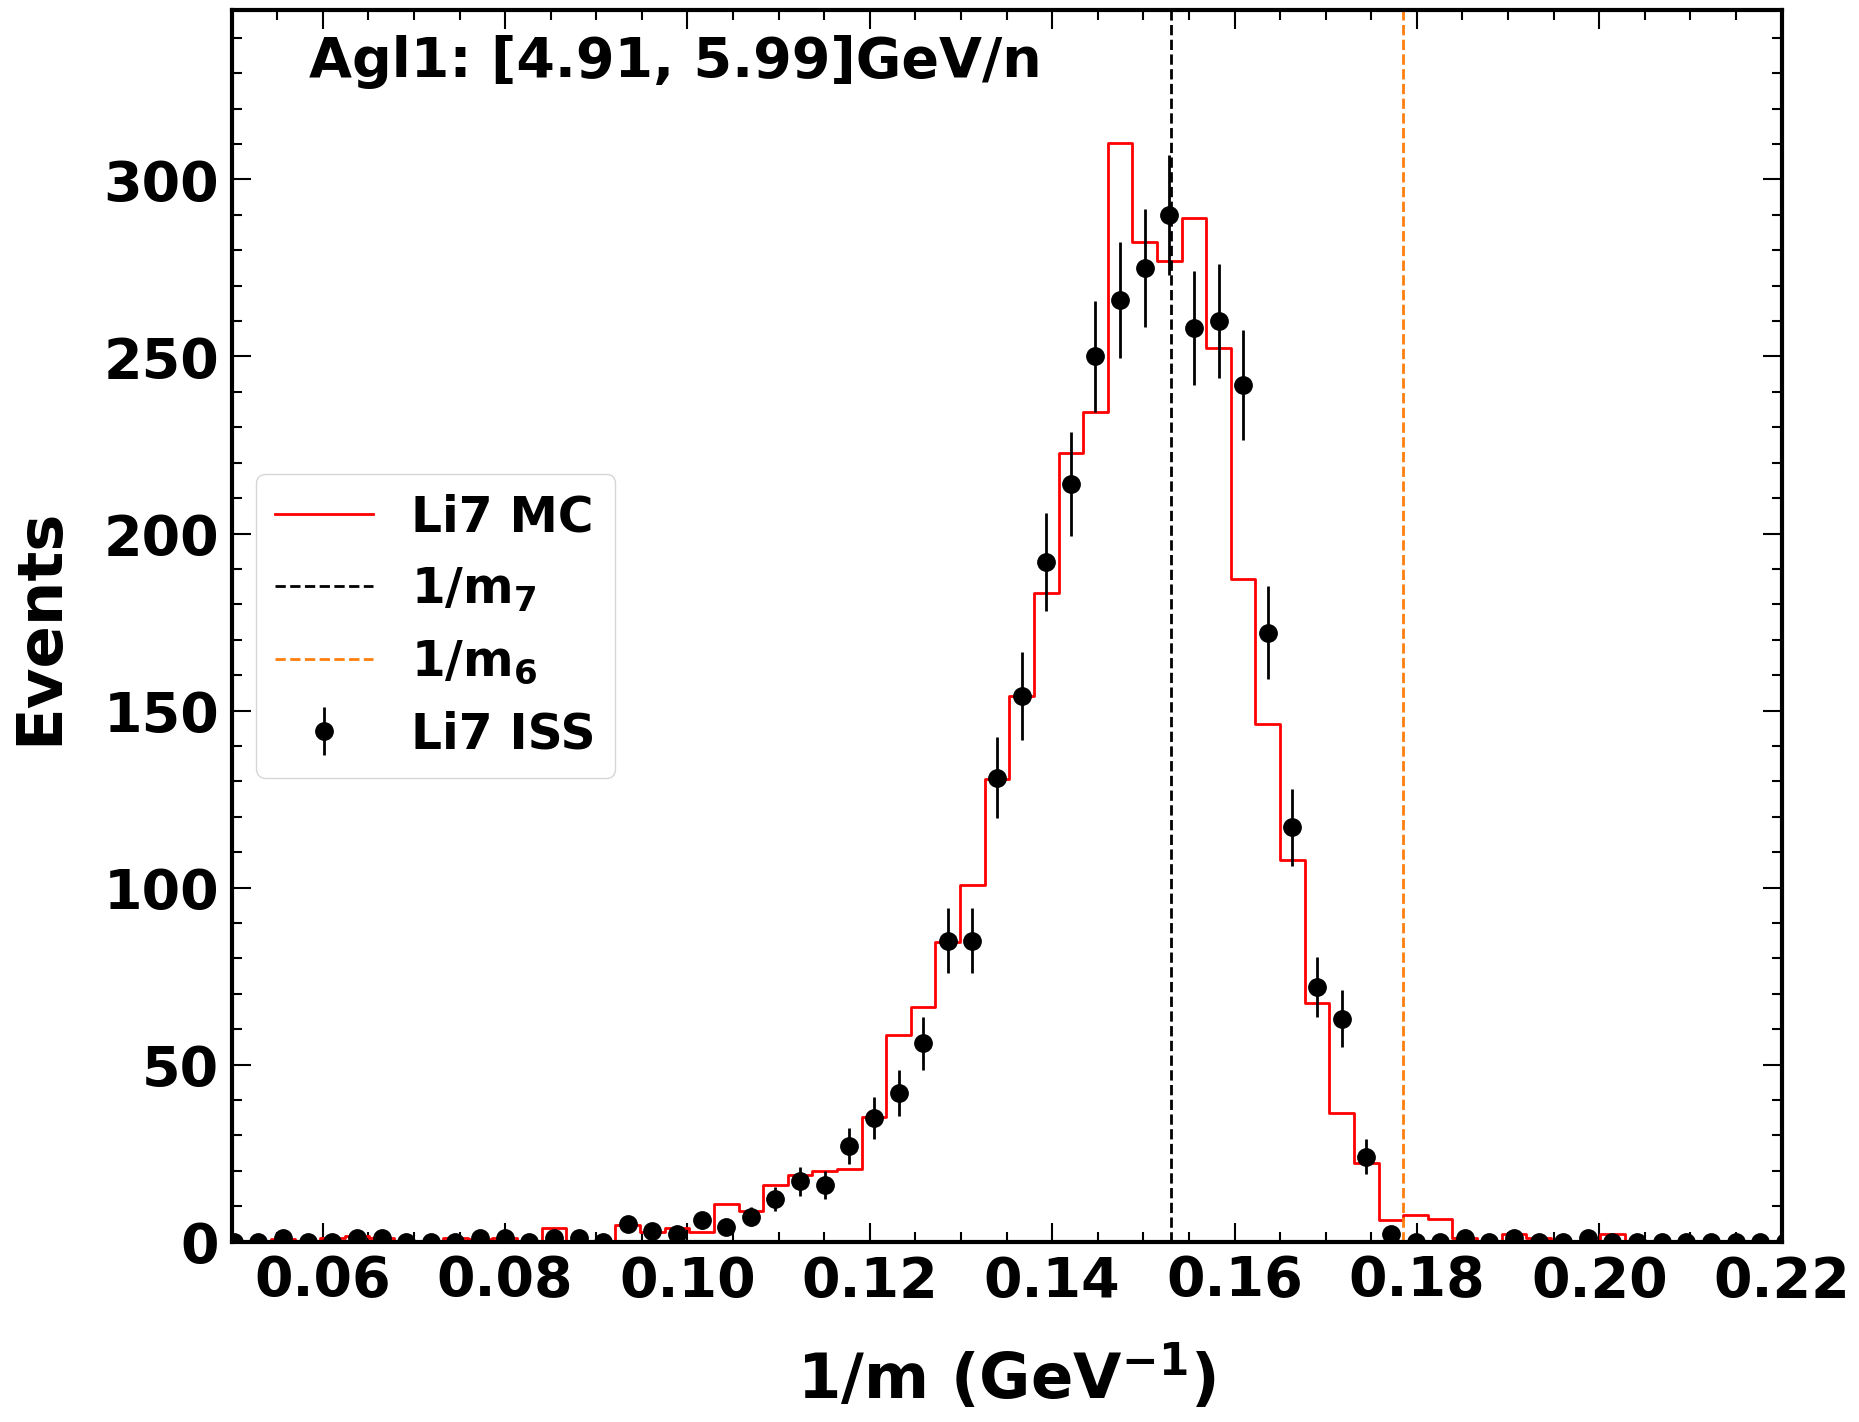

In [48]:
minbin = {'Tof': 1, 'NaF':2, 'Agl1':10}
maxbin =  {'Tof':3,  'NaF':3, 'Agl1':11}
sigmafactor = {'Tof':2,  'NaF':1.2, 'Agl1':1.8, 'Agl2':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.12, 0.18], 'NaF': [0.12, 0.18], 'Agl1': [0.13, 0.175], 'Agl2': [0.13, 0.175]}
col = {'mc': 'red', 'iss':'black'}
detectors = ['Tof', 'NaF', 'Agl1']
for dec in detectors:
    for ibin in range(minbin[dec], maxbin[dec]):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        plot_histogram_1d(ax1, hist1dmassbin, style="mc", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
        plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)

        set_plot_style(ax1)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
      
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='tab:orange', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
        ax1.legend(fontsize=35, loc='center left')
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
         
        plotfile = '/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May'
        savefig_tofile(fig, plotfile, f"histLi7_{dec}{iso}_{ibin}", show=True) 
       

1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_TofLi7_1_Li7
<ValueView norm=8.459428820717621 mu=0.1532103244613067 sigma=0.017760478073690005>
<ValueView norm=8.295314553223168 mu=0.1541702965979753 sigma=-0.01780300724401425>
1.00626571440302
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
Tof number events: 3293.5583143157946
2 0.7332
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_TofLi7_2_Li7
<ValueView norm=5.449793123343765 mu=0.15254273519601477 sigma=0.016694900818311934>
<ValueView norm=5.306127170542724 mu=0.15420050530189072 sigma=0.016047943034715705>
1.0108675782150212
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
Tof number events: 2191.7359176656696
2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_NaFLi7_2_Li7
<ValueView norm=16.49201392960683 mu=0.1527494063098799 sigma=-0.017790289790626888>
<ValueView norm=15.414574424980204 mu=0.15157729826613506 sigma=0.01541478136913168

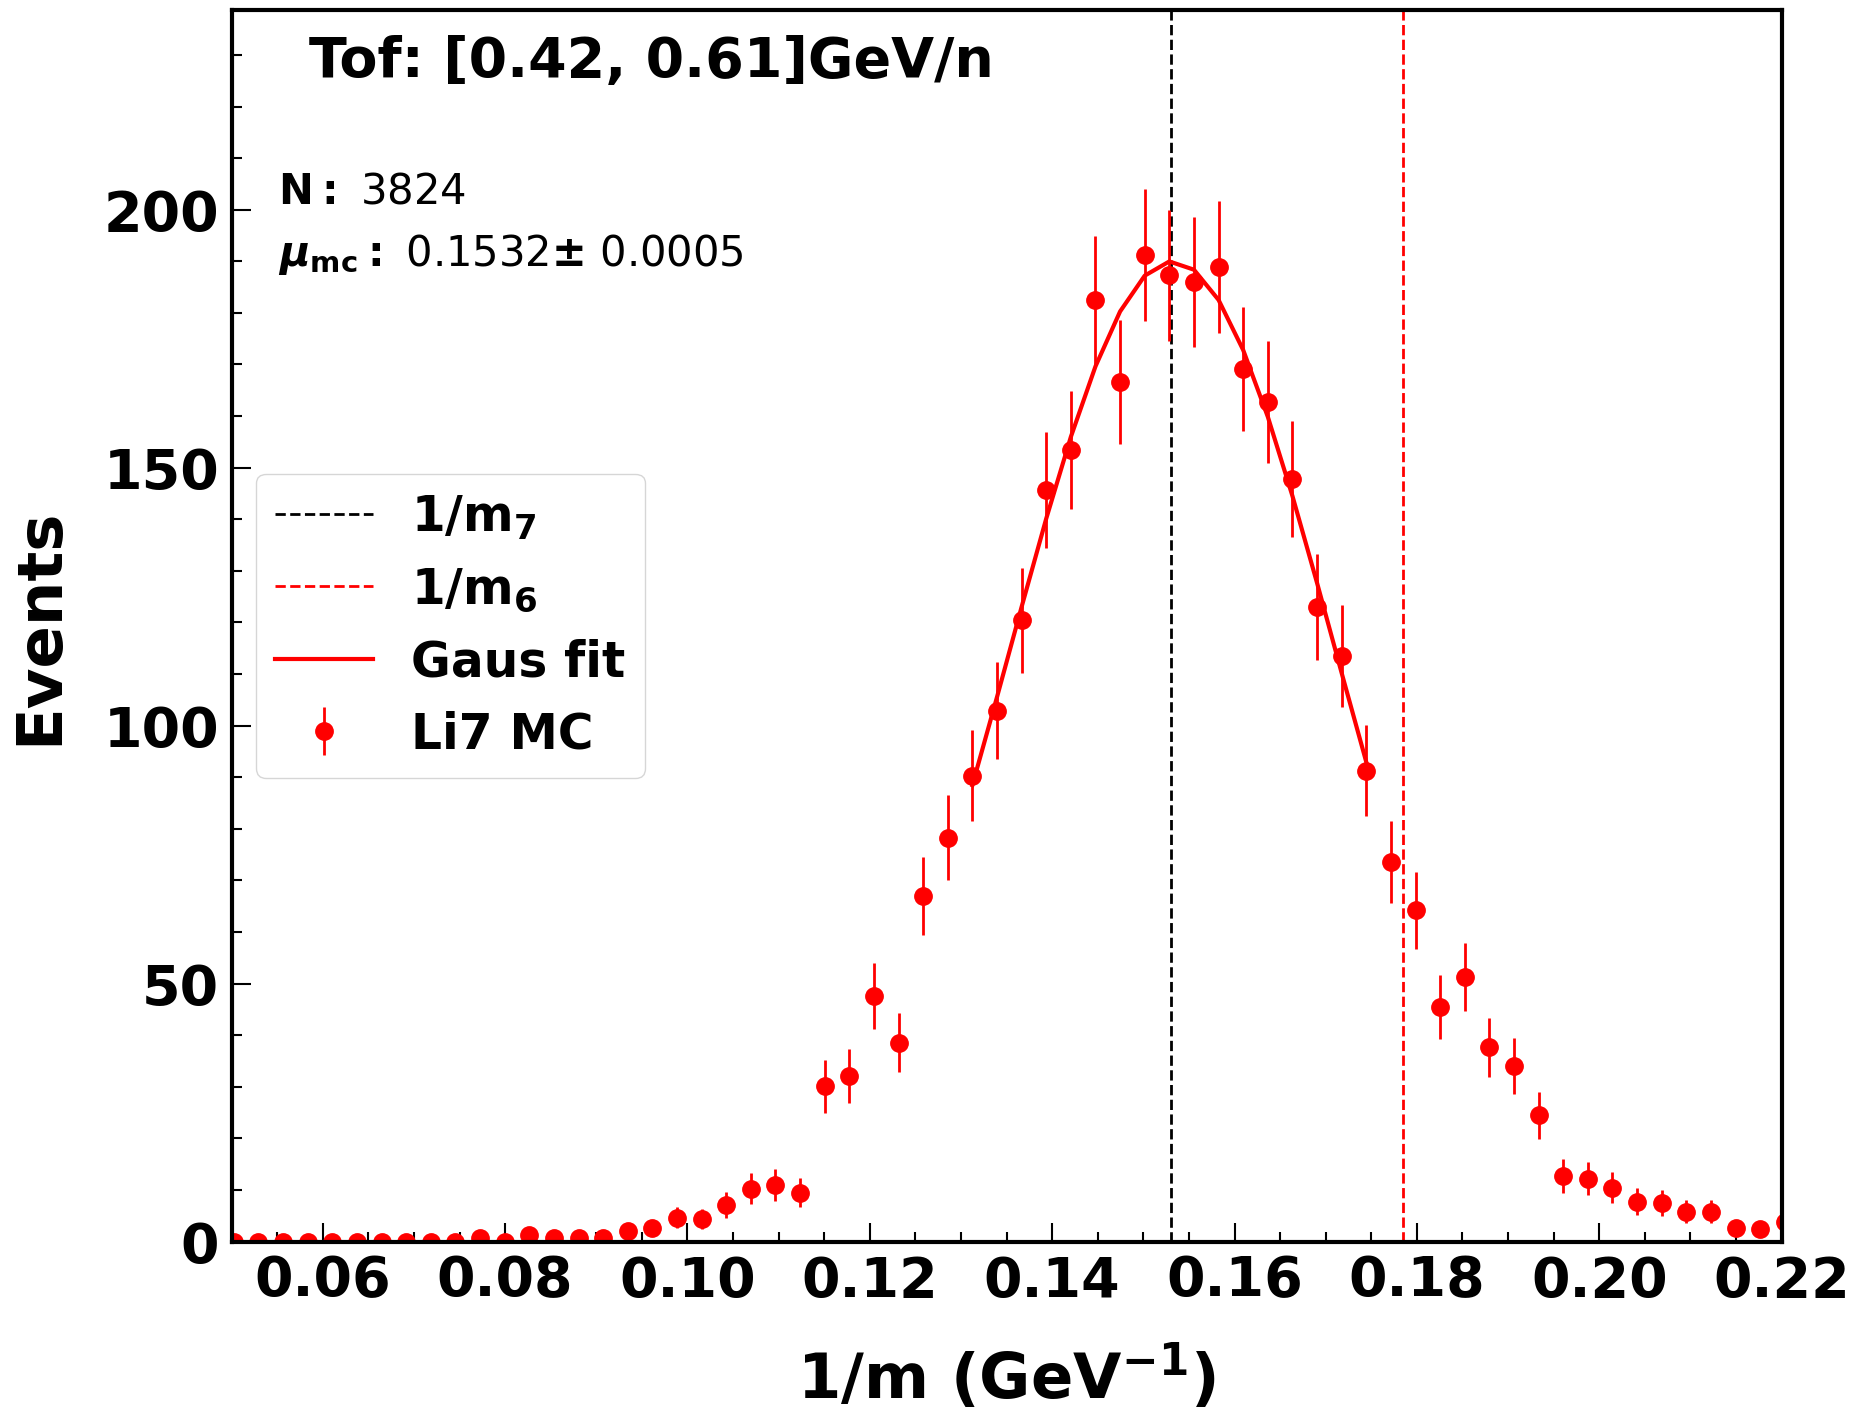

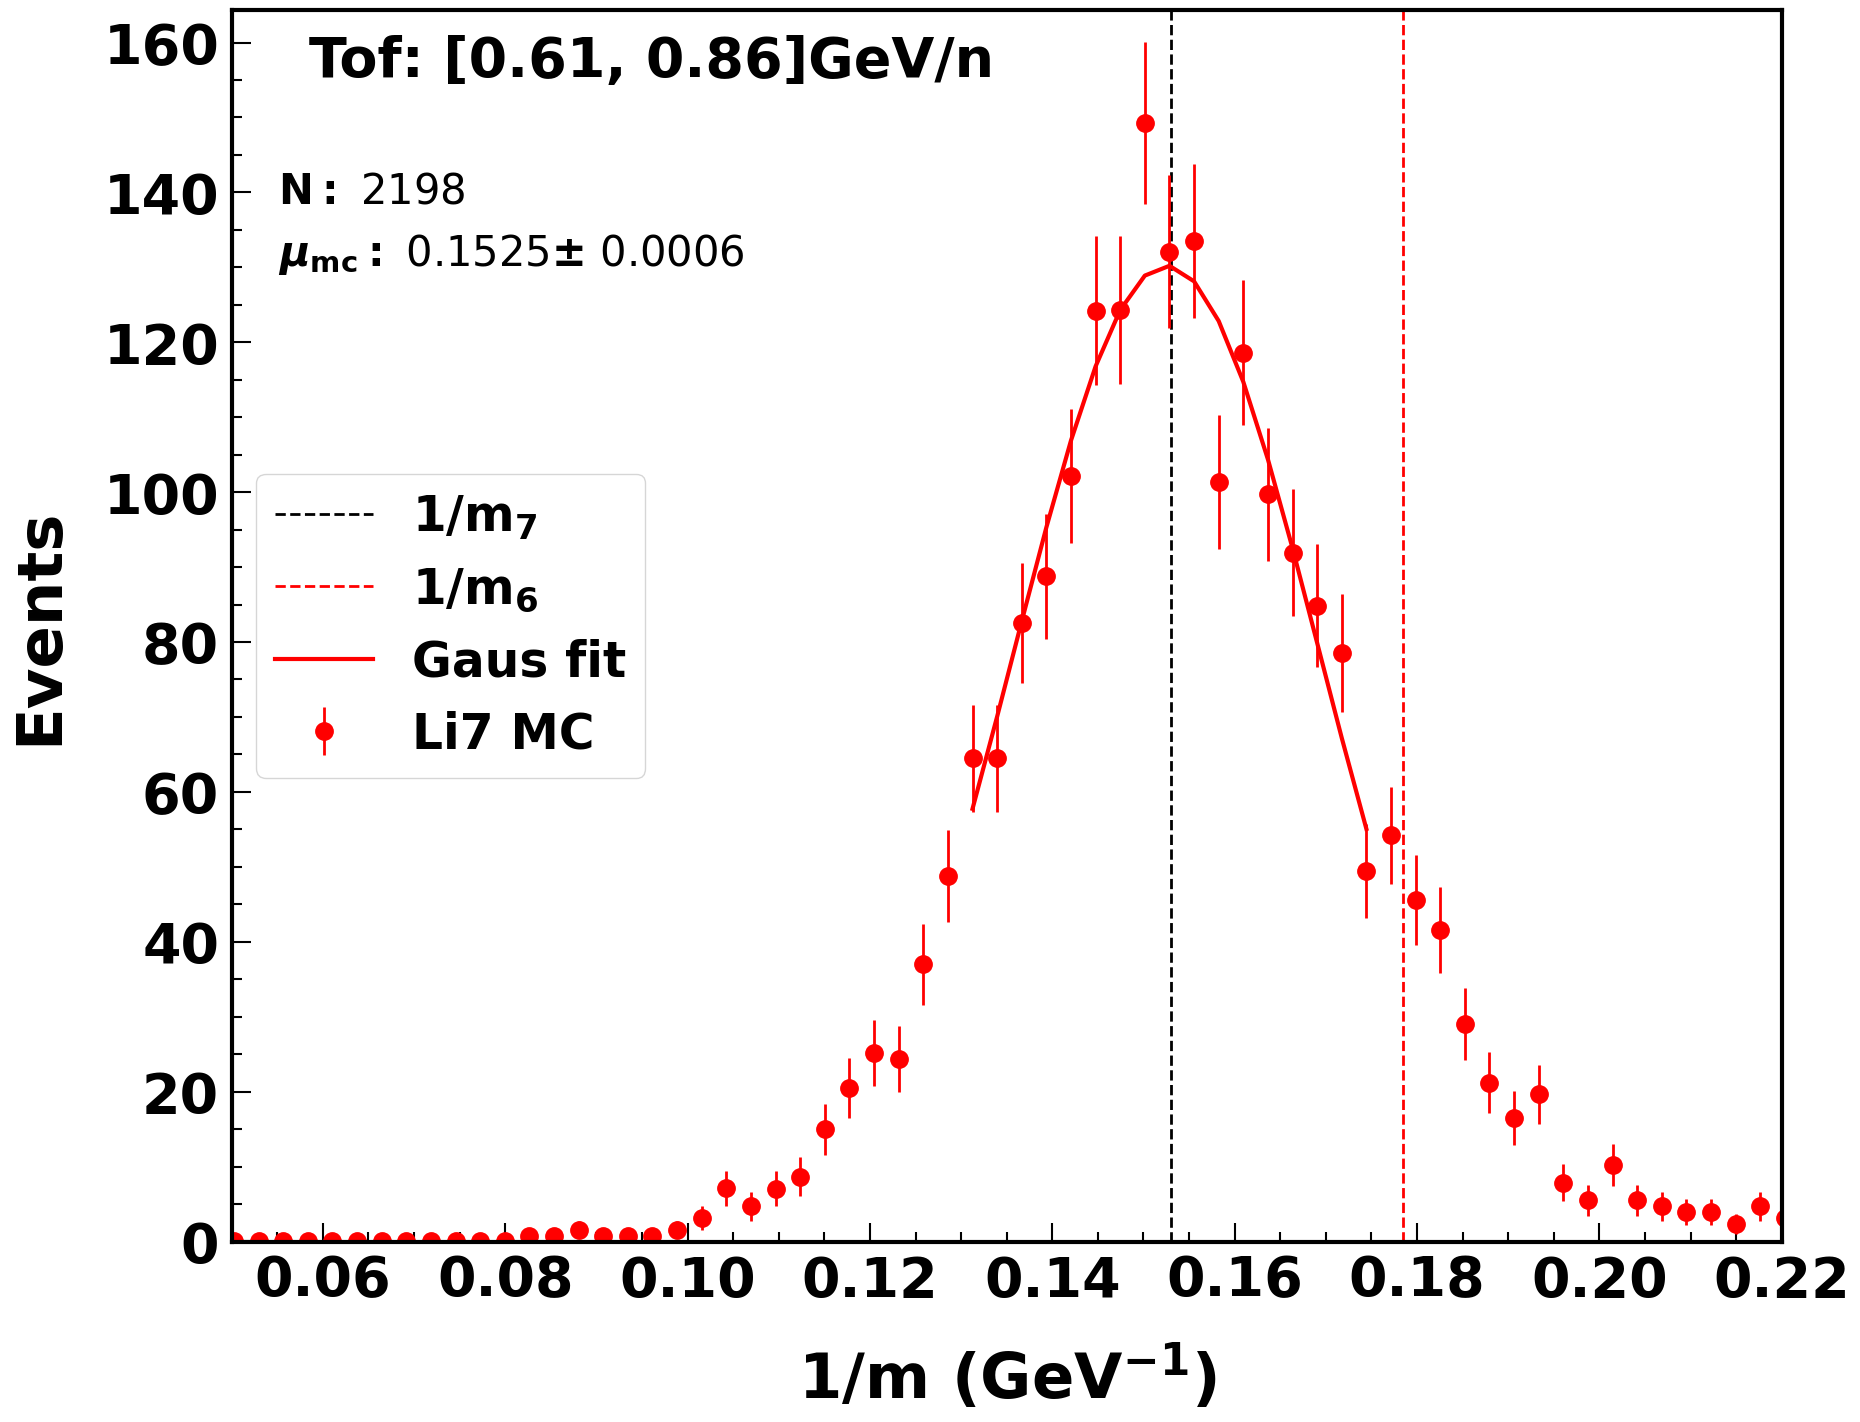

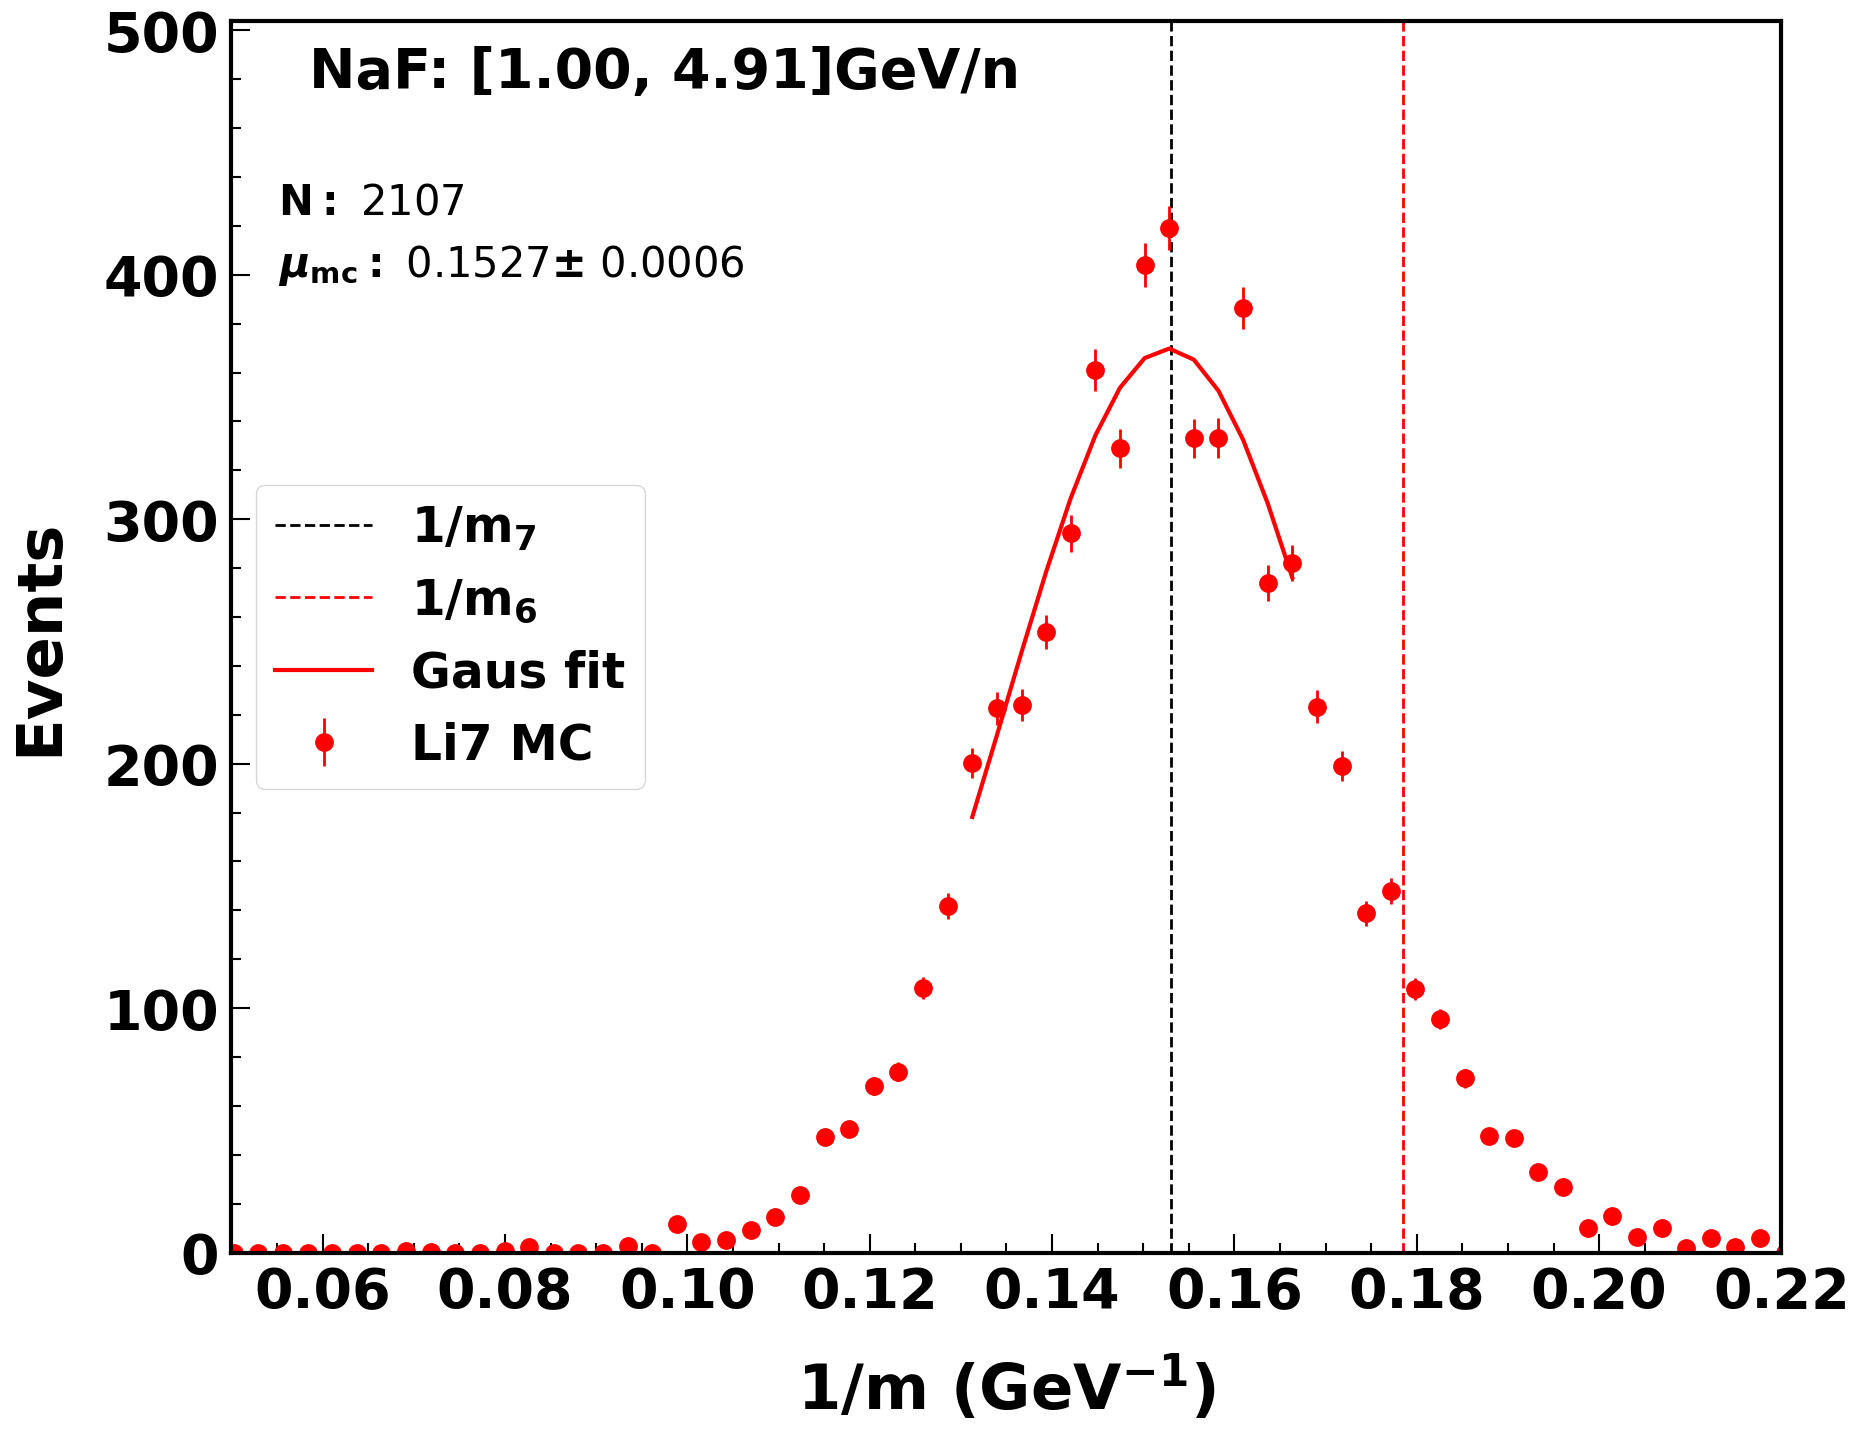

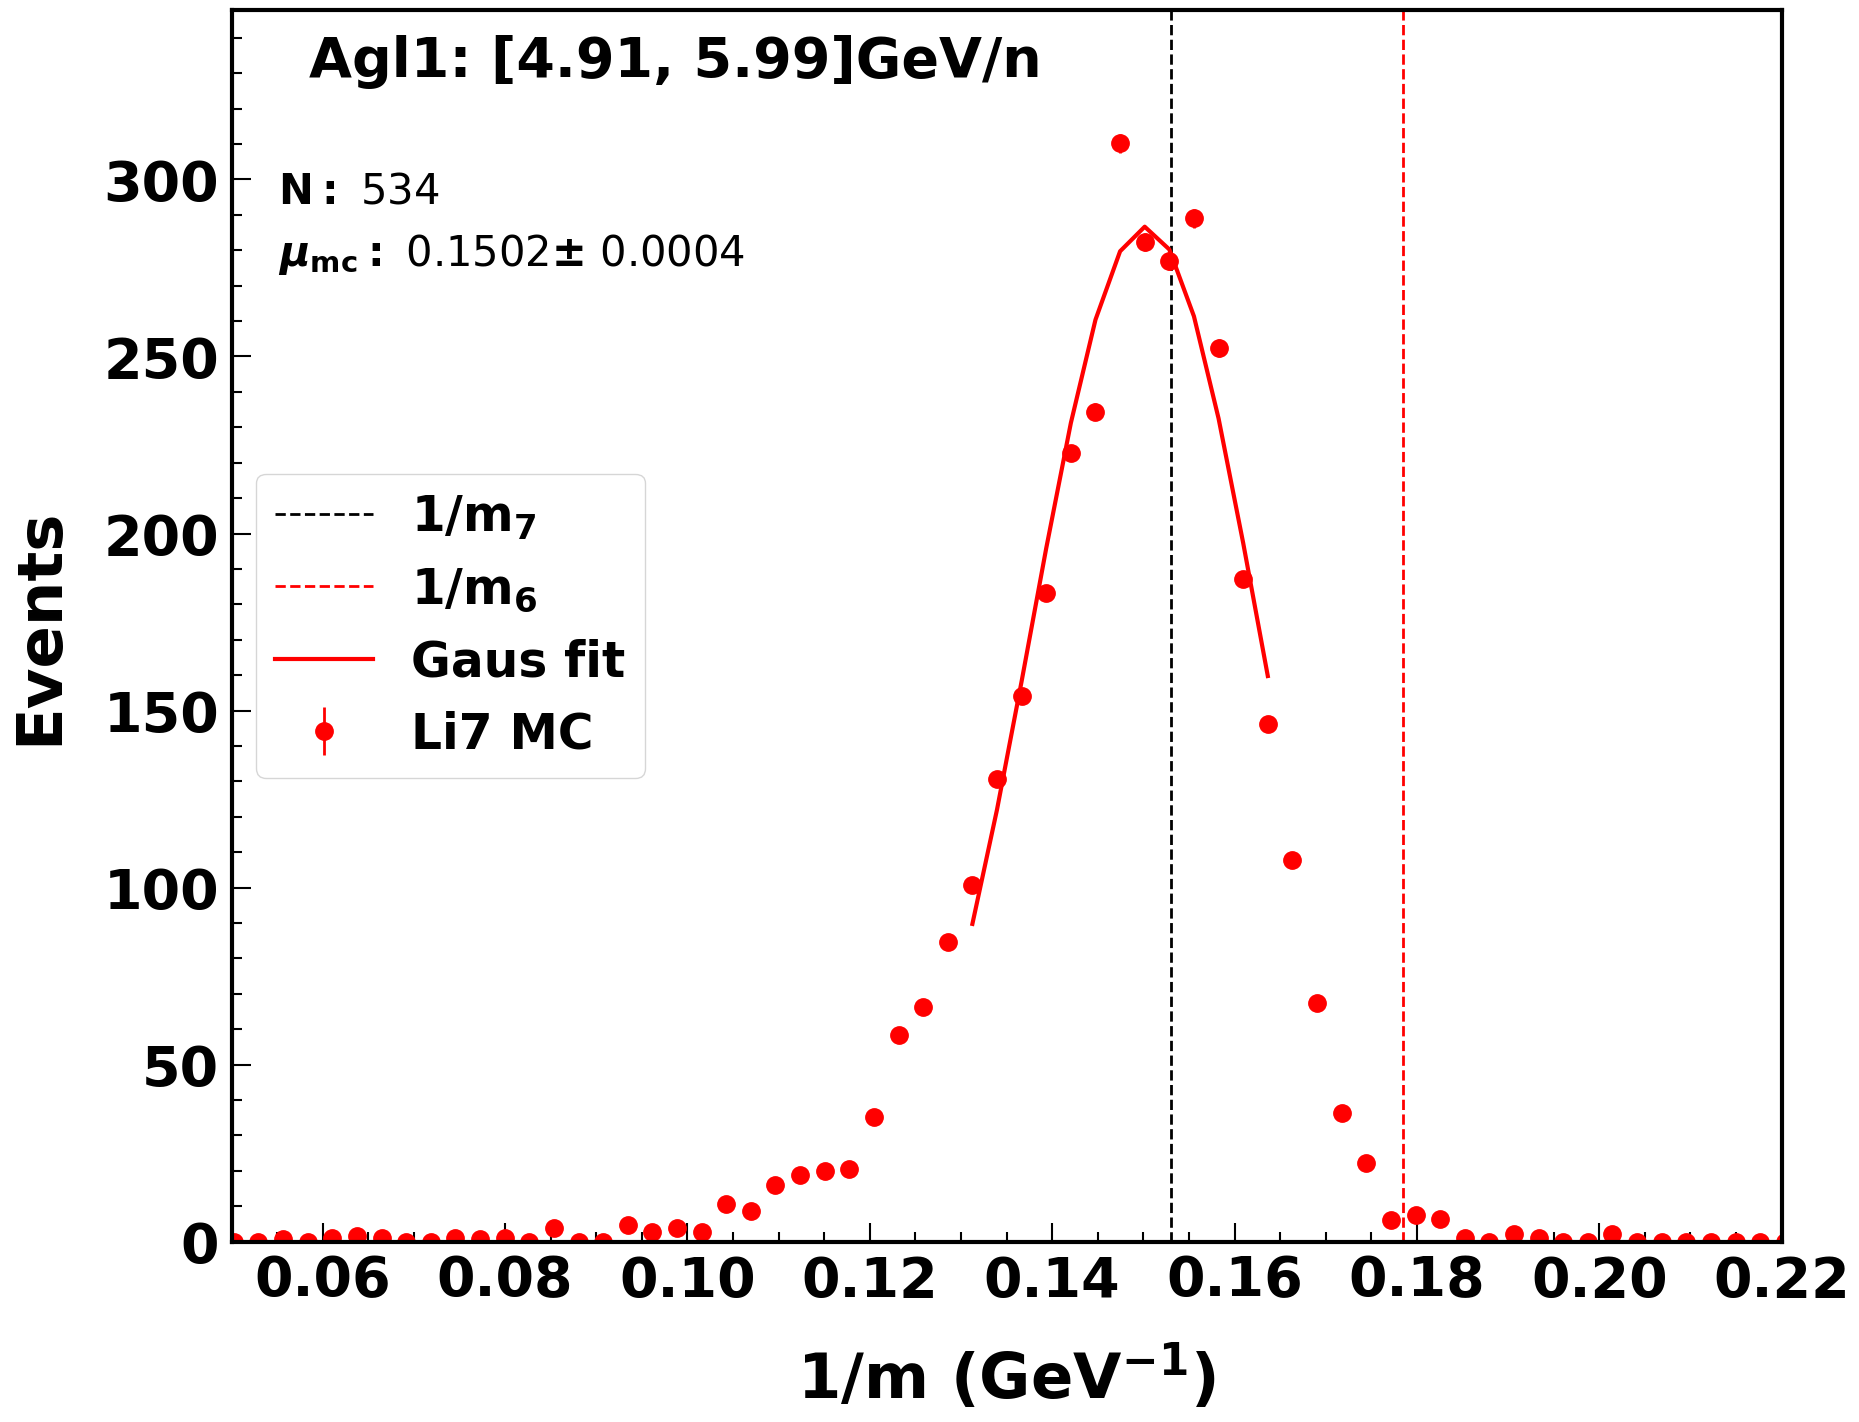

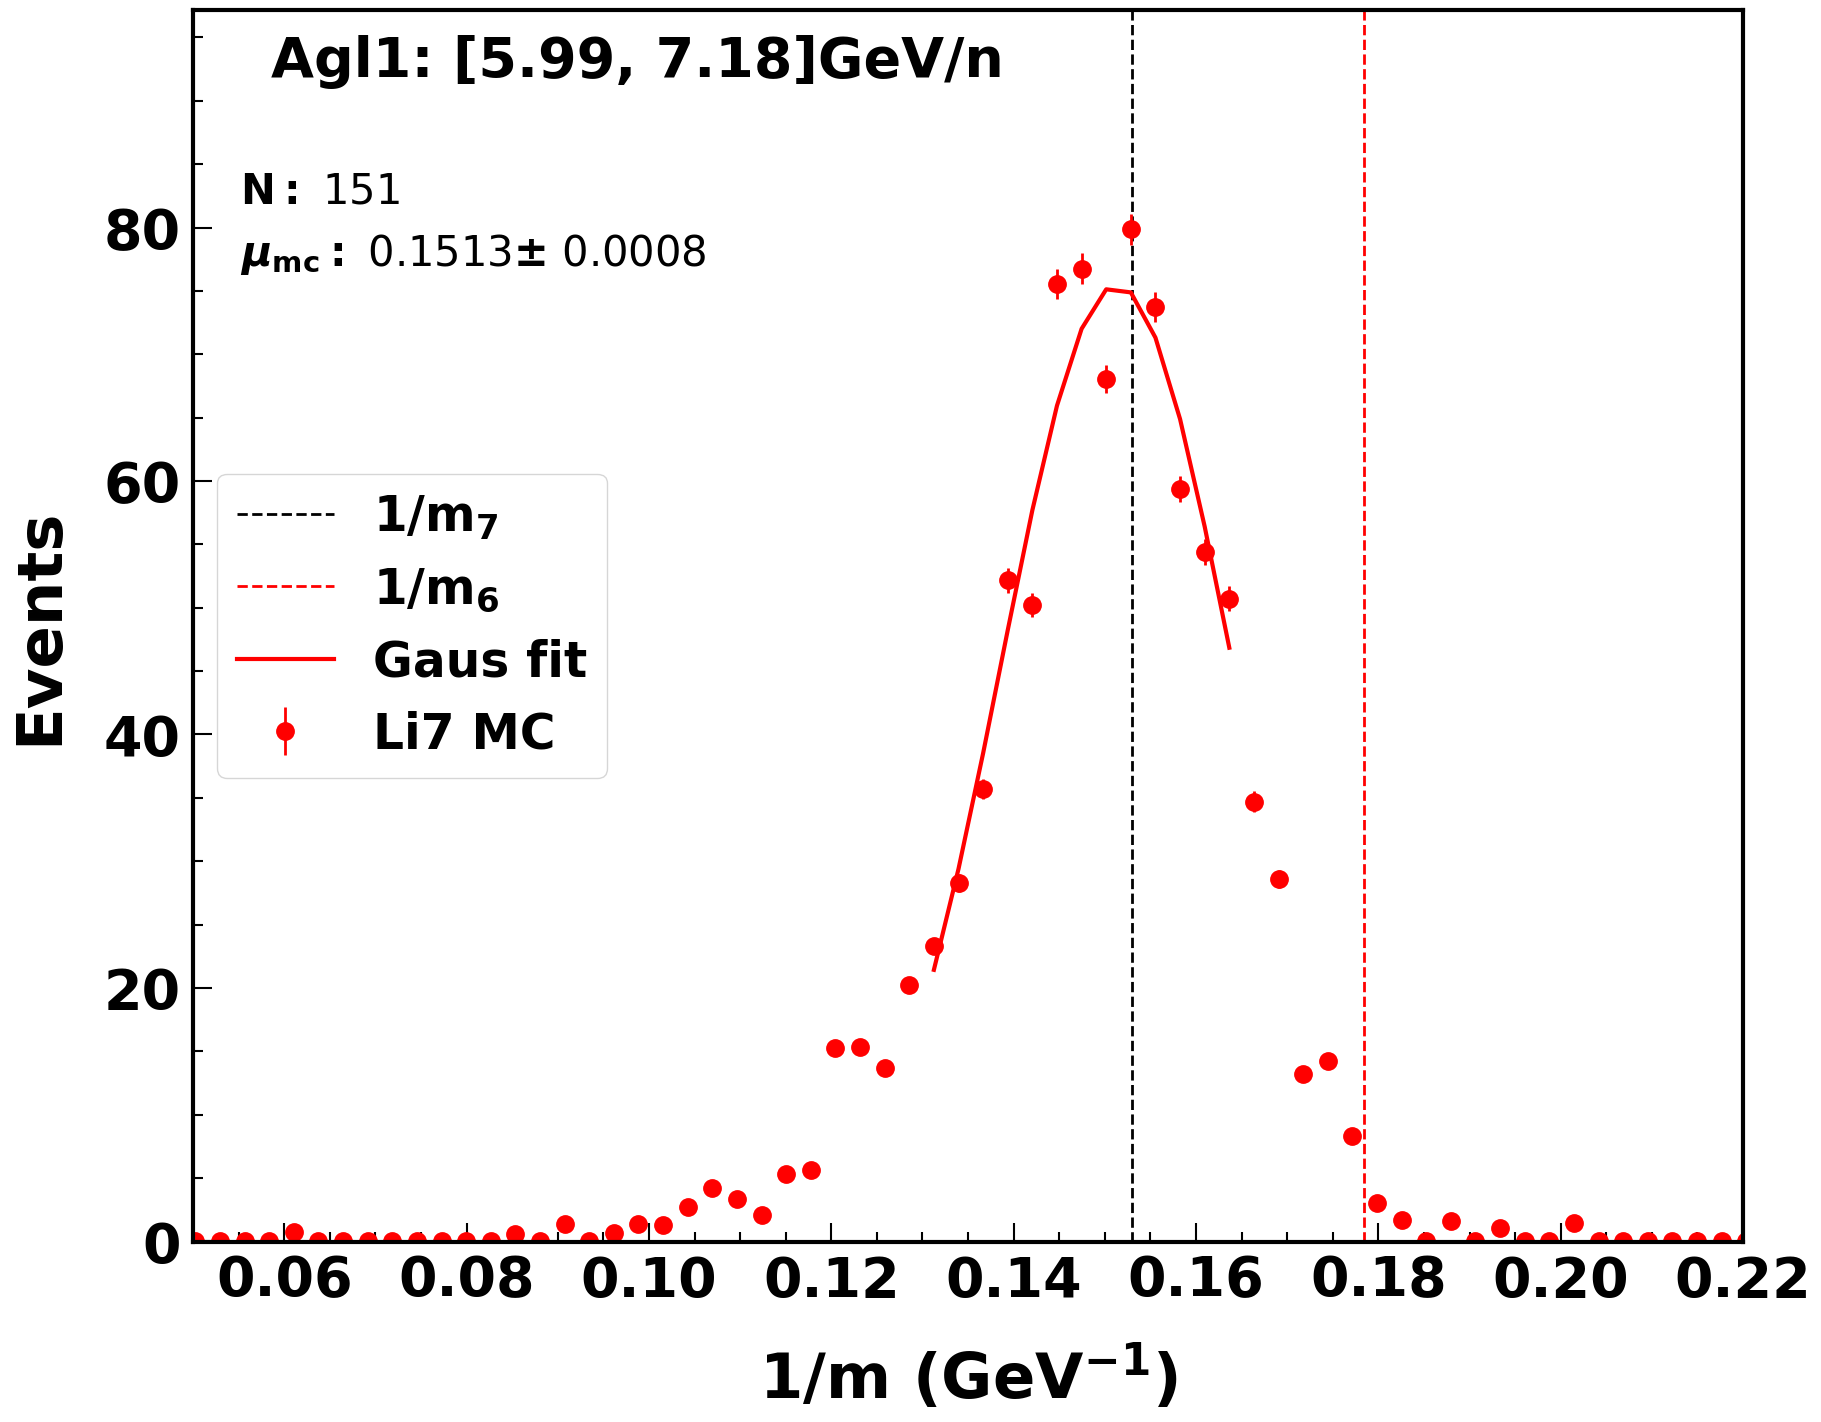

In [39]:
minbin = {'Tof': 1, 'NaF':2, 'Agl1':10}
maxbin =  {'Tof':3,  'NaF':3, 'Agl1':12}
sigmafactor = {'Tof':3,  'NaF':2, 'Agl1':1.8, 'Agl2':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.13, 0.176], 'NaF': [0.13, 0.17], 'Agl1': [0.13, 0.166], 'Agl2': [0.14, 0.163]}

graph_mean_mc = {}
graph_mean_data = {}
drawiss = False



for dec in ['Tof', 'NaF', 'Agl1']:
    energy_binvalues = hist2dmass[dec].binnings[0].bin_centers[minbin[dec]:maxbin[dec]]
    graph_mean_mc[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_mean_data[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin[dec], maxbin[dec])):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        
        
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        if not drawiss:
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        
        set_plot_style(ax1)
        
       
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='red', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
    
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
        xbinrange = hist1dmassbin_iss.binnings[0].get_indices(xrange[dec])
        xedges = hist1dmassbin_iss.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue = hist1dmassbin_iss.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue = hist1dmassbin_iss.values[xbinrange[0]:xbinrange[1]]
        yvalueserr = np.sqrt(yvalue)
        yvalueserr[yvalueserr==0] = 0.0001
        par_iss, parerr_iss = minuitfit_Chi(xvalue, yvalue, yvalueserr,normalized_gaussian, guess0)
        fit_y_iss = normalized_gaussian(xvalue, *par_iss) 
        
        
        yvalue_mc = hist1dmassbin.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(yvalue_mc)
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
        par_mc, parerr_mc = minuitfit_Chi(xvalue, yvalue_mc, yvalueserr_mc ,normalized_gaussian, guess0)
        fit_y_mc = normalized_gaussian(xvalue, *par_mc) 
        print(par_mc)
        print(par_iss)
        print(par_iss['mu']/par_mc['mu'])
        
        #ax1.text(0.03, 0.98, f'Data ', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
        #ax1.text(0.03, 0.8, rf"\\mu: {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        graph_mean_mc[dec].yvalues[ip] = par_mc['mu']
        graph_mean_mc[dec].yerrs[ip] = parerr_mc['mu']
        graph_mean_data[dec].yvalues[ip] = par_iss['mu']
        graph_mean_data[dec].yerrs[ip] = parerr_iss['mu']
        
        if drawiss:
            plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_iss, '-', linewidth=3, color=col['iss'], label='Gaus fit')
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin_iss.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{data}} }}:$ {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        else:
            plot_histogram_1d(ax1, hist1dmassbin, style="iss", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_mc, '-', linewidth=3, color=col['mc'], label='Gaus fit')
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{mc}} }}:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            
        print(plotfile)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
        ax1.legend(fontsize=35, loc='center left')
        print(dec, 'number events:', np.sum(hist1dmassbin.values[10:90]))
        plotfile='/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
        if drawiss:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_iss", show=True) 
        else:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_mc", show=True) 
       

1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_TofLi7_1_Li7
<ValueView norm=8.46266281158704 mu=0.15330256328624714 sigma=0.01776996225596459>
<ValueView norm=8.015674437508084 mu=0.15399325897068752 sigma=0.016994109493455593>
1.004505441198336
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
Tof number events: 3293.5583143157946
2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_NaFLi7_2_Li7
<ValueView norm=15.668079729155055 mu=0.15270222114525495 sigma=0.016659601355075722>
<ValueView norm=15.192643251411974 mu=0.15175932427586872 sigma=0.015092090169505171>
0.9938252576660996
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
NaF number events: 6084.20875338828
11 6.58395
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_Agl1Li7_11_Li7
<ValueView norm=2.4347954792480055 mu=0.15116146631492058 sigma=0.01290440691356101>
<ValueView norm=2.7524810881946156 mu=0.15364345840258256 sigma=0.014726561965

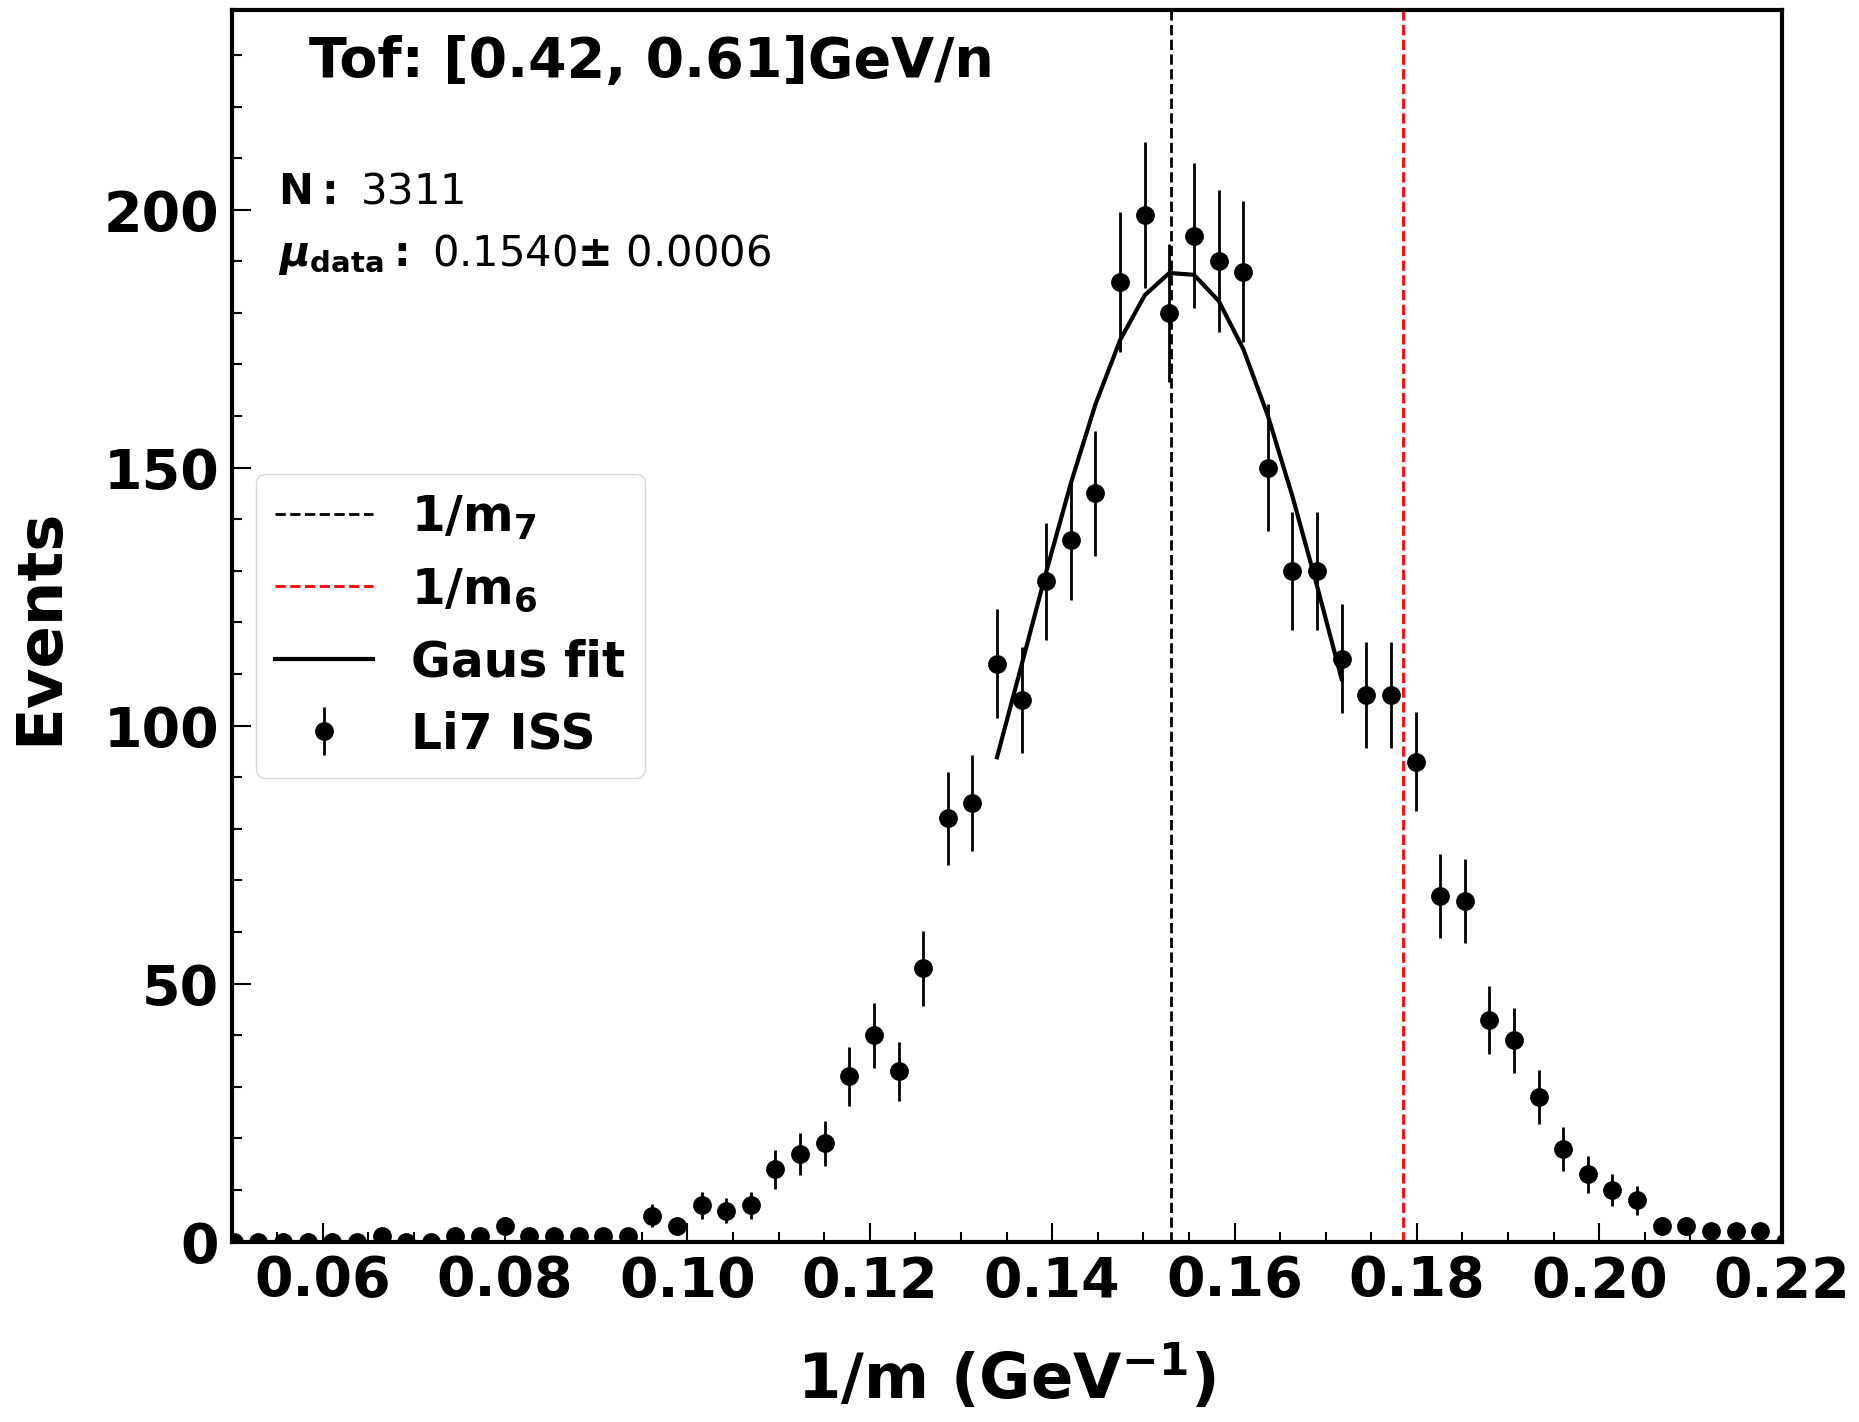

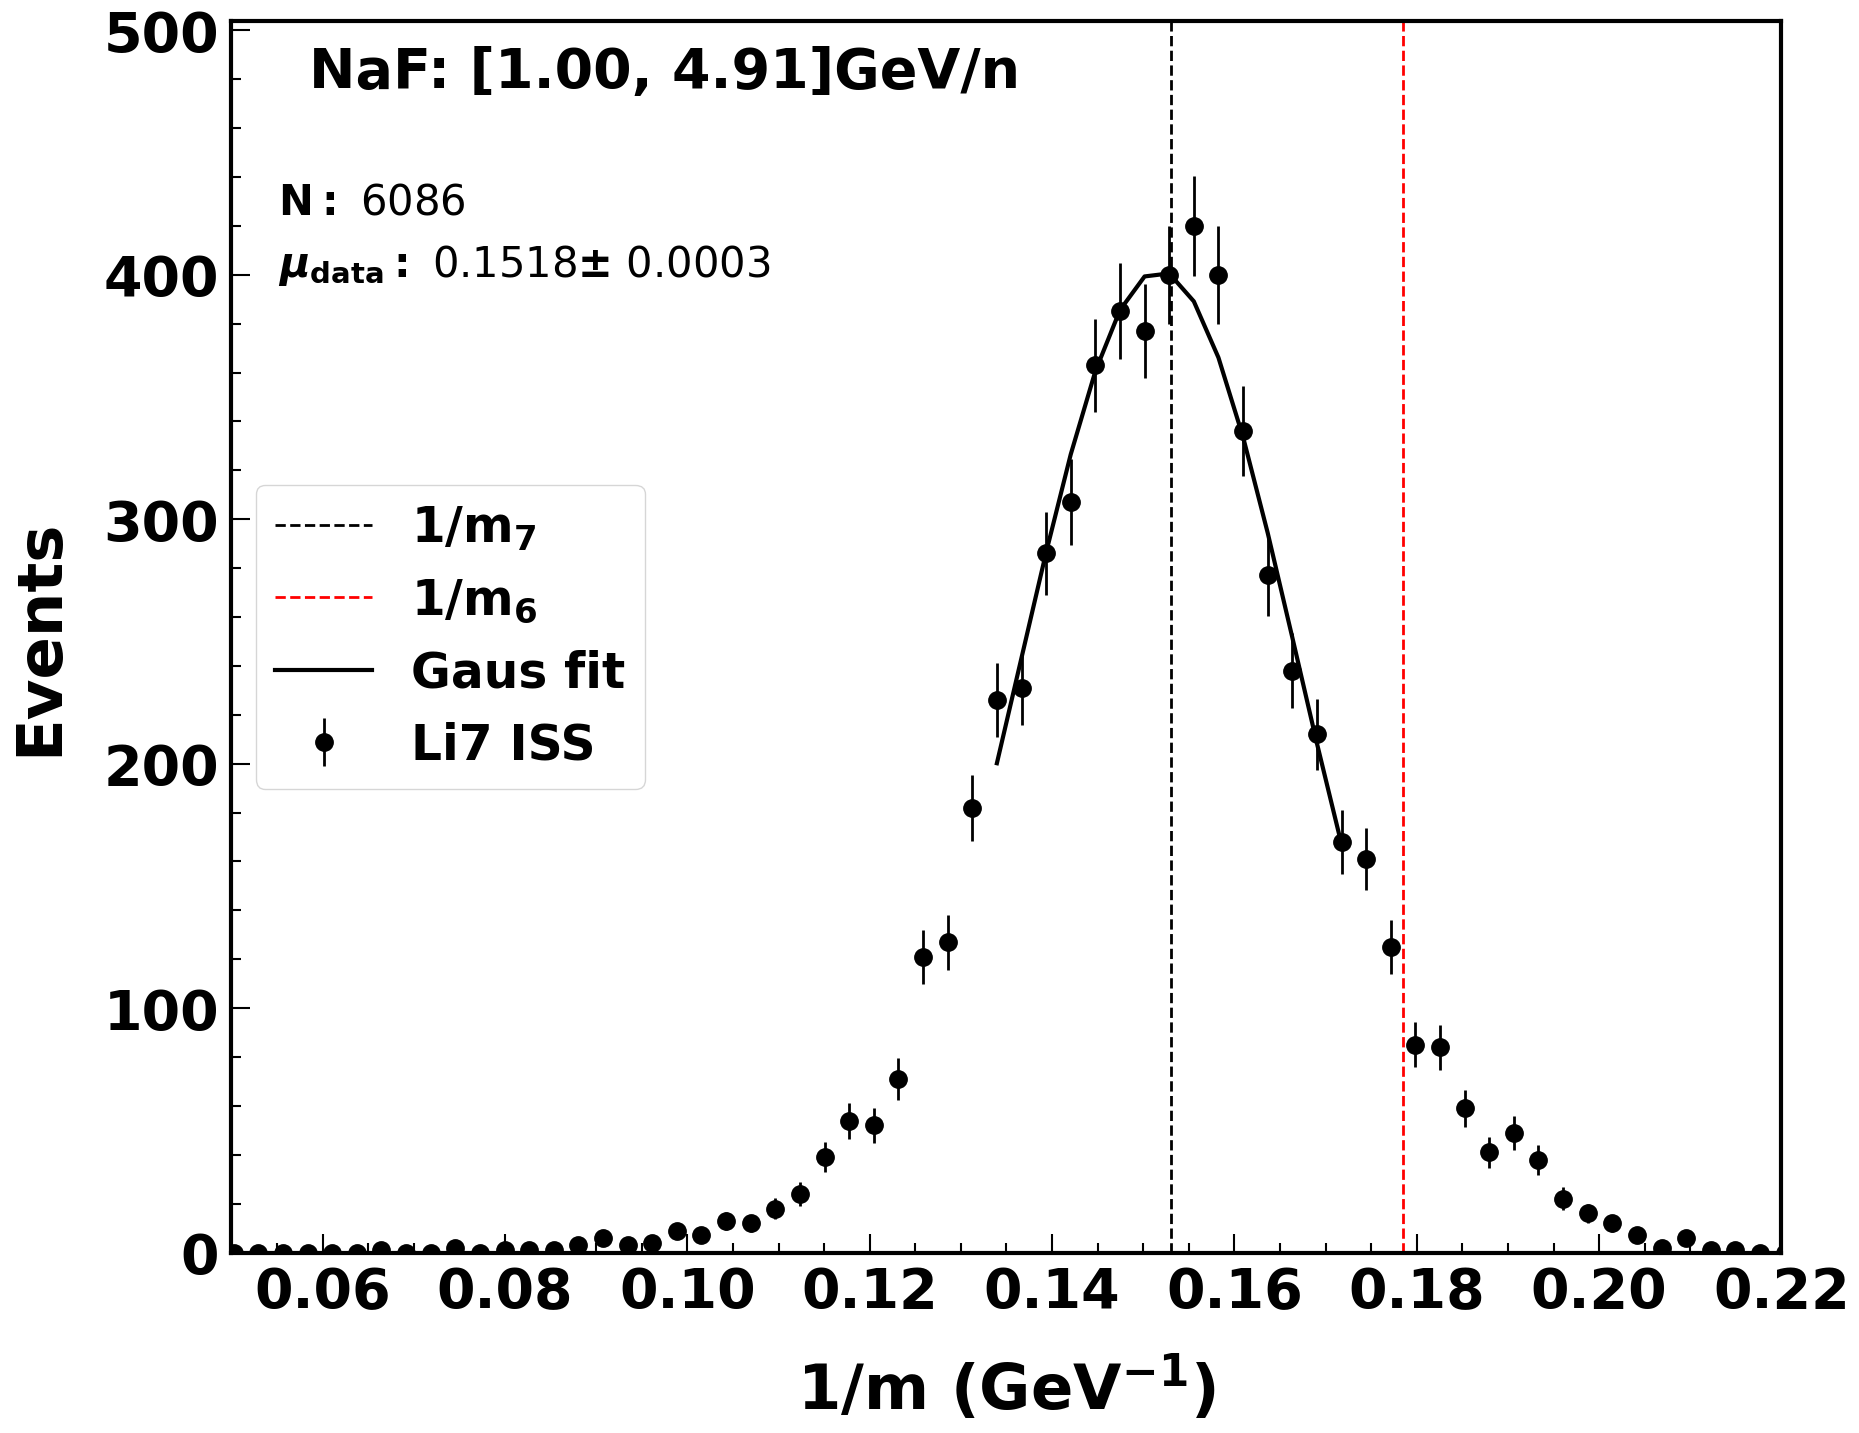

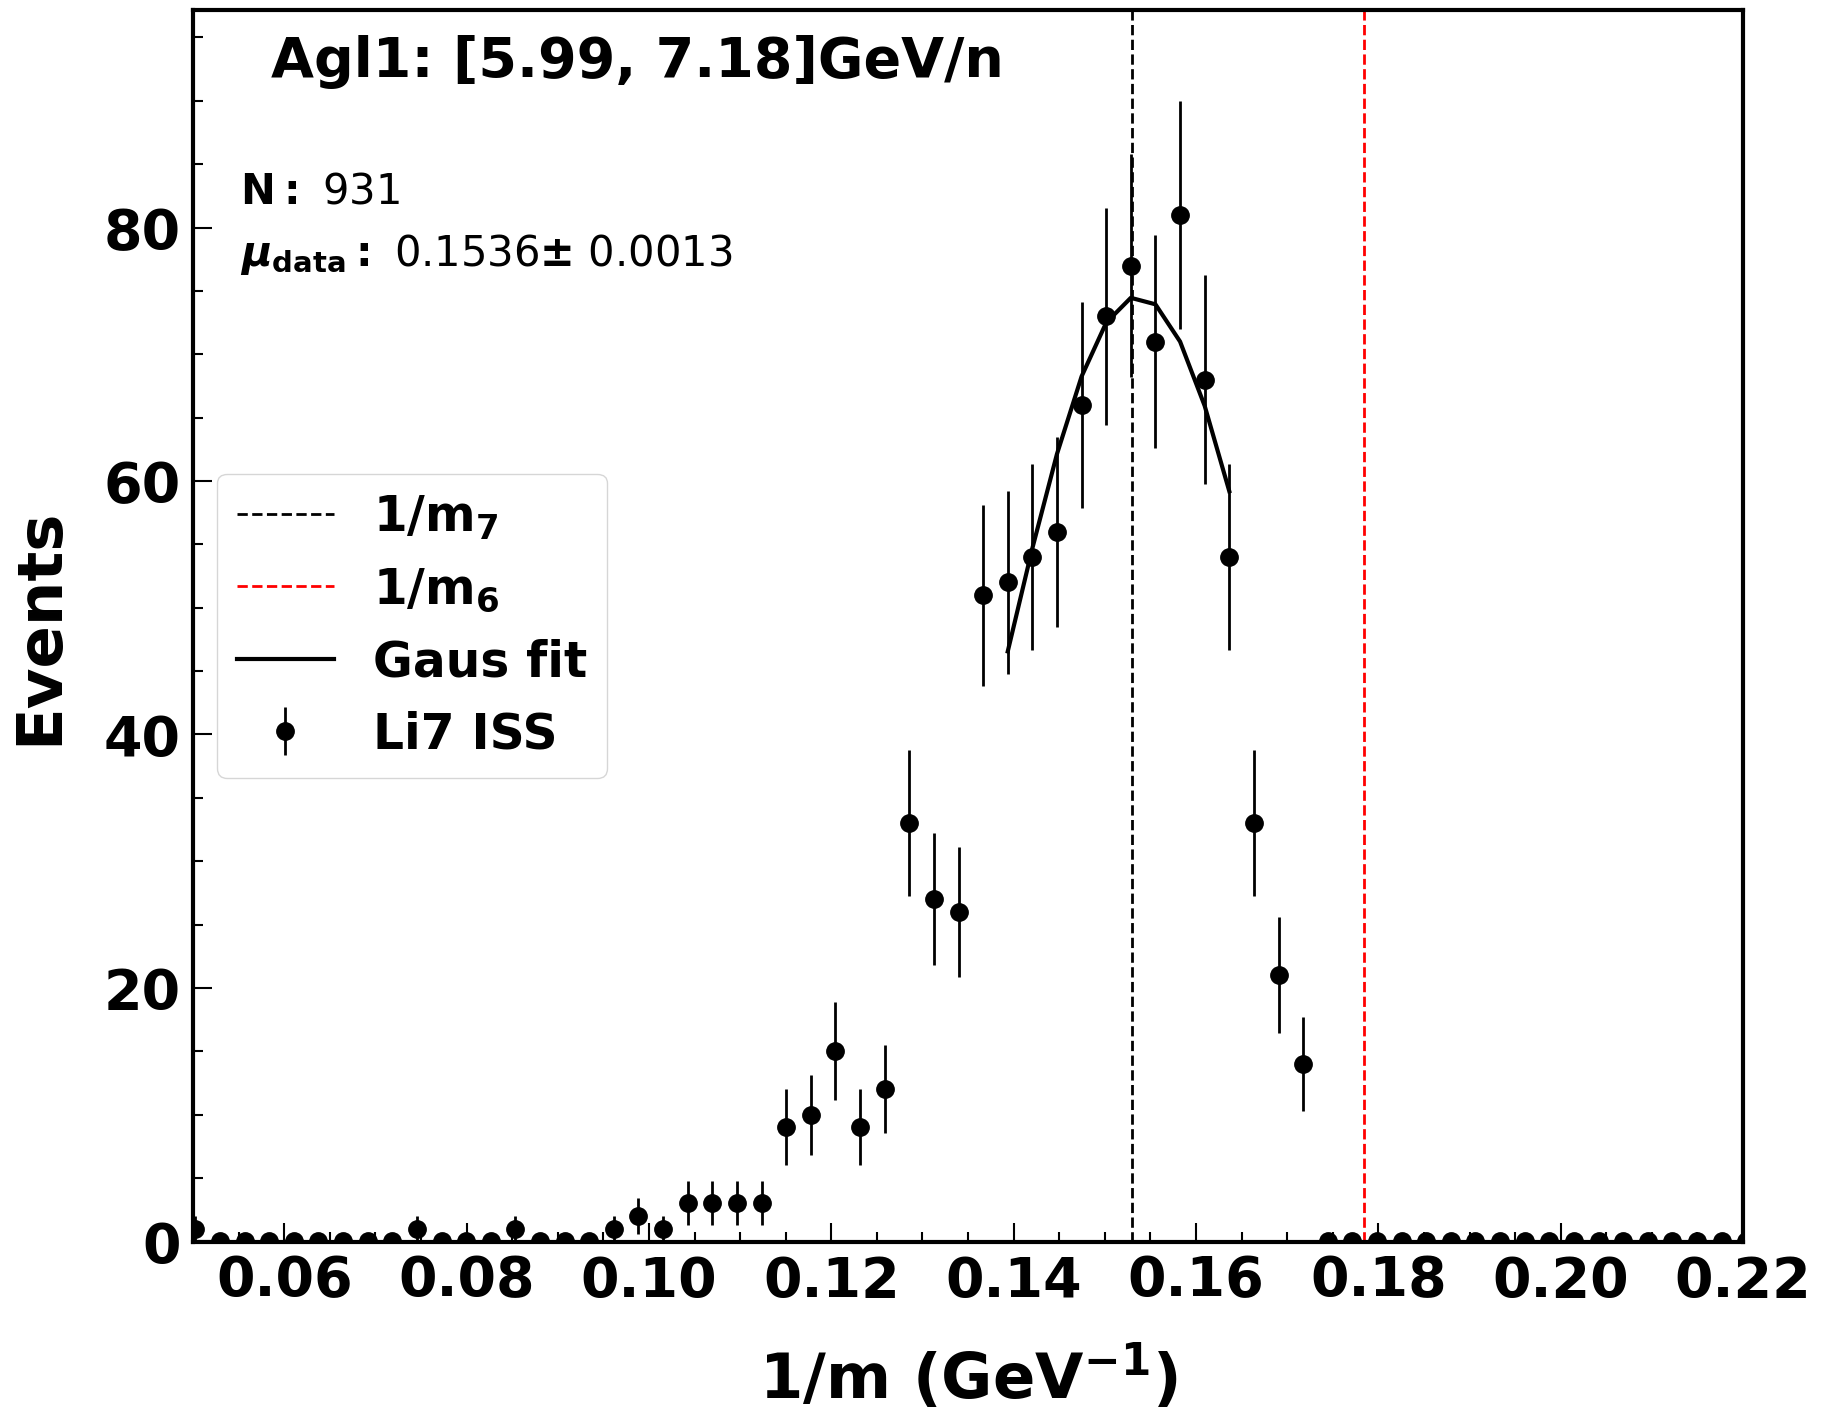

In [40]:
minbin = {'Tof': 1, 'NaF':2, 'Agl1':11}
maxbin =  {'Tof':2,  'NaF':3, 'Agl1':12}
sigmafactor = {'Tof':2,  'NaF':2, 'Agl1':1.8, 'Agl2':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.135, 0.175], 'NaF': [0.135, 0.175], 'Agl1': [0.138, 0.165], 'Agl2': [0.135, 0.16]}

graph_mean_mc = {}
graph_mean_data = {}
drawiss = True

for dec in ['Tof', 'NaF', 'Agl1']:
    energy_binvalues = hist2dmass[dec].binnings[0].bin_centers[minbin[dec]:maxbin[dec]]
    graph_mean_mc[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_mean_data[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin[dec], maxbin[dec])):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        
        
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        if not drawiss:
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        
        set_plot_style(ax1)
        
       
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='red', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
    
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
        xbinrange = hist1dmassbin_iss.binnings[0].get_indices(xrange[dec])
        xedges = hist1dmassbin_iss.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue = hist1dmassbin_iss.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue = hist1dmassbin_iss.values[xbinrange[0]:xbinrange[1]]
        yvalueserr = np.sqrt(yvalue)
        yvalueserr[yvalueserr==0] = 0.0001
        par_iss, parerr_iss = minuitfit_Chi(xvalue, yvalue, yvalueserr,normalized_gaussian, guess0)
        fit_y_iss = normalized_gaussian(xvalue, *par_iss) 
        
        
        yvalue_mc = hist1dmassbin.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(yvalue_mc)
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
        par_mc, parerr_mc = minuitfit_Chi(xvalue, yvalue_mc, yvalueserr_mc ,normalized_gaussian, guess0)
        fit_y_mc = normalized_gaussian(xvalue, *par_mc) 
        print(par_mc)
        print(par_iss)
        print(par_iss['mu']/par_mc['mu'])
        
        #ax1.text(0.03, 0.98, f'Data ', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
        #ax1.text(0.03, 0.8, rf"\\mu: {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        graph_mean_mc[dec].yvalues[ip] = par_mc['mu']
        graph_mean_mc[dec].yerrs[ip] = parerr_mc['mu']
        graph_mean_data[dec].yvalues[ip] = par_iss['mu']
        graph_mean_data[dec].yerrs[ip] = parerr_iss['mu']
        
        if drawiss:
            plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_iss, '-', linewidth=3, color=col['iss'], label='Gaus fit')
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin_iss.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{data}} }}:$ {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        else:
            plot_histogram_1d(ax1, hist1dmassbin, style="iss", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_mc, '-', linewidth=3, color=col['mc'], label='Gaus fit')
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{mc}} }}:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            
        print(plotfile)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
        ax1.legend(fontsize=35, loc='center left')
        print(dec, 'number events:', np.sum(hist1dmassbin.values[10:90]))
        plotfile='/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
        if drawiss:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_iss", show=True) 
        else:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_mc", show=True) 
       

KeyError: 'Agl2'

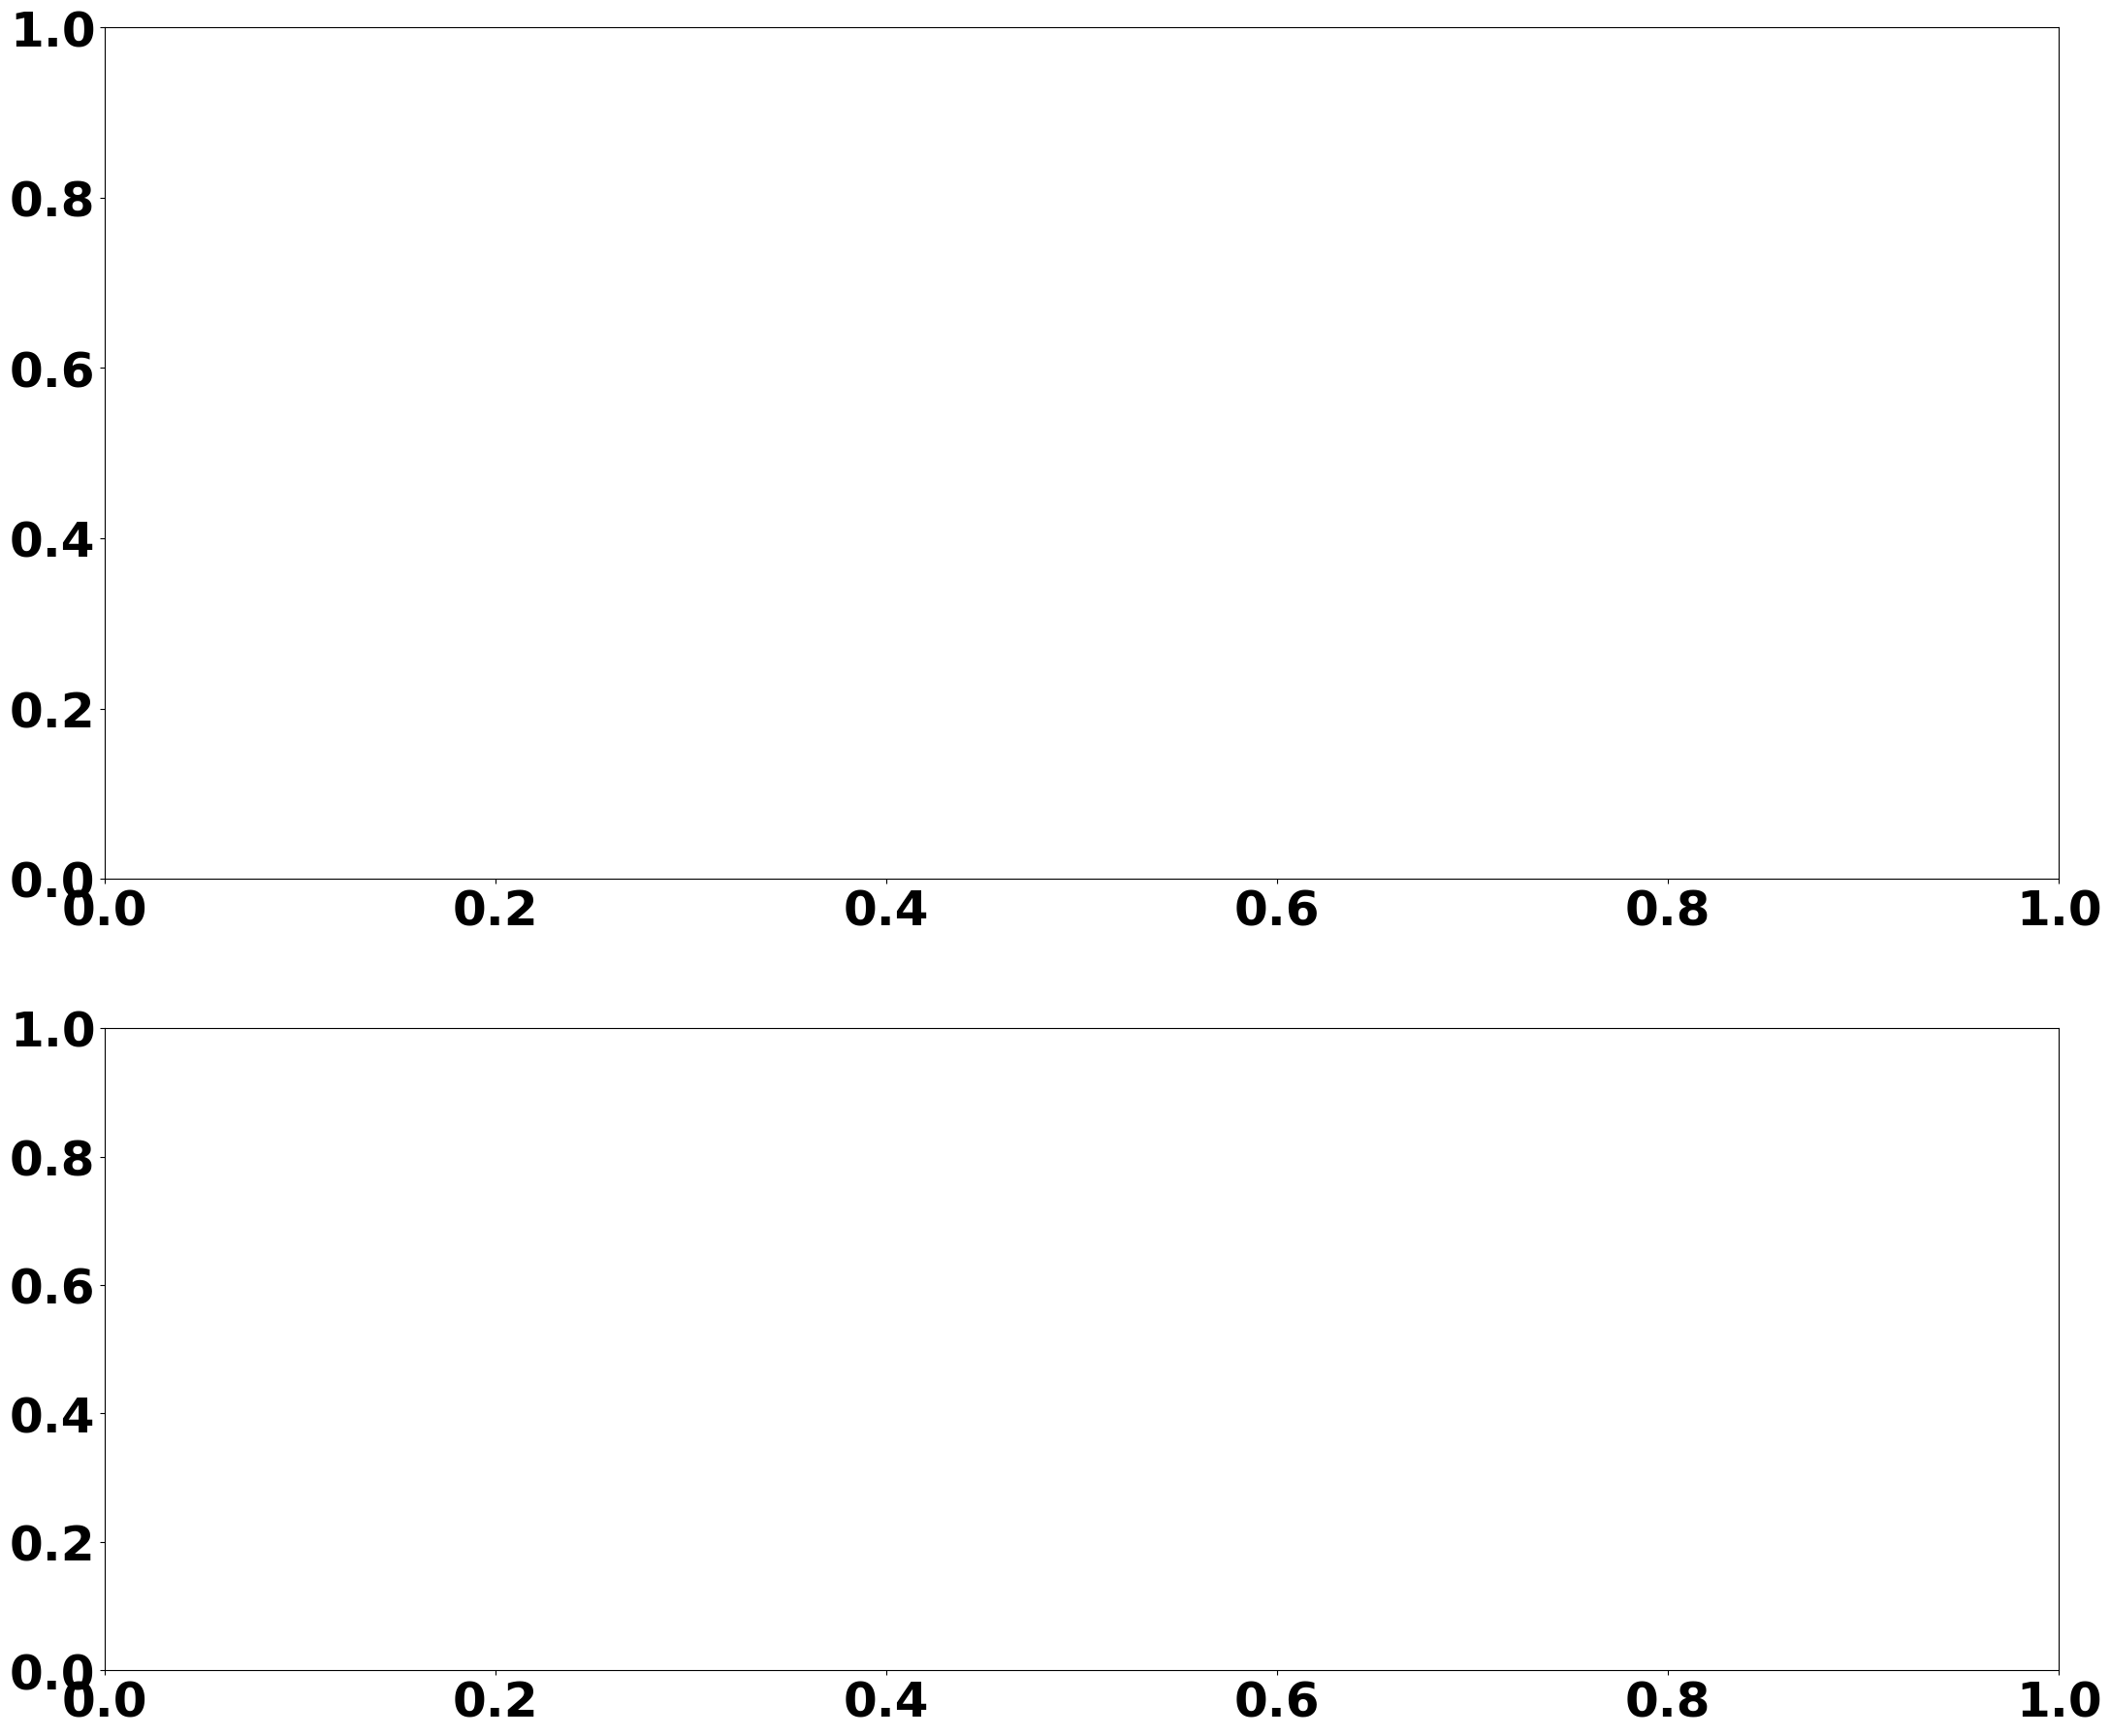

In [41]:
figsize = (26, 22)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.57, 0.43]}, figsize=figsize) 


dic_save = {}
graph_ratio = {}
#graph_mean_mc['Agl1'].yvalues = np.array([0.152])
#graph_mean_mc['Agl1'].xvalues = np.array([6.0])
#graph_mean_data['Agl1'].xvalues = np.array([6.0])
#graph_mean_mc['NaF'].yvalues = np.array([0.152])
for dec in detectors:
    decname = 'Agl' if 'Agl' in dec else dec
    graph_ratio[dec] = graph_mean_data[dec]/graph_mean_mc[dec]
    graph_ratio[dec].yvalues -= 1.0
    graph_ratio[dec].add_to_file(dic_save, f'graph_cutoff_mean_{dec}')
#graph_ratio['Tof'].yerrs *= 0.95
#graph_ratio['Agl1'].yerrs *= 0.95

    
np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May', 'graph_cutoff_mean_20May.npz'), **dic_save)


for dec in detectors:
    decname = 'Agl' if 'Agl' in dec else dec
    plot_graph(fig, ax1, graph_mean_mc[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=23, label=f"{ISO_LABELS[iso]} MC {decname}", marker='s', markerfacecolor='none')
    #plot_graph(fig, ax1, graph_mean_issLi7[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=27, label=f"{ISO_LABELS[iso]} Data {dec}", markerfacecolor='none') 
    plot_graph(fig, ax1, graph_mean_data[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=38, label=f"{ISO_LABELS[iso]} Data {decname}")   
    plot_graph(fig, ax2, graph_ratio[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=30, label=f"Data/MC")
set_plot_style(ax1)
set_plot_style(ax2)
ax1.legend(fontsize=35, loc='lower right')
#ax2.legend(fontsize=35)

#ax1.text(0.48, 0.95, 'Agl', fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
SetAx1Ax2Xaxis(ax1, ax2, 'Ek/n (GeV/n)', TEXTSIZE, xlimrange=[0.1, 10.0],  custom_ticks=None, custom_tickslabels=None, gridx1=False,  gridx2=False, xscale=False)
SetAx1Ax2Yaxis(ax1, ax2, r'1/m (1/GeV)', '(Data-MC)/MC', TEXTSIZE, ylimrange1=[0.142, 0.158],  ylimrange2=[-0.016, 0.016], gridy1=False,  gridy2=True, yscale1=None, yscale2=None)

#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/Plots_Thesis'
print(plotfile)
savefig_tofile(fig, plotfile, f"Li7mean_compareDataMC_invmass_{figName}_20May_Test", show=True)
print( f"Li7mean_compareDataMC_invmass_{figName}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8 3.61425
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_Agl1Li7_8_Li7
<ValueView norm=1750.9616954918336 m=0.15323198969814633 w=-0.007104415669305665>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9 4.45875
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_Agl1Li7_9_Li7
<ValueView norm=1923.345181446054 m=0.15334875975979625 w=-0.007433605162422106>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10 5.4516
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_Agl1Li7_10_Li7
<ValueView norm=1246.8097670411007 m=0.15449770805073507 w=-0.00718354976931402>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11 6.58395
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_Agl1Li7_11_Li7
<ValueView norm=335.40463043929674 m=0.15549476707009663 w=-0.007396833529862921>


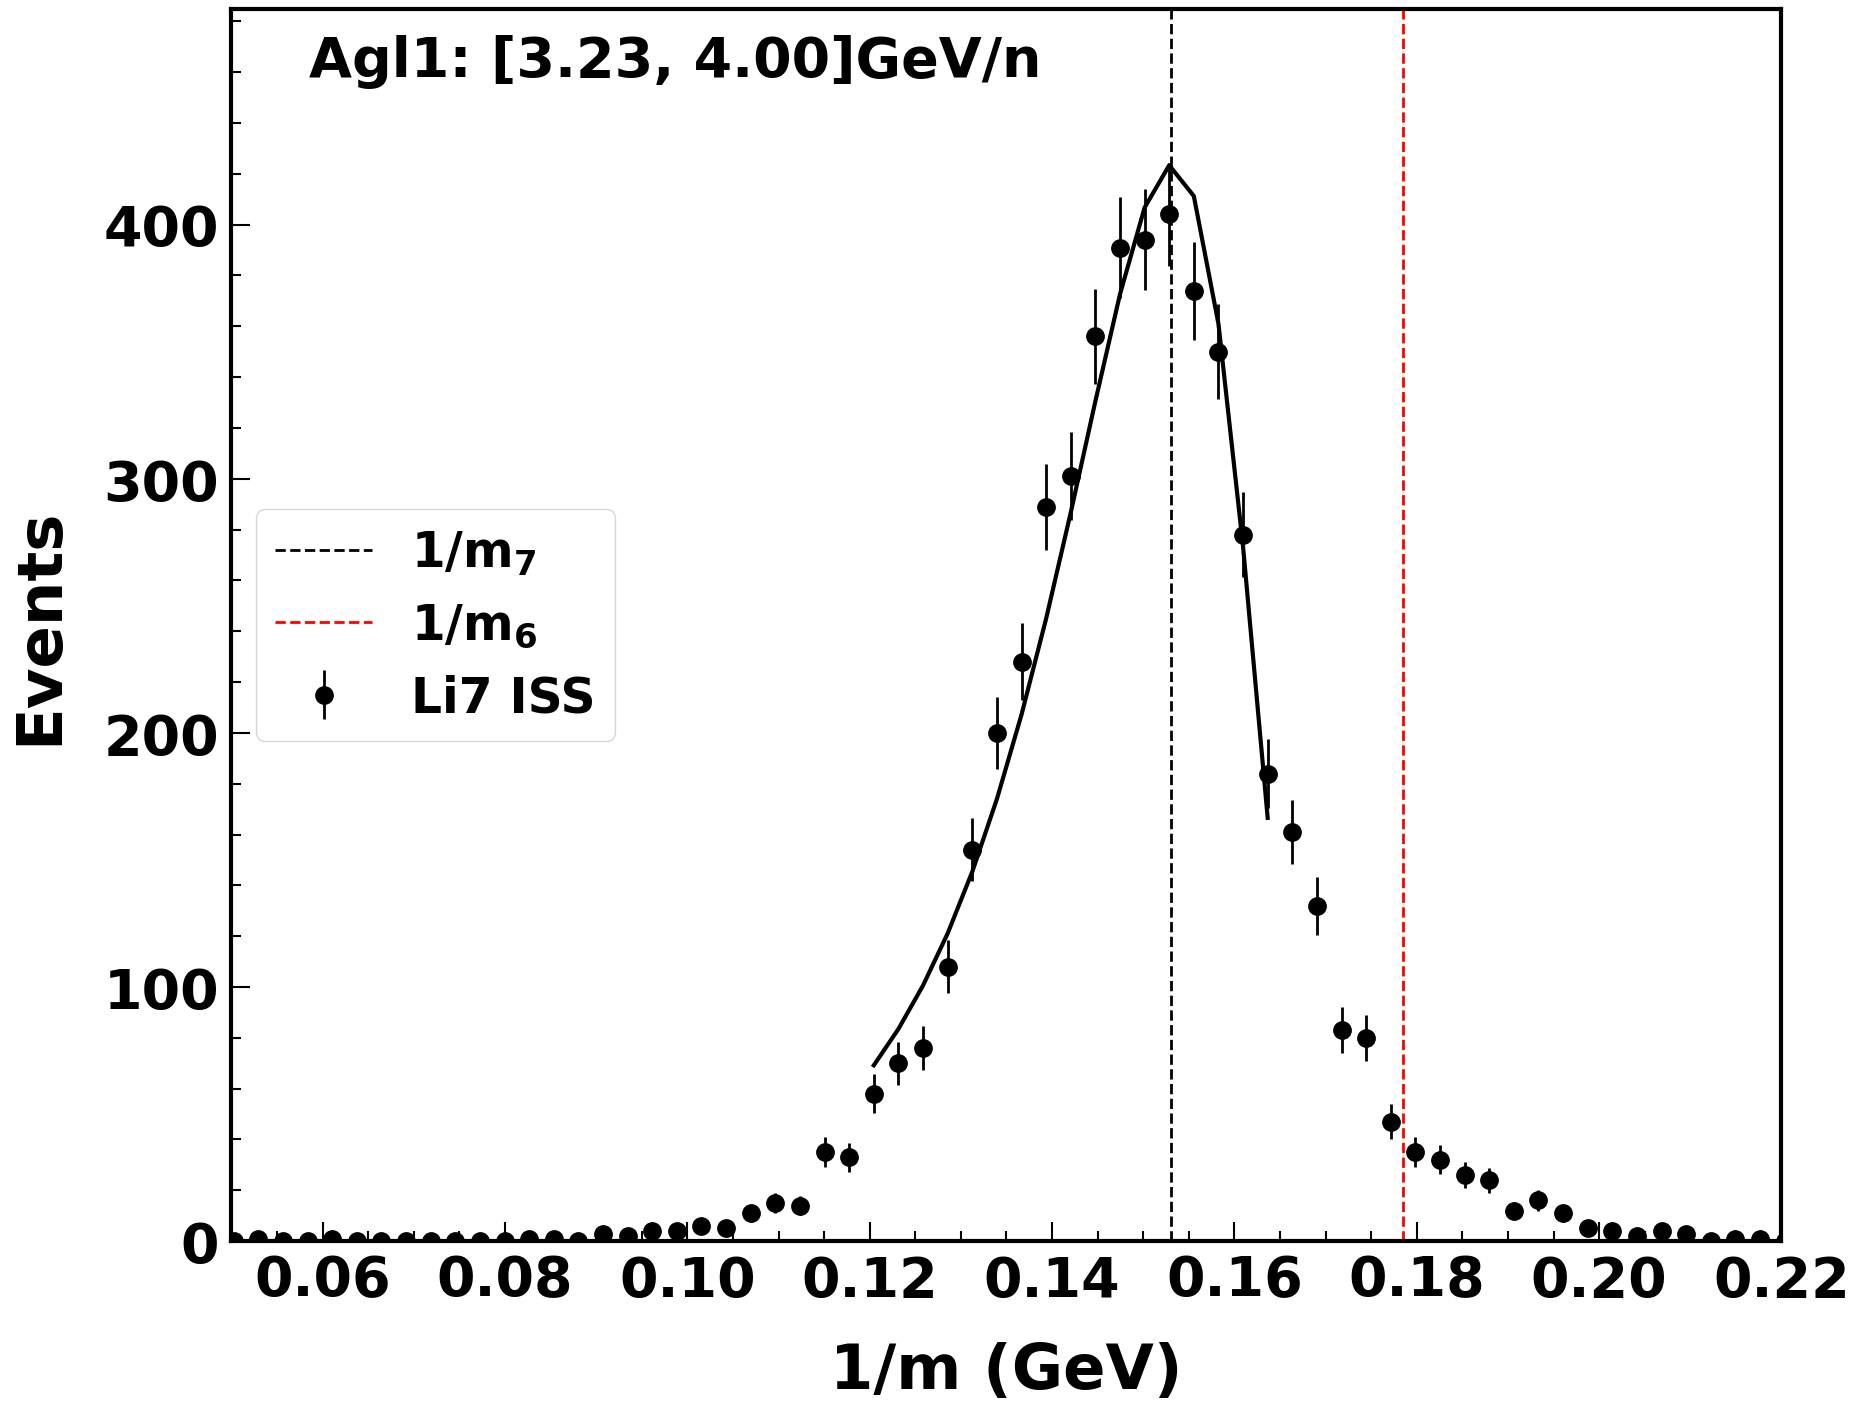

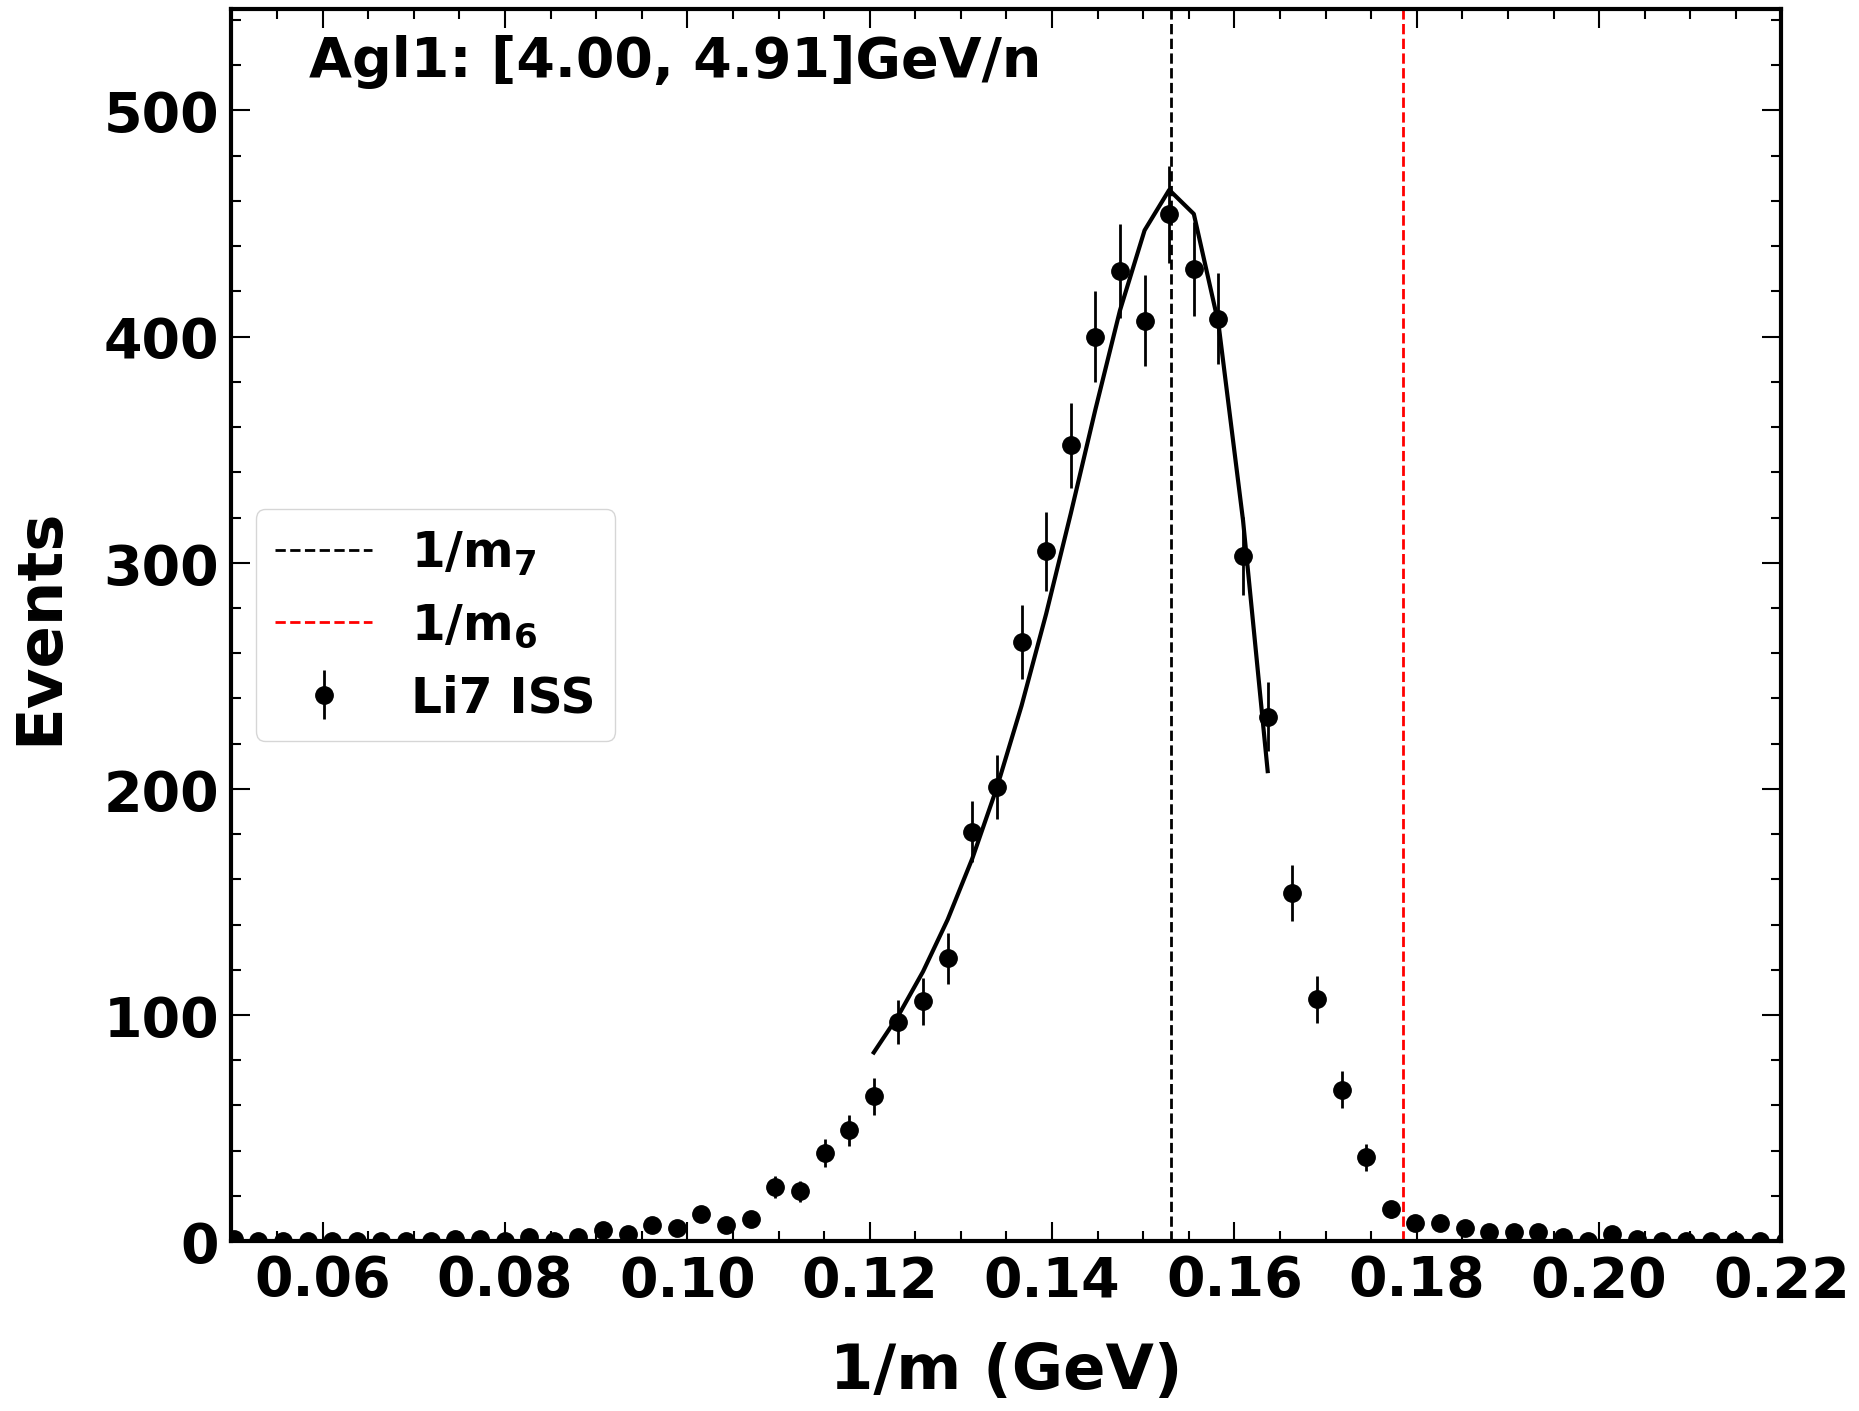

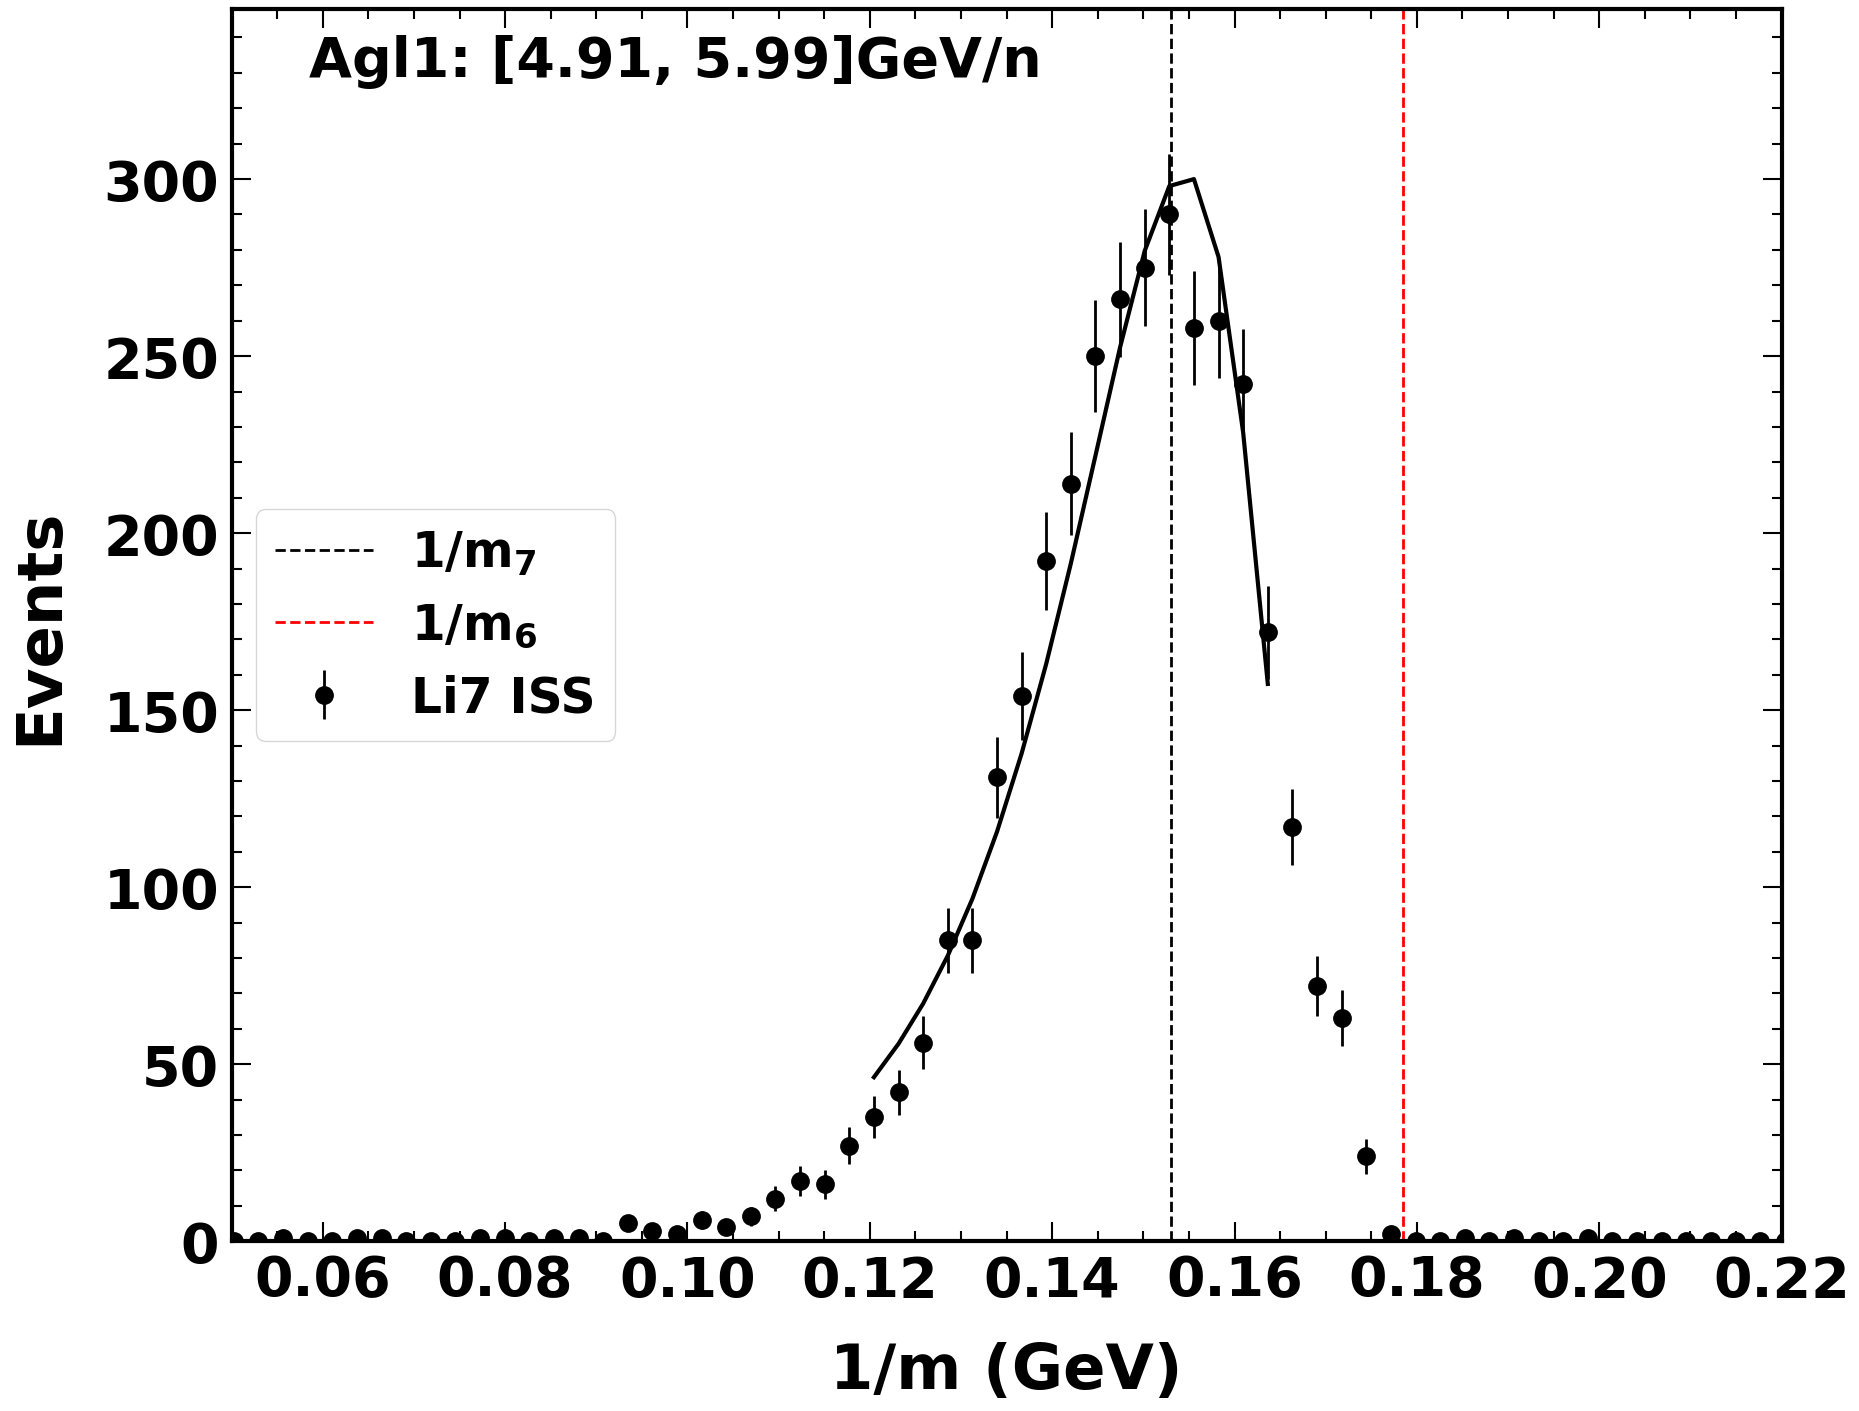

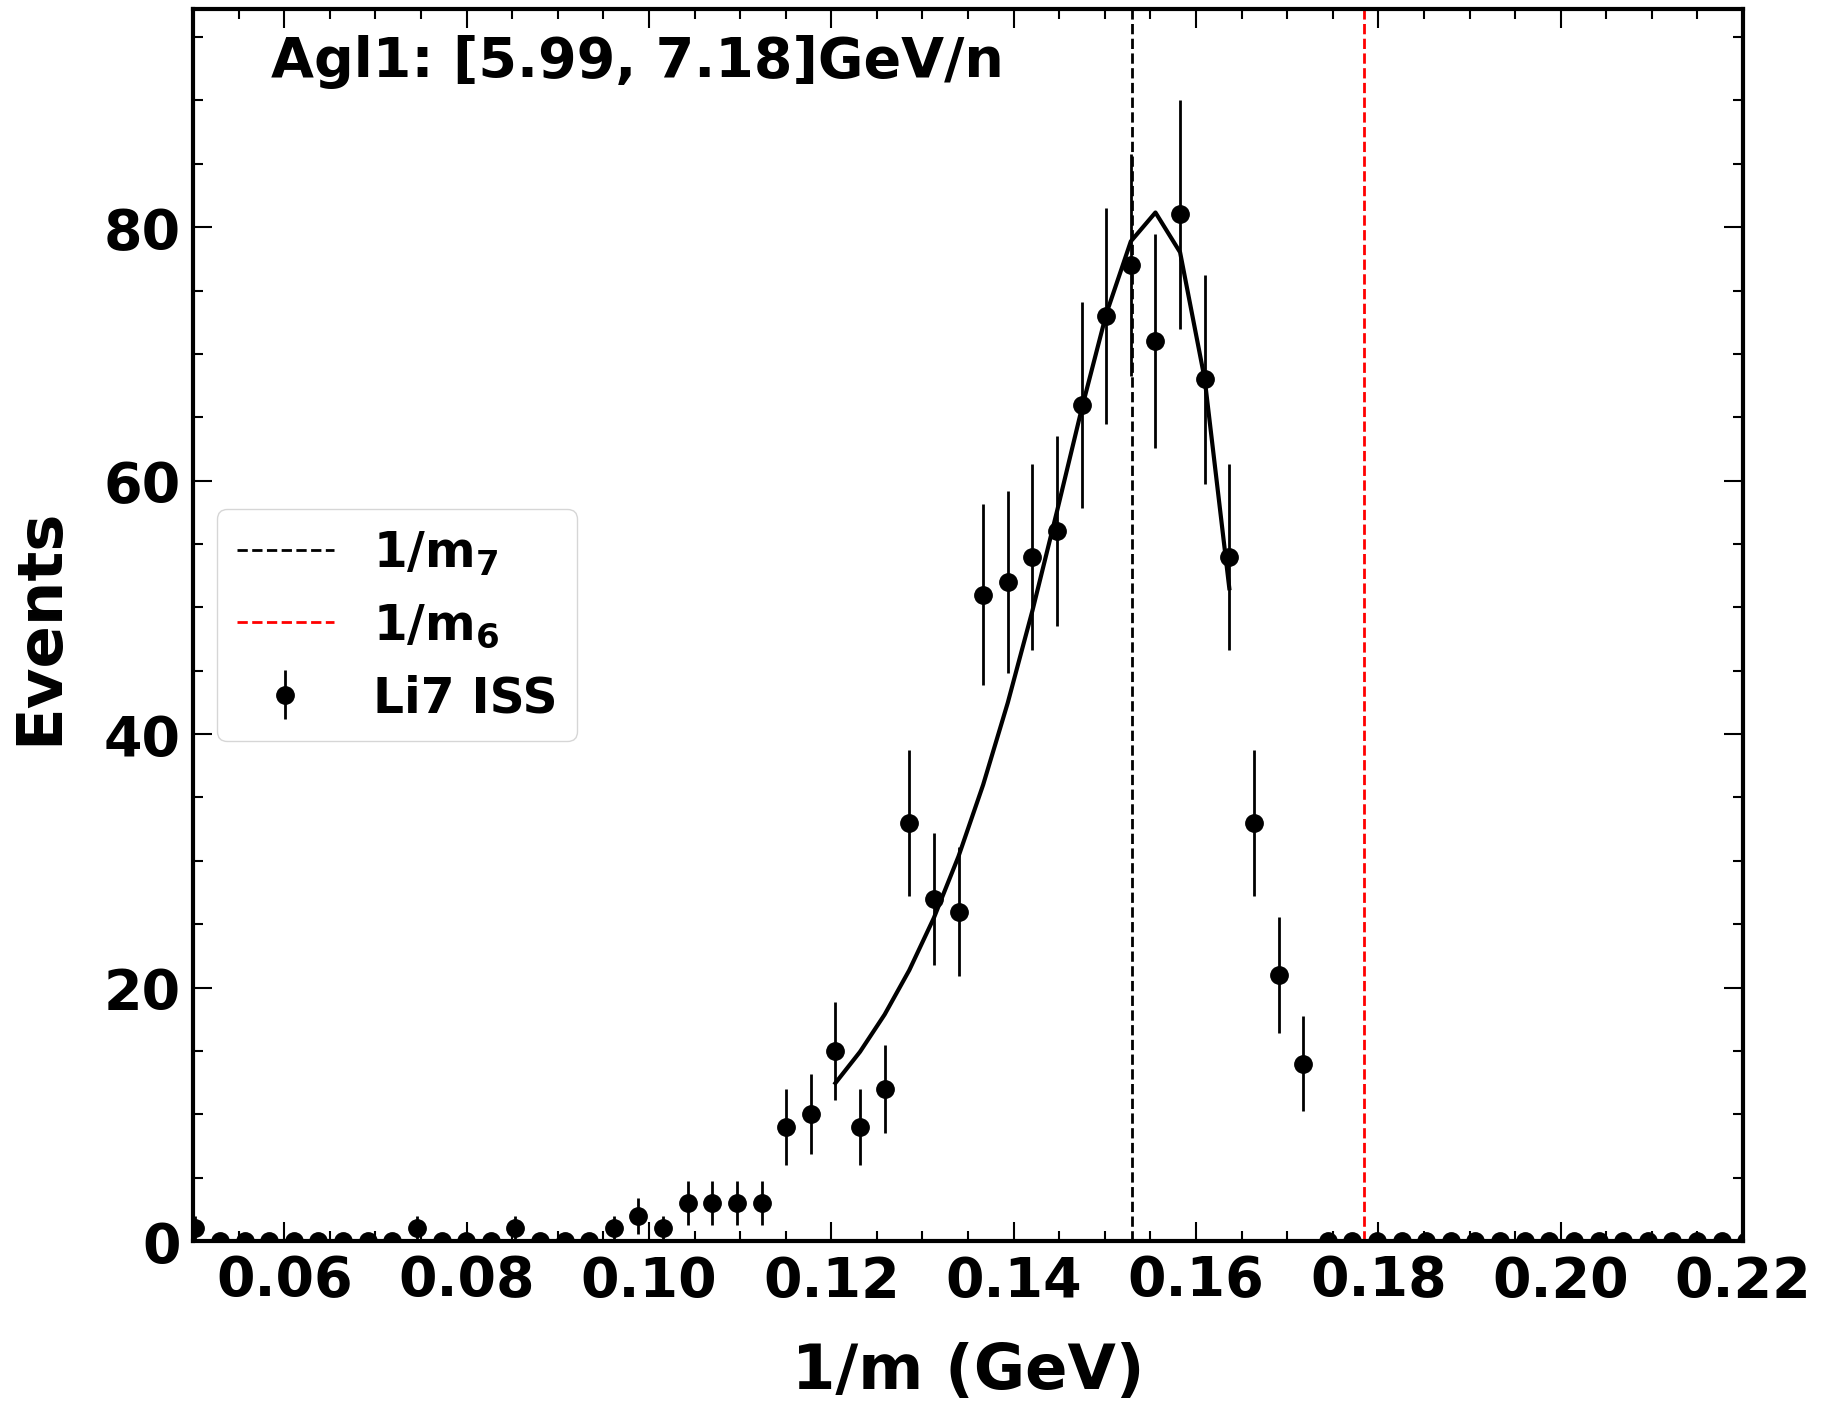

In [42]:
minbin = {'Tof': 1, 'NaF':2, 'Agl1':8}
maxbin =  {'Tof':2,  'NaF':3, 'Agl1':12}
sigmafactor = {'Tof':1.5,  'NaF':1.2, 'Agl1':1.8, 'Agl2':1.8}
guess0 = dict(norm=1, m= 0.152, w=-0.01)
xrange = {'Tof': [0.12, 0.18], 'NaF': [0.12, 0.18], 'Agl1': [0.12, 0.165], 'Agl2': [0.12, 0.15]}

def norm_landau(x, norm, m, w):                                                                                         
    xs = (x - m) / w                                                                                                     
    return norm * 1 / np.sqrt(2 * np.pi) * np.exp(-(xs + np.exp(-xs)) / 2)

for dec in ['Agl1']:
    for ibin in range(minbin[dec], maxbin[dec]):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges

        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        #plot_histogram_1d(ax1, hist1dmassbin, style="mc", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
        plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)

        set_plot_style(ax1)
        SetAx1Axis(ax1, '1/m (GeV)', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
      
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='red', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
        
        ax1.legend(fontsize=35, loc='center left')
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
         

        xbinrange = hist1dmassbin_iss.binnings[0].get_indices(xrange[dec])
        xedges = hist1dmassbin_iss.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue = hist1dmassbin_iss.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue = hist1dmassbin_iss.values[xbinrange[0]:xbinrange[1]]
        yvalueserr = np.sqrt(yvalue)
        yvalueserr[yvalueserr==0] = 0.0001
        par_iss, parerr_iss = minuitfit_Chi(xvalue, yvalue, yvalueserr,norm_landau, guess0)
        fit_y_iss = norm_landau(xvalue, *par_iss) 
        ax1.plot(xvalue, fit_y_iss, '-', linewidth=3, color=col['iss'])
        
        yvalue_mc = hist1dmassbin.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(yvalue_mc)
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
        par_mc, parerr_mc = minuitfit_Chi(xvalue, yvalue_mc, yvalueserr_mc , norm_landau, guess0)
        fit_y_mc = norm_landau(xvalue, *par_mc) 
        #ax1.plot(xvalue, fit_y_mc, '-', linewidth=3, color=['mc'])
        print(par_iss)
        savefig_tofile(fig, plotfile, f"histmc_{dec}{iso}_{ibin}_fit", show=True) 
       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



xvalues			yvalues			yerrs
0.9603843204283538			0.9605895411119929			0.00014414457438877674
0.9667911237245531			0.9665453955822284			0.0001383653802755851
0.9721344304932673			0.9717848338174557			0.00015421845725885127
0.9766066495082522			0.9759308481381577			0.0001440203023862562
0.9803305957678972			0.9797137304943958			0.0001802097401624588
0.983438400165672			0.9824676005664715			0.00017483229482683123
0.986040469111189			0.9849502172704948			0.0001962898314820005
0.9882109106453216			0.9869991382328364			0.00018871780590560888
0.9900482261489532			0.9885482771937439			0.00019059536971973307
0.9915645159276133			0.9902252978204448			0.00022398651145048927
0.9928066253863415			0.9909900628193415			0.00020533252555610023
0.9938777178103013			0.992119564784509			0.00023575132303276726
0.9947925493068643			0.9928743814797986			0.00024839954467114126
0.9955686701571376			0.9931674855750477			0.0002532571936163486
0.9962242233294369			0.9943639225637746			0.00027270501246265215


xval

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15 0.9721344304932673


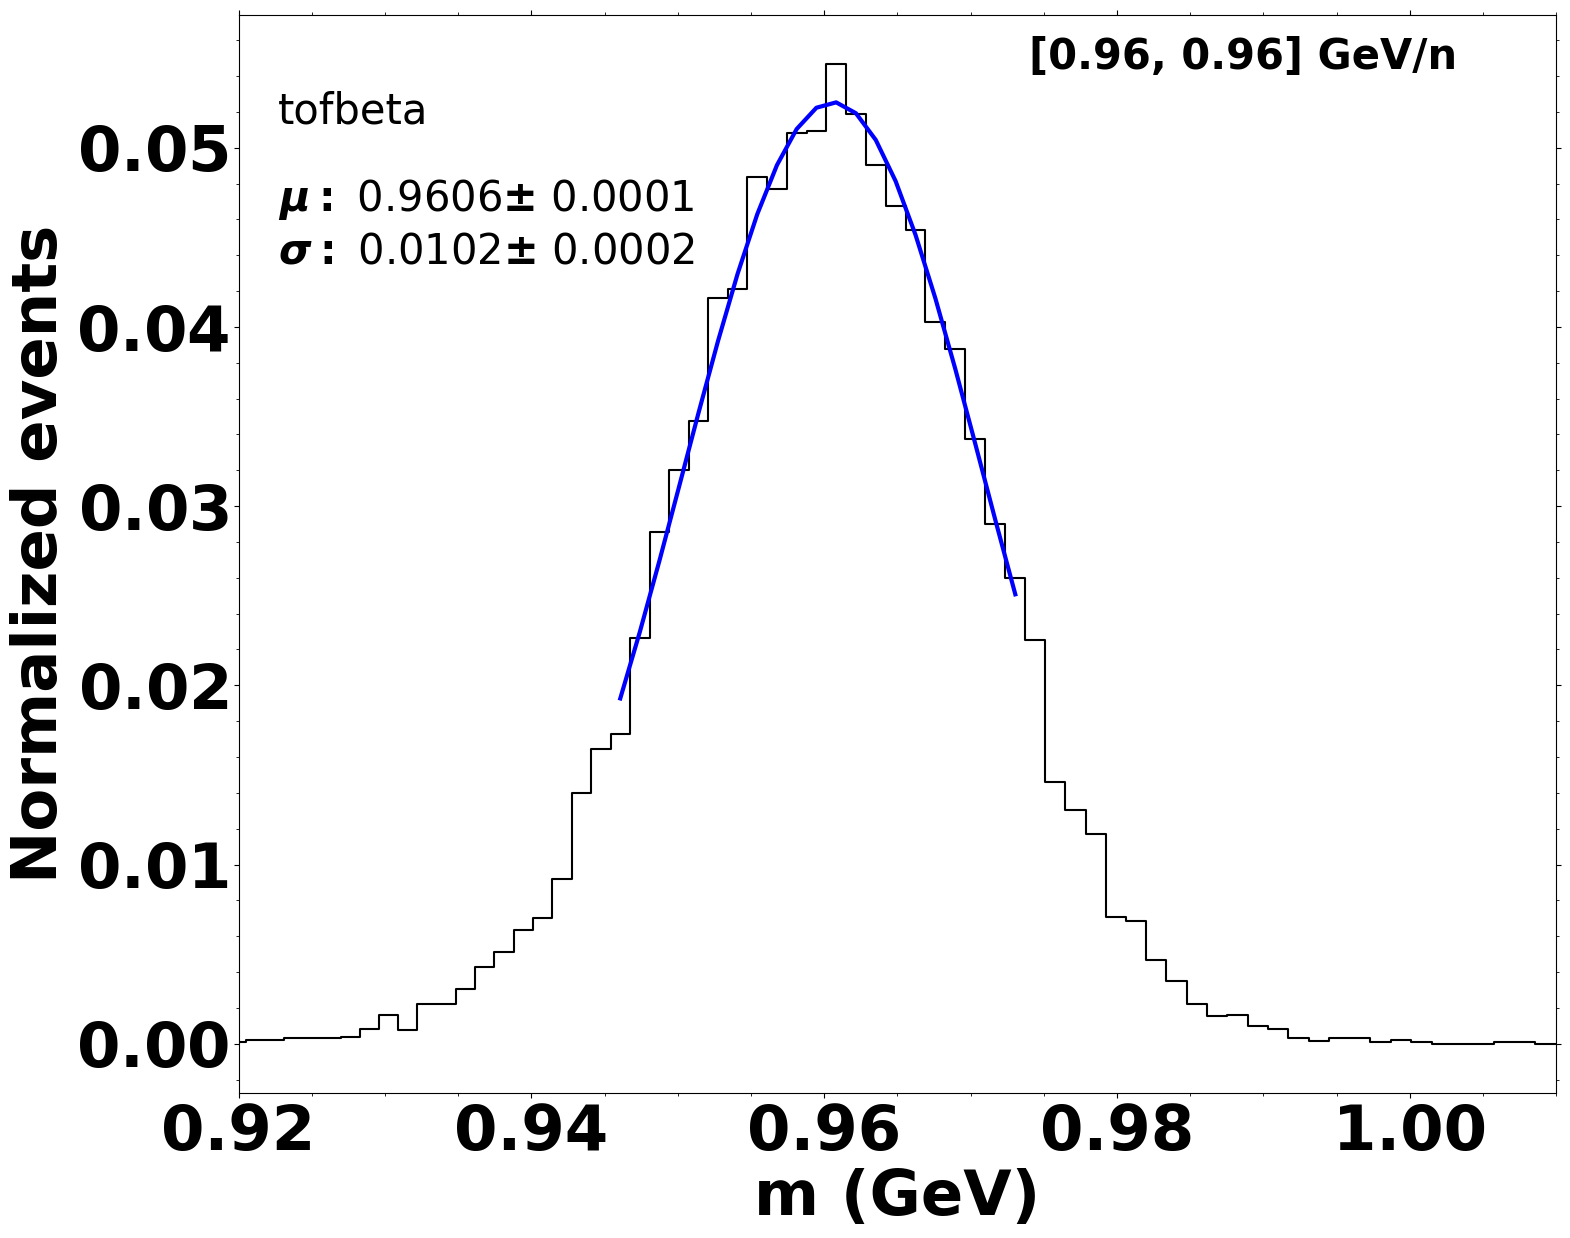

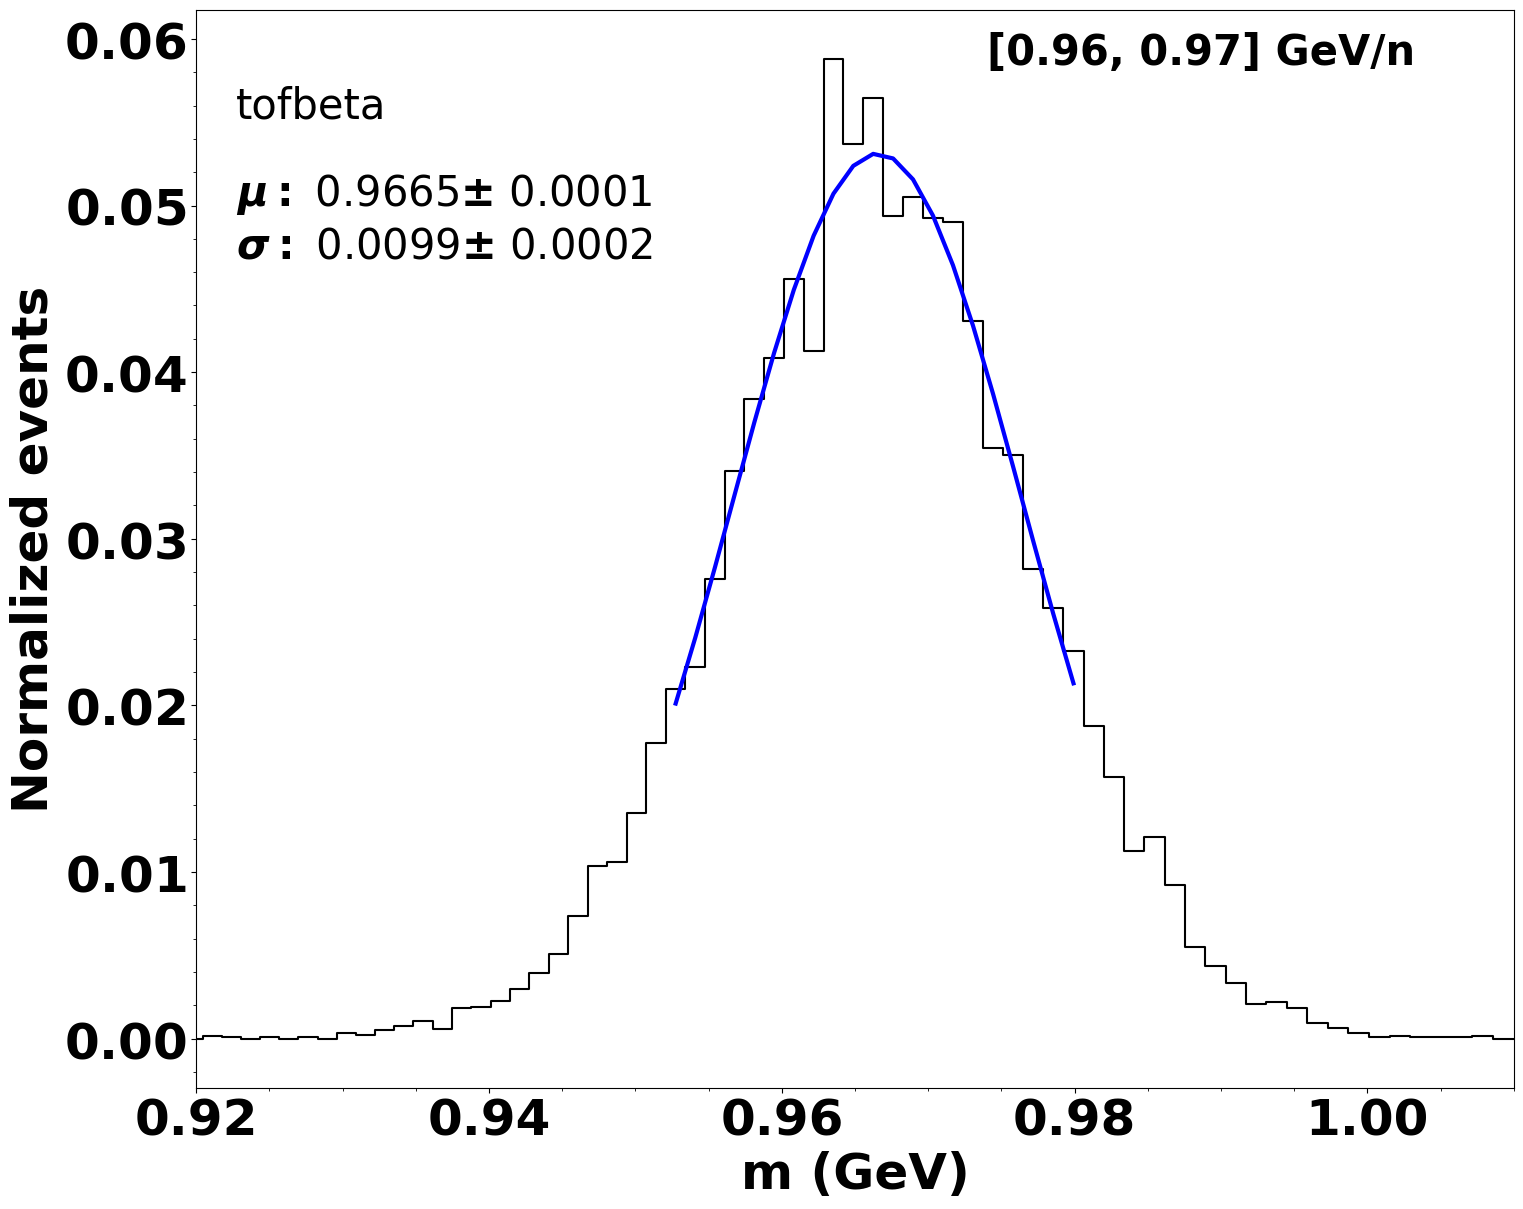

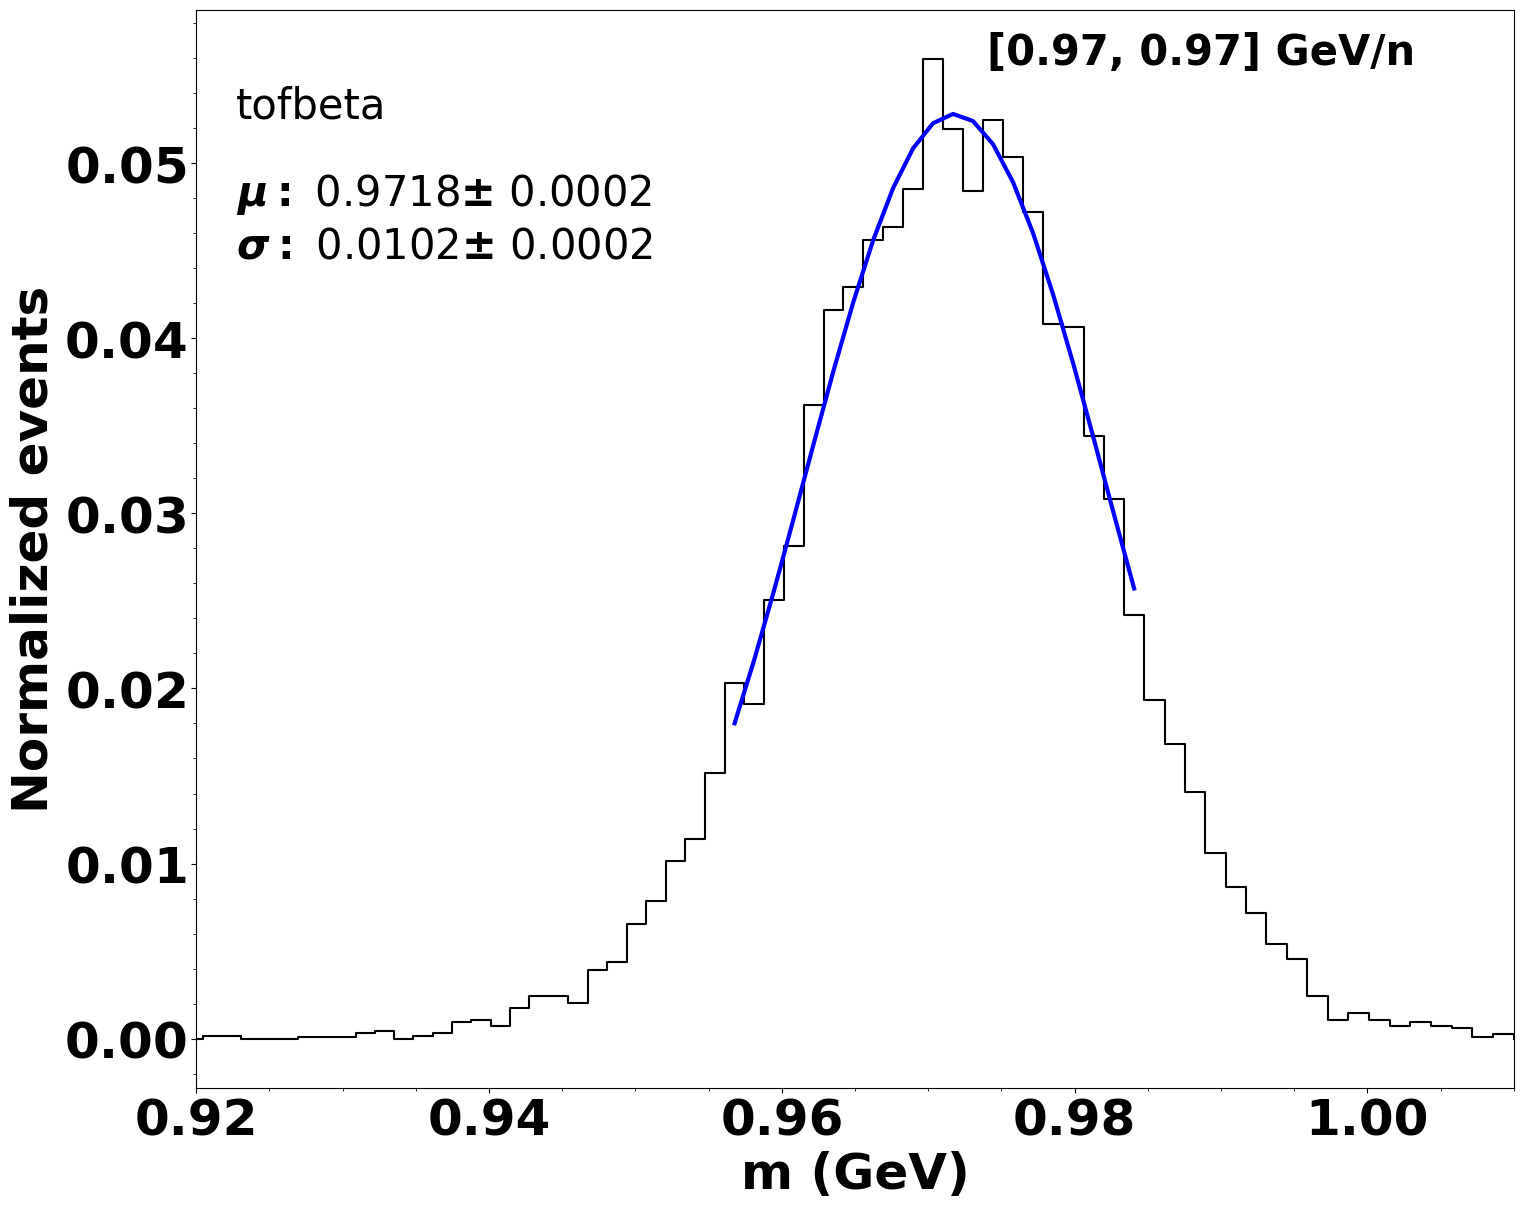

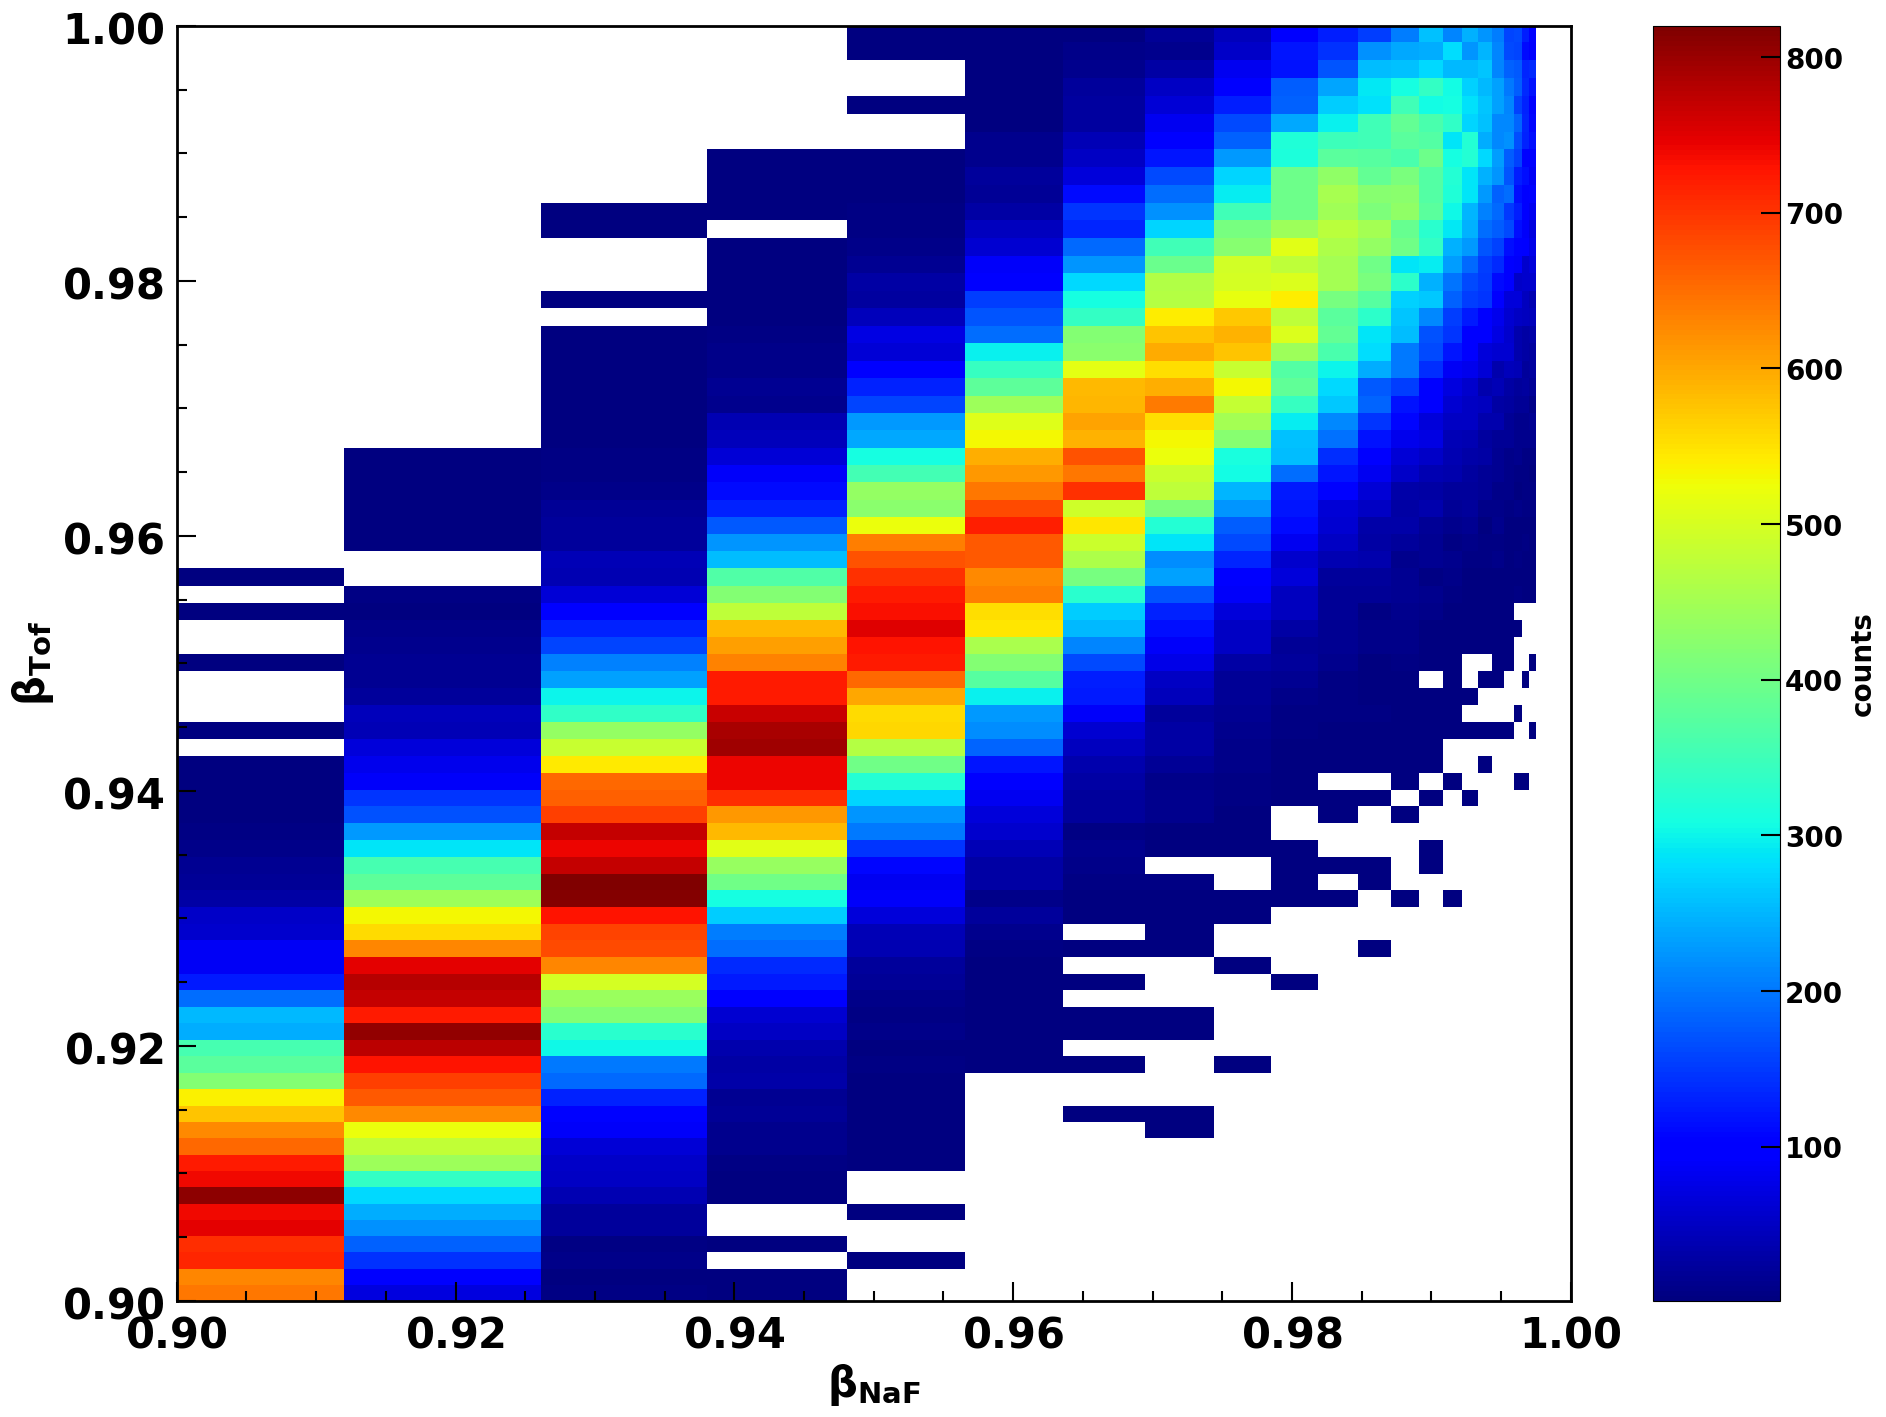

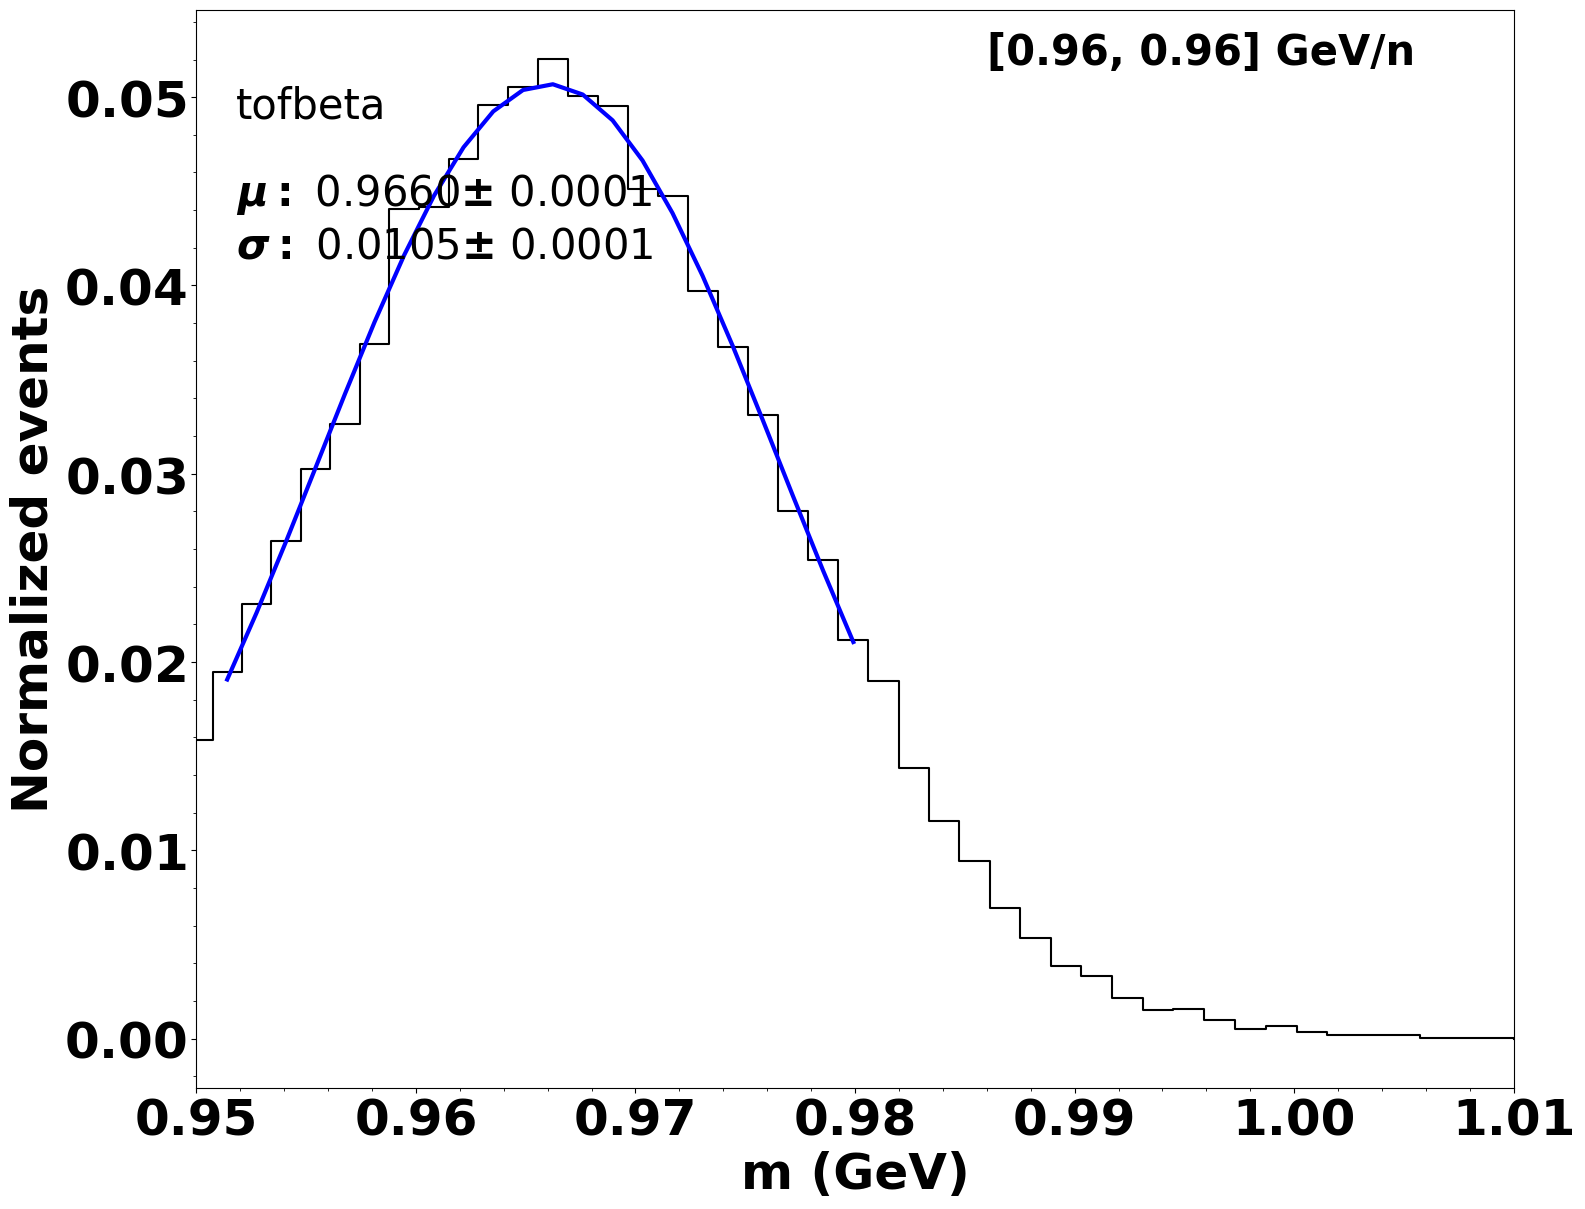

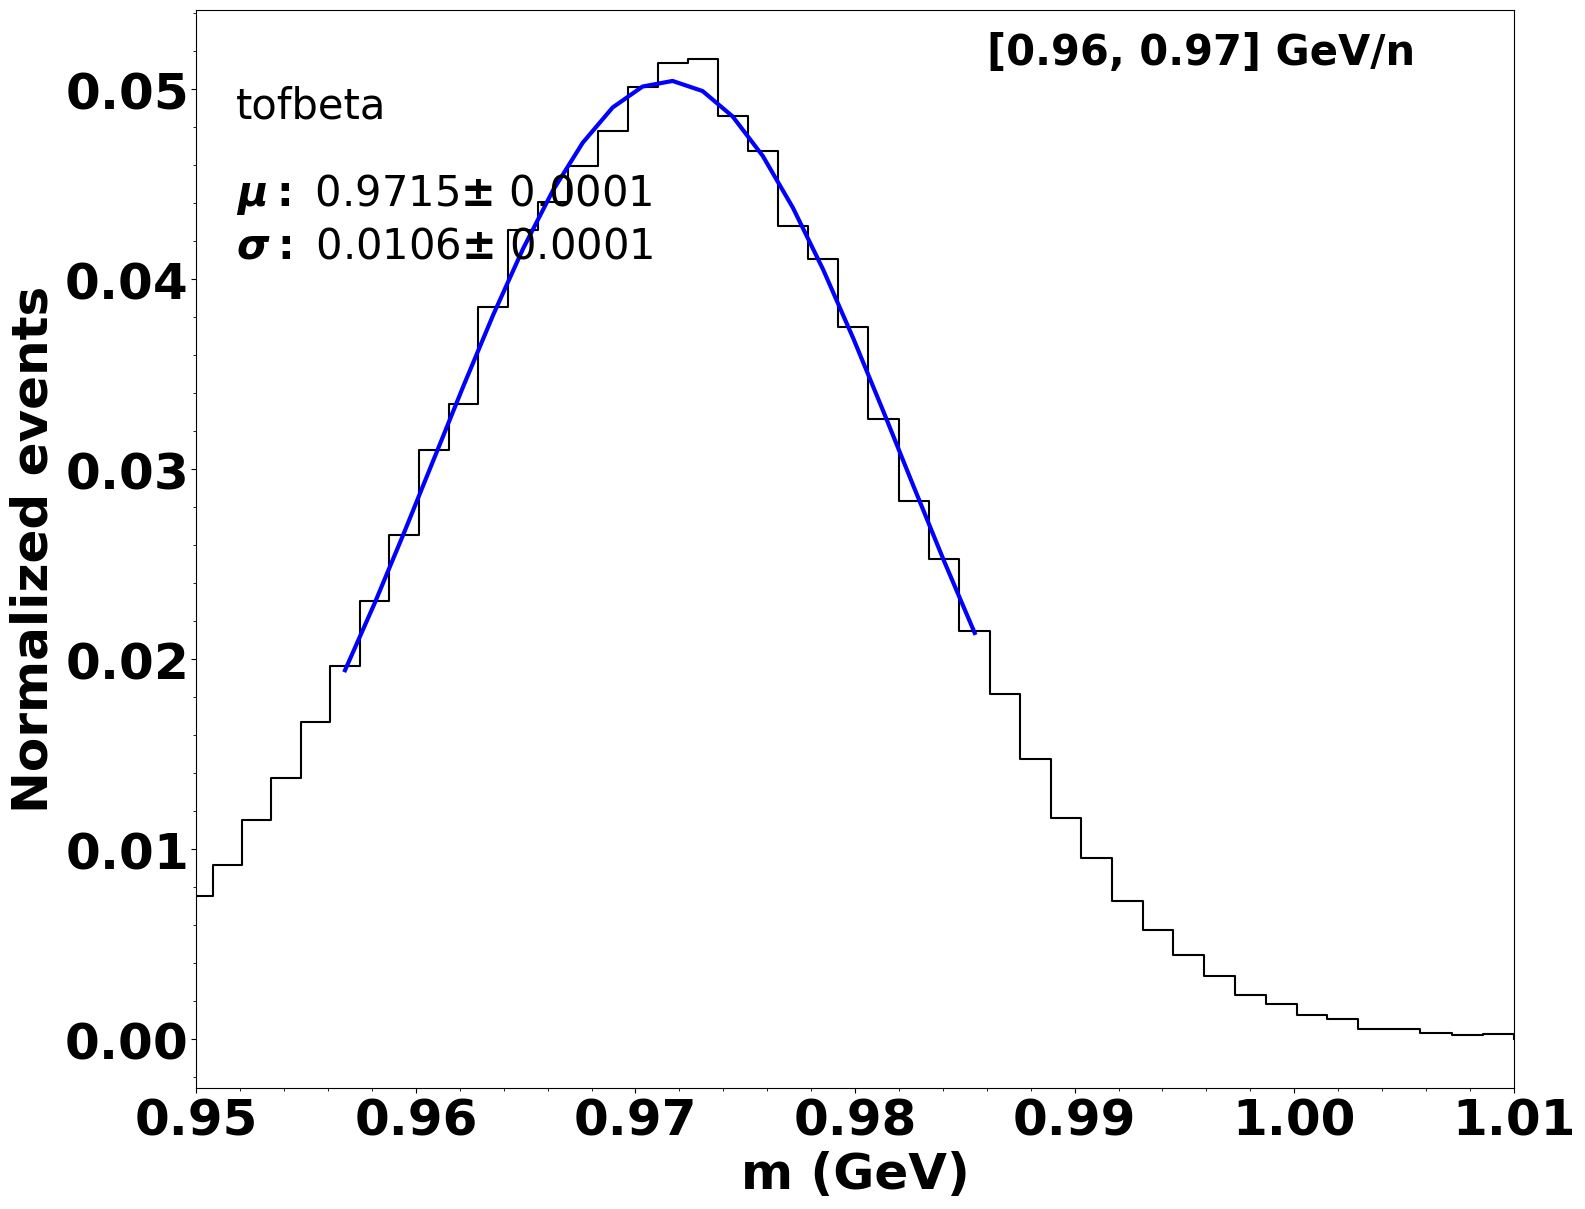

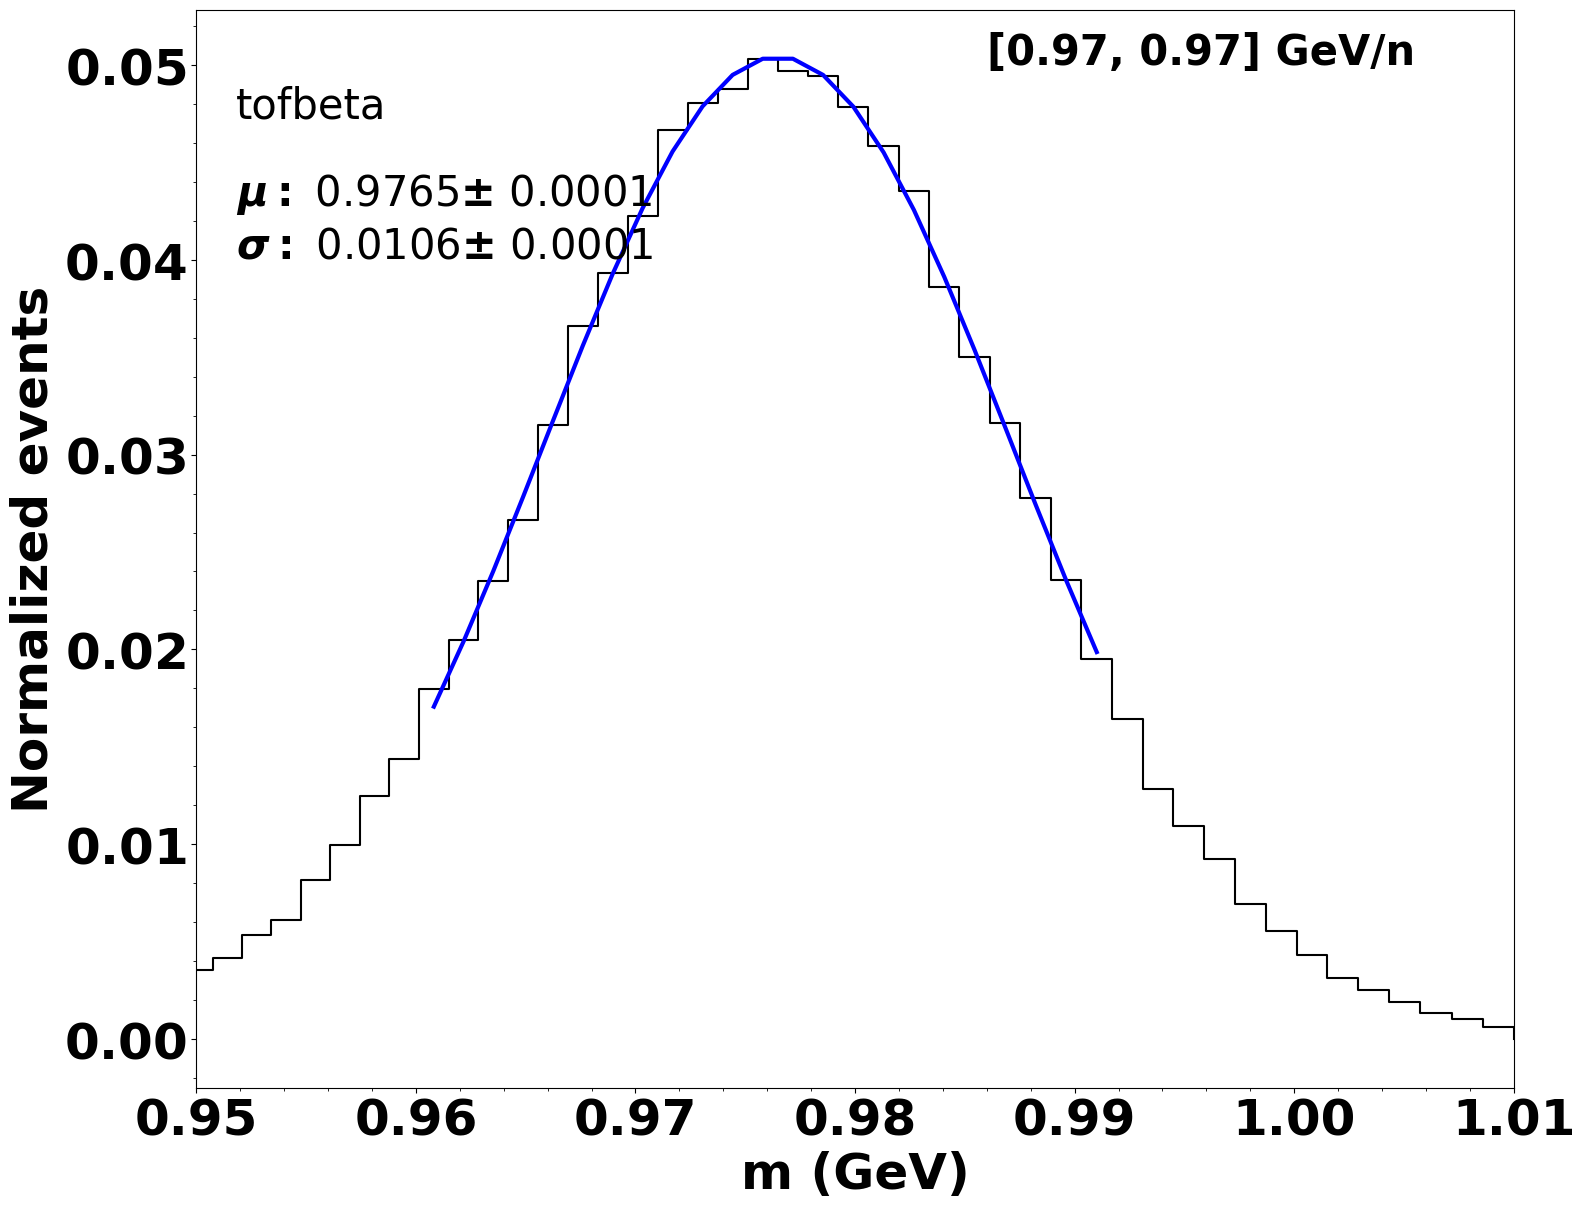

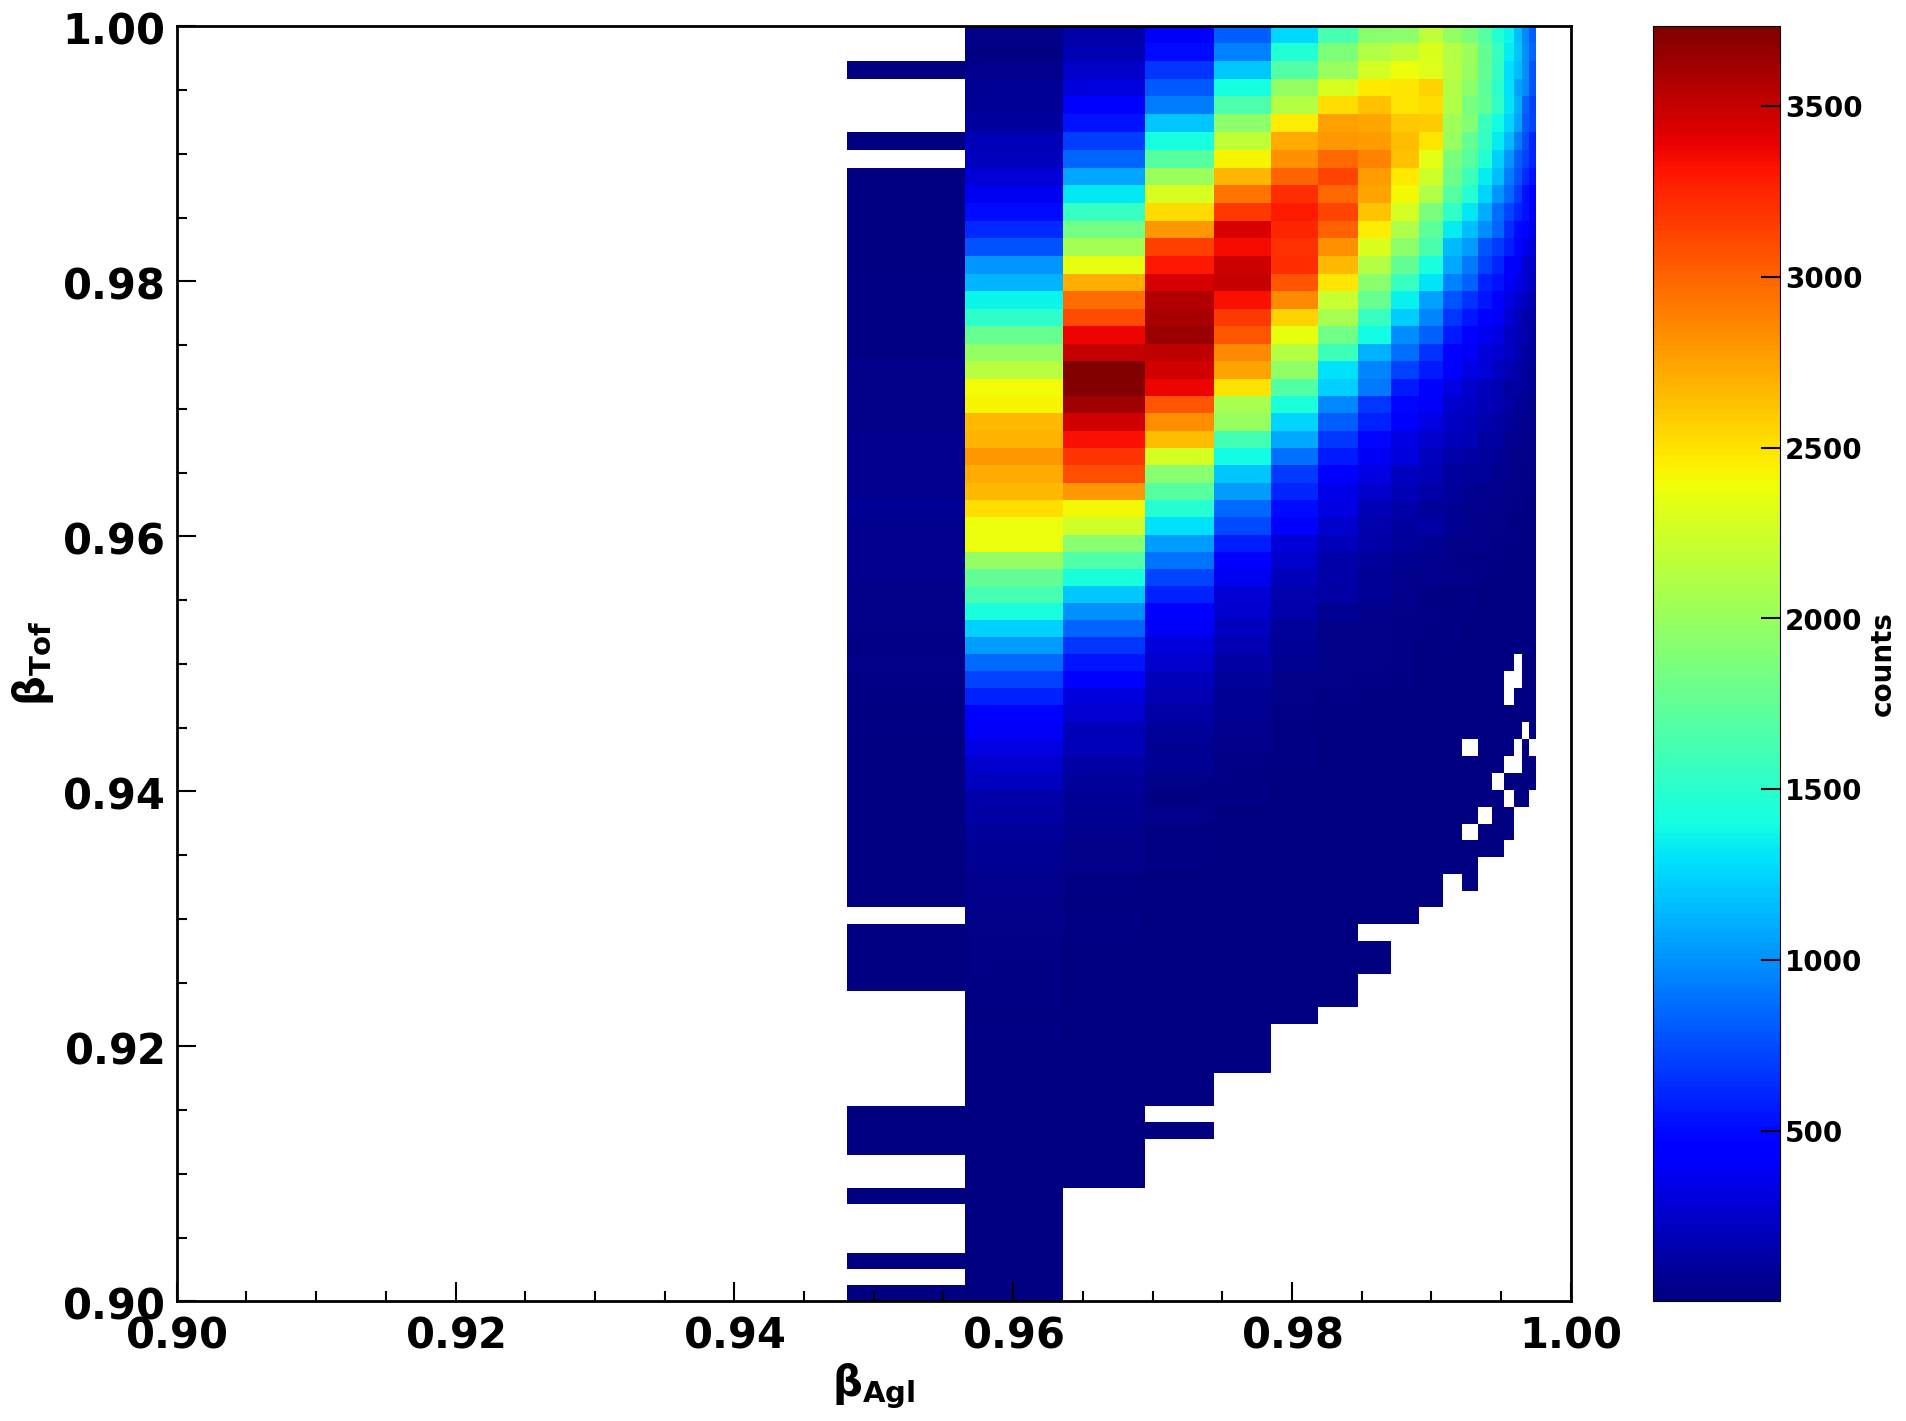

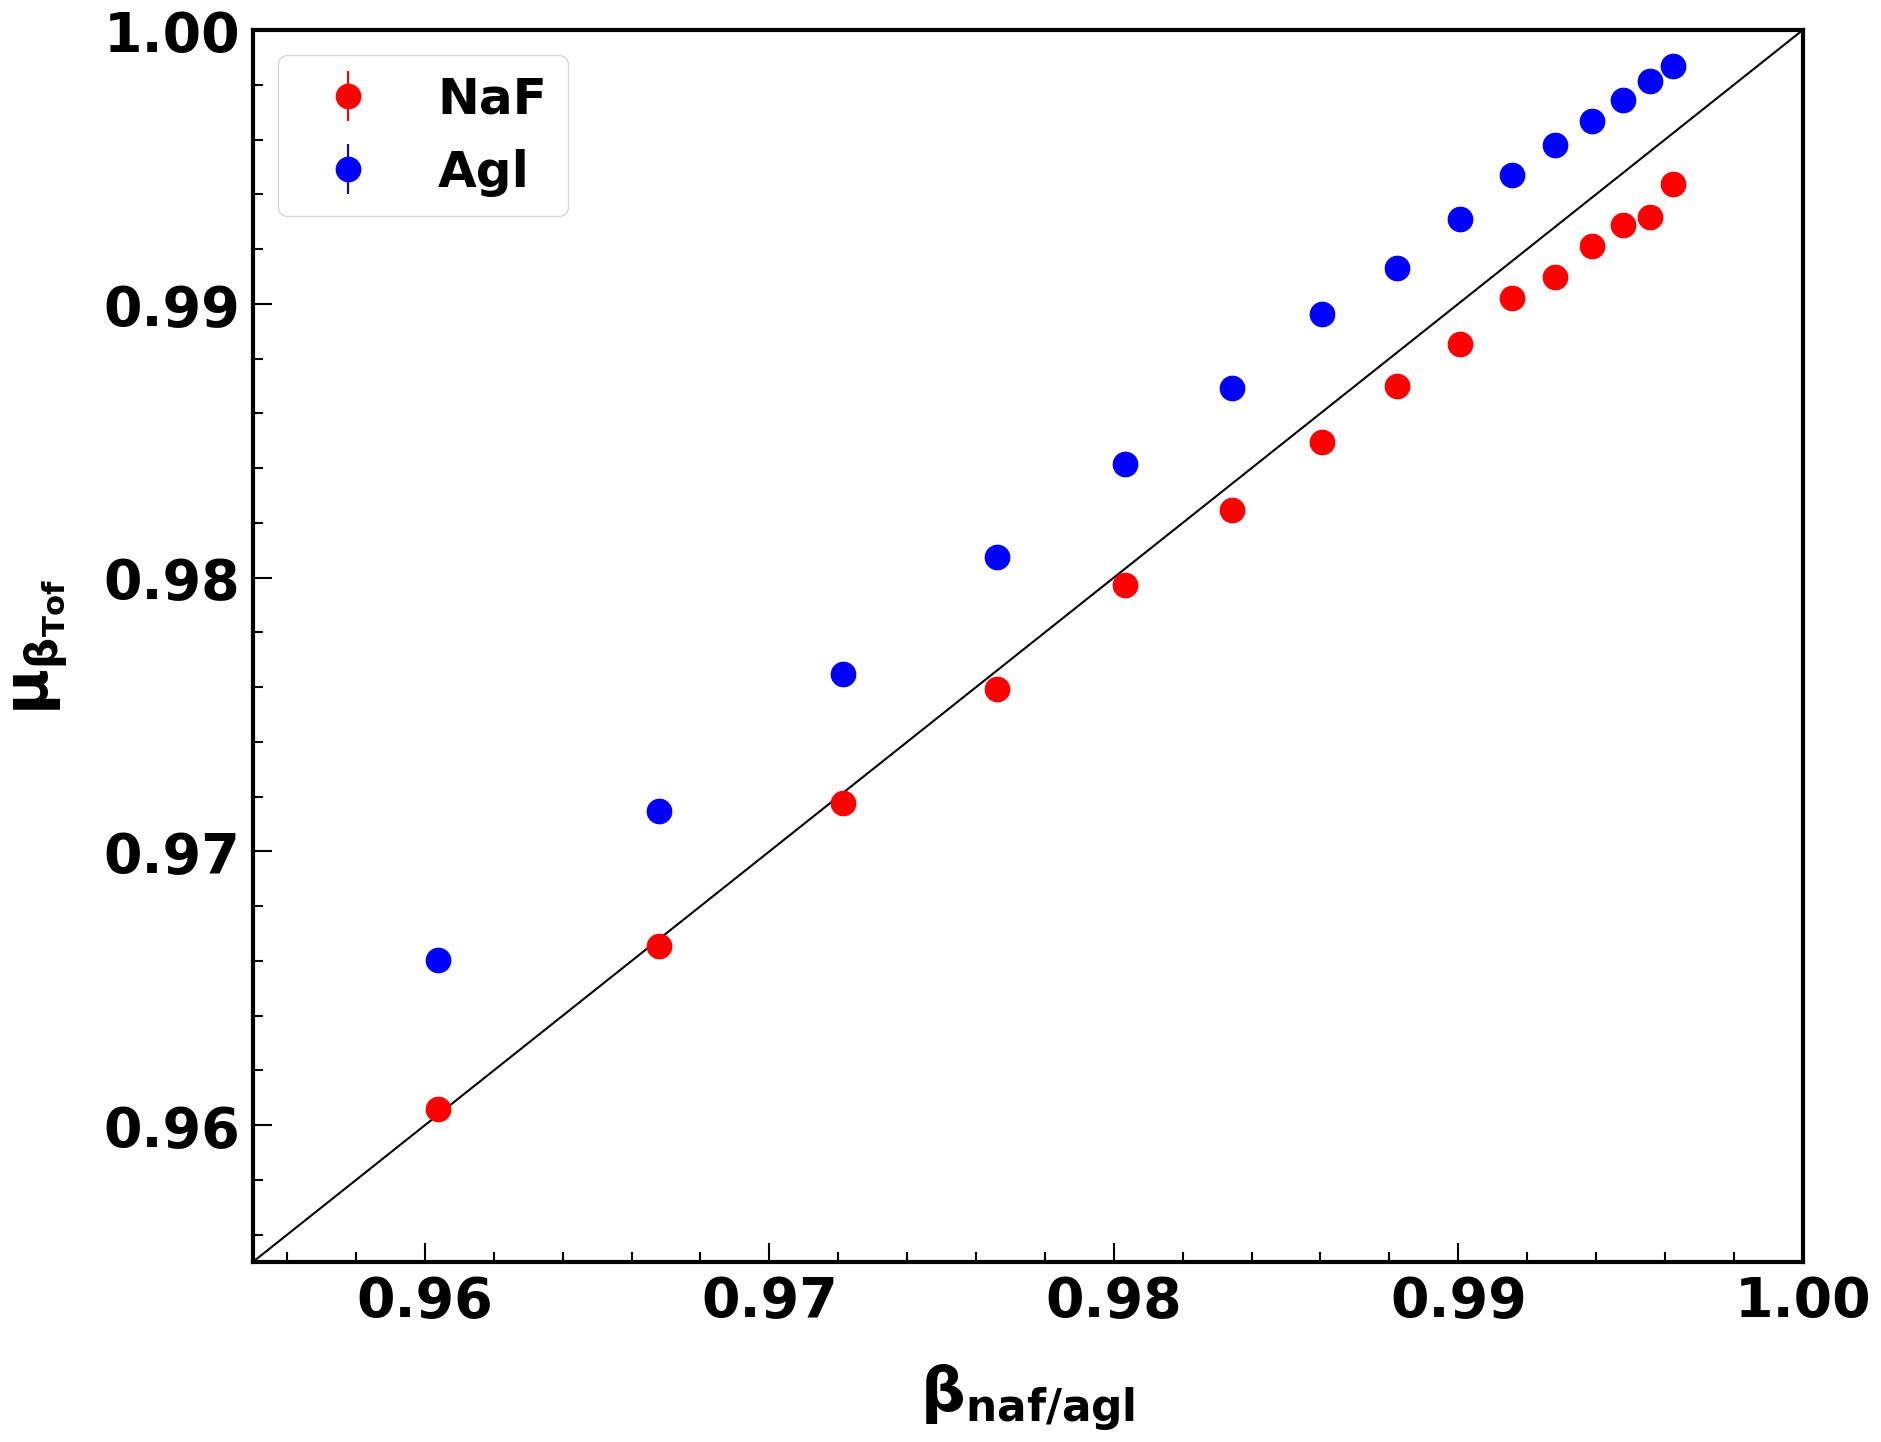

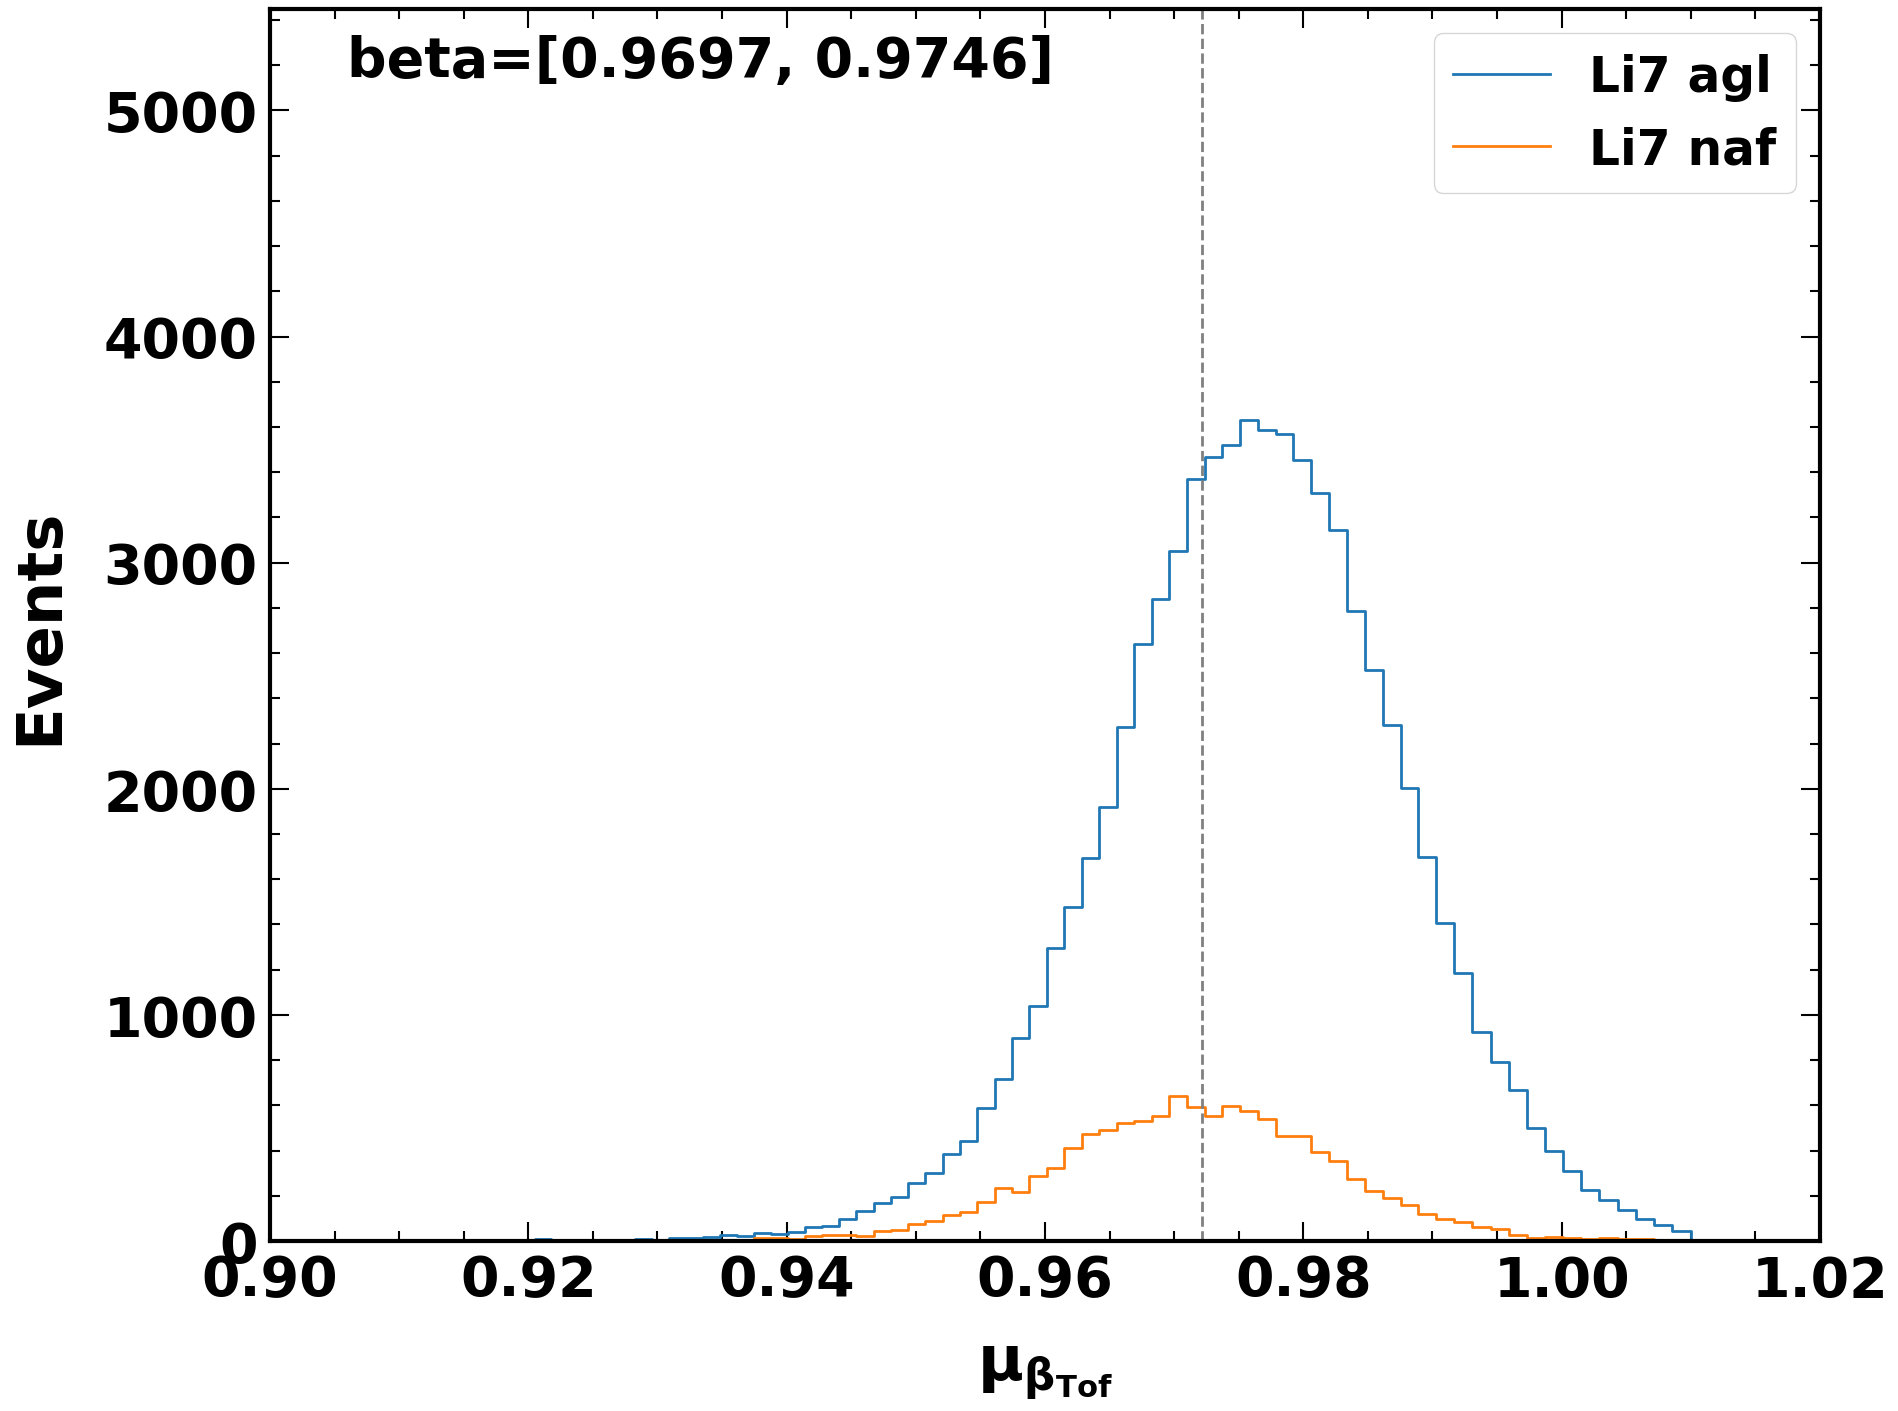

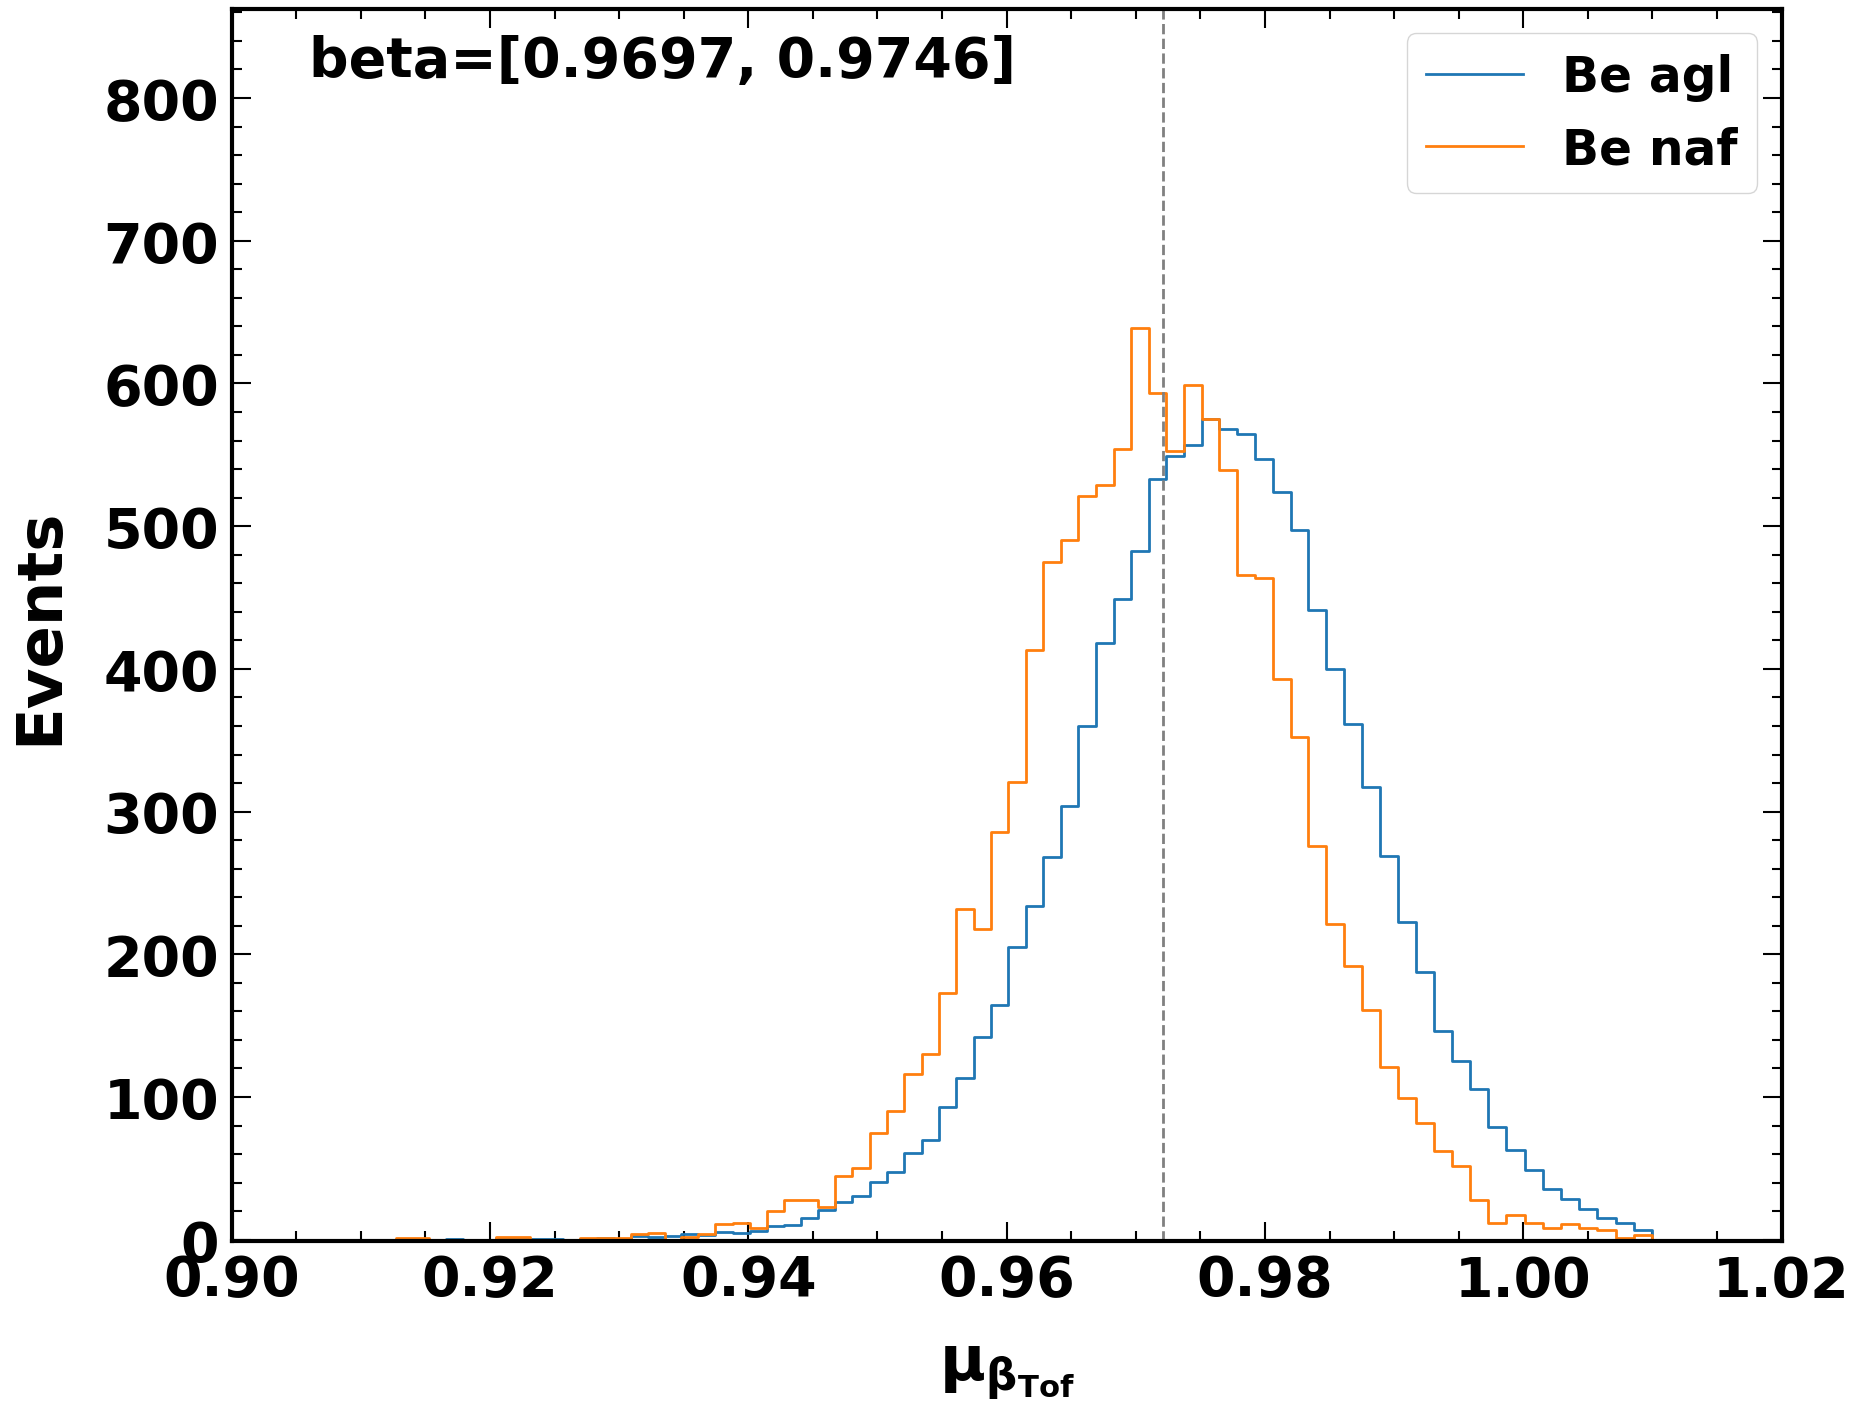

In [29]:
def get_hist_meanstd(hist2d):
    
    yva = [0.92, 1.01]
    ybin_range = hist2d.binnings[1].get_indices(yva)
    
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[ybin_range[0]:ybin_range[1]]
    print(var_ycenter)
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, ybin_range[0]:ybin_range[1]]
        if sum(ibin_fitdata) != 0:                                                                                                                                                                                
            avg[binx], std[binx] = weighted_avg_and_std(var_ycenter, ibin_fitdata)                                                                                                                                 
    return avg, std   

Nuclei = 'Li'
iso = 'Li7'
figName = 'v1'
filename = f'/home/manbing/Documents/Data/data_BeP8/BeISS_tofbeta_vsRich.npz'
hist2dmass = {}

mtype = 'rig'
minbin = {'NaF':13, 'Agl':13}
maxbin =  {'NaF':28, 'Agl':28}
guess0 = {'NaF': dict(norm=1, mu=0.96, sigma=0.001), 'Agl': dict(norm=1, mu=0.97, sigma=0.001)}
xrange = {'NaF': [0.92, 1.01], 'Agl':[0.95, 1.01]}

graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events'
detectors = ['NaF', 'Agl']
mean_beta = {}
std_beta = {}
graph_mean_beta = {}
graph_sigma_beta = {}


with np.load(filename) as histfile:       
    for dec in detectors:
        hist2dmass[dec] = Histogram.from_file(histfile, f"hist_isstofbeta_vs{dec}")  
        #graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[mtype], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile)
        #mean_beta[dec], std_beta = get_hist_meanstd(hist2dmass[dec])
        #graph_mean_beta[dec] = MGraph(hist2dmass[dec].binnings[0].bin_centers[1:-1], mean_beta[dec], std_beta)
        graph_mean_beta[dec], graph_sigma_beta[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[dec], xrange[dec], FigName=f'tofbeta')
        fig = plt.figure(figsize=(20, 15)) 
        plot = fig.subplots(1, 1)    
        set_plot_style(plot)
        plot2dhist(fig, plot, xbinning=hist2dmass[dec].binnings[0].edges[1:-1], 
                   ybinning=hist2dmass[dec].binnings[1].edges[1:-1],                                                                                                                        
                   counts=hist2dmass[dec].values[1:-1, 1:-1],                                                                                                                               
                   xlabel=rf'$\mathrm{{\beta_{{ {dec} }}}}$', ylabel=r'$\mathrm{\beta_{Tof}}$', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
                   setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)    
        plot.set_ylim([0.9, 1.0])
        plot.set_xlim([0.9, 1.0])
        
        savefig_tofile(fig, plotfile, f"hist2d_tofbeta_vs{dec}", show=True)    

fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
plot_graph(fig, ax1, graph_mean_beta['NaF'], color='red', style="EP", xlog=False, ylog=False, scale=None, markersize=35, label=f"NaF")   
print(graph_mean_beta['NaF'])
plot_graph(fig, ax1, graph_mean_beta['Agl'], color='blue', style="EP", xlog=False, ylog=False, scale=None, markersize=35, label=f"Agl")    
print(graph_mean_beta['Agl'])
ax1.set_ylim([0.955, 1.0])
ax1.set_xlim([0.955, 1.0])
ax1.legend()
ax1.plot(np.linspace(0.9, 1, 100), np.linspace(0.9, 1, 100), color='black')
set_plot_style(ax1)
SetAx1Axis(ax1, r'$\mathrm{\beta_{naf/agl}}$', r'$\mathrm{\mu_{\beta_{Tof}}}$', 45, xlimrange=[0.955, 1.0], ylimrange=[0.955, 1.0] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
savefig_tofile(fig, plotfile, f"beta_mean_nafagl", show=True)  
for ibin in [15]:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1dmassbin = hist2dmass['Agl'].project(ibin)
    print(ibin, hist2dmass['Agl'].binnings[0].bin_centers[ibin])
    bincenter = hist2dmass['Agl'].binnings[0].bin_centers[ibin]
    binedges = hist2dmass['Agl'].binnings[0].edges
    
    hist1dmassbin_naf = hist2dmass['NaF'].project(ibin)
    #hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_naf.values)/sum(hist1dmassbin.values)
    plot_histogram_1d(ax1, hist1dmassbin, style="mc", color='tab:blue', label=f'{iso} agl', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1dmassbin_naf, style="mc", color='tab:orange', label=f'{iso} naf', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)

    set_plot_style(ax1)
    SetAx1Axis(ax1, r'$\mathrm{\mu_{\beta_{Tof}}}$', 'Events', 45, xlimrange=[0.9, 1.02], ylimrange=[-1,1.5 * max(hist1dmassbin.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)

    ax1.text(0.05, 0.98, 'beta=[{:.4f}, {:.4f}]'.format(binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

    ax1.legend(fontsize=35)
    ax1.axvline(x=bincenter, linewidth=2,color='grey', linestyle='--', label=r'bincenter') 
    savefig_tofile(fig, plotfile, f"beta_{ibin}", show=True)  

    
for ibin in [15]:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1dmassbin = hist2dmass['Agl'].project(ibin)
    print(ibin, hist2dmass['Agl'].binnings[0].bin_centers[ibin])
    bincenter = hist2dmass['Agl'].binnings[0].bin_centers[ibin]
    binedges = hist2dmass['Agl'].binnings[0].edges
    
    hist1dmassbin_naf = hist2dmass['NaF'].project(ibin)
    hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_naf.values)/sum(hist1dmassbin.values)
    plot_histogram_1d(ax1, hist1dmassbin, style="mc", color='tab:blue', label=f'Be agl', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1dmassbin_naf, style="mc", color='tab:orange', label=f'Be naf', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)

    set_plot_style(ax1)
    SetAx1Axis(ax1, r'$\mathrm{\mu_{\beta_{Tof}}}$', 'Events', 45, xlimrange=[0.9, 1.02], ylimrange=[-1,1.5 * max(hist1dmassbin.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)

    ax1.text(0.05, 0.98, 'beta=[{:.4f}, {:.4f}]'.format(binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

    ax1.legend(fontsize=35)
    ax1.axvline(x=bincenter, linewidth=2,color='grey', linestyle='--', label=r'bincenter') 
    savefig_tofile(fig, plotfile, f"beta_{ibin}_normlized", show=True)  

In [30]:
filename = f'/home/manbing/Documents/Data/data_{Nuclei}P8/{Nuclei}hist_masscutoff.npz'
hist2dmass_iss = {}
graph_mean_issLi7 = {}
graph_sigma_issLi7 = {}
mtype = 'rig'
minbin = {'Tof': 1, 'NaF':4, 'Agl':9}
maxbin =  {'Tof': 3, 'NaF':8, 'Agl':11}

guess0 = {'rig': dict(norm=0.5, mu=14, sigma=0.1), 'inv': dict(norm=1, mu=0.125, sigma=0.01)}
xrange = {'inv': [0.12, 0.145], 'nor':[5.5, 8.0], 'rig':[10, 19]}
with np.load(filename) as histfile:       
    for dec in detectors:
        hist2dmass_iss[dec] = Histogram.from_file(histfile, f"LiISS_{dec}_betavsR")  
        graph_mean_issLi7[dec], graph_sigma_issLi7[dec] = get_musigma_gausfit(hist2dmass_iss[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[mtype], FigName=f'Li7Data_inverse_{dec}_{figName}', plotfile=plotfile)
        
fig = plt.figure(figsize=(20, 15)) 
plot = fig.subplots(1, 1)    
set_plot_style(plot)
        
plot2dhist(fig, plot, xbinning=hist2dmass_iss[dec].binnings[0].edges[1:-1], 
           ybinning=hist2dmass_iss[dec].binnings[1].edges[1:-1],                                                                                                                        
           counts=hist2dmass_iss[dec].values[1:-1, 1:-1],                                                                                                                               
           xlabel=r'R (GV)', ylabel='beta', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
           setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)   
plot.set_xlim(0, 10)
plot.set_ylim(0.7, 0.95)
savefig_tofile(fig, plotfile, f"hist2d_Li7Cutoff_ISS_rig_{dec}_{figName}", show=True)  

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/Data/data_LiP8/Lihist_masscutoff.npz'

9 0.9196854557124582


KeyError: 'Agl'

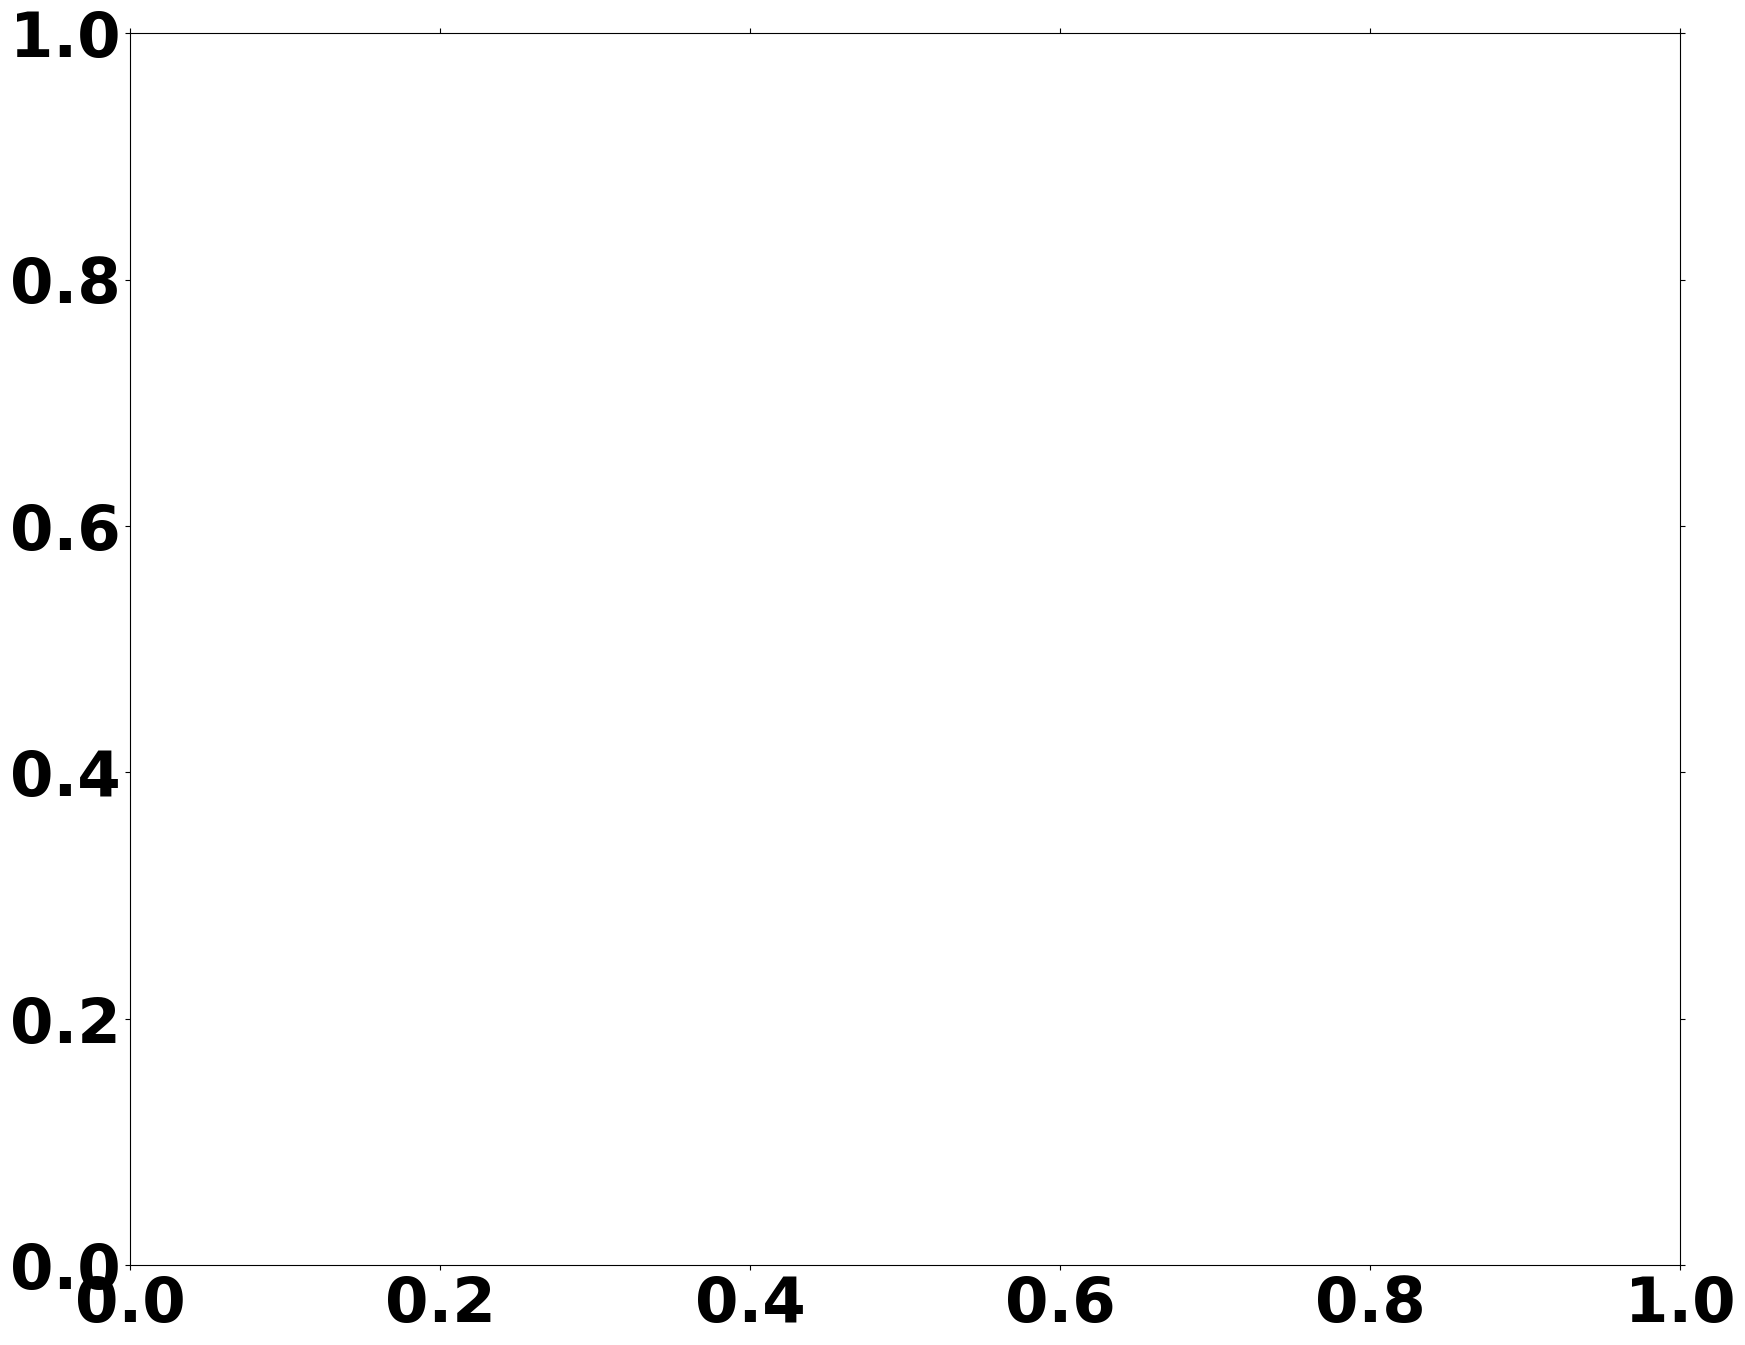

In [31]:
for ibin in range(minbin[dec], maxbin[dec]+2):
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1dmassbin = hist2dmass[dec].project(ibin)
    print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
    bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
    binedges = hist2dmass[dec].binnings[0].edges
    
    hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
    print(sum(hist1dmassbin_iss.values))
    print(sum(hist1dmassbin.values))
    hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
    plot_histogram_1d(ax1, hist1dmassbin, style="mc", color='tab:blue', label=f'{iso} MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color='tab:orange', label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
    
    set_plot_style(ax1)
    SetAx1Axis(ax1, 'm (GeV)', 'Events', 45, xlimrange=[10, 30], ylimrange=[-1,1.3 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
    ax1.legend(fontsize=35)
    ax1.text(0.05, 0.98, '[{:.2f}, {:.2f}]GeV/n'.format(binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    #ax1.axvline(x=ISOTOPES_MASS['Be7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{m^{nominal}_{10}}$') 
    savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}", show=True)  

In [161]:
def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

In [73]:
scale_factor_name = {'Tof': {iso: f'muscale_{iso}' for iso in isotopes[1:]},                                                                                                                                                                  
                         'NaF': {iso: [f'muscale_{iso}_{a}' for a in ['a', 'b', 'c']] for iso in isotopes[1:]},                                                                                                                                   
                         'Agl': {iso: [f'muscale_{iso}_{a}' for a in ['a', 'b', 'c']] for iso in isotopes[1:]}}     
print(scale_factor_name)

{'Tof': {'Be9': 'muscale_Be9', 'Be10': 'muscale_Be10'}, 'NaF': {'Be9': ['muscale_Be9_a', 'muscale_Be9_b', 'muscale_Be9_c'], 'Be10': ['muscale_Be10_a', 'muscale_Be10_b', 'muscale_Be10_c']}, 'Agl': {'Be9': ['muscale_Be9_a', 'muscale_Be9_b', 'muscale_Be9_c'], 'Be10': ['muscale_Be10_a', 'muscale_Be10_b', 'muscale_Be10_c']}}


In [35]:
from tools.constants import ISOTOPES_MASS
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_sigma_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_sigma_iter2.npz'
df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
for dec in detectors:
    graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")


from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7], 'NaF':[0.7, 0.1], "Agl":[0.7, 0.1, 0.1]}
for dec in detectors: 
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}}$")
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, tune}$")
        else:
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_9to7[dec].xvalues), graph_mass_sigma_9to7[dec].yvalues, p0 = p0_dec[dec])  
        print(dec, "be9: ", popt, pcov)
        ax1.plot(graph_mass_sigma_9to7[dec].xvalues, poly(np.log(graph_mass_sigma_9to7[dec].xvalues), *popt), "-", color='black')
        #plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        popt10, pcov10 = curve_fit(poly, np.log(graph_mass_sigma_10to7[dec].xvalues), graph_mass_sigma_10to7[dec].yvalues, p0 = [1.0, 0.1, 0.1])  

        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                                                                                                                                                                         
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.7, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.72, 0.83])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
#ax1.axhline(y=6.53622/8.39479, color='black', linestyle='--')
#63: 6.53622, 64: 8.39479, 65: 9.32699
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, 'mass_sigma_isoratio_be9_rawmc', 1)


NameError: name 'figSize' is not defined